The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

get_correct_exptime: read failed
Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
get_correct_exptime: read failed
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1      -1.0
filter j105908m1246          WFC3/IR G102    1      -1.0


 1 j105900m1253 164.747 -12.878
get_correct_exptime: read failed
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1      -1.0
filter j105900m1253         WFC3/IR F105W    1      -1.0
filter j105900m1253          WFC3/IR G102    1      -1.0


 2 j105912m1254 164.794 -12.903
get_correct_exptime: read failed
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1      -1.0
filter j105912m1254          WFC3/IR G102    1      -1.0


 3 j105836m1254 164.644 -12.893
get_correct_exptime: read failed
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1      -1.0
filter j105836m1254          WFC3/IR G102    1      -1.0


In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [7]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [8]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j130120m1133'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [9]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [10]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.1-c1b-12-275.0-F105W 4
CL1301-11.1-c1b-12-275.0-G102 4

 == Grism groups ==

ic1b-275.0-f105w 4 ic1b-275.0-g102 4


ic1b-275.0-f105w                4
ic1b-275.0-g102                 4


In [11]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.1-c1b-12-275.0-F105W 4
CL1301-11.1-c1b-12-275.0-G102 4

 == Grism groups ==

cl1301-11.1-c1b-12-275.0-f105w 4 cl1301-11.1-c1b-12-275.0-g102 4


cl1301-11.1-c1b-12-275.0-f105w  4
cl1301-11.1-c1b-12-275.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [12]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1301-11.1-c1b-12-275.0-f105w 4 cl1301-11.1-c1b-12-275.0-g102 4
Skip cl1301-11.1-c1b-12-275.0-f105w
Skip cl1301-11.1-c1b-12-275.0-f105w
Skip cl1301-11.1-c1b-12-275.0-g102
utils.fix_flt_nan: ic1b12igq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b12ibq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b12inq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b12i1q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b12ipq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b12i4q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b12iiq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b12i9q_flt.fits[SCI,1] NaNPixels=0


In [13]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [14]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1301-11.1-c1b-12-275.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b12i1q_flt.fits'] = ['ic1b12i4q_flt.fits']
# match['ic1b12i9q_flt.fits'] = ['ic1b12ibq_flt.fits']
# match['ic1b12igq_flt.fits'] = ['ic1b12iiq_flt.fits']
# match['ic1b12inq_flt.fits'] = ['ic1b12ipq_flt.fits']
ic1b12i1q_flt.fits   0.000   0.000  0.00000  1.00000    50  0.000  0.000
ic1b12i9q_flt.fits  -0.022  -0.066  0.00000  1.00000    40  0.081  0.083
ic1b12igq_flt.fits   0.018   0.111  0.00000  1.00000    39  0.091  0.063
ic1b12inq_flt.fits  -0.067  -0.026  0.00000  1.00000    39  0.063  0.073


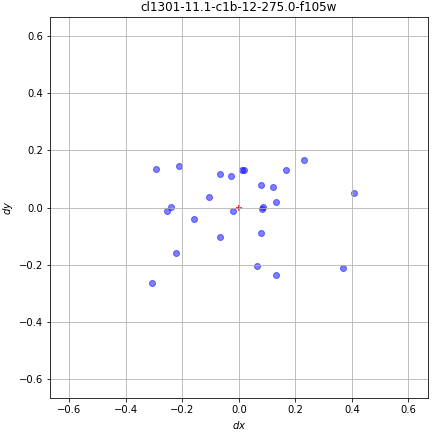

In [15]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1301-11.1-c1b-12-275.0-f105w_wcs.png") 


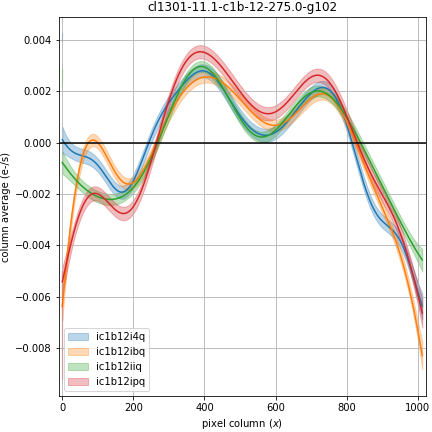

In [16]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1301-11.1-c1b-12-275.0-g102_column.png") 

In [17]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 -3.5284 -1.8880 0.0014 1.00002 0.095 26


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [18]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

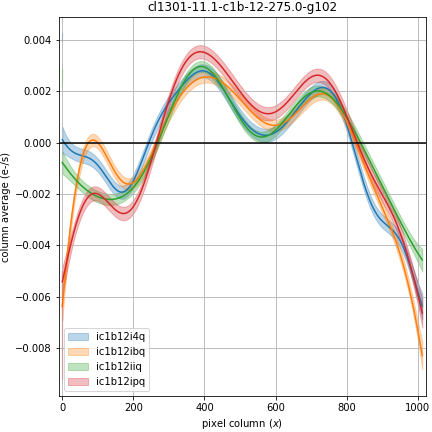

In [19]:
from IPython.display import Image
Image(filename = "./cl1301-11.1-c1b-12-275.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [20]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1301-11.1-c1b-12-275.0-f105w        -0.05   -0.04


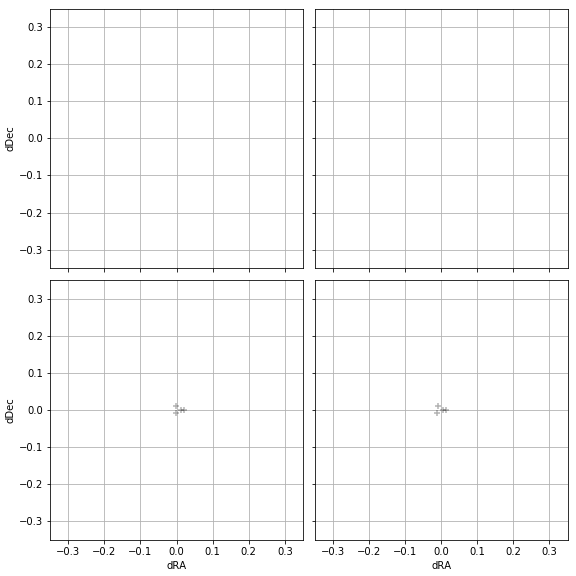

In [21]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [22]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [23]:
!ls -1 j*_dr?_sci.fits

j130120m1133-f105w_drz_sci.fits
j130120m1133-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [24]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j130120m1133-ir_seg.fits
j130120m1133-ir_drz_wht.fits
j130120m1133-ir_drz_sci.fits
j130120m1133-ir.cat.fits
j130120m1133-ir_bkg.fits
j130120m1133_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j130120m1133-ir_drz_sci.fits
WHT_FILE:	j130120m1133-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5189738869667053
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j130120m1133-f105w_drz_sci.fits
F105W_WHT_FILE:	j130120m1133-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5189738869667053
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [25]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [26]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b12i4q.01.GrismFLT.fits!
Load ic1b12iiq.01.GrismFLT.fits!
Load ic1b12ipq.01.GrismFLT.fits!
Load ic1b12ibq.01.GrismFLT.fits!
Files loaded - 4.23 sec.


### The final contamination model ###

IndexError: list index out of range

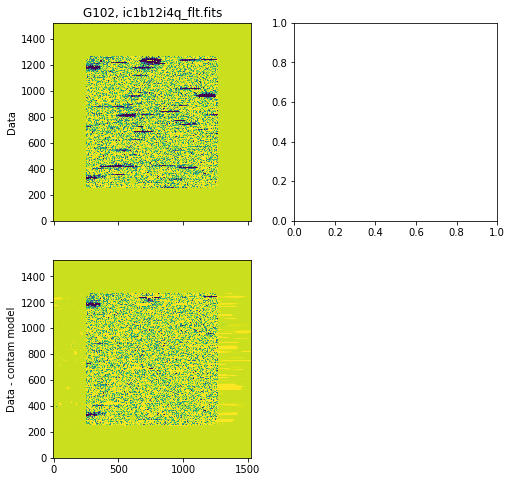

In [27]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [38]:
h = open('/data2/jrcooper/notebooks/reduction/EDisCS//j130120m1133/Extractions/c_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST) 




In [39]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')



Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [40]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

 
j130120m1133 LINE1  / 0.100" / pixf: 0.2 / point    / f105w
j130120m1133 LINE2  / 0.050" / pixf: 0.2 / point    / f105w
j130120m1133 LINE4  / 0.025" / pixf: 0.2 / point    / f105w
j130120m1133 DRIZ1  / 0.060" / pixf: 0.6 / square   / f105w
j130120m1133 DRIZ2  / 0.030" / pixf: 0.6 / square   / f105w
j130120m1133 DRIZ4  / 0.015" / pixf: 0.6 / square   / f105w


['j130120m1133-f105w_psf.fits'] 

Filename: j130120m1133-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


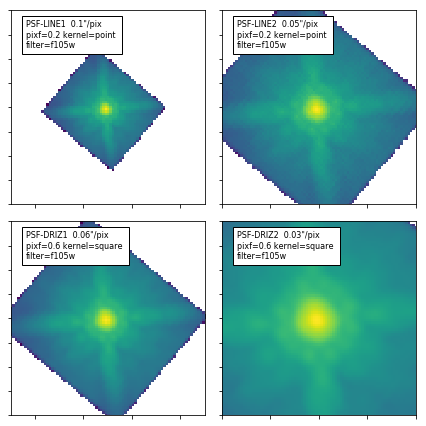

In [41]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [42]:
os.chdir('../Extractions')

In [43]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [44]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/163: 419 4
j130120m1133_00419.beams.fits
1/163: 254 4
j130120m1133_00254.beams.fits
2/163: 273 4
j130120m1133_00273.beams.fits
3/163: 130 4
j130120m1133_00130.beams.fits
4/163: 154 4
j130120m1133_00154.beams.fits
5/163: 418 4
j130120m1133_00418.beams.fits
6/163: 388 4
j130120m1133_00388.beams.fits
7/163: 251 4
j130120m1133_00251.beams.fits
8/163: 56 4
j130120m1133_00056.beams.fits
9/163: 210 4
j130120m1133_00210.beams.fits
10/163: 331 4
j130120m1133_00331.beams.fits
11/163: 202 4
j130120m1133_00202.beams.fits
12/163: 207 4
j130120m1133_00207.beams.fits
13/163: 309 4
j130120m1133_00309.beams.fits
14/163: 354 4
j130120m1133_00354.beams.fits
15/163: 406 4
j130120m1133_00406.beams.fits
16/163: 21 0
17/163: 408 4
j130120m1133_00408.beams.fits
18/163: 99 4
j130120m1133_00099.beams.fits
19/163: 201 4
j130120m1133_00201.beams.fits
20/163: 57 4
j130120m1133_00057.beams.fits
21/163: 304 4
j130120m1133_00304.beams.fits
22/163: 63 4
j130120m1133_00063.beams.fits
23/163: 26 0
24/163: 381 4
j13012

  0.2452 2198652.6 (0.1634) 32/341
  0.2502 2198481.8 (0.1634) 33/341
  0.2552 2198405.4 (0.1634) 34/341
  0.2603 2198479.7 (0.1634) 35/341
  0.2653 2198764.2 (0.1634) 36/341
  0.2704 2198986.9 (0.1634) 37/341
  0.2755 2199138.0 (0.1634) 38/341
  0.2806 2199313.7 (0.1634) 39/341
  0.2857 2199393.9 (0.1634) 40/341
  0.2909 2199468.4 (0.1634) 41/341
  0.2960 2199480.1 (0.1634) 42/341
  0.3012 2199408.2 (0.1634) 43/341
  0.3064 2199212.5 (0.1634) 44/341
  0.3117 2199126.3 (0.1634) 45/341
  0.3169 2199188.1 (0.1634) 46/341
  0.3222 2199178.5 (0.1634) 47/341
  0.3275 2198871.3 (0.1634) 48/341
  0.3328 2198640.8 (0.1634) 49/341
  0.3382 2198389.6 (0.1634) 50/341
  0.3435 2198168.8 (0.1634) 51/341
  0.3489 2198026.8 (0.1634) 52/341
  0.3543 2198023.4 (0.1634) 53/341
  0.3598 2198056.4 (0.1634) 54/341
  0.3652 2198199.7 (0.1634) 55/341
  0.3707 2198393.7 (0.1634) 56/341
  0.3762 2198455.0 (0.1634) 57/341
  0.3817 2198480.1 (0.1634) 58/341
  0.3872 2198480.0 (0.1634) 59/341
  0.3928 2198528.7 (

  1.6414 2170554.4 (1.6414) 220/341
  1.6520 2169480.1 (1.6520) 221/341
  1.6626 2169193.1 (1.6626) 222/341
  1.6733 2169064.8 (1.6733) 223/341
  1.6840 2168446.7 (1.6840) 224/341
  1.6948 2169040.0 (1.6840) 225/341
  1.7056 2169309.5 (1.6840) 226/341
  1.7164 2169743.2 (1.6840) 227/341
  1.7273 2170893.9 (1.6840) 228/341
  1.7382 2172067.0 (1.6840) 229/341
  1.7492 2173073.3 (1.6840) 230/341
  1.7602 2173942.7 (1.6840) 231/341
  1.7713 2174796.1 (1.6840) 232/341
  1.7824 2175811.6 (1.6840) 233/341
  1.7935 2177030.1 (1.6840) 234/341
  1.8047 2178604.8 (1.6840) 235/341
  1.8160 2180705.2 (1.6840) 236/341
  1.8273 2182975.9 (1.6840) 237/341
  1.8386 2184935.0 (1.6840) 238/341
  1.8500 2186569.8 (1.6840) 239/341
  1.8614 2187638.8 (1.6840) 240/341
  1.8729 2188360.6 (1.6840) 241/341
  1.8844 2189379.8 (1.6840) 242/341
  1.8959 2190427.0 (1.6840) 243/341
  1.9075 2191445.8 (1.6840) 244/341
  1.9192 2192904.3 (1.6840) 245/341
  1.9309 2194187.3 (1.6840) 246/341
  1.9426 2195586.7 (1.6840) 

  0.2304  264457.3 (0.1222) 29/341
  0.2353  264334.4 (0.1222) 30/341
  0.2402  264186.1 (0.2402) 31/341
  0.2452  264044.5 (0.2452) 32/341
  0.2502  263846.1 (0.2502) 33/341
  0.2552  263681.9 (0.2552) 34/341
  0.2603  263500.8 (0.2603) 35/341
  0.2653  263352.5 (0.2653) 36/341
  0.2704  263286.5 (0.2704) 37/341
  0.2755  263214.5 (0.2755) 38/341
  0.2806  263196.4 (0.2806) 39/341
  0.2857  263288.0 (0.2806) 40/341
  0.2909  263360.7 (0.2806) 41/341
  0.2960  263443.5 (0.2806) 42/341
  0.3012  263579.0 (0.2806) 43/341
  0.3064  263712.6 (0.2806) 44/341
  0.3117  263841.5 (0.2806) 45/341
  0.3169  263914.9 (0.2806) 46/341
  0.3222  264034.1 (0.2806) 47/341
  0.3275  264155.4 (0.2806) 48/341
  0.3328  264280.0 (0.2806) 49/341
  0.3382  264352.1 (0.2806) 50/341
  0.3435  264383.6 (0.2806) 51/341
  0.3489  264401.8 (0.2806) 52/341
  0.3543  264377.5 (0.2806) 53/341
  0.3598  264361.8 (0.2806) 54/341
  0.3652  264354.5 (0.2806) 55/341
  0.3707  264362.0 (0.2806) 56/341
  0.3762  264294.6 (

  1.6414  273966.4 (0.2806) 220/341
  1.6520  274242.9 (0.2806) 221/341
  1.6626  274249.8 (0.2806) 222/341
  1.6733  274053.2 (0.2806) 223/341
  1.6840  274184.5 (0.2806) 224/341
  1.6948  273965.0 (0.2806) 225/341
  1.7056  273860.6 (0.2806) 226/341
  1.7164  273917.6 (0.2806) 227/341
  1.7273  273664.5 (0.2806) 228/341
  1.7382  273442.4 (0.2806) 229/341
  1.7492  273304.8 (0.2806) 230/341
  1.7602  273257.7 (0.2806) 231/341
  1.7713  273432.6 (0.2806) 232/341
  1.7824  273345.0 (0.2806) 233/341
  1.7935  272793.2 (0.2806) 234/341
  1.8047  272319.4 (0.2806) 235/341
  1.8160  271746.4 (0.2806) 236/341
  1.8273  271202.2 (0.2806) 237/341
  1.8386  270598.1 (0.2806) 238/341
  1.8500  269854.0 (0.2806) 239/341
  1.8614  269392.0 (0.2806) 240/341
  1.8729  268929.9 (0.2806) 241/341
  1.8844  268036.9 (0.2806) 242/341
  1.8959  267232.5 (0.2806) 243/341
  1.9075  266719.2 (0.2806) 244/341
  1.9192  266251.2 (0.2806) 245/341
  1.9309  265746.5 (0.2806) 246/341
  1.9426  265226.4 (0.2806) 

  0.2255   83368.4 (0.1964) 28/341
  0.2304   83430.0 (0.1964) 29/341
  0.2353   83456.6 (0.1964) 30/341
  0.2402   83357.9 (0.1964) 31/341
  0.2452   83397.9 (0.1964) 32/341
  0.2502   83486.5 (0.1964) 33/341
  0.2552   83474.1 (0.1964) 34/341
  0.2603   83487.6 (0.1964) 35/341
  0.2653   83516.4 (0.1964) 36/341
  0.2704   83471.1 (0.1964) 37/341
  0.2755   83410.8 (0.1964) 38/341
  0.2806   83453.2 (0.1964) 39/341
  0.2857   83482.5 (0.1964) 40/341
  0.2909   83384.2 (0.1964) 41/341
  0.2960   83368.8 (0.1964) 42/341
  0.3012   83370.4 (0.1964) 43/341
  0.3064   83317.2 (0.1964) 44/341
  0.3117   83339.9 (0.1964) 45/341
  0.3169   83342.0 (0.1964) 46/341
  0.3222   83325.3 (0.1964) 47/341
  0.3275   83254.6 (0.1964) 48/341
  0.3328   83140.2 (0.1964) 49/341
  0.3382   83085.3 (0.1964) 50/341
  0.3435   83057.7 (0.1964) 51/341
  0.3489   82982.3 (0.3489) 52/341
  0.3543   82928.1 (0.3543) 53/341
  0.3598   82879.8 (0.3598) 54/341
  0.3652   82811.6 (0.3652) 55/341
  0.3707   82788.7 (

  1.6733  105449.0 (0.4438) 223/341
  1.6840  105357.2 (0.4438) 224/341
  1.6948  105057.0 (0.4438) 225/341
  1.7056  105022.7 (0.4438) 226/341
  1.7164  104552.8 (0.4438) 227/341
  1.7273  103910.6 (0.4438) 228/341
  1.7382  103472.6 (0.4438) 229/341
  1.7492  102693.5 (0.4438) 230/341
  1.7602  101899.2 (0.4438) 231/341
  1.7713  101458.7 (0.4438) 232/341
  1.7824  100698.2 (0.4438) 233/341
  1.7935   99982.3 (0.4438) 234/341
  1.8047   99812.9 (0.4438) 235/341
  1.8160   99153.7 (0.4438) 236/341
  1.8273   98698.4 (0.4438) 237/341
  1.8386   97956.0 (0.4438) 238/341
  1.8500   96674.0 (0.4438) 239/341
  1.8614   95861.4 (0.4438) 240/341
  1.8729   94861.2 (0.4438) 241/341
  1.8844   93763.1 (0.4438) 242/341
  1.8959   93039.5 (0.4438) 243/341
  1.9075   92334.0 (0.4438) 244/341
  1.9192   91463.0 (0.4438) 245/341
  1.9309   90899.9 (0.4438) 246/341
  1.9426   89723.1 (0.4438) 247/341
  1.9544   88895.6 (0.4438) 248/341
  1.9663   88125.4 (0.4438) 249/341
  1.9782   87176.3 (0.4438) 

  0.2704   34180.3 (0.1964) 37/341
  0.2755   34134.6 (0.1964) 38/341
  0.2806   34139.1 (0.1964) 39/341
  0.2857   34139.3 (0.1964) 40/341
  0.2909   34085.8 (0.1964) 41/341
  0.2960   34027.2 (0.1964) 42/341
  0.3012   34026.2 (0.1964) 43/341
  0.3064   34017.8 (0.1964) 44/341
  0.3117   33984.9 (0.1964) 45/341
  0.3169   33991.9 (0.1964) 46/341
  0.3222   33966.8 (0.1964) 47/341
  0.3275   33927.7 (0.1964) 48/341
  0.3328   33914.9 (0.1964) 49/341
  0.3382   33902.4 (0.1964) 50/341
  0.3435   33885.2 (0.1964) 51/341
  0.3489   33880.7 (0.1964) 52/341
  0.3543   33879.5 (0.1964) 53/341
  0.3598   33848.0 (0.3598) 54/341
  0.3652   33820.7 (0.3652) 55/341
  0.3707   33805.0 (0.3707) 56/341
  0.3762   33775.3 (0.3762) 57/341
  0.3817   33753.2 (0.3817) 58/341
  0.3872   33752.3 (0.3872) 59/341
  0.3928   33743.8 (0.3928) 60/341
  0.3984   33716.7 (0.3984) 61/341
  0.4040   33689.0 (0.4040) 62/341
  0.4096   33649.0 (0.4096) 63/341
  0.4153   33605.8 (0.4153) 64/341
  0.4209   33608.3 (

  1.7602   36800.9 (0.5331) 231/341
  1.7713   36103.7 (0.5331) 232/341
  1.7824   35497.7 (0.5331) 233/341
  1.7935   35095.5 (0.5331) 234/341
  1.8047   34545.5 (0.5331) 235/341
  1.8160   34251.1 (0.5331) 236/341
  1.8273   33950.3 (0.5331) 237/341
  1.8386   33802.9 (0.5331) 238/341
  1.8500   33691.9 (0.5331) 239/341
  1.8614   33633.0 (0.5331) 240/341
  1.8729   33579.5 (0.5331) 241/341
  1.8844   33548.8 (0.5331) 242/341
  1.8959   33529.7 (0.5331) 243/341
  1.9075   33498.1 (0.5331) 244/341
  1.9192   33443.3 (0.5331) 245/341
  1.9309   33418.6 (0.5331) 246/341
  1.9426   33421.8 (0.5331) 247/341
  1.9544   33415.7 (0.5331) 248/341
  1.9663   33397.5 (0.5331) 249/341
  1.9782   33411.0 (0.5331) 250/341
  1.9901   33432.0 (0.5331) 251/341
  2.0021   33440.4 (0.5331) 252/341
  2.0141   33446.2 (0.5331) 253/341
  2.0262   33462.3 (0.5331) 254/341
  2.0383   33478.0 (0.5331) 255/341
  2.0505   33490.8 (0.5331) 256/341
  2.0627   33502.6 (0.5331) 257/341
  2.0750   33507.4 (0.5331) 

  0.2960   38821.6 (0.2060) 42/341
  0.3012   38765.2 (0.2060) 43/341
  0.3064   38740.1 (0.2060) 44/341
  0.3117   38725.2 (0.2060) 45/341
  0.3169   38699.8 (0.2060) 46/341
  0.3222   38686.3 (0.2060) 47/341
  0.3275   38656.3 (0.2060) 48/341
  0.3328   38631.8 (0.2060) 49/341
  0.3382   38584.9 (0.2060) 50/341
  0.3435   38534.0 (0.2060) 51/341
  0.3489   38504.4 (0.2060) 52/341
  0.3543   38519.3 (0.2060) 53/341
  0.3598   38548.5 (0.2060) 54/341
  0.3652   38568.1 (0.2060) 55/341
  0.3707   38549.1 (0.2060) 56/341
  0.3762   38508.2 (0.2060) 57/341
  0.3817   38475.1 (0.2060) 58/341
  0.3872   38445.7 (0.2060) 59/341
  0.3928   38444.7 (0.2060) 60/341
  0.3984   38453.2 (0.2060) 61/341
  0.4040   38474.6 (0.2060) 62/341
  0.4096   38468.9 (0.2060) 63/341
  0.4153   38457.8 (0.2060) 64/341
  0.4209   38468.7 (0.2060) 65/341
  0.4266   38490.6 (0.2060) 66/341
  0.4323   38497.7 (0.2060) 67/341
  0.4381   38482.2 (0.2060) 68/341
  0.4438   38456.4 (0.2060) 69/341
  0.4496   38441.2 (

  1.7492   44449.1 (0.2060) 230/341
  1.7602   44647.8 (0.2060) 231/341
  1.7713   44502.6 (0.2060) 232/341
  1.7824   44423.5 (0.2060) 233/341
  1.7935   44228.9 (0.2060) 234/341
  1.8047   43946.2 (0.2060) 235/341
  1.8160   44070.9 (0.2060) 236/341
  1.8273   44282.6 (0.2060) 237/341
  1.8386   44162.8 (0.2060) 238/341
  1.8500   44263.0 (0.2060) 239/341
  1.8614   43808.6 (0.2060) 240/341
  1.8729   43417.2 (0.2060) 241/341
  1.8844   42890.6 (0.2060) 242/341
  1.8959   42379.5 (0.2060) 243/341
  1.9075   41871.5 (0.2060) 244/341
  1.9192   41682.5 (0.2060) 245/341
  1.9309   41538.9 (0.2060) 246/341
  1.9426   41220.5 (0.2060) 247/341
  1.9544   41038.3 (0.2060) 248/341
  1.9663   40719.7 (0.2060) 249/341
  1.9782   40467.2 (0.2060) 250/341
  1.9901   40014.2 (0.2060) 251/341
  2.0021   39932.6 (0.2060) 252/341
  2.0141   39616.7 (0.2060) 253/341
  2.0262   39516.2 (0.2060) 254/341
  2.0383   39295.4 (0.2060) 255/341
  2.0505   39050.3 (0.2060) 256/341
  2.0627   38850.3 (0.2060) 

  0.2755   14992.4 (0.2552) 38/341
  0.2806   15042.7 (0.2552) 39/341
  0.2857   15134.4 (0.2552) 40/341
  0.2909   15247.8 (0.2552) 41/341
  0.2960   15329.1 (0.2552) 42/341
  0.3012   15368.3 (0.2552) 43/341
  0.3064   15387.3 (0.2552) 44/341
  0.3117   15405.3 (0.2552) 45/341
  0.3169   15418.3 (0.2552) 46/341
  0.3222   15427.5 (0.2552) 47/341
  0.3275   15433.6 (0.2552) 48/341
  0.3328   15432.3 (0.2552) 49/341
  0.3382   15420.0 (0.2552) 50/341
  0.3435   15398.6 (0.2552) 51/341
  0.3489   15372.1 (0.2552) 52/341
  0.3543   15345.2 (0.2552) 53/341
  0.3598   15319.9 (0.2552) 54/341
  0.3652   15297.2 (0.2552) 55/341
  0.3707   15278.0 (0.2552) 56/341
  0.3762   15264.4 (0.2552) 57/341
  0.3817   15259.1 (0.2552) 58/341
  0.3872   15260.7 (0.2552) 59/341
  0.3928   15267.6 (0.2552) 60/341
  0.3984   15282.2 (0.2552) 61/341
  0.4040   15301.1 (0.2552) 62/341
  0.4096   15318.1 (0.2552) 63/341
  0.4153   15331.1 (0.2552) 64/341
  0.4209   15340.2 (0.2552) 65/341
  0.4266   15343.2 (

  1.7273   14618.8 (1.2599) 228/341
  1.7382   14554.9 (1.2599) 229/341
  1.7492   14496.6 (1.2599) 230/341
  1.7602   14442.2 (1.2599) 231/341
  1.7713   14379.2 (1.2599) 232/341
  1.7824   14323.1 (1.2599) 233/341
  1.7935   14282.1 (1.2599) 234/341
  1.8047   14263.0 (1.2599) 235/341
  1.8160   14272.2 (1.2599) 236/341
  1.8273   14308.6 (1.2599) 237/341
  1.8386   14351.9 (1.2599) 238/341
  1.8500   14341.5 (1.2599) 239/341
  1.8614   14302.5 (1.2599) 240/341
  1.8729   14196.5 (1.2599) 241/341
  1.8844   14072.1 (1.2599) 242/341
  1.8959   14001.4 (1.2599) 243/341
  1.9075   13989.8 (1.2599) 244/341
  1.9192   13999.6 (1.2599) 245/341
  1.9309   14008.5 (1.2599) 246/341
  1.9426   14032.4 (1.2599) 247/341
  1.9544   14112.0 (1.2599) 248/341
  1.9663   14207.2 (1.2599) 249/341
  1.9782   14266.5 (1.2599) 250/341
  1.9901   14297.9 (1.2599) 251/341
  2.0021   14303.5 (1.2599) 252/341
  2.0141   14207.2 (1.2599) 253/341
  2.0262   14087.1 (1.2599) 254/341
  2.0383   14042.6 (1.2599) 

  0.2806    7207.8 (0.2704) 39/341
  0.2857    7224.2 (0.2704) 40/341
  0.2909    7240.5 (0.2704) 41/341
  0.2960    7252.2 (0.2704) 42/341
  0.3012    7270.1 (0.2704) 43/341
  0.3064    7288.9 (0.2704) 44/341
  0.3117    7295.7 (0.2704) 45/341
  0.3169    7311.7 (0.2704) 46/341
  0.3222    7321.4 (0.2704) 47/341
  0.3275    7335.2 (0.2704) 48/341
  0.3328    7343.3 (0.2704) 49/341
  0.3382    7342.5 (0.2704) 50/341
  0.3435    7326.5 (0.2704) 51/341
  0.3489    7318.1 (0.2704) 52/341
  0.3543    7313.6 (0.2704) 53/341
  0.3598    7318.4 (0.2704) 54/341
  0.3652    7320.1 (0.2704) 55/341
  0.3707    7318.6 (0.2704) 56/341
  0.3762    7325.4 (0.2704) 57/341
  0.3817    7337.4 (0.2704) 58/341
  0.3872    7345.5 (0.2704) 59/341
  0.3928    7359.2 (0.2704) 60/341
  0.3984    7388.7 (0.2704) 61/341
  0.4040    7406.4 (0.2704) 62/341
  0.4096    7406.8 (0.2704) 63/341
  0.4153    7402.9 (0.2704) 64/341
  0.4209    7398.1 (0.2704) 65/341
  0.4266    7392.4 (0.2704) 66/341
  0.4323    7376.3 (

  1.7273    9362.2 (0.5028) 228/341
  1.7382    9374.7 (0.5028) 229/341
  1.7492    9510.7 (0.5028) 230/341
  1.7602    9639.9 (0.5028) 231/341
  1.7713    9559.7 (0.5028) 232/341
  1.7824    9505.3 (0.5028) 233/341
  1.7935    9462.3 (0.5028) 234/341
  1.8047    9419.5 (0.5028) 235/341
  1.8160    9414.3 (0.5028) 236/341
  1.8273    9341.4 (0.5028) 237/341
  1.8386    9195.3 (0.5028) 238/341
  1.8500    9055.1 (0.5028) 239/341
  1.8614    8786.8 (0.5028) 240/341
  1.8729    8597.3 (0.5028) 241/341
  1.8844    8407.7 (0.5028) 242/341
  1.8959    8270.3 (0.5028) 243/341
  1.9075    8178.0 (0.5028) 244/341
  1.9192    8011.2 (0.5028) 245/341
  1.9309    7891.0 (0.5028) 246/341
  1.9426    7784.7 (0.5028) 247/341
  1.9544    7659.5 (0.5028) 248/341
  1.9663    7512.1 (0.5028) 249/341
  1.9782    7444.0 (0.5028) 250/341
  1.9901    7371.3 (0.5028) 251/341
  2.0021    7402.3 (0.5028) 252/341
  2.0141    7388.1 (0.5028) 253/341
  2.0262    7342.2 (0.5028) 254/341
  2.0383    7309.6 (0.5028) 

  0.2755    8016.4 (0.2755) 38/341
  0.2806    8013.1 (0.2806) 39/341
  0.2857    8006.6 (0.2857) 40/341
  0.2909    8002.2 (0.2909) 41/341
  0.2960    8020.5 (0.2909) 42/341
  0.3012    8038.2 (0.2909) 43/341
  0.3064    8054.6 (0.2909) 44/341
  0.3117    8072.8 (0.2909) 45/341
  0.3169    8086.4 (0.2909) 46/341
  0.3222    8100.4 (0.2909) 47/341
  0.3275    8119.4 (0.2909) 48/341
  0.3328    8130.1 (0.2909) 49/341
  0.3382    8136.3 (0.2909) 50/341
  0.3435    8136.6 (0.2909) 51/341
  0.3489    8135.6 (0.2909) 52/341
  0.3543    8135.1 (0.2909) 53/341
  0.3598    8134.2 (0.2909) 54/341
  0.3652    8135.7 (0.2909) 55/341
  0.3707    8137.4 (0.2909) 56/341
  0.3762    8143.2 (0.2909) 57/341
  0.3817    8152.3 (0.2909) 58/341
  0.3872    8164.4 (0.2909) 59/341
  0.3928    8170.3 (0.2909) 60/341
  0.3984    8185.0 (0.2909) 61/341
  0.4040    8199.5 (0.2909) 62/341
  0.4096    8209.8 (0.2909) 63/341
  0.4153    8216.1 (0.2909) 64/341
  0.4209    8229.6 (0.2909) 65/341
  0.4266    8240.4 (

  1.7056    9858.6 (0.5209) 226/341
  1.7164    9954.9 (0.5209) 227/341
  1.7273   10007.6 (0.5209) 228/341
  1.7382   10097.7 (0.5209) 229/341
  1.7492   10214.5 (0.5209) 230/341
  1.7602   10328.5 (0.5209) 231/341
  1.7713   10435.0 (0.5209) 232/341
  1.7824   10457.9 (0.5209) 233/341
  1.7935   10392.1 (0.5209) 234/341
  1.8047   10361.0 (0.5209) 235/341
  1.8160   10279.0 (0.5209) 236/341
  1.8273   10193.1 (0.5209) 237/341
  1.8386   10072.1 (0.5209) 238/341
  1.8500    9908.4 (0.5209) 239/341
  1.8614    9805.4 (0.5209) 240/341
  1.8729    9583.9 (0.5209) 241/341
  1.8844    9447.3 (0.5209) 242/341
  1.8959    9303.3 (0.5209) 243/341
  1.9075    9138.7 (0.5209) 244/341
  1.9192    9028.1 (0.5209) 245/341
  1.9309    8927.7 (0.5209) 246/341
  1.9426    8805.4 (0.5209) 247/341
  1.9544    8746.9 (0.5209) 248/341
  1.9663    8651.0 (0.5209) 249/341
  1.9782    8484.7 (0.5209) 250/341
  1.9901    8349.9 (0.5209) 251/341
  2.0021    8204.3 (0.5209) 252/341
  2.0141    8106.5 (0.5209) 

  0.2603    9805.6 (0.1774) 35/341
  0.2653    9797.9 (0.1774) 36/341
  0.2704    9788.5 (0.1774) 37/341
  0.2755    9781.4 (0.1774) 38/341
  0.2806    9778.2 (0.1774) 39/341
  0.2857    9776.7 (0.1774) 40/341
  0.2909    9775.9 (0.1774) 41/341
  0.2960    9787.1 (0.1774) 42/341
  0.3012    9803.9 (0.1774) 43/341
  0.3064    9821.4 (0.1774) 44/341
  0.3117    9828.6 (0.1774) 45/341
  0.3169    9831.5 (0.1774) 46/341
  0.3222    9827.5 (0.1774) 47/341
  0.3275    9824.4 (0.1774) 48/341
  0.3328    9823.2 (0.1774) 49/341
  0.3382    9819.7 (0.1774) 50/341
  0.3435    9814.3 (0.1774) 51/341
  0.3489    9809.7 (0.1774) 52/341
  0.3543    9805.0 (0.1774) 53/341
  0.3598    9800.8 (0.1774) 54/341
  0.3652    9795.9 (0.1774) 55/341
  0.3707    9792.3 (0.1774) 56/341
  0.3762    9785.1 (0.1774) 57/341
  0.3817    9771.8 (0.1774) 58/341
  0.3872    9753.6 (0.3872) 59/341
  0.3928    9734.3 (0.3928) 60/341
  0.3984    9725.8 (0.3984) 61/341
  0.4040    9740.6 (0.3984) 62/341
  0.4096    9770.0 (

  1.7056   10990.7 (0.3984) 226/341
  1.7164   11001.2 (0.3984) 227/341
  1.7273   11034.0 (0.3984) 228/341
  1.7382   11106.8 (0.3984) 229/341
  1.7492   11124.8 (0.3984) 230/341
  1.7602   11193.2 (0.3984) 231/341
  1.7713   11275.8 (0.3984) 232/341
  1.7824   11314.0 (0.3984) 233/341
  1.7935   11378.5 (0.3984) 234/341
  1.8047   11478.2 (0.3984) 235/341
  1.8160   11507.9 (0.3984) 236/341
  1.8273   11529.4 (0.3984) 237/341
  1.8386   11525.4 (0.3984) 238/341
  1.8500   11409.0 (0.3984) 239/341
  1.8614   11292.6 (0.3984) 240/341
  1.8729   11197.1 (0.3984) 241/341
  1.8844   11061.2 (0.3984) 242/341
  1.8959   10953.7 (0.3984) 243/341
  1.9075   10862.7 (0.3984) 244/341
  1.9192   10730.0 (0.3984) 245/341
  1.9309   10658.1 (0.3984) 246/341
  1.9426   10574.1 (0.3984) 247/341
  1.9544   10463.8 (0.3984) 248/341
  1.9663   10378.4 (0.3984) 249/341
  1.9782   10334.7 (0.3984) 250/341
  1.9901   10266.2 (0.3984) 251/341
  2.0021   10233.6 (0.3984) 252/341
  2.0141   10143.5 (0.3984) 

  0.2755   11866.5 (0.1000) 38/341
  0.2806   11892.9 (0.1000) 39/341
  0.2857   11875.9 (0.1000) 40/341
  0.2909   11854.0 (0.1000) 41/341
  0.2960   11854.5 (0.1000) 42/341
  0.3012   11841.8 (0.1000) 43/341
  0.3064   11856.6 (0.1000) 44/341
  0.3117   11872.7 (0.1000) 45/341
  0.3169   11880.2 (0.1000) 46/341
  0.3222   11868.5 (0.1000) 47/341
  0.3275   11868.7 (0.1000) 48/341
  0.3328   11866.5 (0.1000) 49/341
  0.3382   11875.6 (0.1000) 50/341
  0.3435   11900.8 (0.1000) 51/341
  0.3489   11911.7 (0.1000) 52/341
  0.3543   11911.8 (0.1000) 53/341
  0.3598   11915.3 (0.1000) 54/341
  0.3652   11908.2 (0.1000) 55/341
  0.3707   11919.3 (0.1000) 56/341
  0.3762   11935.5 (0.1000) 57/341
  0.3817   11944.5 (0.1000) 58/341
  0.3872   11947.3 (0.1000) 59/341
  0.3928   11942.8 (0.1000) 60/341
  0.3984   11953.3 (0.1000) 61/341
  0.4040   11998.4 (0.1000) 62/341
  0.4096   12049.3 (0.1000) 63/341
  0.4153   12067.2 (0.1000) 64/341
  0.4209   12062.1 (0.1000) 65/341
  0.4266   12058.2 (

  1.7492   15583.3 (0.6476) 230/341
  1.7602   15606.4 (0.6476) 231/341
  1.7713   15577.3 (0.6476) 232/341
  1.7824   15617.8 (0.6476) 233/341
  1.7935   15688.8 (0.6476) 234/341
  1.8047   15860.5 (0.6476) 235/341
  1.8160   16007.9 (0.6476) 236/341
  1.8273   15980.2 (0.6476) 237/341
  1.8386   15886.2 (0.6476) 238/341
  1.8500   15738.6 (0.6476) 239/341
  1.8614   15349.1 (0.6476) 240/341
  1.8729   14813.9 (0.6476) 241/341
  1.8844   14490.6 (0.6476) 242/341
  1.8959   14421.8 (0.6476) 243/341
  1.9075   14302.8 (0.6476) 244/341
  1.9192   14256.3 (0.6476) 245/341
  1.9309   13960.1 (0.6476) 246/341
  1.9426   13666.5 (0.6476) 247/341
  1.9544   13469.5 (0.6476) 248/341
  1.9663   13227.9 (0.6476) 249/341
  1.9782   13065.6 (0.6476) 250/341
  1.9901   13048.1 (0.6476) 251/341
  2.0021   12953.3 (0.6476) 252/341
  2.0141   12740.1 (0.6476) 253/341
  2.0262   12505.0 (0.6476) 254/341
  2.0383   12243.9 (0.6476) 255/341
  2.0505   12073.7 (0.6476) 256/341
  2.0627   11950.8 (0.6476) 

  0.2909   10221.7 (0.2304) 41/341
  0.2960   10213.3 (0.2304) 42/341
  0.3012   10196.1 (0.2304) 43/341
  0.3064   10223.1 (0.2304) 44/341
  0.3117   10227.9 (0.2304) 45/341
  0.3169   10232.6 (0.2304) 46/341
  0.3222   10221.6 (0.2304) 47/341
  0.3275   10222.8 (0.2304) 48/341
  0.3328   10223.2 (0.2304) 49/341
  0.3382   10233.7 (0.2304) 50/341
  0.3435   10239.8 (0.2304) 51/341
  0.3489   10239.3 (0.2304) 52/341
  0.3543   10247.2 (0.2304) 53/341
  0.3598   10252.1 (0.2304) 54/341
  0.3652   10263.6 (0.2304) 55/341
  0.3707   10272.7 (0.2304) 56/341
  0.3762   10272.8 (0.2304) 57/341
  0.3817   10274.2 (0.2304) 58/341
  0.3872   10267.2 (0.2304) 59/341
  0.3928   10241.4 (0.2304) 60/341
  0.3984   10227.6 (0.2304) 61/341
  0.4040   10248.6 (0.2304) 62/341
  0.4096   10249.7 (0.2304) 63/341
  0.4153   10252.2 (0.2304) 64/341
  0.4209   10227.6 (0.2304) 65/341
  0.4266   10198.4 (0.2304) 66/341
  0.4323   10189.7 (0.2304) 67/341
  0.4381   10201.7 (0.2304) 68/341
  0.4438   10209.6 (

  1.7492   13093.8 (0.2304) 230/341
  1.7602   13061.6 (0.2304) 231/341
  1.7713   13104.6 (0.2304) 232/341
  1.7824   13116.4 (0.2304) 233/341
  1.7935   13186.6 (0.2304) 234/341
  1.8047   13102.4 (0.2304) 235/341
  1.8160   12980.9 (0.2304) 236/341
  1.8273   12994.3 (0.2304) 237/341
  1.8386   12737.1 (0.2304) 238/341
  1.8500   12425.4 (0.2304) 239/341
  1.8614   12314.6 (0.2304) 240/341
  1.8729   12126.6 (0.2304) 241/341
  1.8844   12036.3 (0.2304) 242/341
  1.8959   11903.6 (0.2304) 243/341
  1.9075   11771.0 (0.2304) 244/341
  1.9192   11521.1 (0.2304) 245/341
  1.9309   11465.2 (0.2304) 246/341
  1.9426   11281.3 (0.2304) 247/341
  1.9544   11104.6 (0.2304) 248/341
  1.9663   10984.4 (0.2304) 249/341
  1.9782   11058.7 (0.2304) 250/341
  1.9901   10926.6 (0.2304) 251/341
  2.0021   10735.1 (0.2304) 252/341
  2.0141   10581.3 (0.2304) 253/341
  2.0262   10353.4 (0.2304) 254/341
  2.0383   10229.5 (0.2304) 255/341
  2.0505   10167.6 (0.2304) 256/341
  2.0627   10136.6 (0.2304) 

  0.1312   18881.7 (0.1000) 8/341
  0.1358   18900.1 (0.1000) 9/341
  0.1403   18924.1 (0.1000) 10/341
  0.1449   18946.3 (0.1000) 11/341
  0.1495   18968.5 (0.1000) 12/341
  0.1541   18991.3 (0.1000) 13/341
  0.1587   19011.8 (0.1000) 14/341
  0.1634   19025.1 (0.1000) 15/341
  0.1680   19030.7 (0.1000) 16/341
  0.1727   19025.4 (0.1000) 17/341
  0.1774   19005.8 (0.1000) 18/341
  0.1821   18975.1 (0.1000) 19/341
  0.1869   18946.4 (0.1000) 20/341
  0.1916   18921.1 (0.1000) 21/341
  0.1964   18897.0 (0.1000) 22/341
  0.2012   18881.3 (0.1000) 23/341
  0.2060   18872.4 (0.1000) 24/341
  0.2108   18865.3 (0.1000) 25/341
  0.2157   18862.6 (0.1000) 26/341
  0.2206   18860.1 (0.1000) 27/341
  0.2255   18851.2 (0.1000) 28/341
  0.2304   18840.6 (0.1000) 29/341
  0.2353   18823.8 (0.1000) 30/341
  0.2402   18807.5 (0.1000) 31/341
  0.2452   18794.1 (0.1000) 32/341
  0.2502   18779.1 (0.1000) 33/341
  0.2552   18763.2 (0.1000) 34/341
  0.2603   18747.8 (0.2603) 35/341
  0.2653   18732.5 (0.

  1.4092   19022.6 (0.5028) 197/341
  1.4189   18984.4 (0.5028) 198/341
  1.4286   18990.2 (0.5028) 199/341
  1.4383   18986.2 (0.5028) 200/341
  1.4481   18998.9 (0.5028) 201/341
  1.4579   19031.8 (0.5028) 202/341
  1.4678   19050.7 (0.5028) 203/341
  1.4776   19103.9 (0.5028) 204/341
  1.4876   19230.2 (0.5028) 205/341
  1.4975   19317.7 (0.5028) 206/341
  1.5076   19411.0 (0.5028) 207/341
  1.5176   19506.6 (0.5028) 208/341
  1.5277   19605.4 (0.5028) 209/341
  1.5378   19718.6 (0.5028) 210/341
  1.5480   19812.2 (0.5028) 211/341
  1.5582   19864.0 (0.5028) 212/341
  1.5685   19985.6 (0.5028) 213/341
  1.5788   20081.3 (0.5028) 214/341
  1.5891   20136.0 (0.5028) 215/341
  1.5995   20167.9 (0.5028) 216/341
  1.6099   20244.9 (0.5028) 217/341
  1.6204   20353.0 (0.5028) 218/341
  1.6309   20422.7 (0.5028) 219/341
  1.6414   20518.0 (0.5028) 220/341
  1.6520   20606.5 (0.5028) 221/341
  1.6626   20778.0 (0.5028) 222/341
  1.6733   21038.1 (0.5028) 223/341
  1.6840   21335.0 (0.5028) 

  0.1222   10265.1 (0.1177) 6/341
  0.1267   10275.7 (0.1177) 7/341
  0.1312   10278.1 (0.1177) 8/341
  0.1358   10279.9 (0.1177) 9/341
  0.1403   10276.8 (0.1177) 10/341
  0.1449   10275.7 (0.1177) 11/341
  0.1495   10284.6 (0.1177) 12/341
  0.1541   10290.7 (0.1177) 13/341
  0.1587   10286.7 (0.1177) 14/341
  0.1634   10285.1 (0.1177) 15/341
  0.1680   10295.4 (0.1177) 16/341
  0.1727   10297.2 (0.1177) 17/341
  0.1774   10296.5 (0.1177) 18/341
  0.1821   10293.2 (0.1177) 19/341
  0.1869   10299.9 (0.1177) 20/341
  0.1916   10295.2 (0.1177) 21/341
  0.1964   10294.3 (0.1177) 22/341
  0.2012   10293.7 (0.1177) 23/341
  0.2060   10293.5 (0.1177) 24/341
  0.2108   10292.1 (0.1177) 25/341
  0.2157   10292.1 (0.1177) 26/341
  0.2206   10291.2 (0.1177) 27/341
  0.2255   10291.6 (0.1177) 28/341
  0.2304   10289.7 (0.1177) 29/341
  0.2353   10288.2 (0.1177) 30/341
  0.2402   10287.7 (0.1177) 31/341
  0.2452   10281.5 (0.1177) 32/341
  0.2502   10264.3 (0.1177) 33/341
  0.2552   10258.6 (0.25

  1.3900   10444.0 (0.5028) 195/341
  1.3996   10461.1 (0.5028) 196/341
  1.4092   10467.1 (0.5028) 197/341
  1.4189   10471.7 (0.5028) 198/341
  1.4286   10442.2 (0.5028) 199/341
  1.4383   10412.4 (0.5028) 200/341
  1.4481   10437.7 (0.5028) 201/341
  1.4579   10492.6 (0.5028) 202/341
  1.4678   10543.0 (0.5028) 203/341
  1.4776   10561.9 (0.5028) 204/341
  1.4876   10549.5 (0.5028) 205/341
  1.4975   10562.5 (0.5028) 206/341
  1.5076   10566.5 (0.5028) 207/341
  1.5176   10560.9 (0.5028) 208/341
  1.5277   10591.0 (0.5028) 209/341
  1.5378   10604.2 (0.5028) 210/341
  1.5480   10634.7 (0.5028) 211/341
  1.5582   10669.5 (0.5028) 212/341
  1.5685   10704.0 (0.5028) 213/341
  1.5788   10721.4 (0.5028) 214/341
  1.5891   10758.9 (0.5028) 215/341
  1.5995   10770.6 (0.5028) 216/341
  1.6099   10793.5 (0.5028) 217/341
  1.6204   10781.9 (0.5028) 218/341
  1.6309   10767.4 (0.5028) 219/341
  1.6414   10726.7 (0.5028) 220/341
  1.6520   10732.7 (0.5028) 221/341
  1.6626   10715.9 (0.5028) 

  0.1403    8155.8 (0.1133) 10/341
  0.1449    8133.7 (0.1133) 11/341
  0.1495    8137.0 (0.1133) 12/341
  0.1541    8153.6 (0.1133) 13/341
  0.1587    8166.7 (0.1133) 14/341
  0.1634    8172.9 (0.1133) 15/341
  0.1680    8158.5 (0.1133) 16/341
  0.1727    8147.0 (0.1133) 17/341
  0.1774    8163.3 (0.1133) 18/341
  0.1821    8148.3 (0.1133) 19/341
  0.1869    8118.1 (0.1133) 20/341
  0.1916    8116.4 (0.1133) 21/341
  0.1964    8112.3 (0.1133) 22/341
  0.2012    8108.4 (0.1133) 23/341
  0.2060    8081.3 (0.1133) 24/341
  0.2108    8055.8 (0.2108) 25/341
  0.2157    8033.9 (0.2157) 26/341
  0.2206    8041.0 (0.2157) 27/341
  0.2255    8033.2 (0.2255) 28/341
  0.2304    8033.9 (0.2255) 29/341
  0.2353    8016.6 (0.2353) 30/341
  0.2402    7990.6 (0.2402) 31/341
  0.2452    7990.6 (0.2452) 32/341
  0.2502    8004.1 (0.2452) 33/341
  0.2552    8012.2 (0.2452) 34/341
  0.2603    7990.5 (0.2603) 35/341
  0.2653    7995.5 (0.2603) 36/341
  0.2704    8032.3 (0.2603) 37/341
  0.2755    8039.6 (

  1.5176    9717.9 (0.2603) 208/341
  1.5277    9846.7 (0.2603) 209/341
  1.5378    9938.8 (0.2603) 210/341
  1.5480    9983.8 (0.2603) 211/341
  1.5582   10008.0 (0.2603) 212/341
  1.5685   10103.1 (0.2603) 213/341
  1.5788   10068.5 (0.2603) 214/341
  1.5891   10070.6 (0.2603) 215/341
  1.5995   10229.9 (0.2603) 216/341
  1.6099   10295.2 (0.2603) 217/341
  1.6204   10396.6 (0.2603) 218/341
  1.6309   10413.6 (0.2603) 219/341
  1.6414   10331.1 (0.2603) 220/341
  1.6520   10399.2 (0.2603) 221/341
  1.6626   10477.0 (0.2603) 222/341
  1.6733   10412.9 (0.2603) 223/341
  1.6840   10463.2 (0.2603) 224/341
  1.6948   10539.0 (0.2603) 225/341
  1.7056   10600.9 (0.2603) 226/341
  1.7164   10541.0 (0.2603) 227/341
  1.7273   10523.4 (0.2603) 228/341
  1.7382   10577.9 (0.2603) 229/341
  1.7492   10708.2 (0.2603) 230/341
  1.7602   10684.6 (0.2603) 231/341
  1.7713   10605.1 (0.2603) 232/341
  1.7824   10643.5 (0.2603) 233/341
  1.7935   10736.2 (0.2603) 234/341
  1.8047   10649.4 (0.2603) 

- 2.1133    7989.4 (2.1133) 57/99
- 2.1138    7989.5 (2.1133) 58/99
- 2.1143    7989.6 (2.1133) 59/99
- 2.1148    7989.7 (2.1133) 60/99
- 2.1153    7989.8 (2.1133) 61/99
- 2.1158    7990.1 (2.1133) 62/99
- 2.1163    7990.6 (2.1133) 63/99
- 2.1168    7991.3 (2.1133) 64/99
- 2.1173    7992.2 (2.1133) 65/99
- 2.1178    7993.1 (2.1133) 66/99
- 2.7915    7999.8 (2.1133) 67/99
- 2.7920    7999.2 (2.1133) 68/99
- 2.7925    7998.7 (2.1133) 69/99
- 2.7930    7998.1 (2.1133) 70/99
- 2.7935    7997.6 (2.1133) 71/99
- 2.7940    7997.0 (2.1133) 72/99
- 2.7945    7996.5 (2.1133) 73/99
- 2.7950    7996.1 (2.1133) 74/99
- 2.7955    7995.6 (2.1133) 75/99
- 2.7960    7995.2 (2.1133) 76/99
- 2.7965    7994.8 (2.1133) 77/99
- 2.7970    7994.4 (2.1133) 78/99
- 2.7975    7994.1 (2.1133) 79/99
- 2.7980    7993.8 (2.1133) 80/99
- 2.7985    7993.6 (2.1133) 81/99
- 2.7990    7993.3 (2.1133) 82/99
- 2.7995    7993.2 (2.1133) 83/99
- 2.8000    7993.1 (2.1133) 84/99
- 2.8005    7993.0 (2.1133) 85/99
- 2.8010    79

  0.9646   14967.2 (0.4968) 146/341
  0.9725   15045.7 (0.4968) 147/341
  0.9804   15154.5 (0.4968) 148/341
  0.9884   15291.3 (0.4968) 149/341
  0.9963   15439.1 (0.4968) 150/341
  1.0043   15577.7 (0.4968) 151/341
  1.0124   15724.0 (0.4968) 152/341
  1.0204   15858.6 (0.4968) 153/341
  1.0285   15957.3 (0.4968) 154/341
  1.0367   15990.7 (0.4968) 155/341
  1.0448   15989.5 (0.4968) 156/341
  1.0530   15967.8 (0.4968) 157/341
  1.0612   15927.1 (0.4968) 158/341
  1.0695   15872.7 (0.4968) 159/341
  1.0778   15819.2 (0.4968) 160/341
  1.0861   15780.9 (0.4968) 161/341
  1.0945   15751.5 (0.4968) 162/341
  1.1029   15733.0 (0.4968) 163/341
  1.1113   15721.4 (0.4968) 164/341
  1.1198   15708.0 (0.4968) 165/341
  1.1283   15698.7 (0.4968) 166/341
  1.1368   15693.7 (0.4968) 167/341
  1.1454   15694.0 (0.4968) 168/341
  1.1540   15710.4 (0.4968) 169/341
  1.1626   15746.5 (0.4968) 170/341
  1.1713   15784.5 (0.4968) 171/341
  1.1800   15829.1 (0.4968) 172/341
  1.1887   15908.5 (0.4968) 

  3.1842   16782.5 (0.4968) 335/341
  3.2009   16806.7 (0.4968) 336/341
  3.2178   16824.5 (0.4968) 337/341
  3.2347   16824.6 (0.4968) 338/341
  3.2517   16801.5 (0.4968) 339/341
  3.2687   16760.9 (0.4968) 340/341
  3.2858   16715.6 (0.4968) 341/341
First iteration: z_best=0.4968

- 0.4868   15073.7 (0.4868) 1/33
- 0.4873   15045.4 (0.4873) 2/33
- 0.4878   15017.4 (0.4878) 3/33
- 0.4883   14990.8 (0.4883) 4/33
- 0.4888   14965.2 (0.4888) 5/33
- 0.4893   14939.8 (0.4893) 6/33
- 0.4898   14915.6 (0.4898) 7/33
- 0.4903   14892.6 (0.4903) 8/33
- 0.4908   14871.2 (0.4908) 9/33
- 0.4913   14851.8 (0.4913) 10/33
- 0.4918   14835.0 (0.4918) 11/33
- 0.4923   14821.3 (0.4923) 12/33
- 0.4928   14809.9 (0.4928) 13/33
- 0.4933   14801.1 (0.4933) 14/33
- 0.4938   14795.3 (0.4938) 15/33
- 0.4943   14792.6 (0.4943) 16/33
- 0.4948   14792.9 (0.4943) 17/33
- 0.4953   14796.3 (0.4943) 18/33
- 0.4958   14802.3 (0.4943) 19/33
- 0.4963   14810.6 (0.4943) 20/33
- 0.4968   14821.7 (0.4943) 21/33
- 0.4973   

  0.9646    6959.4 (0.5516) 146/341
  0.9725    6966.2 (0.5516) 147/341
  0.9804    6964.7 (0.5516) 148/341
  0.9884    6981.0 (0.5516) 149/341
  0.9963    6978.6 (0.5516) 150/341
  1.0043    6977.7 (0.5516) 151/341
  1.0124    7011.6 (0.5516) 152/341
  1.0204    7010.0 (0.5516) 153/341
  1.0285    7019.2 (0.5516) 154/341
  1.0367    7046.6 (0.5516) 155/341
  1.0448    7052.9 (0.5516) 156/341
  1.0530    7039.1 (0.5516) 157/341
  1.0612    7033.9 (0.5516) 158/341
  1.0695    7045.4 (0.5516) 159/341
  1.0778    7048.4 (0.5516) 160/341
  1.0861    7057.9 (0.5516) 161/341
  1.0945    7055.6 (0.5516) 162/341
  1.1029    7054.5 (0.5516) 163/341
  1.1113    7048.4 (0.5516) 164/341
  1.1198    7030.3 (0.5516) 165/341
  1.1283    7033.3 (0.5516) 166/341
  1.1368    7058.2 (0.5516) 167/341
  1.1454    7090.5 (0.5516) 168/341
  1.1540    7140.0 (0.5516) 169/341
  1.1626    7145.7 (0.5516) 170/341
  1.1713    7132.5 (0.5516) 171/341
  1.1800    7171.3 (0.5516) 172/341
  1.1887    7190.4 (0.5516) 

  3.2347    6977.6 (2.4120) 338/341
  3.2517    6968.0 (2.4120) 339/341
  3.2687    6975.1 (2.4120) 340/341
  3.2858    6967.4 (2.4120) 341/341
First iteration: z_best=2.4120

- 0.5439    6931.7 (0.5439) 1/198
- 0.5444    6931.1 (0.5444) 2/198
- 0.5449    6931.0 (0.5449) 3/198
- 0.5454    6931.2 (0.5449) 4/198
- 0.5459    6930.3 (0.5459) 5/198
- 0.5464    6928.8 (0.5464) 6/198
- 0.5469    6927.5 (0.5469) 7/198
- 0.5474    6926.3 (0.5474) 8/198
- 0.5479    6924.8 (0.5479) 9/198
- 0.5484    6923.1 (0.5484) 10/198
- 0.5489    6922.1 (0.5489) 11/198
- 0.5494    6922.1 (0.5494) 12/198
- 0.5499    6921.7 (0.5499) 13/198
- 0.5504    6921.2 (0.5504) 14/198
- 0.5509    6920.7 (0.5509) 15/198
- 0.5514    6920.4 (0.5514) 16/198
- 0.5519    6920.7 (0.5514) 17/198
- 0.5524    6921.1 (0.5514) 18/198
- 0.5529    6921.3 (0.5514) 19/198
- 0.5534    6921.3 (0.5514) 20/198
- 0.5539    6922.0 (0.5514) 21/198
- 0.5544    6923.1 (0.5514) 22/198
- 0.5549    6924.4 (0.5514) 23/198
- 0.5554    6925.1 (0.5514) 

- 2.9354    6925.7 (2.4191) 190/198
- 2.9359    6925.8 (2.4191) 191/198
- 2.9364    6925.9 (2.4191) 192/198
- 2.9369    6926.1 (2.4191) 193/198
- 2.9374    6926.2 (2.4191) 194/198
- 2.9379    6926.3 (2.4191) 195/198
- 2.9384    6926.5 (2.4191) 196/198
- 2.9389    6926.6 (2.4191) 197/198
- 2.9394    6926.7 (2.4191) 198/198
Drizzle line -> NeVI-3426 (101.13 1183.86)
Drizzle line -> NeV-3346 (1.97 1.11)
Get linemap PSF: F105W
16/163: 21
17/163: 408
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    7359.4 (0.1000) 1/341
  0.1044    7359.0 (0.1044) 2/341
  0.1088    7358.2 (0.1088) 3/341
  0.1133    7358.0 (0.1133) 4/341
  0.1177    7359.3 (0.1133) 5/341
  0.1222    7361.3 (0.1133) 6/341
  0.1267    7363.4 (0.1133) 7/341
  0.1312    7364.2 (0.1133) 8/341
  0.1358    7364.6 (0.1133) 9/341
  0.1403    7364.7 (0.1133) 10/341
  0.1449    7363.5 (0.1133) 11/341
  0.1495    7363.2 (0.1133) 12/341
  0.1541    

  1.2151    7376.5 (1.1198) 176/341
  1.2240    7377.0 (1.1198) 177/341
  1.2329    7376.0 (1.1198) 178/341
  1.2419    7379.7 (1.1198) 179/341
  1.2509    7383.9 (1.1198) 180/341
  1.2599    7386.9 (1.1198) 181/341
  1.2689    7391.8 (1.1198) 182/341
  1.2780    7390.0 (1.1198) 183/341
  1.2872    7389.5 (1.1198) 184/341
  1.2963    7397.0 (1.1198) 185/341
  1.3055    7393.3 (1.1198) 186/341
  1.3148    7393.0 (1.1198) 187/341
  1.3240    7399.7 (1.1198) 188/341
  1.3334    7395.2 (1.1198) 189/341
  1.3427    7395.8 (1.1198) 190/341
  1.3521    7398.2 (1.1198) 191/341
  1.3615    7406.5 (1.1198) 192/341
  1.3710    7413.6 (1.1198) 193/341
  1.3805    7419.4 (1.1198) 194/341
  1.3900    7416.4 (1.1198) 195/341
  1.3996    7420.9 (1.1198) 196/341
  1.4092    7428.4 (1.1198) 197/341
  1.4189    7430.3 (1.1198) 198/341
  1.4286    7437.3 (1.1198) 199/341
  1.4383    7441.1 (1.1198) 200/341
  1.4481    7447.8 (1.1198) 201/341
  1.4579    7451.9 (1.1198) 202/341
  1.4678    7454.9 (1.1198) 

- 0.1156    7358.5 (0.1116) 25/297
- 0.1161    7358.7 (0.1116) 26/297
- 0.1166    7358.9 (0.1116) 27/297
- 0.1171    7359.0 (0.1116) 28/297
- 0.1176    7359.2 (0.1116) 29/297
- 0.1181    7359.4 (0.1116) 30/297
- 0.1186    7359.6 (0.1116) 31/297
- 0.1191    7359.8 (0.1116) 32/297
- 0.1196    7360.1 (0.1116) 33/297
- 0.3066    7354.4 (0.3066) 34/297
- 0.3071    7354.3 (0.3071) 35/297
- 0.3076    7354.2 (0.3076) 36/297
- 0.3081    7354.1 (0.3081) 37/297
- 0.3086    7354.0 (0.3086) 38/297
- 0.3091    7353.8 (0.3091) 39/297
- 0.3096    7353.6 (0.3096) 40/297
- 0.3101    7353.4 (0.3101) 41/297
- 0.3106    7353.2 (0.3106) 42/297
- 0.3111    7353.1 (0.3111) 43/297
- 0.3116    7353.0 (0.3116) 44/297
- 0.3121    7352.9 (0.3121) 45/297
- 0.3126    7352.8 (0.3126) 46/297
- 0.3131    7352.7 (0.3131) 47/297
- 0.3136    7352.7 (0.3136) 48/297
- 0.3141    7352.6 (0.3141) 49/297
- 0.3146    7352.6 (0.3146) 50/297
- 0.3151    7352.5 (0.3151) 51/297
- 0.3156    7352.6 (0.3151) 52/297
- 0.3161    7352.7 (

- 0.8962    7352.8 (0.3151) 214/297
- 0.8967    7352.8 (0.3151) 215/297
- 0.8972    7352.8 (0.3151) 216/297
- 0.8977    7352.9 (0.3151) 217/297
- 0.8982    7353.0 (0.3151) 218/297
- 0.8987    7353.1 (0.3151) 219/297
- 0.8992    7353.1 (0.3151) 220/297
- 0.8997    7353.1 (0.3151) 221/297
- 0.9002    7353.1 (0.3151) 222/297
- 0.9007    7353.2 (0.3151) 223/297
- 0.9012    7353.3 (0.3151) 224/297
- 0.9017    7353.3 (0.3151) 225/297
- 0.9022    7353.4 (0.3151) 226/297
- 0.9027    7353.5 (0.3151) 227/297
- 0.9032    7353.6 (0.3151) 228/297
- 0.9037    7353.6 (0.3151) 229/297
- 0.9042    7353.6 (0.3151) 230/297
- 0.9047    7353.6 (0.3151) 231/297
- 1.1128    7353.3 (0.3151) 232/297
- 1.1133    7352.8 (0.3151) 233/297
- 1.1138    7352.4 (1.1138) 234/297
- 1.1143    7352.0 (1.1143) 235/297
- 1.1148    7351.7 (1.1148) 236/297
- 1.1153    7351.4 (1.1153) 237/297
- 1.1158    7351.2 (1.1158) 238/297
- 1.1163    7350.9 (1.1163) 239/297
- 1.1168    7350.7 (1.1168) 240/297
- 1.1173    7350.4 (1.1173) 

  0.6279    4813.0 (0.5957) 99/341
  0.6345    4813.6 (0.5957) 100/341
  0.6410    4801.2 (0.5957) 101/341
  0.6476    4799.2 (0.5957) 102/341
  0.6542    4811.2 (0.5957) 103/341
  0.6608    4821.5 (0.5957) 104/341
  0.6675    4825.9 (0.5957) 105/341
  0.6742    4824.1 (0.5957) 106/341
  0.6809    4824.2 (0.5957) 107/341
  0.6876    4836.5 (0.5957) 108/341
  0.6944    4834.3 (0.5957) 109/341
  0.7012    4850.2 (0.5957) 110/341
  0.7080    4845.7 (0.5957) 111/341
  0.7148    4856.8 (0.5957) 112/341
  0.7217    4859.3 (0.5957) 113/341
  0.7286    4864.5 (0.5957) 114/341
  0.7355    4859.2 (0.5957) 115/341
  0.7425    4843.4 (0.5957) 116/341
  0.7495    4845.1 (0.5957) 117/341
  0.7565    4852.3 (0.5957) 118/341
  0.7635    4875.6 (0.5957) 119/341
  0.7706    4885.0 (0.5957) 120/341
  0.7777    4859.1 (0.5957) 121/341
  0.7848    4860.6 (0.5957) 122/341
  0.7920    4877.5 (0.5957) 123/341
  0.7991    4892.7 (0.5957) 124/341
  0.8064    4899.8 (0.5957) 125/341
  0.8136    4889.6 (0.5957) 1

  2.4532    4857.9 (0.5957) 287/341
  2.4671    4860.9 (0.5957) 288/341
  2.4810    4858.7 (0.5957) 289/341
  2.4949    4852.0 (0.5957) 290/341
  2.5089    4848.8 (0.5957) 291/341
  2.5230    4849.4 (0.5957) 292/341
  2.5371    4849.7 (0.5957) 293/341
  2.5513    4846.1 (0.5957) 294/341
  2.5655    4850.3 (0.5957) 295/341
  2.5798    4848.7 (0.5957) 296/341
  2.5942    4845.0 (0.5957) 297/341
  2.6086    4838.6 (0.5957) 298/341
  2.6230    4830.7 (0.5957) 299/341
  2.6375    4831.8 (0.5957) 300/341
  2.6521    4832.5 (0.5957) 301/341
  2.6668    4824.5 (0.5957) 302/341
  2.6815    4824.1 (0.5957) 303/341
  2.6962    4827.8 (0.5957) 304/341
  2.7110    4835.1 (0.5957) 305/341
  2.7259    4830.8 (0.5957) 306/341
  2.7408    4816.4 (0.5957) 307/341
  2.7558    4822.8 (0.5957) 308/341
  2.7709    4829.6 (0.5957) 309/341
  2.7860    4843.8 (0.5957) 310/341
  2.8012    4846.6 (0.5957) 311/341
  2.8164    4848.6 (0.5957) 312/341
  2.8317    4861.8 (0.5957) 313/341
  2.8471    4865.7 (0.5957) 

  0.2755    3297.8 (0.2704) 38/341
  0.2806    3305.5 (0.2704) 39/341
  0.2857    3295.7 (0.2704) 40/341
  0.2909    3305.4 (0.2704) 41/341
  0.2960    3305.2 (0.2704) 42/341
  0.3012    3315.6 (0.2704) 43/341
  0.3064    3318.9 (0.2704) 44/341
  0.3117    3322.7 (0.2704) 45/341
  0.3169    3326.1 (0.2704) 46/341
  0.3222    3325.6 (0.2704) 47/341
  0.3275    3338.3 (0.2704) 48/341
  0.3328    3341.8 (0.2704) 49/341
  0.3382    3345.2 (0.2704) 50/341
  0.3435    3347.0 (0.2704) 51/341
  0.3489    3350.3 (0.2704) 52/341
  0.3543    3354.3 (0.2704) 53/341
  0.3598    3357.3 (0.2704) 54/341
  0.3652    3360.3 (0.2704) 55/341
  0.3707    3351.9 (0.2704) 56/341
  0.3762    3353.4 (0.2704) 57/341
  0.3817    3353.0 (0.2704) 58/341
  0.3872    3361.7 (0.2704) 59/341
  0.3928    3364.4 (0.2704) 60/341
  0.3984    3371.3 (0.2704) 61/341
  0.4040    3369.5 (0.2704) 62/341
  0.4096    3361.3 (0.2704) 63/341
  0.4153    3356.8 (0.2704) 64/341
  0.4209    3356.9 (0.2704) 65/341
  0.4266    3356.6 (

  1.7492    4543.4 (0.2704) 230/341
  1.7602    4575.6 (0.2704) 231/341
  1.7713    4554.3 (0.2704) 232/341
  1.7824    4541.0 (0.2704) 233/341
  1.7935    4512.0 (0.2704) 234/341
  1.8047    4485.3 (0.2704) 235/341
  1.8160    4454.9 (0.2704) 236/341
  1.8273    4361.3 (0.2704) 237/341
  1.8386    4285.7 (0.2704) 238/341
  1.8500    4265.8 (0.2704) 239/341
  1.8614    4192.4 (0.2704) 240/341
  1.8729    4120.1 (0.2704) 241/341
  1.8844    4051.2 (0.2704) 242/341
  1.8959    4003.7 (0.2704) 243/341
  1.9075    3984.2 (0.2704) 244/341
  1.9192    3905.0 (0.2704) 245/341
  1.9309    3793.2 (0.2704) 246/341
  1.9426    3751.7 (0.2704) 247/341
  1.9544    3710.2 (0.2704) 248/341
  1.9663    3640.1 (0.2704) 249/341
  1.9782    3577.1 (0.2704) 250/341
  1.9901    3528.2 (0.2704) 251/341
  2.0021    3487.0 (0.2704) 252/341
  2.0141    3442.0 (0.2704) 253/341
  2.0262    3403.3 (0.2704) 254/341
  2.0383    3375.1 (0.2704) 255/341
  2.0505    3346.1 (0.2704) 256/341
  2.0627    3334.1 (0.2704) 

  0.1449    9749.9 (0.1000) 11/341
  0.1495    9748.5 (0.1000) 12/341
  0.1541    9746.5 (0.1000) 13/341
  0.1587    9743.6 (0.1000) 14/341
  0.1634    9739.9 (0.1000) 15/341
  0.1680    9737.0 (0.1000) 16/341
  0.1727    9734.4 (0.1000) 17/341
  0.1774    9731.9 (0.1000) 18/341
  0.1821    9730.0 (0.1000) 19/341
  0.1869    9728.2 (0.1000) 20/341
  0.1916    9727.4 (0.1000) 21/341
  0.1964    9726.6 (0.1000) 22/341
  0.2012    9726.2 (0.1000) 23/341
  0.2060    9724.8 (0.1000) 24/341
  0.2108    9722.9 (0.1000) 25/341
  0.2157    9719.6 (0.1000) 26/341
  0.2206    9714.8 (0.1000) 27/341
  0.2255    9708.6 (0.1000) 28/341
  0.2304    9703.0 (0.1000) 29/341
  0.2353    9698.2 (0.1000) 30/341
  0.2402    9695.6 (0.2402) 31/341
  0.2452    9692.0 (0.2452) 32/341
  0.2502    9688.6 (0.2502) 33/341
  0.2552    9684.2 (0.2552) 34/341
  0.2603    9681.5 (0.2603) 35/341
  0.2653    9679.1 (0.2653) 36/341
  0.2704    9678.9 (0.2704) 37/341
  0.2755    9677.8 (0.2755) 38/341
  0.2806    9677.5 (

  1.4383    9718.1 (0.4671) 200/341
  1.4481    9722.6 (0.4671) 201/341
  1.4579    9731.1 (0.4671) 202/341
  1.4678    9738.7 (0.4671) 203/341
  1.4776    9745.8 (0.4671) 204/341
  1.4876    9750.1 (0.4671) 205/341
  1.4975    9760.7 (0.4671) 206/341
  1.5076    9781.3 (0.4671) 207/341
  1.5176    9806.0 (0.4671) 208/341
  1.5277    9822.7 (0.4671) 209/341
  1.5378    9818.6 (0.4671) 210/341
  1.5480    9775.9 (0.4671) 211/341
  1.5582    9693.1 (0.4671) 212/341
  1.5685    9588.8 (0.4671) 213/341
  1.5788    9535.8 (0.4671) 214/341
  1.5891    9585.9 (0.4671) 215/341
  1.5995    9735.0 (0.4671) 216/341
  1.6099    9886.6 (0.4671) 217/341
  1.6204    9998.5 (0.4671) 218/341
  1.6309   10078.6 (0.4671) 219/341
  1.6414   10147.8 (0.4671) 220/341
  1.6520   10209.0 (0.4671) 221/341
  1.6626   10273.9 (0.4671) 222/341
  1.6733   10319.4 (0.4671) 223/341
  1.6840   10345.0 (0.4671) 224/341
  1.6948   10359.1 (0.4671) 225/341
  1.7056   10366.8 (0.4671) 226/341
  1.7164   10367.6 (0.4671) 

  0.1449   14452.6 (0.1177) 11/341
  0.1495   14470.9 (0.1177) 12/341
  0.1541   14487.1 (0.1177) 13/341
  0.1587   14496.3 (0.1177) 14/341
  0.1634   14503.0 (0.1177) 15/341
  0.1680   14514.9 (0.1177) 16/341
  0.1727   14529.4 (0.1177) 17/341
  0.1774   14543.8 (0.1177) 18/341
  0.1821   14559.7 (0.1177) 19/341
  0.1869   14573.3 (0.1177) 20/341
  0.1916   14588.0 (0.1177) 21/341
  0.1964   14603.2 (0.1177) 22/341
  0.2012   14615.3 (0.1177) 23/341
  0.2060   14623.4 (0.1177) 24/341
  0.2108   14632.9 (0.1177) 25/341
  0.2157   14643.3 (0.1177) 26/341
  0.2206   14656.2 (0.1177) 27/341
  0.2255   14666.2 (0.1177) 28/341
  0.2304   14670.1 (0.1177) 29/341
  0.2353   14670.0 (0.1177) 30/341
  0.2402   14668.3 (0.1177) 31/341
  0.2452   14662.0 (0.1177) 32/341
  0.2502   14649.8 (0.1177) 33/341
  0.2552   14636.6 (0.1177) 34/341
  0.2603   14615.7 (0.1177) 35/341
  0.2653   14593.9 (0.1177) 36/341
  0.2704   14585.3 (0.1177) 37/341
  0.2755   14576.6 (0.1177) 38/341
  0.2806   14567.0 (

  1.4481   14497.6 (1.2240) 201/341
  1.4579   14466.9 (1.2240) 202/341
  1.4678   14423.6 (1.2240) 203/341
  1.4776   14372.1 (1.2240) 204/341
  1.4876   14311.7 (1.2240) 205/341
  1.4975   14254.1 (1.2240) 206/341
  1.5076   14208.2 (1.2240) 207/341
  1.5176   14168.7 (1.2240) 208/341
  1.5277   14145.1 (1.5277) 209/341
  1.5378   14111.7 (1.5378) 210/341
  1.5480   14041.8 (1.5480) 211/341
  1.5582   13996.7 (1.5582) 212/341
  1.5685   13969.1 (1.5685) 213/341
  1.5788   13941.9 (1.5788) 214/341
  1.5891   13933.1 (1.5891) 215/341
  1.5995   13950.2 (1.5891) 216/341
  1.6099   13966.3 (1.5891) 217/341
  1.6204   13994.6 (1.5891) 218/341
  1.6309   14028.7 (1.5891) 219/341
  1.6414   14050.6 (1.5891) 220/341
  1.6520   14115.4 (1.5891) 221/341
  1.6626   14210.3 (1.5891) 222/341
  1.6733   14282.6 (1.5891) 223/341
  1.6840   14344.2 (1.5891) 224/341
  1.6948   14373.8 (1.5891) 225/341
  1.7056   14408.0 (1.5891) 226/341
  1.7164   14476.1 (1.5891) 227/341
  1.7273   14504.3 (1.5891) 

  0.1449    9528.3 (0.1222) 11/341
  0.1495    9529.1 (0.1222) 12/341
  0.1541    9528.8 (0.1222) 13/341
  0.1587    9527.2 (0.1222) 14/341
  0.1634    9522.1 (0.1634) 15/341
  0.1680    9515.4 (0.1680) 16/341
  0.1727    9512.7 (0.1727) 17/341
  0.1774    9515.2 (0.1727) 18/341
  0.1821    9517.7 (0.1727) 19/341
  0.1869    9523.3 (0.1727) 20/341
  0.1916    9526.2 (0.1727) 21/341
  0.1964    9526.2 (0.1727) 22/341
  0.2012    9525.9 (0.1727) 23/341
  0.2060    9526.3 (0.1727) 24/341
  0.2108    9529.4 (0.1727) 25/341
  0.2157    9533.0 (0.1727) 26/341
  0.2206    9539.1 (0.1727) 27/341
  0.2255    9544.9 (0.1727) 28/341
  0.2304    9545.2 (0.1727) 29/341
  0.2353    9542.9 (0.1727) 30/341
  0.2402    9542.3 (0.1727) 31/341
  0.2452    9543.2 (0.1727) 32/341
  0.2502    9544.0 (0.1727) 33/341
  0.2552    9542.9 (0.1727) 34/341
  0.2603    9541.0 (0.1727) 35/341
  0.2653    9538.8 (0.1727) 36/341
  0.2704    9537.7 (0.1727) 37/341
  0.2755    9538.5 (0.1727) 38/341
  0.2806    9538.4 (

  1.4678    9555.2 (0.3984) 203/341
  1.4776    9602.8 (0.3984) 204/341
  1.4876    9632.6 (0.3984) 205/341
  1.4975    9638.1 (0.3984) 206/341
  1.5076    9624.1 (0.3984) 207/341
  1.5176    9617.5 (0.3984) 208/341
  1.5277    9628.5 (0.3984) 209/341
  1.5378    9644.5 (0.3984) 210/341
  1.5480    9648.3 (0.3984) 211/341
  1.5582    9654.2 (0.3984) 212/341
  1.5685    9662.5 (0.3984) 213/341
  1.5788    9671.0 (0.3984) 214/341
  1.5891    9678.6 (0.3984) 215/341
  1.5995    9676.0 (0.3984) 216/341
  1.6099    9685.1 (0.3984) 217/341
  1.6204    9695.1 (0.3984) 218/341
  1.6309    9691.2 (0.3984) 219/341
  1.6414    9675.8 (0.3984) 220/341
  1.6520    9671.0 (0.3984) 221/341
  1.6626    9679.6 (0.3984) 222/341
  1.6733    9693.2 (0.3984) 223/341
  1.6840    9704.9 (0.3984) 224/341
  1.6948    9704.4 (0.3984) 225/341
  1.7056    9686.4 (0.3984) 226/341
  1.7164    9672.8 (0.3984) 227/341
  1.7273    9680.9 (0.3984) 228/341
  1.7382    9692.6 (0.3984) 229/341
  1.7492    9699.6 (0.3984) 

  0.1774    7473.2 (0.1000) 18/341
  0.1821    7477.0 (0.1000) 19/341
  0.1869    7476.4 (0.1000) 20/341
  0.1916    7476.7 (0.1000) 21/341
  0.1964    7477.9 (0.1000) 22/341
  0.2012    7477.7 (0.1000) 23/341
  0.2060    7477.8 (0.1000) 24/341
  0.2108    7480.3 (0.1000) 25/341
  0.2157    7481.5 (0.1000) 26/341
  0.2206    7480.3 (0.1000) 27/341
  0.2255    7478.0 (0.1000) 28/341
  0.2304    7479.5 (0.1000) 29/341
  0.2353    7481.8 (0.1000) 30/341
  0.2402    7481.3 (0.1000) 31/341
  0.2452    7479.8 (0.1000) 32/341
  0.2502    7475.1 (0.1000) 33/341
  0.2552    7469.9 (0.1000) 34/341
  0.2603    7467.5 (0.2603) 35/341
  0.2653    7468.5 (0.2603) 36/341
  0.2704    7464.6 (0.2704) 37/341
  0.2755    7461.7 (0.2755) 38/341
  0.2806    7462.7 (0.2755) 39/341
  0.2857    7464.6 (0.2755) 40/341
  0.2909    7466.0 (0.2755) 41/341
  0.2960    7465.9 (0.2755) 42/341
  0.3012    7469.6 (0.2755) 43/341
  0.3064    7474.5 (0.2755) 44/341
  0.3117    7478.5 (0.2755) 45/341
  0.3169    7481.3 (

  1.5076    7532.5 (1.1198) 207/341
  1.5176    7540.0 (1.1198) 208/341
  1.5277    7547.2 (1.1198) 209/341
  1.5378    7551.6 (1.1198) 210/341
  1.5480    7551.6 (1.1198) 211/341
  1.5582    7564.8 (1.1198) 212/341
  1.5685    7582.3 (1.1198) 213/341
  1.5788    7585.9 (1.1198) 214/341
  1.5891    7588.0 (1.1198) 215/341
  1.5995    7585.2 (1.1198) 216/341
  1.6099    7584.7 (1.1198) 217/341
  1.6204    7592.3 (1.1198) 218/341
  1.6309    7597.5 (1.1198) 219/341
  1.6414    7599.9 (1.1198) 220/341
  1.6520    7624.4 (1.1198) 221/341
  1.6626    7638.8 (1.1198) 222/341
  1.6733    7632.5 (1.1198) 223/341
  1.6840    7625.7 (1.1198) 224/341
  1.6948    7631.9 (1.1198) 225/341
  1.7056    7645.3 (1.1198) 226/341
  1.7164    7653.2 (1.1198) 227/341
  1.7273    7662.1 (1.1198) 228/341
  1.7382    7661.3 (1.1198) 229/341
  1.7492    7653.8 (1.1198) 230/341
  1.7602    7642.9 (1.1198) 231/341
  1.7713    7639.6 (1.1198) 232/341
  1.7824    7639.4 (1.1198) 233/341
  1.7935    7648.4 (1.1198) 

- 0.5044    7460.5 (0.5004) 60/264
- 0.5049    7460.7 (0.5004) 61/264
- 0.5054    7460.9 (0.5004) 62/264
- 0.5059    7460.9 (0.5004) 63/264
- 0.5064    7461.1 (0.5004) 64/264
- 0.5069    7461.4 (0.5004) 65/264
- 0.5074    7461.5 (0.5004) 66/264
- 0.6284    7467.6 (0.5004) 67/264
- 0.6289    7467.5 (0.5004) 68/264
- 0.6294    7467.4 (0.5004) 69/264
- 0.6299    7467.1 (0.5004) 70/264
- 0.6304    7467.0 (0.5004) 71/264
- 0.6309    7467.0 (0.5004) 72/264
- 0.6314    7467.1 (0.5004) 73/264
- 0.6319    7467.2 (0.5004) 74/264
- 0.6324    7467.2 (0.5004) 75/264
- 0.6329    7467.1 (0.5004) 76/264
- 0.6334    7466.9 (0.5004) 77/264
- 0.6339    7466.8 (0.5004) 78/264
- 0.6344    7466.6 (0.5004) 79/264
- 0.6349    7466.8 (0.5004) 80/264
- 0.6354    7466.9 (0.5004) 81/264
- 0.6359    7466.9 (0.5004) 82/264
- 0.6364    7466.8 (0.5004) 83/264
- 0.6369    7466.7 (0.5004) 84/264
- 0.6374    7466.7 (0.5004) 85/264
- 0.6379    7466.6 (0.5004) 86/264
- 0.6384    7466.6 (0.5004) 87/264
- 0.6389    7466.6 (

- 2.6247    7468.0 (1.1191) 251/264
- 2.6252    7468.1 (1.1191) 252/264
- 2.6257    7468.1 (1.1191) 253/264
- 2.6262    7468.2 (1.1191) 254/264
- 2.6267    7468.2 (1.1191) 255/264
- 2.6272    7468.3 (1.1191) 256/264
- 2.6277    7468.3 (1.1191) 257/264
- 2.6282    7468.4 (1.1191) 258/264
- 2.6287    7468.4 (1.1191) 259/264
- 2.6292    7468.5 (1.1191) 260/264
- 2.6297    7468.5 (1.1191) 261/264
- 2.6302    7468.6 (1.1191) 262/264
- 2.6307    7468.7 (1.1191) 263/264
- 2.6312    7468.7 (1.1191) 264/264
Drizzle line -> OIII (1.94 1.87)
Drizzle line -> Hb   (2.36 1.96)
Drizzle line -> Hg   (4.69 2.55)
Drizzle line -> NeIII-3867 (8.64 6.68)
Get linemap PSF: F105W
25/163: 215
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    3308.3 (0.1000) 1/341
  0.1044    3311.7 (0.1000) 2/341
  0.1088    3316.0 (0.1000) 3/341
  0.1133    3311.5 (0.1000) 4/341
  0.1177    3314.8 (0.1000) 5/341
  0.1222    3318.1 (0.1000

  1.1713    3381.5 (0.6608) 171/341
  1.1800    3385.6 (0.6608) 172/341
  1.1887    3372.2 (0.6608) 173/341
  1.1975    3363.5 (0.6608) 174/341
  1.2063    3345.2 (0.6608) 175/341
  1.2151    3355.4 (0.6608) 176/341
  1.2240    3388.2 (0.6608) 177/341
  1.2329    3363.6 (0.6608) 178/341
  1.2419    3385.9 (0.6608) 179/341
  1.2509    3391.7 (0.6608) 180/341
  1.2599    3365.4 (0.6608) 181/341
  1.2689    3351.8 (0.6608) 182/341
  1.2780    3371.9 (0.6608) 183/341
  1.2872    3374.0 (0.6608) 184/341
  1.2963    3419.6 (0.6608) 185/341
  1.3055    3429.8 (0.6608) 186/341
  1.3148    3421.7 (0.6608) 187/341
  1.3240    3398.1 (0.6608) 188/341
  1.3334    3385.3 (0.6608) 189/341
  1.3427    3386.6 (0.6608) 190/341
  1.3521    3380.5 (0.6608) 191/341
  1.3615    3383.8 (0.6608) 192/341
  1.3710    3378.5 (0.6608) 193/341
  1.3805    3402.0 (0.6608) 194/341
  1.3900    3398.2 (0.6608) 195/341
  1.3996    3402.1 (0.6608) 196/341
  1.4092    3394.8 (0.6608) 197/341
  1.4189    3429.1 (0.6608) 

- 0.2711    3295.6 (0.2696) 21/198
- 0.2716    3296.6 (0.2696) 22/198
- 0.2721    3297.6 (0.2696) 23/198
- 0.2726    3299.1 (0.2696) 24/198
- 0.2731    3300.5 (0.2696) 25/198
- 0.2736    3301.7 (0.2696) 26/198
- 0.2741    3302.6 (0.2696) 27/198
- 0.2746    3303.2 (0.2696) 28/198
- 0.2751    3304.3 (0.2696) 29/198
- 0.2756    3305.5 (0.2696) 30/198
- 0.2761    3306.6 (0.2696) 31/198
- 0.2766    3307.5 (0.2696) 32/198
- 0.2771    3308.0 (0.2696) 33/198
- 0.5322    3315.3 (0.2696) 34/198
- 0.5327    3315.0 (0.2696) 35/198
- 0.5332    3314.1 (0.2696) 36/198
- 0.5337    3313.2 (0.2696) 37/198
- 0.5342    3312.9 (0.2696) 38/198
- 0.5347    3312.7 (0.2696) 39/198
- 0.5352    3311.7 (0.2696) 40/198
- 0.5357    3310.5 (0.2696) 41/198
- 0.5362    3309.5 (0.2696) 42/198
- 0.5367    3308.1 (0.2696) 43/198
- 0.5372    3306.4 (0.2696) 44/198
- 0.5377    3304.8 (0.2696) 45/198
- 0.5382    3303.5 (0.2696) 46/198
- 0.5387    3302.4 (0.2696) 47/198
- 0.5392    3302.0 (0.2696) 48/198
- 0.5397    3302.2 (

  0.1177    2869.3 (0.1177) 5/341
  0.1222    2869.3 (0.1177) 6/341
  0.1267    2869.4 (0.1177) 7/341
  0.1312    2869.5 (0.1177) 8/341
  0.1358    2869.5 (0.1177) 9/341
  0.1403    2869.6 (0.1177) 10/341
  0.1449    2869.6 (0.1177) 11/341
  0.1495    2869.5 (0.1177) 12/341
  0.1541    2869.5 (0.1177) 13/341
  0.1587    2869.5 (0.1177) 14/341
  0.1634    2869.4 (0.1177) 15/341
  0.1680    2869.1 (0.1680) 16/341
  0.1727    2869.0 (0.1727) 17/341
  0.1774    2869.0 (0.1727) 18/341
  0.1821    2869.1 (0.1727) 19/341
  0.1869    2869.2 (0.1727) 20/341
  0.1916    2869.1 (0.1727) 21/341
  0.1964    2869.1 (0.1727) 22/341
  0.2012    2868.9 (0.2012) 23/341
  0.2060    2868.7 (0.2060) 24/341
  0.2108    2868.8 (0.2060) 25/341
  0.2157    2869.0 (0.2060) 26/341
  0.2206    2869.0 (0.2060) 27/341
  0.2255    2869.2 (0.2060) 28/341
  0.2304    2869.0 (0.2060) 29/341
  0.2353    2868.0 (0.2353) 30/341
  0.2402    2867.5 (0.2402) 31/341
  0.2452    2866.9 (0.2452) 32/341
  0.2502    2866.7 (0.250

  1.4092    2869.2 (1.1029) 197/341
  1.4189    2869.1 (1.1029) 198/341
  1.4286    2868.8 (1.1029) 199/341
  1.4383    2869.1 (1.1029) 200/341
  1.4481    2869.1 (1.1029) 201/341
  1.4579    2868.9 (1.1029) 202/341
  1.4678    2868.7 (1.1029) 203/341
  1.4776    2868.5 (1.1029) 204/341
  1.4876    2868.4 (1.1029) 205/341
  1.4975    2868.5 (1.1029) 206/341
  1.5076    2868.9 (1.1029) 207/341
  1.5176    2869.0 (1.1029) 208/341
  1.5277    2869.1 (1.1029) 209/341
  1.5378    2869.1 (1.1029) 210/341
  1.5480    2869.1 (1.1029) 211/341
  1.5582    2869.1 (1.1029) 212/341
  1.5685    2869.1 (1.1029) 213/341
  1.5788    2869.0 (1.1029) 214/341
  1.5891    2869.0 (1.1029) 215/341
  1.5995    2869.0 (1.1029) 216/341
  1.6099    2869.0 (1.1029) 217/341
  1.6204    2869.0 (1.1029) 218/341
  1.6309    2869.0 (1.1029) 219/341
  1.6414    2868.9 (1.1029) 220/341
  1.6520    2868.9 (1.1029) 221/341
  1.6626    2868.9 (1.1029) 222/341
  1.6733    2868.8 (1.1029) 223/341
  1.6840    2868.8 (1.1029) 

- 0.2053    2868.7 (0.2053) 48/759
- 0.2058    2868.7 (0.2053) 49/759
- 0.2063    2868.7 (0.2053) 50/759
- 0.2068    2868.7 (0.2053) 51/759
- 0.2073    2868.7 (0.2053) 52/759
- 0.2078    2868.7 (0.2053) 53/759
- 0.2083    2868.7 (0.2053) 54/759
- 0.2088    2868.7 (0.2053) 55/759
- 0.2093    2868.8 (0.2053) 56/759
- 0.2098    2868.8 (0.2053) 57/759
- 0.2103    2868.8 (0.2053) 58/759
- 0.2108    2868.8 (0.2053) 59/759
- 0.2113    2868.9 (0.2053) 60/759
- 0.2118    2868.9 (0.2053) 61/759
- 0.2123    2868.9 (0.2053) 62/759
- 0.2128    2869.0 (0.2053) 63/759
- 0.2133    2869.0 (0.2053) 64/759
- 0.2138    2869.0 (0.2053) 65/759
- 0.2143    2869.0 (0.2053) 66/759
- 0.2405    2867.5 (0.2405) 67/759
- 0.2410    2867.5 (0.2410) 68/759
- 0.2415    2867.4 (0.2415) 69/759
- 0.2420    2867.4 (0.2420) 70/759
- 0.2425    2867.3 (0.2425) 71/759
- 0.2430    2867.3 (0.2430) 72/759
- 0.2435    2867.2 (0.2435) 73/759
- 0.2440    2867.2 (0.2440) 74/759
- 0.2445    2867.1 (0.2445) 75/759
- 0.2450    2867.0 (

- 0.6325    2866.5 (0.6325) 240/759
- 0.6330    2866.4 (0.6330) 241/759
- 0.6335    2866.3 (0.6335) 242/759
- 0.6340    2866.3 (0.6340) 243/759
- 0.6345    2866.2 (0.6345) 244/759
- 0.6350    2866.1 (0.6350) 245/759
- 0.6355    2866.0 (0.6355) 246/759
- 0.6360    2866.0 (0.6360) 247/759
- 0.6365    2865.9 (0.6365) 248/759
- 0.6370    2865.9 (0.6370) 249/759
- 0.6375    2865.9 (0.6375) 250/759
- 0.6380    2865.9 (0.6375) 251/759
- 0.6385    2865.9 (0.6375) 252/759
- 0.6390    2866.0 (0.6375) 253/759
- 0.6395    2866.0 (0.6375) 254/759
- 0.6400    2866.1 (0.6375) 255/759
- 0.6405    2866.3 (0.6375) 256/759
- 0.6410    2866.4 (0.6375) 257/759
- 0.6415    2866.6 (0.6375) 258/759
- 0.6420    2866.7 (0.6375) 259/759
- 0.6425    2866.9 (0.6375) 260/759
- 0.6430    2867.0 (0.6375) 261/759
- 0.6435    2867.2 (0.6375) 262/759
- 0.6440    2867.3 (0.6375) 263/759
- 0.6445    2867.4 (0.6375) 264/759
- 0.7134    2868.4 (0.6375) 265/759
- 0.7139    2868.3 (0.6375) 266/759
- 0.7144    2868.3 (0.6375) 

- 1.3840    2869.0 (0.6375) 432/759
- 1.3845    2869.0 (0.6375) 433/759
- 1.3850    2869.0 (0.6375) 434/759
- 1.3855    2869.0 (0.6375) 435/759
- 1.3860    2869.0 (0.6375) 436/759
- 1.3865    2869.0 (0.6375) 437/759
- 1.3870    2869.0 (0.6375) 438/759
- 1.3875    2869.0 (0.6375) 439/759
- 1.3880    2869.0 (0.6375) 440/759
- 1.3885    2869.0 (0.6375) 441/759
- 1.3890    2869.0 (0.6375) 442/759
- 1.3895    2869.0 (0.6375) 443/759
- 1.3900    2868.9 (0.6375) 444/759
- 1.3905    2868.9 (0.6375) 445/759
- 1.3910    2868.9 (0.6375) 446/759
- 1.3915    2868.9 (0.6375) 447/759
- 1.3920    2868.9 (0.6375) 448/759
- 1.3925    2868.9 (0.6375) 449/759
- 1.3930    2868.9 (0.6375) 450/759
- 1.3935    2868.9 (0.6375) 451/759
- 1.3940    2868.9 (0.6375) 452/759
- 1.3945    2868.9 (0.6375) 453/759
- 1.3950    2869.0 (0.6375) 454/759
- 1.3955    2869.0 (0.6375) 455/759
- 1.3960    2869.0 (0.6375) 456/759
- 1.3965    2869.0 (0.6375) 457/759
- 1.3970    2869.0 (0.6375) 458/759
- 1.3975    2869.0 (0.6375) 

- 2.3168    2868.6 (0.6375) 624/759
- 2.3173    2868.6 (0.6375) 625/759
- 2.3178    2868.7 (0.6375) 626/759
- 2.3183    2868.7 (0.6375) 627/759
- 2.4522    2869.4 (0.6375) 628/759
- 2.4527    2869.4 (0.6375) 629/759
- 2.4532    2869.4 (0.6375) 630/759
- 2.4537    2869.4 (0.6375) 631/759
- 2.4542    2869.4 (0.6375) 632/759
- 2.4547    2869.4 (0.6375) 633/759
- 2.4552    2869.4 (0.6375) 634/759
- 2.4557    2869.3 (0.6375) 635/759
- 2.4562    2869.3 (0.6375) 636/759
- 2.4567    2869.3 (0.6375) 637/759
- 2.4572    2869.3 (0.6375) 638/759
- 2.4577    2869.3 (0.6375) 639/759
- 2.4582    2869.3 (0.6375) 640/759
- 2.4587    2869.3 (0.6375) 641/759
- 2.4592    2869.3 (0.6375) 642/759
- 2.4597    2869.3 (0.6375) 643/759
- 2.4602    2869.3 (0.6375) 644/759
- 2.4607    2869.3 (0.6375) 645/759
- 2.4612    2869.3 (0.6375) 646/759
- 2.4617    2869.3 (0.6375) 647/759
- 2.4622    2869.3 (0.6375) 648/759
- 2.4627    2869.3 (0.6375) 649/759
- 2.4632    2869.3 (0.6375) 650/759
- 2.4637    2869.3 (0.6375) 

  0.3652    5091.5 (0.1449) 55/341
  0.3707    5073.5 (0.3707) 56/341
  0.3762    5069.5 (0.3762) 57/341
  0.3817    5069.9 (0.3762) 58/341
  0.3872    5080.7 (0.3762) 59/341
  0.3928    5092.4 (0.3762) 60/341
  0.3984    5099.9 (0.3762) 61/341
  0.4040    5103.4 (0.3762) 62/341
  0.4096    5108.0 (0.3762) 63/341
  0.4153    5118.6 (0.3762) 64/341
  0.4209    5132.8 (0.3762) 65/341
  0.4266    5139.1 (0.3762) 66/341
  0.4323    5142.1 (0.3762) 67/341
  0.4381    5145.8 (0.3762) 68/341
  0.4438    5147.4 (0.3762) 69/341
  0.4496    5149.2 (0.3762) 70/341
  0.4554    5151.5 (0.3762) 71/341
  0.4613    5146.1 (0.3762) 72/341
  0.4671    5143.1 (0.3762) 73/341
  0.4730    5145.0 (0.3762) 74/341
  0.4789    5141.1 (0.3762) 75/341
  0.4848    5140.5 (0.3762) 76/341
  0.4908    5143.8 (0.3762) 77/341
  0.4968    5141.2 (0.3762) 78/341
  0.5028    5131.9 (0.3762) 79/341
  0.5088    5132.1 (0.3762) 80/341
  0.5148    5134.9 (0.3762) 81/341
  0.5209    5135.8 (0.3762) 82/341
  0.5270    5135.7 (

  1.9192    5298.9 (1.7824) 245/341
  1.9309    5284.4 (1.7824) 246/341
  1.9426    5265.0 (1.7824) 247/341
  1.9544    5238.0 (1.7824) 248/341
  1.9663    5218.1 (1.7824) 249/341
  1.9782    5210.0 (1.7824) 250/341
  1.9901    5207.2 (1.7824) 251/341
  2.0021    5201.5 (1.7824) 252/341
  2.0141    5194.9 (1.7824) 253/341
  2.0262    5185.1 (1.7824) 254/341
  2.0383    5175.7 (1.7824) 255/341
  2.0505    5172.0 (1.7824) 256/341
  2.0627    5168.9 (1.7824) 257/341
  2.0750    5164.6 (1.7824) 258/341
  2.0873    5160.6 (1.7824) 259/341
  2.0997    5156.5 (1.7824) 260/341
  2.1121    5149.7 (1.7824) 261/341
  2.1246    5124.6 (1.7824) 262/341
  2.1371    5096.2 (1.7824) 263/341
  2.1497    5067.4 (1.7824) 264/341
  2.1623    5037.6 (1.7824) 265/341
  2.1750    5038.1 (1.7824) 266/341
  2.1877    5083.7 (1.7824) 267/341
  2.2005    5136.3 (1.7824) 268/341
  2.2133    5149.0 (1.7824) 269/341
  2.2262    5149.5 (1.7824) 270/341
  2.2391    5150.3 (1.7824) 271/341
  2.2521    5151.8 (1.7824) 

- 1.7891    4889.3 (0.5798) 98/99
- 1.7896    4924.0 (0.5798) 99/99
Drizzle line -> SII  (6.80 1.07)
Drizzle line -> Ha   (43.25 1.10)
Drizzle line -> OI-6302 (0.90 1.41)
Drizzle line -> OIII (20.06 10.04)
Drizzle line -> Hb   (1140.58 4534.08)
Get linemap PSF: F105W
28/163: 124
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    7448.9 (0.1000) 1/341
  0.1044    7450.2 (0.1000) 2/341
  0.1088    7451.9 (0.1000) 3/341
  0.1133    7453.4 (0.1000) 4/341
  0.1177    7454.6 (0.1000) 5/341
  0.1222    7455.8 (0.1000) 6/341
  0.1267    7457.5 (0.1000) 7/341
  0.1312    7459.6 (0.1000) 8/341
  0.1358    7460.6 (0.1000) 9/341
  0.1403    7461.4 (0.1000) 10/341
  0.1449    7462.0 (0.1000) 11/341
  0.1495    7462.4 (0.1000) 12/341
  0.1541    7462.0 (0.1000) 13/341
  0.1587    7461.3 (0.1000) 14/341
  0.1634    7460.5 (0.1000) 15/341
  0.1680    7459.2 (0.1000) 16/341
  0.1727    7457.8 (0.1000) 17/341
  0.177

  1.2872    7444.9 (1.0043) 184/341
  1.2963    7446.0 (1.0043) 185/341
  1.3055    7444.9 (1.0043) 186/341
  1.3148    7445.3 (1.0043) 187/341
  1.3240    7442.2 (1.0043) 188/341
  1.3334    7437.0 (1.0043) 189/341
  1.3427    7430.1 (1.0043) 190/341
  1.3521    7424.2 (1.0043) 191/341
  1.3615    7418.8 (1.0043) 192/341
  1.3710    7417.1 (1.0043) 193/341
  1.3805    7416.9 (1.0043) 194/341
  1.3900    7415.3 (1.3900) 195/341
  1.3996    7412.3 (1.3996) 196/341
  1.4092    7417.9 (1.3996) 197/341
  1.4189    7422.3 (1.3996) 198/341
  1.4286    7427.7 (1.3996) 199/341
  1.4383    7435.5 (1.3996) 200/341
  1.4481    7442.6 (1.3996) 201/341
  1.4579    7446.4 (1.3996) 202/341
  1.4678    7448.8 (1.3996) 203/341
  1.4776    7446.4 (1.3996) 204/341
  1.4876    7449.4 (1.3996) 205/341
  1.4975    7454.8 (1.3996) 206/341
  1.5076    7460.2 (1.3996) 207/341
  1.5176    7457.3 (1.3996) 208/341
  1.5277    7455.5 (1.3996) 209/341
  1.5378    7448.7 (1.3996) 210/341
  1.5480    7451.1 (1.3996) 

- 1.3902    7415.2 (1.3902) 34/66
- 1.3907    7414.9 (1.3907) 35/66
- 1.3912    7414.6 (1.3912) 36/66
- 1.3917    7414.3 (1.3917) 37/66
- 1.3922    7413.9 (1.3922) 38/66
- 1.3927    7413.7 (1.3927) 39/66
- 1.3932    7413.4 (1.3932) 40/66
- 1.3937    7413.2 (1.3937) 41/66
- 1.3942    7413.0 (1.3942) 42/66
- 1.3947    7412.8 (1.3947) 43/66
- 1.3952    7412.6 (1.3952) 44/66
- 1.3957    7412.4 (1.3957) 45/66
- 1.3962    7412.2 (1.3962) 46/66
- 1.3967    7412.1 (1.3967) 47/66
- 1.3972    7412.0 (1.3972) 48/66
- 1.3977    7411.9 (1.3977) 49/66
- 1.3982    7412.0 (1.3977) 50/66
- 1.3987    7412.1 (1.3977) 51/66
- 1.3992    7412.2 (1.3977) 52/66
- 1.3997    7412.3 (1.3977) 53/66
- 1.4002    7412.4 (1.3977) 54/66
- 1.4007    7412.5 (1.3977) 55/66
- 1.4012    7412.6 (1.3977) 56/66
- 1.4017    7412.7 (1.3977) 57/66
- 1.4022    7412.8 (1.3977) 58/66
- 1.4027    7412.9 (1.3977) 59/66
- 1.4032    7413.2 (1.3977) 60/66
- 1.4037    7413.4 (1.3977) 61/66
- 1.4042    7413.8 (1.3977) 62/66
- 1.4047    74

  1.0124    6674.8 (1.0043) 152/341
  1.0204    6701.6 (1.0043) 153/341
  1.0285    6732.5 (1.0043) 154/341
  1.0367    6737.9 (1.0043) 155/341
  1.0448    6730.5 (1.0043) 156/341
  1.0530    6735.4 (1.0043) 157/341
  1.0612    6739.6 (1.0043) 158/341
  1.0695    6736.6 (1.0043) 159/341
  1.0778    6735.9 (1.0043) 160/341
  1.0861    6728.7 (1.0043) 161/341
  1.0945    6719.7 (1.0043) 162/341
  1.1029    6712.6 (1.0043) 163/341
  1.1113    6701.5 (1.0043) 164/341
  1.1198    6685.3 (1.0043) 165/341
  1.1283    6672.8 (1.1283) 166/341
  1.1368    6665.7 (1.1368) 167/341
  1.1454    6666.2 (1.1368) 168/341
  1.1540    6672.1 (1.1368) 169/341
  1.1626    6691.9 (1.1368) 170/341
  1.1713    6713.8 (1.1368) 171/341
  1.1800    6739.1 (1.1368) 172/341
  1.1887    6767.4 (1.1368) 173/341
  1.1975    6794.2 (1.1368) 174/341
  1.2063    6810.5 (1.1368) 175/341
  1.2151    6822.9 (1.1368) 176/341
  1.2240    6828.3 (1.1368) 177/341
  1.2329    6834.2 (1.1368) 178/341
  1.2419    6838.2 (1.1368) 

- 1.4312    6478.6 (1.4312) 2/33
- 1.4317    6478.2 (1.4317) 3/33
- 1.4322    6477.8 (1.4322) 4/33
- 1.4327    6477.5 (1.4327) 5/33
- 1.4332    6477.2 (1.4332) 6/33
- 1.4337    6476.9 (1.4337) 7/33
- 1.4342    6476.6 (1.4342) 8/33
- 1.4347    6476.3 (1.4347) 9/33
- 1.4352    6476.1 (1.4352) 10/33
- 1.4357    6475.8 (1.4357) 11/33
- 1.4362    6475.5 (1.4362) 12/33
- 1.4367    6475.1 (1.4367) 13/33
- 1.4372    6474.7 (1.4372) 14/33
- 1.4377    6474.4 (1.4377) 15/33
- 1.4382    6474.1 (1.4382) 16/33
- 1.4387    6473.9 (1.4387) 17/33
- 1.4392    6473.8 (1.4392) 18/33
- 1.4397    6473.8 (1.4397) 19/33
- 1.4402    6473.9 (1.4397) 20/33
- 1.4407    6474.1 (1.4397) 21/33
- 1.4412    6474.4 (1.4397) 22/33
- 1.4417    6474.7 (1.4397) 23/33
- 1.4422    6475.0 (1.4397) 24/33
- 1.4427    6475.3 (1.4397) 25/33
- 1.4432    6475.4 (1.4397) 26/33
- 1.4437    6475.5 (1.4397) 27/33
- 1.4442    6475.7 (1.4397) 28/33
- 1.4447    6475.8 (1.4397) 29/33
- 1.4452    6476.0 (1.4397) 30/33
- 1.4457    6476.4 (1.

  1.0124    4926.5 (0.4789) 152/341
  1.0204    4919.1 (0.4789) 153/341
  1.0285    4917.8 (0.4789) 154/341
  1.0367    4916.1 (0.4789) 155/341
  1.0448    4908.2 (0.4789) 156/341
  1.0530    4900.8 (1.0530) 157/341
  1.0612    4902.2 (1.0530) 158/341
  1.0695    4909.5 (1.0530) 159/341
  1.0778    4911.8 (1.0530) 160/341
  1.0861    4907.1 (1.0530) 161/341
  1.0945    4906.7 (1.0530) 162/341
  1.1029    4905.2 (1.0530) 163/341
  1.1113    4904.0 (1.0530) 164/341
  1.1198    4904.6 (1.0530) 165/341
  1.1283    4914.4 (1.0530) 166/341
  1.1368    4929.8 (1.0530) 167/341
  1.1454    4939.2 (1.0530) 168/341
  1.1540    4941.2 (1.0530) 169/341
  1.1626    4940.6 (1.0530) 170/341
  1.1713    4941.1 (1.0530) 171/341
  1.1800    4941.6 (1.0530) 172/341
  1.1887    4936.8 (1.0530) 173/341
  1.1975    4932.2 (1.0530) 174/341
  1.2063    4938.0 (1.0530) 175/341
  1.2151    4943.0 (1.0530) 176/341
  1.2240    4942.1 (1.0530) 177/341
  1.2329    4940.5 (1.0530) 178/341
  1.2419    4942.4 (1.0530) 

  3.2858    4928.1 (1.0530) 341/341
First iteration: z_best=1.0530

- 0.4736    4913.3 (0.4736) 1/66
- 0.4741    4912.5 (0.4741) 2/66
- 0.4746    4911.9 (0.4746) 3/66
- 0.4751    4911.4 (0.4751) 4/66
- 0.4756    4910.8 (0.4756) 5/66
- 0.4761    4910.3 (0.4761) 6/66
- 0.4766    4909.7 (0.4766) 7/66
- 0.4771    4909.0 (0.4771) 8/66
- 0.4776    4908.0 (0.4776) 9/66
- 0.4781    4907.1 (0.4781) 10/66
- 0.4786    4906.6 (0.4786) 11/66
- 0.4791    4906.0 (0.4791) 12/66
- 0.4796    4905.5 (0.4796) 13/66
- 0.4801    4905.2 (0.4801) 14/66
- 0.4806    4905.0 (0.4806) 15/66
- 0.4811    4904.9 (0.4811) 16/66
- 0.4816    4904.7 (0.4816) 17/66
- 0.4821    4904.6 (0.4821) 18/66
- 0.4826    4904.8 (0.4821) 19/66
- 0.4831    4905.0 (0.4821) 20/66
- 0.4836    4905.3 (0.4821) 21/66
- 0.4841    4905.8 (0.4821) 22/66
- 0.4846    4906.3 (0.4821) 23/66
- 0.4851    4906.9 (0.4821) 24/66
- 0.4856    4907.7 (0.4821) 25/66
- 0.4861    4908.2 (0.4821) 26/66
- 0.4866    4908.8 (0.4821) 27/66
- 0.4871    4909.7 (0.4

  0.7848    6380.8 (0.5209) 122/341
  0.7920    6382.5 (0.5209) 123/341
  0.7991    6383.3 (0.5209) 124/341
  0.8064    6384.5 (0.5209) 125/341
  0.8136    6385.3 (0.5209) 126/341
  0.8209    6384.3 (0.5209) 127/341
  0.8282    6382.6 (0.5209) 128/341
  0.8355    6382.8 (0.5209) 129/341
  0.8428    6383.2 (0.5209) 130/341
  0.8502    6384.4 (0.5209) 131/341
  0.8576    6386.4 (0.5209) 132/341
  0.8651    6387.6 (0.5209) 133/341
  0.8726    6386.9 (0.5209) 134/341
  0.8801    6386.0 (0.5209) 135/341
  0.8876    6386.3 (0.5209) 136/341
  0.8952    6388.0 (0.5209) 137/341
  0.9028    6388.1 (0.5209) 138/341
  0.9104    6387.0 (0.5209) 139/341
  0.9181    6385.5 (0.5209) 140/341
  0.9257    6387.4 (0.5209) 141/341
  0.9335    6388.4 (0.5209) 142/341
  0.9412    6388.3 (0.5209) 143/341
  0.9490    6384.3 (0.5209) 144/341
  0.9568    6379.9 (0.5209) 145/341
  0.9646    6380.6 (0.5209) 146/341
  0.9725    6379.8 (0.5209) 147/341
  0.9804    6361.6 (0.5209) 148/341
  0.9884    6310.1 (0.5209) 

  2.8012    6371.6 (0.5209) 311/341
  2.8164    6373.6 (0.5209) 312/341
  2.8317    6374.0 (0.5209) 313/341
  2.8471    6374.5 (0.5209) 314/341
  2.8625    6374.8 (0.5209) 315/341
  2.8780    6376.3 (0.5209) 316/341
  2.8935    6379.5 (0.5209) 317/341
  2.9091    6383.5 (0.5209) 318/341
  2.9248    6387.1 (0.5209) 319/341
  2.9405    6388.0 (0.5209) 320/341
  2.9563    6388.0 (0.5209) 321/341
  2.9722    6390.2 (0.5209) 322/341
  2.9881    6391.9 (0.5209) 323/341
  3.0041    6391.7 (0.5209) 324/341
  3.0201    6391.8 (0.5209) 325/341
  3.0362    6393.0 (0.5209) 326/341
  3.0524    6394.1 (0.5209) 327/341
  3.0686    6394.4 (0.5209) 328/341
  3.0850    6394.3 (0.5209) 329/341
  3.1013    6396.2 (0.5209) 330/341
  3.1178    6399.2 (0.5209) 331/341
  3.1343    6401.8 (0.5209) 332/341
  3.1508    6404.4 (0.5209) 333/341
  3.1675    6407.8 (0.5209) 334/341
  3.1842    6410.7 (0.5209) 335/341
  3.2009    6412.3 (0.5209) 336/341
  3.2178    6413.1 (0.5209) 337/341
  3.2347    6413.3 (0.5209) 

  0.5893   10405.2 (0.1916) 93/341
  0.5957   10406.2 (0.1916) 94/341
  0.6021   10408.8 (0.1916) 95/341
  0.6085   10405.5 (0.1916) 96/341
  0.6150   10402.9 (0.1916) 97/341
  0.6214   10402.9 (0.1916) 98/341
  0.6279   10404.9 (0.1916) 99/341
  0.6345   10406.8 (0.1916) 100/341
  0.6410   10408.1 (0.1916) 101/341
  0.6476   10409.4 (0.1916) 102/341
  0.6542   10410.1 (0.1916) 103/341
  0.6608   10409.6 (0.1916) 104/341
  0.6675   10409.4 (0.1916) 105/341
  0.6742   10409.1 (0.1916) 106/341
  0.6809   10408.5 (0.1916) 107/341
  0.6876   10407.0 (0.1916) 108/341
  0.6944   10409.2 (0.1916) 109/341
  0.7012   10410.1 (0.1916) 110/341
  0.7080   10409.5 (0.1916) 111/341
  0.7148   10409.8 (0.1916) 112/341
  0.7217   10403.0 (0.1916) 113/341
  0.7286   10391.4 (0.7286) 114/341
  0.7355   10401.1 (0.7286) 115/341
  0.7425   10407.9 (0.7286) 116/341
  0.7495   10406.7 (0.7286) 117/341
  0.7565   10407.4 (0.7286) 118/341
  0.7635   10407.5 (0.7286) 119/341
  0.7706   10407.8 (0.7286) 120/341

  2.3579   10411.4 (0.7286) 280/341
  2.3713   10411.4 (0.7286) 281/341
  2.3849   10410.7 (0.7286) 282/341
  2.3984   10410.6 (0.7286) 283/341
  2.4120   10410.3 (0.7286) 284/341
  2.4257   10409.5 (0.7286) 285/341
  2.4394   10409.1 (0.7286) 286/341
  2.4532   10409.8 (0.7286) 287/341
  2.4671   10410.0 (0.7286) 288/341
  2.4810   10409.3 (0.7286) 289/341
  2.4949   10409.2 (0.7286) 290/341
  2.5089   10409.6 (0.7286) 291/341
  2.5230   10409.5 (0.7286) 292/341
  2.5371   10408.6 (0.7286) 293/341
  2.5513   10408.2 (0.7286) 294/341
  2.5655   10407.4 (0.7286) 295/341
  2.5798   10405.8 (0.7286) 296/341
  2.5942   10405.0 (0.7286) 297/341
  2.6086   10405.5 (0.7286) 298/341
  2.6230   10406.3 (0.7286) 299/341
  2.6375   10407.3 (0.7286) 300/341
  2.6521   10408.1 (0.7286) 301/341
  2.6668   10408.7 (0.7286) 302/341
  2.6815   10409.2 (0.7286) 303/341
  2.6962   10409.2 (0.7286) 304/341
  2.7110   10409.8 (0.7286) 305/341
  2.7259   10411.6 (0.7286) 306/341
  2.7408   10412.1 (0.7286) 

- 1.2736   10401.1 (0.7289) 127/198
- 1.2741   10401.9 (0.7289) 128/198
- 1.2746   10402.5 (0.7289) 129/198
- 1.2751   10403.1 (0.7289) 130/198
- 1.2756   10403.7 (0.7289) 131/198
- 1.2761   10404.2 (0.7289) 132/198
- 2.0340   10400.5 (0.7289) 133/198
- 2.0345   10400.0 (0.7289) 134/198
- 2.0350   10399.5 (0.7289) 135/198
- 2.0355   10399.0 (0.7289) 136/198
- 2.0360   10398.5 (0.7289) 137/198
- 2.0365   10398.0 (0.7289) 138/198
- 2.0370   10397.5 (0.7289) 139/198
- 2.0375   10397.0 (0.7289) 140/198
- 2.0380   10396.5 (0.7289) 141/198
- 2.0385   10396.0 (0.7289) 142/198
- 2.0390   10395.5 (0.7289) 143/198
- 2.0395   10395.1 (0.7289) 144/198
- 2.0400   10394.7 (0.7289) 145/198
- 2.0405   10394.3 (0.7289) 146/198
- 2.0410   10394.1 (0.7289) 147/198
- 2.0415   10393.9 (0.7289) 148/198
- 2.0420   10393.7 (0.7289) 149/198
- 2.0425   10393.7 (0.7289) 150/198
- 2.0430   10393.7 (0.7289) 151/198
- 2.0435   10393.8 (0.7289) 152/198
- 2.0440   10393.9 (0.7289) 153/198
- 2.0445   10394.1 (0.7289) 

  0.7495    4439.6 (0.4968) 117/341
  0.7565    4444.3 (0.4968) 118/341
  0.7635    4446.7 (0.4968) 119/341
  0.7706    4452.1 (0.4968) 120/341
  0.7777    4454.1 (0.4968) 121/341
  0.7848    4456.8 (0.4968) 122/341
  0.7920    4458.7 (0.4968) 123/341
  0.7991    4459.1 (0.4968) 124/341
  0.8064    4459.5 (0.4968) 125/341
  0.8136    4459.8 (0.4968) 126/341
  0.8209    4458.8 (0.4968) 127/341
  0.8282    4459.2 (0.4968) 128/341
  0.8355    4459.7 (0.4968) 129/341
  0.8428    4458.7 (0.4968) 130/341
  0.8502    4457.6 (0.4968) 131/341
  0.8576    4457.0 (0.4968) 132/341
  0.8651    4456.6 (0.4968) 133/341
  0.8726    4457.8 (0.4968) 134/341
  0.8801    4460.1 (0.4968) 135/341
  0.8876    4462.7 (0.4968) 136/341
  0.8952    4467.1 (0.4968) 137/341
  0.9028    4468.6 (0.4968) 138/341
  0.9104    4466.7 (0.4968) 139/341
  0.9181    4463.7 (0.4968) 140/341
  0.9257    4461.5 (0.4968) 141/341
  0.9335    4459.2 (0.4968) 142/341
  0.9412    4457.4 (0.4968) 143/341
  0.9490    4451.8 (0.4968) 

  2.7408    4446.4 (0.4968) 307/341
  2.7558    4445.6 (0.4968) 308/341
  2.7709    4444.0 (0.4968) 309/341
  2.7860    4441.3 (0.4968) 310/341
  2.8012    4440.9 (0.4968) 311/341
  2.8164    4441.3 (0.4968) 312/341
  2.8317    4441.3 (0.4968) 313/341
  2.8471    4440.9 (0.4968) 314/341
  2.8625    4440.1 (0.4968) 315/341
  2.8780    4440.2 (0.4968) 316/341
  2.8935    4438.5 (0.4968) 317/341
  2.9091    4439.7 (0.4968) 318/341
  2.9248    4444.9 (0.4968) 319/341
  2.9405    4450.4 (0.4968) 320/341
  2.9563    4452.5 (0.4968) 321/341
  2.9722    4451.3 (0.4968) 322/341
  2.9881    4453.0 (0.4968) 323/341
  3.0041    4455.6 (0.4968) 324/341
  3.0201    4456.9 (0.4968) 325/341
  3.0362    4457.5 (0.4968) 326/341
  3.0524    4459.2 (0.4968) 327/341
  3.0686    4462.5 (0.4968) 328/341
  3.0850    4463.4 (0.4968) 329/341
  3.1013    4463.5 (0.4968) 330/341
  3.1178    4465.2 (0.4968) 331/341
  3.1343    4466.1 (0.4968) 332/341
  3.1508    4465.8 (0.4968) 333/341
  3.1675    4463.8 (0.4968) 

  0.8064    2038.2 (0.2304) 125/341
  0.8136    2038.2 (0.2304) 126/341
  0.8209    2038.2 (0.2304) 127/341
  0.8282    2038.2 (0.2304) 128/341
  0.8355    2038.2 (0.2304) 129/341
  0.8428    2038.2 (0.2304) 130/341
  0.8502    2038.2 (0.2304) 131/341
  0.8576    2038.2 (0.2304) 132/341
  0.8651    2037.5 (0.2304) 133/341
  0.8726    2037.4 (0.2304) 134/341
  0.8801    2038.2 (0.2304) 135/341
  0.8876    2038.2 (0.2304) 136/341
  0.8952    2038.2 (0.2304) 137/341
  0.9028    2038.2 (0.2304) 138/341
  0.9104    2038.2 (0.2304) 139/341
  0.9181    2038.2 (0.2304) 140/341
  0.9257    2038.2 (0.2304) 141/341
  0.9335    2038.2 (0.2304) 142/341
  0.9412    2038.2 (0.2304) 143/341
  0.9490    2038.2 (0.2304) 144/341
  0.9568    2032.5 (0.2304) 145/341
  0.9646    2032.5 (0.2304) 146/341
  0.9725    2034.4 (0.2304) 147/341
  0.9804    2034.2 (0.2304) 148/341
  0.9884    2033.8 (0.2304) 149/341
  0.9963    2031.6 (0.2304) 150/341
  1.0043    2034.1 (0.2304) 151/341
  1.0124    2030.1 (0.2304) 

  2.8935    2038.2 (1.0861) 317/341
  2.9091    2038.2 (1.0861) 318/341
  2.9248    2038.2 (1.0861) 319/341
  2.9405    2038.2 (1.0861) 320/341
  2.9563    2038.2 (1.0861) 321/341
  2.9722    2038.2 (1.0861) 322/341
  2.9881    2038.2 (1.0861) 323/341
  3.0041    2038.2 (1.0861) 324/341
  3.0201    2038.2 (1.0861) 325/341
  3.0362    2038.2 (1.0861) 326/341
  3.0524    2038.2 (1.0861) 327/341
  3.0686    2038.2 (1.0861) 328/341
  3.0850    2038.2 (1.0861) 329/341
  3.1013    2038.2 (1.0861) 330/341
  3.1178    2038.2 (1.0861) 331/341
  3.1343    2038.2 (1.0861) 332/341
  3.1508    2038.2 (1.0861) 333/341
  3.1675    2038.2 (1.0861) 334/341
  3.1842    2038.2 (1.0861) 335/341
  3.2009    2038.2 (1.0861) 336/341
  3.2178    2038.2 (1.0861) 337/341
  3.2347    2038.2 (1.0861) 338/341
  3.2517    2038.2 (1.0861) 339/341
  3.2687    2038.2 (1.0861) 340/341
  3.2858    2038.2 (1.0861) 341/341
First iteration: z_best=1.0861

- 0.2207    2023.0 (0.2207) 1/132
- 0.2212    2021.5 (0.2212) 2/132


  0.2603    4028.6 (0.1634) 35/341
  0.2653    4028.6 (0.1634) 36/341
  0.2704    4029.0 (0.1634) 37/341
  0.2755    4030.3 (0.1634) 38/341
  0.2806    4028.5 (0.1634) 39/341
  0.2857    4032.4 (0.1634) 40/341
  0.2909    4033.0 (0.1634) 41/341
  0.2960    4034.8 (0.1634) 42/341
  0.3012    4033.5 (0.1634) 43/341
  0.3064    4031.8 (0.1634) 44/341
  0.3117    4031.0 (0.1634) 45/341
  0.3169    4029.8 (0.1634) 46/341
  0.3222    4032.0 (0.1634) 47/341
  0.3275    4031.4 (0.1634) 48/341
  0.3328    4025.9 (0.1634) 49/341
  0.3382    4027.1 (0.1634) 50/341
  0.3435    4027.8 (0.1634) 51/341
  0.3489    4027.9 (0.1634) 52/341
  0.3543    4025.4 (0.1634) 53/341
  0.3598    4023.5 (0.3598) 54/341
  0.3652    4024.3 (0.3598) 55/341
  0.3707    4023.3 (0.3707) 56/341
  0.3762    4025.2 (0.3707) 57/341
  0.3817    4026.5 (0.3707) 58/341
  0.3872    4025.3 (0.3707) 59/341
  0.3928    4028.9 (0.3707) 60/341
  0.3984    4030.1 (0.3707) 61/341
  0.4040    4032.7 (0.3707) 62/341
  0.4096    4033.4 (

  1.7382    4176.7 (0.9181) 229/341
  1.7492    4193.9 (0.9181) 230/341
  1.7602    4191.5 (0.9181) 231/341
  1.7713    4207.6 (0.9181) 232/341
  1.7824    4207.6 (0.9181) 233/341
  1.7935    4219.4 (0.9181) 234/341
  1.8047    4220.2 (0.9181) 235/341
  1.8160    4224.7 (0.9181) 236/341
  1.8273    4222.6 (0.9181) 237/341
  1.8386    4226.9 (0.9181) 238/341
  1.8500    4221.4 (0.9181) 239/341
  1.8614    4215.2 (0.9181) 240/341
  1.8729    4186.1 (0.9181) 241/341
  1.8844    4180.1 (0.9181) 242/341
  1.8959    4178.9 (0.9181) 243/341
  1.9075    4158.2 (0.9181) 244/341
  1.9192    4152.5 (0.9181) 245/341
  1.9309    4132.4 (0.9181) 246/341
  1.9426    4119.8 (0.9181) 247/341
  1.9544    4119.6 (0.9181) 248/341
  1.9663    4110.6 (0.9181) 249/341
  1.9782    4092.8 (0.9181) 250/341
  1.9901    4097.0 (0.9181) 251/341
  2.0021    4082.9 (0.9181) 252/341
  2.0141    4080.6 (0.9181) 253/341
  2.0262    4067.4 (0.9181) 254/341
  2.0383    4059.9 (0.9181) 255/341
  2.0505    4052.3 (0.9181) 

- 0.2796    4028.8 (0.1647) 83/495
- 0.2801    4028.6 (0.1647) 84/495
- 0.2806    4028.5 (0.1647) 85/495
- 0.2811    4028.5 (0.1647) 86/495
- 0.2816    4028.7 (0.1647) 87/495
- 0.2821    4029.0 (0.1647) 88/495
- 0.2826    4029.4 (0.1647) 89/495
- 0.2831    4030.1 (0.1647) 90/495
- 0.2836    4030.6 (0.1647) 91/495
- 0.2841    4031.1 (0.1647) 92/495
- 0.2846    4031.6 (0.1647) 93/495
- 0.2851    4031.8 (0.1647) 94/495
- 0.2856    4032.3 (0.1647) 95/495
- 0.2861    4032.8 (0.1647) 96/495
- 0.2866    4033.1 (0.1647) 97/495
- 0.2871    4033.3 (0.1647) 98/495
- 0.2876    4033.3 (0.1647) 99/495
- 0.3618    4023.7 (0.3618) 100/495
- 0.3623    4023.7 (0.3623) 101/495
- 0.3628    4023.7 (0.3623) 102/495
- 0.3633    4023.7 (0.3623) 103/495
- 0.3638    4023.8 (0.3623) 104/495
- 0.3643    4024.3 (0.3623) 105/495
- 0.3648    4024.4 (0.3623) 106/495
- 0.3653    4024.3 (0.3623) 107/495
- 0.3658    4024.2 (0.3623) 108/495
- 0.3663    4024.1 (0.3623) 109/495
- 0.3668    4024.2 (0.3623) 110/495
- 0.3673 

- 0.8073    4026.9 (0.7207) 272/495
- 0.8078    4027.3 (0.7207) 273/495
- 0.8083    4027.4 (0.7207) 274/495
- 0.8088    4027.3 (0.7207) 275/495
- 0.8093    4027.2 (0.7207) 276/495
- 0.8098    4027.0 (0.7207) 277/495
- 0.8103    4026.9 (0.7207) 278/495
- 0.8108    4026.7 (0.7207) 279/495
- 0.8113    4026.3 (0.7207) 280/495
- 0.8118    4026.1 (0.7207) 281/495
- 0.8123    4026.0 (0.7207) 282/495
- 0.8128    4025.8 (0.7207) 283/495
- 0.8133    4025.4 (0.7207) 284/495
- 0.8138    4025.3 (0.7207) 285/495
- 0.8143    4025.5 (0.7207) 286/495
- 0.8148    4025.9 (0.7207) 287/495
- 0.8153    4026.1 (0.7207) 288/495
- 0.8158    4026.2 (0.7207) 289/495
- 0.8163    4026.3 (0.7207) 290/495
- 0.8168    4026.6 (0.7207) 291/495
- 0.8173    4027.1 (0.7207) 292/495
- 0.8178    4027.5 (0.7207) 293/495
- 0.8183    4028.0 (0.7207) 294/495
- 0.8188    4028.7 (0.7207) 295/495
- 0.8193    4029.3 (0.7207) 296/495
- 0.8198    4029.5 (0.7207) 297/495
- 0.9115    4031.5 (0.7207) 298/495
- 0.9120    4030.9 (0.7207) 

- 2.5579    4027.5 (0.9200) 459/495
- 2.5584    4027.5 (0.9200) 460/495
- 2.5589    4027.6 (0.9200) 461/495
- 2.5594    4027.7 (0.9200) 462/495
- 2.9023    4027.2 (0.9200) 463/495
- 2.9028    4027.0 (0.9200) 464/495
- 2.9033    4026.9 (0.9200) 465/495
- 2.9038    4026.8 (0.9200) 466/495
- 2.9043    4026.6 (0.9200) 467/495
- 2.9048    4026.5 (0.9200) 468/495
- 2.9053    4026.4 (0.9200) 469/495
- 2.9058    4026.3 (0.9200) 470/495
- 2.9063    4026.2 (0.9200) 471/495
- 2.9068    4026.0 (0.9200) 472/495
- 2.9073    4025.9 (0.9200) 473/495
- 2.9078    4025.8 (0.9200) 474/495
- 2.9083    4025.8 (0.9200) 475/495
- 2.9088    4025.7 (0.9200) 476/495
- 2.9093    4025.6 (0.9200) 477/495
- 2.9098    4025.5 (0.9200) 478/495
- 2.9103    4025.5 (0.9200) 479/495
- 2.9108    4025.4 (0.9200) 480/495
- 2.9113    4025.4 (0.9200) 481/495
- 2.9118    4025.3 (0.9200) 482/495
- 2.9123    4025.3 (0.9200) 483/495
- 2.9128    4025.3 (0.9200) 484/495
- 2.9133    4025.3 (0.9200) 485/495
- 2.9138    4025.3 (0.9200) 

  0.9725    3164.0 (0.6021) 147/341
  0.9804    3162.8 (0.6021) 148/341
  0.9884    3166.9 (0.6021) 149/341
  0.9963    3173.0 (0.6021) 150/341
  1.0043    3173.4 (0.6021) 151/341
  1.0124    3179.2 (0.6021) 152/341
  1.0204    3199.9 (0.6021) 153/341
  1.0285    3201.0 (0.6021) 154/341
  1.0367    3190.5 (0.6021) 155/341
  1.0448    3187.6 (0.6021) 156/341
  1.0530    3180.2 (0.6021) 157/341
  1.0612    3189.5 (0.6021) 158/341
  1.0695    3180.6 (0.6021) 159/341
  1.0778    3170.4 (0.6021) 160/341
  1.0861    3207.6 (0.6021) 161/341
  1.0945    3242.4 (0.6021) 162/341
  1.1029    3223.0 (0.6021) 163/341
  1.1113    3190.1 (0.6021) 164/341
  1.1198    3194.2 (0.6021) 165/341
  1.1283    3220.8 (0.6021) 166/341
  1.1368    3211.0 (0.6021) 167/341
  1.1454    3186.3 (0.6021) 168/341
  1.1540    3196.5 (0.6021) 169/341
  1.1626    3245.4 (0.6021) 170/341
  1.1713    3268.9 (0.6021) 171/341
  1.1800    3264.1 (0.6021) 172/341
  1.1887    3290.3 (0.6021) 173/341
  1.1975    3307.6 (0.6021) 

  3.2009    3182.9 (0.6021) 336/341
  3.2178    3181.8 (0.6021) 337/341
  3.2347    3185.6 (0.6021) 338/341
  3.2517    3183.6 (0.6021) 339/341
  3.2687    3175.3 (0.6021) 340/341
  3.2858    3164.5 (0.6021) 341/341
First iteration: z_best=0.6021

- 0.2129    3161.1 (0.2129) 1/132
- 0.2134    3160.2 (0.2134) 2/132
- 0.2139    3159.6 (0.2139) 3/132
- 0.2144    3159.3 (0.2144) 4/132
- 0.2149    3159.1 (0.2149) 5/132
- 0.2154    3159.2 (0.2149) 6/132
- 0.2159    3159.5 (0.2149) 7/132
- 0.2164    3159.7 (0.2149) 8/132
- 0.2169    3159.5 (0.2149) 9/132
- 0.2174    3158.8 (0.2174) 10/132
- 0.2179    3157.5 (0.2179) 11/132
- 0.2184    3156.1 (0.2184) 12/132
- 0.2189    3154.8 (0.2189) 13/132
- 0.2194    3153.3 (0.2194) 14/132
- 0.2199    3152.0 (0.2199) 15/132
- 0.2204    3150.9 (0.2204) 16/132
- 0.2209    3149.9 (0.2209) 17/132
- 0.2214    3149.0 (0.2214) 18/132
- 0.2219    3148.6 (0.2219) 19/132
- 0.2224    3148.9 (0.2219) 20/132
- 0.2229    3149.5 (0.2219) 21/132
- 0.2234    3150.4 (0.2219

  0.3275    8386.0 (0.3275) 48/341
  0.3328    8384.9 (0.3328) 49/341
  0.3382    8385.4 (0.3328) 50/341
  0.3435    8386.3 (0.3328) 51/341
  0.3489    8387.2 (0.3328) 52/341
  0.3543    8387.6 (0.3328) 53/341
  0.3598    8386.2 (0.3328) 54/341
  0.3652    8385.5 (0.3328) 55/341
  0.3707    8384.3 (0.3707) 56/341
  0.3762    8383.2 (0.3762) 57/341
  0.3817    8381.9 (0.3817) 58/341
  0.3872    8381.6 (0.3872) 59/341
  0.3928    8381.7 (0.3872) 60/341
  0.3984    8380.8 (0.3984) 61/341
  0.4040    8380.0 (0.4040) 62/341
  0.4096    8380.2 (0.4040) 63/341
  0.4153    8384.4 (0.4040) 64/341
  0.4209    8388.8 (0.4040) 65/341
  0.4266    8390.4 (0.4040) 66/341
  0.4323    8390.0 (0.4040) 67/341
  0.4381    8389.8 (0.4040) 68/341
  0.4438    8389.4 (0.4040) 69/341
  0.4496    8389.2 (0.4040) 70/341
  0.4554    8388.9 (0.4040) 71/341
  0.4613    8388.7 (0.4040) 72/341
  0.4671    8388.2 (0.4040) 73/341
  0.4730    8388.0 (0.4040) 74/341
  0.4789    8387.6 (0.4040) 75/341
  0.4848    8387.9 (

  1.8273    8396.5 (1.0204) 237/341
  1.8386    8395.2 (1.0204) 238/341
  1.8500    8394.2 (1.0204) 239/341
  1.8614    8392.8 (1.0204) 240/341
  1.8729    8390.7 (1.0204) 241/341
  1.8844    8388.7 (1.0204) 242/341
  1.8959    8387.0 (1.0204) 243/341
  1.9075    8385.6 (1.0204) 244/341
  1.9192    8385.1 (1.0204) 245/341
  1.9309    8384.3 (1.0204) 246/341
  1.9426    8383.4 (1.0204) 247/341
  1.9544    8383.3 (1.0204) 248/341
  1.9663    8383.4 (1.0204) 249/341
  1.9782    8383.3 (1.0204) 250/341
  1.9901    8383.5 (1.0204) 251/341
  2.0021    8383.7 (1.0204) 252/341
  2.0141    8382.2 (1.0204) 253/341
  2.0262    8380.6 (1.0204) 254/341
  2.0383    8374.8 (1.0204) 255/341
  2.0505    8372.9 (1.0204) 256/341
  2.0627    8380.0 (1.0204) 257/341
  2.0750    8385.2 (1.0204) 258/341
  2.0873    8386.9 (1.0204) 259/341
  2.0997    8387.1 (1.0204) 260/341
  2.1121    8387.4 (1.0204) 261/341
  2.1246    8387.7 (1.0204) 262/341
  2.1371    8387.8 (1.0204) 263/341
  2.1497    8387.8 (1.0204) 

  0.1821    2619.3 (0.1222) 19/341
  0.1869    2623.2 (0.1222) 20/341
  0.1916    2621.9 (0.1222) 21/341
  0.1964    2619.5 (0.1222) 22/341
  0.2012    2625.1 (0.1222) 23/341
  0.2060    2626.8 (0.1222) 24/341
  0.2108    2620.6 (0.1222) 25/341
  0.2157    2617.3 (0.1222) 26/341
  0.2206    2613.0 (0.1222) 27/341
  0.2255    2608.1 (0.1222) 28/341
  0.2304    2608.6 (0.1222) 29/341
  0.2353    2605.8 (0.1222) 30/341
  0.2402    2600.7 (0.2402) 31/341
  0.2452    2595.1 (0.2452) 32/341
  0.2502    2600.7 (0.2452) 33/341
  0.2552    2599.5 (0.2452) 34/341
  0.2603    2598.0 (0.2452) 35/341
  0.2653    2598.9 (0.2452) 36/341
  0.2704    2602.3 (0.2452) 37/341
  0.2755    2601.7 (0.2452) 38/341
  0.2806    2604.2 (0.2452) 39/341
  0.2857    2607.8 (0.2452) 40/341
  0.2909    2608.4 (0.2452) 41/341
  0.2960    2605.2 (0.2452) 42/341
  0.3012    2606.1 (0.2452) 43/341
  0.3064    2603.6 (0.2452) 44/341
  0.3117    2602.8 (0.2452) 45/341
  0.3169    2602.7 (0.2452) 46/341
  0.3222    2606.5 (

  1.5378    2785.9 (1.0530) 210/341
  1.5480    2792.0 (1.0530) 211/341
  1.5582    2780.3 (1.0530) 212/341
  1.5685    2800.2 (1.0530) 213/341
  1.5788    2805.2 (1.0530) 214/341
  1.5891    2810.6 (1.0530) 215/341
  1.5995    2851.5 (1.0530) 216/341
  1.6099    2852.8 (1.0530) 217/341
  1.6204    2859.1 (1.0530) 218/341
  1.6309    2854.9 (1.0530) 219/341
  1.6414    2871.1 (1.0530) 220/341
  1.6520    2855.7 (1.0530) 221/341
  1.6626    2842.9 (1.0530) 222/341
  1.6733    2851.7 (1.0530) 223/341
  1.6840    2877.5 (1.0530) 224/341
  1.6948    2867.8 (1.0530) 225/341
  1.7056    2866.0 (1.0530) 226/341
  1.7164    2848.7 (1.0530) 227/341
  1.7273    2832.6 (1.0530) 228/341
  1.7382    2847.0 (1.0530) 229/341
  1.7492    2826.7 (1.0530) 230/341
  1.7602    2812.2 (1.0530) 231/341
  1.7713    2786.7 (1.0530) 232/341
  1.7824    2782.7 (1.0530) 233/341
  1.7935    2784.5 (1.0530) 234/341
  1.8047    2753.3 (1.0530) 235/341
  1.8160    2728.3 (1.0530) 236/341
  1.8273    2719.8 (1.0530) 

  0.1821   14918.5 (0.1044) 19/341
  0.1869   14917.1 (0.1044) 20/341
  0.1916   14915.8 (0.1044) 21/341
  0.1964   14914.9 (0.1044) 22/341
  0.2012   14913.6 (0.1044) 23/341
  0.2060   14913.8 (0.1044) 24/341
  0.2108   14913.2 (0.1044) 25/341
  0.2157   14913.6 (0.1044) 26/341
  0.2206   14911.3 (0.1044) 27/341
  0.2255   14908.7 (0.1044) 28/341
  0.2304   14907.7 (0.1044) 29/341
  0.2353   14907.5 (0.1044) 30/341
  0.2402   14904.8 (0.1044) 31/341
  0.2452   14902.2 (0.1044) 32/341
  0.2502   14900.7 (0.1044) 33/341
  0.2552   14899.1 (0.1044) 34/341
  0.2603   14898.8 (0.1044) 35/341
  0.2653   14899.4 (0.1044) 36/341
  0.2704   14899.8 (0.1044) 37/341
  0.2755   14898.4 (0.1044) 38/341
  0.2806   14896.4 (0.1044) 39/341
  0.2857   14895.4 (0.1044) 40/341
  0.2909   14895.3 (0.1044) 41/341
  0.2960   14893.9 (0.2960) 42/341
  0.3012   14893.3 (0.3012) 43/341
  0.3064   14893.6 (0.3012) 44/341
  0.3117   14894.3 (0.3012) 45/341
  0.3169   14895.3 (0.3012) 46/341
  0.3222   14895.9 (

  1.5480   14992.8 (0.5028) 211/341
  1.5582   14997.7 (0.5028) 212/341
  1.5685   15007.8 (0.5028) 213/341
  1.5788   15005.9 (0.5028) 214/341
  1.5891   15001.3 (0.5028) 215/341
  1.5995   15007.2 (0.5028) 216/341
  1.6099   15022.0 (0.5028) 217/341
  1.6204   15032.7 (0.5028) 218/341
  1.6309   15027.8 (0.5028) 219/341
  1.6414   15018.6 (0.5028) 220/341
  1.6520   15037.6 (0.5028) 221/341
  1.6626   15072.2 (0.5028) 222/341
  1.6733   15092.0 (0.5028) 223/341
  1.6840   15100.3 (0.5028) 224/341
  1.6948   15110.9 (0.5028) 225/341
  1.7056   15121.4 (0.5028) 226/341
  1.7164   15138.7 (0.5028) 227/341
  1.7273   15148.3 (0.5028) 228/341
  1.7382   15154.8 (0.5028) 229/341
  1.7492   15164.8 (0.5028) 230/341
  1.7602   15168.7 (0.5028) 231/341
  1.7713   15174.4 (0.5028) 232/341
  1.7824   15178.0 (0.5028) 233/341
  1.7935   15180.3 (0.5028) 234/341
  1.8047   15178.6 (0.5028) 235/341
  1.8160   15172.4 (0.5028) 236/341
  1.8273   15159.2 (0.5028) 237/341
  1.8386   15148.0 (0.5028) 

  0.1916    4245.1 (0.1916) 21/341
  0.1964    4201.5 (0.1964) 22/341
  0.2012    4182.2 (0.2012) 23/341
  0.2060    4179.2 (0.2060) 24/341
  0.2108    4186.4 (0.2060) 25/341
  0.2157    4188.5 (0.2060) 26/341
  0.2206    4179.6 (0.2060) 27/341
  0.2255    4183.6 (0.2060) 28/341
  0.2304    4204.0 (0.2060) 29/341
  0.2353    4225.4 (0.2060) 30/341
  0.2402    4250.3 (0.2060) 31/341
  0.2452    4263.1 (0.2060) 32/341
  0.2502    4266.8 (0.2060) 33/341
  0.2552    4264.0 (0.2060) 34/341
  0.2603    4269.1 (0.2060) 35/341
  0.2653    4274.6 (0.2060) 36/341
  0.2704    4273.5 (0.2060) 37/341
  0.2755    4273.7 (0.2060) 38/341
  0.2806    4274.9 (0.2060) 39/341
  0.2857    4272.6 (0.2060) 40/341
  0.2909    4269.1 (0.2060) 41/341
  0.2960    4265.8 (0.2060) 42/341
  0.3012    4264.8 (0.2060) 43/341
  0.3064    4262.1 (0.2060) 44/341
  0.3117    4260.2 (0.2060) 45/341
  0.3169    4258.4 (0.2060) 46/341
  0.3222    4256.5 (0.2060) 47/341
  0.3275    4257.8 (0.2060) 48/341
  0.3328    4259.6 (

  1.5277    4461.6 (0.3872) 209/341
  1.5378    4462.3 (0.3872) 210/341
  1.5480    4479.9 (0.3872) 211/341
  1.5582    4475.5 (0.3872) 212/341
  1.5685    4465.5 (0.3872) 213/341
  1.5788    4454.0 (0.3872) 214/341
  1.5891    4451.8 (0.3872) 215/341
  1.5995    4462.9 (0.3872) 216/341
  1.6099    4447.4 (0.3872) 217/341
  1.6204    4449.3 (0.3872) 218/341
  1.6309    4464.7 (0.3872) 219/341
  1.6414    4471.4 (0.3872) 220/341
  1.6520    4470.5 (0.3872) 221/341
  1.6626    4455.4 (0.3872) 222/341
  1.6733    4458.1 (0.3872) 223/341
  1.6840    4470.9 (0.3872) 224/341
  1.6948    4462.5 (0.3872) 225/341
  1.7056    4447.8 (0.3872) 226/341
  1.7164    4445.5 (0.3872) 227/341
  1.7273    4453.6 (0.3872) 228/341
  1.7382    4463.4 (0.3872) 229/341
  1.7492    4449.5 (0.3872) 230/341
  1.7602    4434.3 (0.3872) 231/341
  1.7713    4430.3 (0.3872) 232/341
  1.7824    4436.8 (0.3872) 233/341
  1.7935    4432.6 (0.3872) 234/341
  1.8047    4416.9 (0.3872) 235/341
  1.8160    4419.3 (0.3872) 

  0.1964    7053.2 (0.1312) 22/341
  0.2012    7053.1 (0.1312) 23/341
  0.2060    7052.3 (0.1312) 24/341
  0.2108    7051.1 (0.1312) 25/341
  0.2157    7051.6 (0.1312) 26/341
  0.2206    7051.9 (0.1312) 27/341
  0.2255    7050.9 (0.1312) 28/341
  0.2304    7049.5 (0.1312) 29/341
  0.2353    7048.8 (0.2353) 30/341
  0.2402    7048.6 (0.2402) 31/341
  0.2452    7048.2 (0.2452) 32/341
  0.2502    7049.2 (0.2452) 33/341
  0.2552    7050.0 (0.2452) 34/341
  0.2603    7049.8 (0.2452) 35/341
  0.2653    7050.7 (0.2452) 36/341
  0.2704    7050.8 (0.2452) 37/341
  0.2755    7050.6 (0.2452) 38/341
  0.2806    7048.6 (0.2452) 39/341
  0.2857    7047.7 (0.2857) 40/341
  0.2909    7048.2 (0.2857) 41/341
  0.2960    7048.7 (0.2857) 42/341
  0.3012    7049.7 (0.2857) 43/341
  0.3064    7050.4 (0.2857) 44/341
  0.3117    7050.0 (0.2857) 45/341
  0.3169    7050.0 (0.2857) 46/341
  0.3222    7050.4 (0.2857) 47/341
  0.3275    7050.2 (0.2857) 48/341
  0.3328    7049.6 (0.2857) 49/341
  0.3382    7049.3 (

  1.5788    7144.9 (0.8428) 214/341
  1.5891    7146.1 (0.8428) 215/341
  1.5995    7145.9 (0.8428) 216/341
  1.6099    7138.1 (0.8428) 217/341
  1.6204    7130.7 (0.8428) 218/341
  1.6309    7133.6 (0.8428) 219/341
  1.6414    7144.6 (0.8428) 220/341
  1.6520    7154.4 (0.8428) 221/341
  1.6626    7160.1 (0.8428) 222/341
  1.6733    7163.7 (0.8428) 223/341
  1.6840    7164.9 (0.8428) 224/341
  1.6948    7165.5 (0.8428) 225/341
  1.7056    7167.5 (0.8428) 226/341
  1.7164    7169.3 (0.8428) 227/341
  1.7273    7171.7 (0.8428) 228/341
  1.7382    7170.8 (0.8428) 229/341
  1.7492    7169.2 (0.8428) 230/341
  1.7602    7165.1 (0.8428) 231/341
  1.7713    7162.6 (0.8428) 232/341
  1.7824    7163.4 (0.8428) 233/341
  1.7935    7162.6 (0.8428) 234/341
  1.8047    7156.9 (0.8428) 235/341
  1.8160    7155.6 (0.8428) 236/341
  1.8273    7152.7 (0.8428) 237/341
  1.8386    7146.3 (0.8428) 238/341
  1.8500    7138.6 (0.8428) 239/341
  1.8614    7128.1 (0.8428) 240/341
  1.8729    7120.0 (0.8428) 

- 0.4980    7048.5 (0.4011) 65/198
- 0.4985    7048.8 (0.4011) 66/198
- 0.8379    7037.8 (0.4011) 67/198
- 0.8384    7037.5 (0.4011) 68/198
- 0.8389    7037.3 (0.4011) 69/198
- 0.8394    7037.0 (0.4011) 70/198
- 0.8399    7036.8 (0.4011) 71/198
- 0.8404    7036.7 (0.4011) 72/198
- 0.8409    7036.4 (0.4011) 73/198
- 0.8414    7036.2 (0.4011) 74/198
- 0.8419    7036.1 (0.8419) 75/198
- 0.8424    7036.0 (0.8424) 76/198
- 0.8429    7035.9 (0.8429) 77/198
- 0.8434    7035.8 (0.8434) 78/198
- 0.8439    7035.7 (0.8439) 79/198
- 0.8444    7035.7 (0.8444) 80/198
- 0.8449    7035.6 (0.8449) 81/198
- 0.8454    7035.5 (0.8454) 82/198
- 0.8459    7035.5 (0.8459) 83/198
- 0.8464    7035.5 (0.8464) 84/198
- 0.8469    7035.5 (0.8464) 85/198
- 0.8474    7035.5 (0.8464) 86/198
- 0.8479    7035.6 (0.8464) 87/198
- 0.8484    7035.7 (0.8464) 88/198
- 0.8489    7035.8 (0.8464) 89/198
- 0.8494    7036.0 (0.8464) 90/198
- 0.8499    7036.1 (0.8464) 91/198
- 0.8504    7036.3 (0.8464) 92/198
- 0.8509    7036.5 (

  0.3652    6817.5 (0.2603) 55/341
  0.3707    6816.2 (0.2603) 56/341
  0.3762    6815.6 (0.2603) 57/341
  0.3817    6815.8 (0.2603) 58/341
  0.3872    6816.9 (0.2603) 59/341
  0.3928    6817.8 (0.2603) 60/341
  0.3984    6818.3 (0.2603) 61/341
  0.4040    6819.1 (0.2603) 62/341
  0.4096    6819.6 (0.2603) 63/341
  0.4153    6819.4 (0.2603) 64/341
  0.4209    6819.3 (0.2603) 65/341
  0.4266    6819.7 (0.2603) 66/341
  0.4323    6820.3 (0.2603) 67/341
  0.4381    6819.0 (0.2603) 68/341
  0.4438    6818.2 (0.2603) 69/341
  0.4496    6815.9 (0.2603) 70/341
  0.4554    6815.0 (0.2603) 71/341
  0.4613    6816.3 (0.2603) 72/341
  0.4671    6817.3 (0.2603) 73/341
  0.4730    6816.8 (0.2603) 74/341
  0.4789    6815.4 (0.2603) 75/341
  0.4848    6815.5 (0.2603) 76/341
  0.4908    6816.9 (0.2603) 77/341
  0.4968    6815.9 (0.2603) 78/341
  0.5028    6813.9 (0.2603) 79/341
  0.5088    6813.2 (0.2603) 80/341
  0.5148    6810.3 (0.2603) 81/341
  0.5209    6810.9 (0.2603) 82/341
  0.5270    6810.2 (

  1.8959    6822.9 (1.3521) 243/341
  1.9075    6821.6 (1.3521) 244/341
  1.9192    6818.6 (1.3521) 245/341
  1.9309    6811.2 (1.3521) 246/341
  1.9426    6807.4 (1.3521) 247/341
  1.9544    6812.2 (1.3521) 248/341
  1.9663    6814.2 (1.3521) 249/341
  1.9782    6813.1 (1.3521) 250/341
  1.9901    6812.3 (1.3521) 251/341
  2.0021    6805.7 (1.3521) 252/341
  2.0141    6805.6 (1.3521) 253/341
  2.0262    6805.8 (1.3521) 254/341
  2.0383    6809.4 (1.3521) 255/341
  2.0505    6810.6 (1.3521) 256/341
  2.0627    6811.6 (1.3521) 257/341
  2.0750    6810.4 (1.3521) 258/341
  2.0873    6810.0 (1.3521) 259/341
  2.0997    6808.7 (1.3521) 260/341
  2.1121    6807.3 (1.3521) 261/341
  2.1246    6805.3 (1.3521) 262/341
  2.1371    6804.4 (1.3521) 263/341
  2.1497    6804.2 (1.3521) 264/341
  2.1623    6807.6 (1.3521) 265/341
  2.1750    6809.8 (1.3521) 266/341
  2.1877    6810.4 (1.3521) 267/341
  2.2005    6810.6 (1.3521) 268/341
  2.2133    6810.9 (1.3521) 269/341
  2.2262    6810.3 (1.3521) 

- 1.0859    6797.5 (1.0809) 94/198
- 1.0864    6797.7 (1.0809) 95/198
- 1.0869    6797.9 (1.0809) 96/198
- 1.0874    6798.0 (1.0809) 97/198
- 1.0879    6798.2 (1.0809) 98/198
- 1.0884    6798.4 (1.0809) 99/198
- 1.1539    6800.5 (1.0809) 100/198
- 1.1544    6800.4 (1.0809) 101/198
- 1.1549    6800.2 (1.0809) 102/198
- 1.1554    6800.0 (1.0809) 103/198
- 1.1559    6799.9 (1.0809) 104/198
- 1.1564    6799.8 (1.0809) 105/198
- 1.1569    6799.7 (1.0809) 106/198
- 1.1574    6799.6 (1.0809) 107/198
- 1.1579    6799.5 (1.0809) 108/198
- 1.1584    6799.4 (1.0809) 109/198
- 1.1589    6799.2 (1.0809) 110/198
- 1.1594    6799.1 (1.0809) 111/198
- 1.1599    6798.9 (1.0809) 112/198
- 1.1604    6798.7 (1.0809) 113/198
- 1.1609    6798.5 (1.0809) 114/198
- 1.1614    6798.4 (1.0809) 115/198
- 1.1619    6798.4 (1.0809) 116/198
- 1.1624    6798.4 (1.0809) 117/198
- 1.1629    6798.4 (1.0809) 118/198
- 1.1634    6798.5 (1.0809) 119/198
- 1.1639    6798.6 (1.0809) 120/198
- 1.1644    6798.8 (1.0809) 121/19

  0.4968    5572.3 (0.4908) 78/341
  0.5028    5576.5 (0.4908) 79/341
  0.5088    5576.9 (0.4908) 80/341
  0.5148    5576.7 (0.4908) 81/341
  0.5209    5575.4 (0.4908) 82/341
  0.5270    5578.8 (0.4908) 83/341
  0.5331    5581.8 (0.4908) 84/341
  0.5393    5581.8 (0.4908) 85/341
  0.5454    5582.8 (0.4908) 86/341
  0.5516    5582.7 (0.4908) 87/341
  0.5579    5582.1 (0.4908) 88/341
  0.5641    5581.6 (0.4908) 89/341
  0.5704    5580.8 (0.4908) 90/341
  0.5767    5579.2 (0.4908) 91/341
  0.5830    5579.2 (0.4908) 92/341
  0.5893    5580.5 (0.4908) 93/341
  0.5957    5581.8 (0.4908) 94/341
  0.6021    5581.8 (0.4908) 95/341
  0.6085    5581.3 (0.4908) 96/341
  0.6150    5580.4 (0.4908) 97/341
  0.6214    5579.4 (0.4908) 98/341
  0.6279    5579.0 (0.4908) 99/341
  0.6345    5579.9 (0.4908) 100/341
  0.6410    5580.5 (0.4908) 101/341
  0.6476    5579.9 (0.4908) 102/341
  0.6542    5579.9 (0.4908) 103/341
  0.6608    5581.0 (0.4908) 104/341
  0.6675    5582.0 (0.4908) 105/341
  0.6742    55

  2.2262    5579.9 (0.9646) 270/341
  2.2391    5579.9 (0.9646) 271/341
  2.2521    5580.6 (0.9646) 272/341
  2.2652    5581.6 (0.9646) 273/341
  2.2783    5582.0 (0.9646) 274/341
  2.2914    5582.2 (0.9646) 275/341
  2.3046    5582.4 (0.9646) 276/341
  2.3178    5582.4 (0.9646) 277/341
  2.3311    5582.3 (0.9646) 278/341
  2.3445    5582.8 (0.9646) 279/341
  2.3579    5583.2 (0.9646) 280/341
  2.3713    5583.5 (0.9646) 281/341
  2.3849    5583.8 (0.9646) 282/341
  2.3984    5584.3 (0.9646) 283/341
  2.4120    5584.8 (0.9646) 284/341
  2.4257    5584.9 (0.9646) 285/341
  2.4394    5584.7 (0.9646) 286/341
  2.4532    5584.8 (0.9646) 287/341
  2.4671    5585.3 (0.9646) 288/341
  2.4810    5585.4 (0.9646) 289/341
  2.4949    5585.4 (0.9646) 290/341
  2.5089    5585.6 (0.9646) 291/341
  2.5230    5585.6 (0.9646) 292/341
  2.5371    5585.7 (0.9646) 293/341
  2.5513    5586.0 (0.9646) 294/341
  2.5655    5585.8 (0.9646) 295/341
  2.5798    5585.3 (0.9646) 296/341
  2.5942    5584.8 (0.9646) 

- 0.4935    5570.5 (0.4930) 118/396
- 0.4940    5570.7 (0.4930) 119/396
- 0.4945    5570.9 (0.4930) 120/396
- 0.4950    5571.2 (0.4930) 121/396
- 0.4955    5571.5 (0.4930) 122/396
- 0.4960    5571.8 (0.4930) 123/396
- 0.4965    5572.1 (0.4930) 124/396
- 0.4970    5572.5 (0.4930) 125/396
- 0.4975    5572.8 (0.4930) 126/396
- 0.4980    5573.2 (0.4930) 127/396
- 0.4985    5573.7 (0.4930) 128/396
- 0.4990    5574.1 (0.4930) 129/396
- 0.4995    5574.5 (0.4930) 130/396
- 0.5000    5574.9 (0.4930) 131/396
- 0.5005    5575.2 (0.4930) 132/396
- 0.6187    5579.7 (0.4930) 133/396
- 0.6192    5579.7 (0.4930) 134/396
- 0.6197    5579.6 (0.4930) 135/396
- 0.6202    5579.5 (0.4930) 136/396
- 0.6207    5579.5 (0.4930) 137/396
- 0.6212    5579.4 (0.4930) 138/396
- 0.6217    5579.4 (0.4930) 139/396
- 0.6222    5579.3 (0.4930) 140/396
- 0.6227    5579.3 (0.4930) 141/396
- 0.6232    5579.2 (0.4930) 142/396
- 0.6237    5579.2 (0.4930) 143/396
- 0.6242    5579.1 (0.4930) 144/396
- 0.6247    5579.1 (0.4930) 

- 1.2154    5577.7 (0.9616) 310/396
- 1.2159    5577.5 (0.9616) 311/396
- 1.2164    5577.3 (0.9616) 312/396
- 1.2169    5577.1 (0.9616) 313/396
- 1.2174    5576.9 (0.9616) 314/396
- 1.2179    5576.8 (0.9616) 315/396
- 1.2184    5576.8 (0.9616) 316/396
- 1.2189    5576.8 (0.9616) 317/396
- 1.2194    5577.0 (0.9616) 318/396
- 1.2199    5577.1 (0.9616) 319/396
- 1.2204    5577.3 (0.9616) 320/396
- 1.2209    5577.6 (0.9616) 321/396
- 1.2214    5577.9 (0.9616) 322/396
- 1.2219    5578.1 (0.9616) 323/396
- 1.2224    5578.4 (0.9616) 324/396
- 1.2229    5578.6 (0.9616) 325/396
- 1.2234    5578.9 (0.9616) 326/396
- 1.2239    5579.3 (0.9616) 327/396
- 1.2244    5579.7 (0.9616) 328/396
- 1.2249    5580.1 (0.9616) 329/396
- 1.2254    5580.6 (0.9616) 330/396
- 2.2085    5579.8 (0.9616) 331/396
- 2.2090    5579.8 (0.9616) 332/396
- 2.2095    5579.8 (0.9616) 333/396
- 2.2100    5579.8 (0.9616) 334/396
- 2.2105    5579.8 (0.9616) 335/396
- 2.2110    5579.8 (0.9616) 336/396
- 2.2115    5579.8 (0.9616) 

  0.6410    5938.3 (0.6279) 101/341
  0.6476    5940.8 (0.6279) 102/341
  0.6542    5944.4 (0.6279) 103/341
  0.6608    5945.8 (0.6279) 104/341
  0.6675    5944.8 (0.6279) 105/341
  0.6742    5940.1 (0.6279) 106/341
  0.6809    5935.9 (0.6279) 107/341
  0.6876    5942.4 (0.6279) 108/341
  0.6944    5946.9 (0.6279) 109/341
  0.7012    5948.4 (0.6279) 110/341
  0.7080    5948.0 (0.6279) 111/341
  0.7148    5948.5 (0.6279) 112/341
  0.7217    5948.0 (0.6279) 113/341
  0.7286    5947.4 (0.6279) 114/341
  0.7355    5946.9 (0.6279) 115/341
  0.7425    5946.6 (0.6279) 116/341
  0.7495    5946.8 (0.6279) 117/341
  0.7565    5947.2 (0.6279) 118/341
  0.7635    5947.6 (0.6279) 119/341
  0.7706    5947.8 (0.6279) 120/341
  0.7777    5947.7 (0.6279) 121/341
  0.7848    5948.0 (0.6279) 122/341
  0.7920    5947.3 (0.6279) 123/341
  0.7991    5947.0 (0.6279) 124/341
  0.8064    5946.9 (0.6279) 125/341
  0.8136    5945.8 (0.6279) 126/341
  0.8209    5944.5 (0.6279) 127/341
  0.8282    5944.0 (0.6279) 

  2.5371    5933.0 (0.6279) 293/341
  2.5513    5932.5 (0.6279) 294/341
  2.5655    5934.4 (0.6279) 295/341
  2.5798    5936.6 (0.6279) 296/341
  2.5942    5937.6 (0.6279) 297/341
  2.6086    5938.0 (0.6279) 298/341
  2.6230    5937.5 (0.6279) 299/341
  2.6375    5938.0 (0.6279) 300/341
  2.6521    5939.9 (0.6279) 301/341
  2.6668    5943.0 (0.6279) 302/341
  2.6815    5946.7 (0.6279) 303/341
  2.6962    5948.1 (0.6279) 304/341
  2.7110    5948.3 (0.6279) 305/341
  2.7259    5947.9 (0.6279) 306/341
  2.7408    5947.6 (0.6279) 307/341
  2.7558    5948.0 (0.6279) 308/341
  2.7709    5947.9 (0.6279) 309/341
  2.7860    5947.6 (0.6279) 310/341
  2.8012    5947.7 (0.6279) 311/341
  2.8164    5947.6 (0.6279) 312/341
  2.8317    5947.2 (0.6279) 313/341
  2.8471    5946.7 (0.6279) 314/341
  2.8625    5946.8 (0.6279) 315/341
  2.8780    5946.7 (0.6279) 316/341
  2.8935    5945.9 (0.6279) 317/341
  2.9091    5945.0 (0.6279) 318/341
  2.9248    5944.7 (0.6279) 319/341
  2.9405    5945.4 (0.6279) 

- 1.6331    5927.2 (0.6258) 140/231
- 1.6336    5927.2 (0.6258) 141/231
- 1.6341    5927.1 (0.6258) 142/231
- 1.6346    5927.1 (0.6258) 143/231
- 1.6351    5927.0 (0.6258) 144/231
- 1.6356    5927.0 (0.6258) 145/231
- 1.6361    5927.0 (0.6258) 146/231
- 1.6366    5927.0 (0.6258) 147/231
- 1.6371    5927.0 (0.6258) 148/231
- 1.6376    5927.1 (0.6258) 149/231
- 1.6381    5927.2 (0.6258) 150/231
- 1.6386    5927.3 (0.6258) 151/231
- 1.6391    5927.3 (0.6258) 152/231
- 1.6396    5927.4 (0.6258) 153/231
- 1.6401    5927.4 (0.6258) 154/231
- 1.6406    5927.5 (0.6258) 155/231
- 1.6411    5927.5 (0.6258) 156/231
- 1.6416    5927.5 (0.6258) 157/231
- 1.6421    5927.6 (0.6258) 158/231
- 1.6426    5927.6 (0.6258) 159/231
- 1.6431    5927.7 (0.6258) 160/231
- 1.6436    5927.8 (0.6258) 161/231
- 1.6441    5927.9 (0.6258) 162/231
- 1.6446    5928.0 (0.6258) 163/231
- 1.6451    5928.0 (0.6258) 164/231
- 1.6456    5928.1 (0.6258) 165/231
- 1.7545    5930.7 (0.6258) 166/231
- 1.7550    5930.4 (0.6258) 

  0.5704    6910.8 (0.2857) 90/341
  0.5767    6909.9 (0.2857) 91/341
  0.5830    6883.7 (0.2857) 92/341
  0.5893    6865.2 (0.2857) 93/341
  0.5957    6853.2 (0.2857) 94/341
  0.6021    6824.0 (0.6021) 95/341
  0.6085    6814.1 (0.6085) 96/341
  0.6150    6818.2 (0.6085) 97/341
  0.6214    6831.9 (0.6085) 98/341
  0.6279    6820.5 (0.6085) 99/341
  0.6345    6791.2 (0.6345) 100/341
  0.6410    6790.4 (0.6410) 101/341
  0.6476    6784.2 (0.6476) 102/341
  0.6542    6789.1 (0.6476) 103/341
  0.6608    6794.2 (0.6476) 104/341
  0.6675    6795.7 (0.6476) 105/341
  0.6742    6789.5 (0.6476) 106/341
  0.6809    6761.0 (0.6809) 107/341
  0.6876    6770.3 (0.6809) 108/341
  0.6944    6763.7 (0.6809) 109/341
  0.7012    6768.4 (0.6809) 110/341
  0.7080    6795.6 (0.6809) 111/341
  0.7148    6822.7 (0.6809) 112/341
  0.7217    6823.7 (0.6809) 113/341
  0.7286    6816.3 (0.6809) 114/341
  0.7355    6800.7 (0.6809) 115/341
  0.7425    6795.7 (0.6809) 116/341
  0.7495    6812.1 (0.6809) 117/341
  

  2.4120    6985.4 (0.6809) 284/341
  2.4257    6986.3 (0.6809) 285/341
  2.4394    6987.0 (0.6809) 286/341
  2.4532    6987.9 (0.6809) 287/341
  2.4671    6988.7 (0.6809) 288/341
  2.4810    6989.5 (0.6809) 289/341
  2.4949    6989.9 (0.6809) 290/341
  2.5089    6990.5 (0.6809) 291/341
  2.5230    6990.4 (0.6809) 292/341
  2.5371    6989.9 (0.6809) 293/341
  2.5513    6989.8 (0.6809) 294/341
  2.5655    6989.6 (0.6809) 295/341
  2.5798    6989.4 (0.6809) 296/341
  2.5942    6988.7 (0.6809) 297/341
  2.6086    6987.5 (0.6809) 298/341
  2.6230    6986.5 (0.6809) 299/341
  2.6375    6985.7 (0.6809) 300/341
  2.6521    6985.2 (0.6809) 301/341
  2.6668    6984.1 (0.6809) 302/341
  2.6815    6982.1 (0.6809) 303/341
  2.6962    6980.0 (0.6809) 304/341
  2.7110    6979.3 (0.6809) 305/341
  2.7259    6978.9 (0.6809) 306/341
  2.7408    6978.3 (0.6809) 307/341
  2.7558    6977.3 (0.6809) 308/341
  2.7709    6975.6 (0.6809) 309/341
  2.7860    6974.0 (0.6809) 310/341
  2.8012    6972.6 (0.6809) 

  0.6021    4598.1 (0.5957) 95/341
  0.6085    4601.1 (0.5957) 96/341
  0.6150    4604.8 (0.5957) 97/341
  0.6214    4606.1 (0.5957) 98/341
  0.6279    4602.0 (0.5957) 99/341
  0.6345    4603.9 (0.5957) 100/341
  0.6410    4604.0 (0.5957) 101/341
  0.6476    4594.2 (0.5957) 102/341
  0.6542    4592.9 (0.5957) 103/341
  0.6608    4583.0 (0.6608) 104/341
  0.6675    4582.9 (0.6675) 105/341
  0.6742    4590.8 (0.6675) 106/341
  0.6809    4592.1 (0.6675) 107/341
  0.6876    4589.0 (0.6675) 108/341
  0.6944    4587.9 (0.6675) 109/341
  0.7012    4590.0 (0.6675) 110/341
  0.7080    4590.5 (0.6675) 111/341
  0.7148    4593.2 (0.6675) 112/341
  0.7217    4592.3 (0.6675) 113/341
  0.7286    4594.7 (0.6675) 114/341
  0.7355    4599.2 (0.6675) 115/341
  0.7425    4603.0 (0.6675) 116/341
  0.7495    4605.8 (0.6675) 117/341
  0.7565    4603.0 (0.6675) 118/341
  0.7635    4600.3 (0.6675) 119/341
  0.7706    4602.4 (0.6675) 120/341
  0.7777    4595.5 (0.6675) 121/341
  0.7848    4591.4 (0.6675) 122/3

  2.4120    4602.1 (1.9544) 284/341
  2.4257    4601.3 (1.9544) 285/341
  2.4394    4601.2 (1.9544) 286/341
  2.4532    4601.1 (1.9544) 287/341
  2.4671    4600.2 (1.9544) 288/341
  2.4810    4598.6 (1.9544) 289/341
  2.4949    4598.7 (1.9544) 290/341
  2.5089    4596.6 (1.9544) 291/341
  2.5230    4588.4 (1.9544) 292/341
  2.5371    4586.7 (1.9544) 293/341
  2.5513    4587.7 (1.9544) 294/341
  2.5655    4584.6 (1.9544) 295/341
  2.5798    4585.1 (1.9544) 296/341
  2.5942    4589.3 (1.9544) 297/341
  2.6086    4594.1 (1.9544) 298/341
  2.6230    4594.5 (1.9544) 299/341
  2.6375    4591.7 (1.9544) 300/341
  2.6521    4593.7 (1.9544) 301/341
  2.6668    4596.3 (1.9544) 302/341
  2.6815    4595.2 (1.9544) 303/341
  2.6962    4593.2 (1.9544) 304/341
  2.7110    4594.2 (1.9544) 305/341
  2.7259    4598.9 (1.9544) 306/341
  2.7408    4601.0 (1.9544) 307/341
  2.7558    4600.7 (1.9544) 308/341
  2.7709    4597.7 (1.9544) 309/341
  2.7860    4598.8 (1.9544) 310/341
  2.8012    4600.9 (1.9544) 

  0.6214    6205.1 (0.3984) 98/341
  0.6279    6205.9 (0.3984) 99/341
  0.6345    6205.7 (0.3984) 100/341
  0.6410    6206.6 (0.3984) 101/341
  0.6476    6206.8 (0.3984) 102/341
  0.6542    6205.7 (0.3984) 103/341
  0.6608    6205.4 (0.3984) 104/341
  0.6675    6203.5 (0.3984) 105/341
  0.6742    6202.0 (0.3984) 106/341
  0.6809    6204.6 (0.3984) 107/341
  0.6876    6205.9 (0.3984) 108/341
  0.6944    6204.2 (0.3984) 109/341
  0.7012    6204.0 (0.3984) 110/341
  0.7080    6203.6 (0.3984) 111/341
  0.7148    6205.2 (0.3984) 112/341
  0.7217    6202.5 (0.3984) 113/341
  0.7286    6202.4 (0.3984) 114/341
  0.7355    6192.8 (0.3984) 115/341
  0.7425    6197.1 (0.3984) 116/341
  0.7495    6202.2 (0.3984) 117/341
  0.7565    6203.0 (0.3984) 118/341
  0.7635    6203.9 (0.3984) 119/341
  0.7706    6204.5 (0.3984) 120/341
  0.7777    6200.6 (0.3984) 121/341
  0.7848    6201.8 (0.3984) 122/341
  0.7920    6203.9 (0.3984) 123/341
  0.7991    6203.4 (0.3984) 124/341
  0.8064    6199.8 (0.3984) 12

  2.5230    6205.1 (1.1540) 292/341
  2.5371    6204.8 (1.1540) 293/341
  2.5513    6202.6 (1.1540) 294/341
  2.5655    6202.3 (1.1540) 295/341
  2.5798    6204.5 (1.1540) 296/341
  2.5942    6207.2 (1.1540) 297/341
  2.6086    6207.8 (1.1540) 298/341
  2.6230    6206.3 (1.1540) 299/341
  2.6375    6205.6 (1.1540) 300/341
  2.6521    6205.6 (1.1540) 301/341
  2.6668    6205.8 (1.1540) 302/341
  2.6815    6206.2 (1.1540) 303/341
  2.6962    6207.5 (1.1540) 304/341
  2.7110    6208.5 (1.1540) 305/341
  2.7259    6208.0 (1.1540) 306/341
  2.7408    6205.5 (1.1540) 307/341
  2.7558    6203.2 (1.1540) 308/341
  2.7709    6204.2 (1.1540) 309/341
  2.7860    6205.1 (1.1540) 310/341
  2.8012    6204.6 (1.1540) 311/341
  2.8164    6203.4 (1.1540) 312/341
  2.8317    6204.5 (1.1540) 313/341
  2.8471    6204.0 (1.1540) 314/341
  2.8625    6201.6 (1.1540) 315/341
  2.8780    6196.9 (1.1540) 316/341
  2.8935    6197.3 (1.1540) 317/341
  2.9091    6201.5 (1.1540) 318/341
  2.9248    6204.0 (1.1540) 

- 0.9121    6196.6 (0.3249) 140/330
- 0.9126    6196.5 (0.3249) 141/330
- 0.9131    6196.4 (0.3249) 142/330
- 0.9136    6196.5 (0.3249) 143/330
- 0.9141    6196.5 (0.3249) 144/330
- 0.9146    6196.6 (0.3249) 145/330
- 0.9151    6196.7 (0.3249) 146/330
- 0.9156    6196.9 (0.3249) 147/330
- 0.9161    6197.1 (0.3249) 148/330
- 0.9166    6197.2 (0.3249) 149/330
- 0.9171    6197.2 (0.3249) 150/330
- 0.9176    6197.1 (0.3249) 151/330
- 0.9181    6196.8 (0.3249) 152/330
- 0.9186    6196.5 (0.3249) 153/330
- 0.9191    6196.4 (0.3249) 154/330
- 0.9196    6196.4 (0.3249) 155/330
- 0.9201    6196.5 (0.3249) 156/330
- 0.9206    6196.7 (0.3249) 157/330
- 0.9211    6196.8 (0.3249) 158/330
- 0.9216    6196.9 (0.3249) 159/330
- 0.9221    6196.9 (0.3249) 160/330
- 0.9226    6196.9 (0.3249) 161/330
- 0.9231    6196.9 (0.3249) 162/330
- 0.9236    6197.1 (0.3249) 163/330
- 0.9241    6197.2 (0.3249) 164/330
- 0.9246    6197.3 (0.3249) 165/330
- 1.0677    6203.4 (0.3249) 166/330
- 1.0682    6202.5 (0.3249) 

- 2.8921    6196.9 (1.1515) 329/330
- 2.8926    6197.0 (1.1515) 330/330
Drizzle line -> Hb   (1.43 1.16)
Drizzle line -> Hd   (3.07 2.22)
Drizzle line -> NeIII-3867 (3.98 3.49)
Drizzle line -> OII  (21.01 6.05)
Get linemap PSF: F105W
49/163: 239
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    6055.1 (0.1000) 1/341
  0.1044    6056.2 (0.1000) 2/341
  0.1088    6057.4 (0.1000) 3/341
  0.1133    6057.0 (0.1000) 4/341
  0.1177    6055.6 (0.1000) 5/341
  0.1222    6052.5 (0.1222) 6/341
  0.1267    6051.3 (0.1267) 7/341
  0.1312    6049.2 (0.1312) 8/341
  0.1358    6045.9 (0.1358) 9/341
  0.1403    6043.5 (0.1403) 10/341
  0.1449    6041.7 (0.1449) 11/341
  0.1495    6039.9 (0.1495) 12/341
  0.1541    6037.4 (0.1541) 13/341
  0.1587    6034.9 (0.1587) 14/341
  0.1634    6033.9 (0.1634) 15/341
  0.1680    6032.1 (0.1680) 16/341
  0.1727    6032.1 (0.1727) 17/341
  0.1774    6029.6 (0.1774) 18/341
  0.18

  1.3148    6012.0 (0.8876) 187/341
  1.3240    6014.7 (0.8876) 188/341
  1.3334    6008.0 (0.8876) 189/341
  1.3427    5999.7 (0.8876) 190/341
  1.3521    6004.4 (0.8876) 191/341
  1.3615    6008.1 (0.8876) 192/341
  1.3710    6013.4 (0.8876) 193/341
  1.3805    6019.6 (0.8876) 194/341
  1.3900    6020.3 (0.8876) 195/341
  1.3996    6022.6 (0.8876) 196/341
  1.4092    6025.9 (0.8876) 197/341
  1.4189    6034.1 (0.8876) 198/341
  1.4286    6038.3 (0.8876) 199/341
  1.4383    6035.1 (0.8876) 200/341
  1.4481    6031.2 (0.8876) 201/341
  1.4579    6029.4 (0.8876) 202/341
  1.4678    6028.3 (0.8876) 203/341
  1.4776    6028.6 (0.8876) 204/341
  1.4876    6025.3 (0.8876) 205/341
  1.4975    6031.5 (0.8876) 206/341
  1.5076    6033.9 (0.8876) 207/341
  1.5176    6025.1 (0.8876) 208/341
  1.5277    6003.4 (0.8876) 209/341
  1.5378    6000.0 (0.8876) 210/341
  1.5480    6009.9 (0.8876) 211/341
  1.5582    6014.0 (0.8876) 212/341
  1.5685    6013.6 (0.8876) 213/341
  1.5788    6012.0 (0.8876) 

- 0.8818    6004.6 (0.4383) 36/132
- 0.8823    6003.2 (0.4383) 37/132
- 0.8828    6001.8 (0.4383) 38/132
- 0.8833    6000.6 (0.4383) 39/132
- 0.8838    5999.4 (0.4383) 40/132
- 0.8843    5998.4 (0.4383) 41/132
- 0.8848    5997.5 (0.4383) 42/132
- 0.8853    5996.5 (0.4383) 43/132
- 0.8858    5995.6 (0.4383) 44/132
- 0.8863    5994.9 (0.8863) 45/132
- 0.8868    5994.3 (0.8868) 46/132
- 0.8873    5994.0 (0.8873) 47/132
- 0.8878    5993.8 (0.8878) 48/132
- 0.8883    5994.0 (0.8878) 49/132
- 0.8888    5994.4 (0.8878) 50/132
- 0.8893    5994.8 (0.8878) 51/132
- 0.8898    5995.3 (0.8878) 52/132
- 0.8903    5995.9 (0.8878) 53/132
- 0.8908    5996.6 (0.8878) 54/132
- 0.8913    5997.4 (0.8878) 55/132
- 0.8918    5998.2 (0.8878) 56/132
- 0.8923    5998.8 (0.8878) 57/132
- 0.8928    5999.4 (0.8878) 58/132
- 0.8933    5999.9 (0.8878) 59/132
- 0.8938    6000.3 (0.8878) 60/132
- 0.8943    6000.7 (0.8878) 61/132
- 0.8948    6001.0 (0.8878) 62/132
- 0.8953    6001.4 (0.8878) 63/132
- 0.8958    6001.7 (

  0.5641    2899.5 (0.5641) 89/341
  0.5704    2910.0 (0.5641) 90/341
  0.5767    2916.1 (0.5641) 91/341
  0.5830    2920.5 (0.5641) 92/341
  0.5893    2919.9 (0.5641) 93/341
  0.5957    2923.0 (0.5641) 94/341
  0.6021    2923.6 (0.5641) 95/341
  0.6085    2920.4 (0.5641) 96/341
  0.6150    2918.5 (0.5641) 97/341
  0.6214    2917.0 (0.5641) 98/341
  0.6279    2918.1 (0.5641) 99/341
  0.6345    2919.6 (0.5641) 100/341
  0.6410    2919.8 (0.5641) 101/341
  0.6476    2918.2 (0.5641) 102/341
  0.6542    2920.0 (0.5641) 103/341
  0.6608    2918.8 (0.5641) 104/341
  0.6675    2922.4 (0.5641) 105/341
  0.6742    2918.5 (0.5641) 106/341
  0.6809    2911.6 (0.5641) 107/341
  0.6876    2912.6 (0.5641) 108/341
  0.6944    2913.4 (0.5641) 109/341
  0.7012    2912.6 (0.5641) 110/341
  0.7080    2916.6 (0.5641) 111/341
  0.7148    2913.4 (0.5641) 112/341
  0.7217    2918.8 (0.5641) 113/341
  0.7286    2922.0 (0.5641) 114/341
  0.7355    2922.8 (0.5641) 115/341
  0.7425    2925.3 (0.5641) 116/341
  0

  2.3178    2920.5 (0.5641) 277/341
  2.3311    2919.7 (0.5641) 278/341
  2.3445    2921.5 (0.5641) 279/341
  2.3579    2924.9 (0.5641) 280/341
  2.3713    2925.1 (0.5641) 281/341
  2.3849    2921.9 (0.5641) 282/341
  2.3984    2919.8 (0.5641) 283/341
  2.4120    2920.0 (0.5641) 284/341
  2.4257    2922.0 (0.5641) 285/341
  2.4394    2922.2 (0.5641) 286/341
  2.4532    2921.6 (0.5641) 287/341
  2.4671    2922.1 (0.5641) 288/341
  2.4810    2921.5 (0.5641) 289/341
  2.4949    2921.0 (0.5641) 290/341
  2.5089    2923.3 (0.5641) 291/341
  2.5230    2925.0 (0.5641) 292/341
  2.5371    2923.1 (0.5641) 293/341
  2.5513    2919.4 (0.5641) 294/341
  2.5655    2921.9 (0.5641) 295/341
  2.5798    2924.8 (0.5641) 296/341
  2.5942    2923.1 (0.5641) 297/341
  2.6086    2923.0 (0.5641) 298/341
  2.6230    2923.2 (0.5641) 299/341
  2.6375    2922.1 (0.5641) 300/341
  2.6521    2922.1 (0.5641) 301/341
  2.6668    2921.0 (0.5641) 302/341
  2.6815    2919.9 (0.5641) 303/341
  2.6962    2919.0 (0.5641) 

  0.5830    2704.1 (0.2909) 92/341
  0.5893    2704.8 (0.2909) 93/341
  0.5957    2708.5 (0.2909) 94/341
  0.6021    2706.7 (0.2909) 95/341
  0.6085    2706.6 (0.2909) 96/341
  0.6150    2699.0 (0.6150) 97/341
  0.6214    2701.2 (0.6150) 98/341
  0.6279    2701.6 (0.6150) 99/341
  0.6345    2699.4 (0.6150) 100/341
  0.6410    2698.7 (0.6410) 101/341
  0.6476    2698.2 (0.6476) 102/341
  0.6542    2702.7 (0.6476) 103/341
  0.6608    2703.1 (0.6476) 104/341
  0.6675    2700.1 (0.6476) 105/341
  0.6742    2694.6 (0.6742) 106/341
  0.6809    2703.7 (0.6742) 107/341
  0.6876    2706.3 (0.6742) 108/341
  0.6944    2704.1 (0.6742) 109/341
  0.7012    2699.0 (0.6742) 110/341
  0.7080    2707.1 (0.6742) 111/341
  0.7148    2708.5 (0.6742) 112/341
  0.7217    2708.1 (0.6742) 113/341
  0.7286    2709.2 (0.6742) 114/341
  0.7355    2707.5 (0.6742) 115/341
  0.7425    2712.2 (0.6742) 116/341
  0.7495    2706.7 (0.6742) 117/341
  0.7565    2705.1 (0.6742) 118/341
  0.7635    2706.1 (0.6742) 119/341


  2.3984    2709.3 (0.6742) 283/341
  2.4120    2710.9 (0.6742) 284/341
  2.4257    2713.2 (0.6742) 285/341
  2.4394    2713.0 (0.6742) 286/341
  2.4532    2709.6 (0.6742) 287/341
  2.4671    2708.6 (0.6742) 288/341
  2.4810    2713.7 (0.6742) 289/341
  2.4949    2715.5 (0.6742) 290/341
  2.5089    2713.8 (0.6742) 291/341
  2.5230    2710.1 (0.6742) 292/341
  2.5371    2709.1 (0.6742) 293/341
  2.5513    2710.2 (0.6742) 294/341
  2.5655    2706.8 (0.6742) 295/341
  2.5798    2704.6 (0.6742) 296/341
  2.5942    2707.2 (0.6742) 297/341
  2.6086    2711.5 (0.6742) 298/341
  2.6230    2709.6 (0.6742) 299/341
  2.6375    2707.3 (0.6742) 300/341
  2.6521    2706.6 (0.6742) 301/341
  2.6668    2706.1 (0.6742) 302/341
  2.6815    2706.1 (0.6742) 303/341
  2.6962    2703.9 (0.6742) 304/341
  2.7110    2705.6 (0.6742) 305/341
  2.7259    2708.0 (0.6742) 306/341
  2.7408    2708.6 (0.6742) 307/341
  2.7558    2708.8 (0.6742) 308/341
  2.7709    2708.1 (0.6742) 309/341
  2.7860    2706.6 (0.6742) 

- 0.7648    2705.6 (0.6729) 136/363
- 0.7653    2705.2 (0.6729) 137/363
- 0.7658    2704.9 (0.6729) 138/363
- 0.7663    2704.5 (0.6729) 139/363
- 0.7668    2704.1 (0.6729) 140/363
- 0.7673    2703.9 (0.6729) 141/363
- 0.7678    2703.8 (0.6729) 142/363
- 0.7683    2703.7 (0.6729) 143/363
- 0.7688    2703.7 (0.6729) 144/363
- 0.7693    2703.9 (0.6729) 145/363
- 0.7698    2704.1 (0.6729) 146/363
- 0.7703    2703.9 (0.6729) 147/363
- 0.7708    2703.9 (0.6729) 148/363
- 0.7713    2703.9 (0.6729) 149/363
- 0.7718    2703.8 (0.6729) 150/363
- 0.7723    2703.8 (0.6729) 151/363
- 0.7728    2704.1 (0.6729) 152/363
- 0.7733    2704.5 (0.6729) 153/363
- 0.7738    2704.8 (0.6729) 154/363
- 0.7743    2704.9 (0.6729) 155/363
- 0.7748    2705.1 (0.6729) 156/363
- 0.7753    2705.3 (0.6729) 157/363
- 0.7758    2705.4 (0.6729) 158/363
- 0.7763    2705.3 (0.6729) 159/363
- 0.7768    2705.4 (0.6729) 160/363
- 0.7773    2705.4 (0.6729) 161/363
- 0.7778    2705.4 (0.6729) 162/363
- 0.7783    2705.5 (0.6729) 

- 2.9194    2701.6 (0.6729) 334/363
- 2.9199    2701.5 (0.6729) 335/363
- 2.9204    2701.4 (0.6729) 336/363
- 2.9209    2701.3 (0.6729) 337/363
- 2.9214    2701.2 (0.6729) 338/363
- 2.9219    2701.2 (0.6729) 339/363
- 2.9224    2701.1 (0.6729) 340/363
- 2.9229    2701.1 (0.6729) 341/363
- 2.9234    2701.1 (0.6729) 342/363
- 2.9239    2701.0 (0.6729) 343/363
- 2.9244    2701.0 (0.6729) 344/363
- 2.9249    2701.0 (0.6729) 345/363
- 2.9254    2701.0 (0.6729) 346/363
- 2.9259    2701.0 (0.6729) 347/363
- 2.9264    2701.1 (0.6729) 348/363
- 2.9269    2701.1 (0.6729) 349/363
- 2.9274    2701.1 (0.6729) 350/363
- 2.9279    2701.2 (0.6729) 351/363
- 2.9284    2701.2 (0.6729) 352/363
- 2.9289    2701.3 (0.6729) 353/363
- 2.9294    2701.4 (0.6729) 354/363
- 2.9299    2701.5 (0.6729) 355/363
- 2.9304    2701.5 (0.6729) 356/363
- 2.9309    2701.6 (0.6729) 357/363
- 2.9314    2701.7 (0.6729) 358/363
- 2.9319    2701.8 (0.6729) 359/363
- 2.9324    2701.9 (0.6729) 360/363
- 2.9329    2702.0 (0.6729) 

  1.0285    6250.6 (0.7635) 154/341
  1.0367    6252.5 (0.7635) 155/341
  1.0448    6252.8 (0.7635) 156/341
  1.0530    6253.3 (0.7635) 157/341
  1.0612    6253.5 (0.7635) 158/341
  1.0695    6253.1 (0.7635) 159/341
  1.0778    6252.6 (0.7635) 160/341
  1.0861    6252.7 (0.7635) 161/341
  1.0945    6251.3 (0.7635) 162/341
  1.1029    6250.4 (0.7635) 163/341
  1.1113    6249.8 (0.7635) 164/341
  1.1198    6248.2 (0.7635) 165/341
  1.1283    6246.5 (0.7635) 166/341
  1.1368    6242.5 (0.7635) 167/341
  1.1454    6237.9 (0.7635) 168/341
  1.1540    6233.6 (1.1540) 169/341
  1.1626    6232.0 (1.1626) 170/341
  1.1713    6231.3 (1.1713) 171/341
  1.1800    6232.1 (1.1713) 172/341
  1.1887    6234.0 (1.1713) 173/341
  1.1975    6237.9 (1.1713) 174/341
  1.2063    6240.4 (1.1713) 175/341
  1.2151    6241.3 (1.1713) 176/341
  1.2240    6242.1 (1.1713) 177/341
  1.2329    6242.2 (1.1713) 178/341
  1.2419    6242.0 (1.1713) 179/341
  1.2509    6242.5 (1.1713) 180/341
  1.2599    6243.3 (1.1713) 

- 1.1643    6231.7 (1.1643) 4/66
- 1.1648    6231.7 (1.1648) 5/66
- 1.1653    6231.6 (1.1653) 6/66
- 1.1658    6231.4 (1.1658) 7/66
- 1.1663    6231.3 (1.1663) 8/66
- 1.1668    6231.1 (1.1668) 9/66
- 1.1673    6230.9 (1.1673) 10/66
- 1.1678    6230.8 (1.1678) 11/66
- 1.1683    6230.7 (1.1683) 12/66
- 1.1688    6230.8 (1.1683) 13/66
- 1.1693    6230.8 (1.1683) 14/66
- 1.1698    6230.9 (1.1683) 15/66
- 1.1703    6231.1 (1.1683) 16/66
- 1.1708    6231.2 (1.1683) 17/66
- 1.1713    6231.4 (1.1683) 18/66
- 1.1718    6231.4 (1.1683) 19/66
- 1.1723    6231.4 (1.1683) 20/66
- 1.1728    6231.4 (1.1683) 21/66
- 1.1733    6231.5 (1.1683) 22/66
- 1.1738    6231.6 (1.1683) 23/66
- 1.1743    6231.7 (1.1683) 24/66
- 1.1748    6231.8 (1.1683) 25/66
- 1.1753    6231.9 (1.1683) 26/66
- 1.1758    6232.0 (1.1683) 27/66
- 1.1763    6232.0 (1.1683) 28/66
- 1.1768    6232.0 (1.1683) 29/66
- 1.1773    6232.0 (1.1683) 30/66
- 1.1778    6232.1 (1.1683) 31/66
- 1.1783    6232.1 (1.1683) 32/66
- 1.1788    6232.1 (

  0.8209    5247.8 (0.7777) 127/341
  0.8282    5248.6 (0.7777) 128/341
  0.8355    5249.2 (0.7777) 129/341
  0.8428    5248.0 (0.7777) 130/341
  0.8502    5246.8 (0.7777) 131/341
  0.8576    5243.9 (0.7777) 132/341
  0.8651    5242.9 (0.7777) 133/341
  0.8726    5244.9 (0.7777) 134/341
  0.8801    5246.6 (0.7777) 135/341
  0.8876    5246.6 (0.7777) 136/341
  0.8952    5245.8 (0.7777) 137/341
  0.9028    5242.8 (0.7777) 138/341
  0.9104    5239.7 (0.7777) 139/341
  0.9181    5238.6 (0.7777) 140/341
  0.9257    5240.2 (0.7777) 141/341
  0.9335    5241.4 (0.7777) 142/341
  0.9412    5243.0 (0.7777) 143/341
  0.9490    5242.2 (0.7777) 144/341
  0.9568    5244.7 (0.7777) 145/341
  0.9646    5246.7 (0.7777) 146/341
  0.9725    5247.5 (0.7777) 147/341
  0.9804    5247.8 (0.7777) 148/341
  0.9884    5247.0 (0.7777) 149/341
  0.9963    5245.7 (0.7777) 150/341
  1.0043    5249.1 (0.7777) 151/341
  1.0124    5250.9 (0.7777) 152/341
  1.0204    5248.0 (0.7777) 153/341
  1.0285    5246.9 (0.7777) 

  2.8625    5245.6 (0.7777) 315/341
  2.8780    5244.5 (0.7777) 316/341
  2.8935    5243.5 (0.7777) 317/341
  2.9091    5243.4 (0.7777) 318/341
  2.9248    5243.4 (0.7777) 319/341
  2.9405    5243.6 (0.7777) 320/341
  2.9563    5244.2 (0.7777) 321/341
  2.9722    5244.3 (0.7777) 322/341
  2.9881    5243.9 (0.7777) 323/341
  3.0041    5243.9 (0.7777) 324/341
  3.0201    5245.5 (0.7777) 325/341
  3.0362    5245.6 (0.7777) 326/341
  3.0524    5245.2 (0.7777) 327/341
  3.0686    5246.4 (0.7777) 328/341
  3.0850    5248.2 (0.7777) 329/341
  3.1013    5248.3 (0.7777) 330/341
  3.1178    5247.7 (0.7777) 331/341
  3.1343    5247.4 (0.7777) 332/341
  3.1508    5247.4 (0.7777) 333/341
  3.1675    5247.4 (0.7777) 334/341
  3.1842    5247.5 (0.7777) 335/341
  3.2009    5248.4 (0.7777) 336/341
  3.2178    5248.7 (0.7777) 337/341
  3.2347    5248.5 (0.7777) 338/341
  3.2517    5249.2 (0.7777) 339/341
  3.2687    5249.8 (0.7777) 340/341
  3.2858    5249.4 (0.7777) 341/341
First iteration: z_best=0.77

- 0.7868    5234.0 (0.7803) 162/264
- 0.7873    5234.2 (0.7803) 163/264
- 0.7878    5234.3 (0.7803) 164/264
- 0.7883    5234.4 (0.7803) 165/264
- 0.9093    5240.0 (0.7803) 166/264
- 0.9098    5239.9 (0.7803) 167/264
- 0.9103    5239.7 (0.7803) 168/264
- 0.9108    5239.6 (0.7803) 169/264
- 0.9113    5239.5 (0.7803) 170/264
- 0.9118    5239.4 (0.7803) 171/264
- 0.9123    5239.3 (0.7803) 172/264
- 0.9128    5239.1 (0.7803) 173/264
- 0.9133    5238.9 (0.7803) 174/264
- 0.9138    5238.7 (0.7803) 175/264
- 0.9143    5238.6 (0.7803) 176/264
- 0.9148    5238.6 (0.7803) 177/264
- 0.9153    5238.6 (0.7803) 178/264
- 0.9158    5238.6 (0.7803) 179/264
- 0.9163    5238.6 (0.7803) 180/264
- 0.9168    5238.6 (0.7803) 181/264
- 0.9173    5238.6 (0.7803) 182/264
- 0.9178    5238.6 (0.7803) 183/264
- 0.9183    5238.7 (0.7803) 184/264
- 0.9188    5238.9 (0.7803) 185/264
- 0.9193    5239.0 (0.7803) 186/264
- 0.9198    5239.1 (0.7803) 187/264
- 0.9203    5239.2 (0.7803) 188/264
- 0.9208    5239.3 (0.7803) 

  0.5579    4274.1 (0.1222) 88/341
  0.5641    4274.7 (0.1222) 89/341
  0.5704    4272.5 (0.1222) 90/341
  0.5767    4273.6 (0.1222) 91/341
  0.5830    4274.2 (0.1222) 92/341
  0.5893    4274.2 (0.1222) 93/341
  0.5957    4273.7 (0.1222) 94/341
  0.6021    4274.1 (0.1222) 95/341
  0.6085    4275.2 (0.1222) 96/341
  0.6150    4273.3 (0.1222) 97/341
  0.6214    4270.9 (0.6214) 98/341
  0.6279    4271.8 (0.6214) 99/341
  0.6345    4274.0 (0.6214) 100/341
  0.6410    4272.9 (0.6214) 101/341
  0.6476    4274.7 (0.6214) 102/341
  0.6542    4273.6 (0.6214) 103/341
  0.6608    4274.8 (0.6214) 104/341
  0.6675    4275.2 (0.6214) 105/341
  0.6742    4275.1 (0.6214) 106/341
  0.6809    4275.3 (0.6214) 107/341
  0.6876    4274.8 (0.6214) 108/341
  0.6944    4273.7 (0.6214) 109/341
  0.7012    4274.7 (0.6214) 110/341
  0.7080    4274.3 (0.6214) 111/341
  0.7148    4274.5 (0.6214) 112/341
  0.7217    4274.6 (0.6214) 113/341
  0.7286    4274.0 (0.6214) 114/341
  0.7355    4274.1 (0.6214) 115/341
  0.

  2.3178    4274.9 (1.1540) 277/341
  2.3311    4274.9 (1.1540) 278/341
  2.3445    4274.6 (1.1540) 279/341
  2.3579    4274.4 (1.1540) 280/341
  2.3713    4274.3 (1.1540) 281/341
  2.3849    4274.1 (1.1540) 282/341
  2.3984    4273.8 (1.1540) 283/341
  2.4120    4273.6 (1.1540) 284/341
  2.4257    4273.9 (1.1540) 285/341
  2.4394    4274.2 (1.1540) 286/341
  2.4532    4273.9 (1.1540) 287/341
  2.4671    4273.7 (1.1540) 288/341
  2.4810    4273.9 (1.1540) 289/341
  2.4949    4274.1 (1.1540) 290/341
  2.5089    4274.1 (1.1540) 291/341
  2.5230    4274.3 (1.1540) 292/341
  2.5371    4274.9 (1.1540) 293/341
  2.5513    4275.2 (1.1540) 294/341
  2.5655    4275.3 (1.1540) 295/341
  2.5798    4275.3 (1.1540) 296/341
  2.5942    4275.5 (1.1540) 297/341
  2.6086    4275.5 (1.1540) 298/341
  2.6230    4275.4 (1.1540) 299/341
  2.6375    4275.5 (1.1540) 300/341
  2.6521    4275.5 (1.1540) 301/341
  2.6668    4275.6 (1.1540) 302/341
  2.6815    4275.9 (1.1540) 303/341
  2.6962    4276.0 (1.1540) 

- 0.4246    4275.8 (0.1207) 125/660
- 0.4251    4275.9 (0.1207) 126/660
- 0.4256    4275.9 (0.1207) 127/660
- 0.4261    4275.8 (0.1207) 128/660
- 0.4266    4275.6 (0.1207) 129/660
- 0.4271    4275.4 (0.1207) 130/660
- 0.4276    4275.3 (0.1207) 131/660
- 0.4281    4275.1 (0.1207) 132/660
- 0.4798    4278.7 (0.1207) 133/660
- 0.4803    4278.5 (0.1207) 134/660
- 0.4808    4278.3 (0.1207) 135/660
- 0.4813    4278.2 (0.1207) 136/660
- 0.4818    4278.0 (0.1207) 137/660
- 0.4823    4277.9 (0.1207) 138/660
- 0.4828    4277.7 (0.1207) 139/660
- 0.4833    4277.5 (0.1207) 140/660
- 0.4838    4277.4 (0.1207) 141/660
- 0.4843    4277.2 (0.1207) 142/660
- 0.4848    4277.1 (0.1207) 143/660
- 0.4853    4276.9 (0.1207) 144/660
- 0.4858    4276.9 (0.1207) 145/660
- 0.4863    4276.8 (0.1207) 146/660
- 0.4868    4276.7 (0.1207) 147/660
- 0.4873    4276.6 (0.1207) 148/660
- 0.4878    4276.6 (0.1207) 149/660
- 0.4883    4276.6 (0.1207) 150/660
- 0.4888    4276.7 (0.1207) 151/660
- 0.4893    4276.8 (0.1207) 

- 0.8710    4275.7 (0.6244) 314/660
- 0.8715    4275.5 (0.6244) 315/660
- 0.8720    4275.3 (0.6244) 316/660
- 0.8725    4275.1 (0.6244) 317/660
- 0.8730    4274.9 (0.6244) 318/660
- 0.8735    4274.7 (0.6244) 319/660
- 0.8740    4274.6 (0.6244) 320/660
- 0.8745    4274.6 (0.6244) 321/660
- 0.8750    4274.7 (0.6244) 322/660
- 0.8755    4274.8 (0.6244) 323/660
- 0.8760    4274.9 (0.6244) 324/660
- 0.8765    4275.1 (0.6244) 325/660
- 0.8770    4275.2 (0.6244) 326/660
- 0.8775    4275.4 (0.6244) 327/660
- 0.8780    4275.6 (0.6244) 328/660
- 0.8785    4275.8 (0.6244) 329/660
- 0.8790    4275.9 (0.6244) 330/660
- 0.9436    4276.3 (0.6244) 331/660
- 0.9441    4276.3 (0.6244) 332/660
- 0.9446    4276.2 (0.6244) 333/660
- 0.9451    4276.1 (0.6244) 334/660
- 0.9456    4276.0 (0.6244) 335/660
- 0.9461    4275.8 (0.6244) 336/660
- 0.9466    4275.7 (0.6244) 337/660
- 0.9471    4275.6 (0.6244) 338/660
- 0.9476    4275.5 (0.6244) 339/660
- 0.9481    4275.3 (0.6244) 340/660
- 0.9486    4275.3 (0.6244) 

- 2.1694    4274.8 (1.1529) 508/660
- 2.1699    4274.8 (1.1529) 509/660
- 2.1704    4274.8 (1.1529) 510/660
- 2.1709    4274.8 (1.1529) 511/660
- 2.1714    4274.8 (1.1529) 512/660
- 2.1719    4274.8 (1.1529) 513/660
- 2.1724    4274.8 (1.1529) 514/660
- 2.1729    4274.8 (1.1529) 515/660
- 2.1734    4274.8 (1.1529) 516/660
- 2.1739    4274.8 (1.1529) 517/660
- 2.1744    4274.8 (1.1529) 518/660
- 2.1749    4274.8 (1.1529) 519/660
- 2.1754    4274.8 (1.1529) 520/660
- 2.1759    4274.8 (1.1529) 521/660
- 2.1764    4274.8 (1.1529) 522/660
- 2.1769    4274.8 (1.1529) 523/660
- 2.1774    4274.8 (1.1529) 524/660
- 2.1779    4274.9 (1.1529) 525/660
- 2.1784    4274.9 (1.1529) 526/660
- 2.1789    4274.9 (1.1529) 527/660
- 2.1794    4274.9 (1.1529) 528/660
- 2.4021    4273.7 (1.1529) 529/660
- 2.4026    4273.7 (1.1529) 530/660
- 2.4031    4273.7 (1.1529) 531/660
- 2.4036    4273.6 (1.1529) 532/660
- 2.4041    4273.6 (1.1529) 533/660
- 2.4046    4273.6 (1.1529) 534/660
- 2.4051    4273.6 (1.1529) 

  0.2402    5871.7 (0.1727) 31/341
  0.2452    5871.0 (0.1727) 32/341
  0.2502    5870.7 (0.1727) 33/341
  0.2552    5869.7 (0.1727) 34/341
  0.2603    5868.0 (0.1727) 35/341
  0.2653    5867.9 (0.1727) 36/341
  0.2704    5868.0 (0.1727) 37/341
  0.2755    5868.4 (0.1727) 38/341
  0.2806    5869.5 (0.1727) 39/341
  0.2857    5870.4 (0.1727) 40/341
  0.2909    5870.7 (0.1727) 41/341
  0.2960    5870.6 (0.1727) 42/341
  0.3012    5870.9 (0.1727) 43/341
  0.3064    5871.6 (0.1727) 44/341
  0.3117    5871.9 (0.1727) 45/341
  0.3169    5871.9 (0.1727) 46/341
  0.3222    5871.7 (0.1727) 47/341
  0.3275    5871.8 (0.1727) 48/341
  0.3328    5872.1 (0.1727) 49/341
  0.3382    5872.3 (0.1727) 50/341
  0.3435    5871.1 (0.1727) 51/341
  0.3489    5868.6 (0.1727) 52/341
  0.3543    5866.9 (0.1727) 53/341
  0.3598    5866.3 (0.1727) 54/341
  0.3652    5867.0 (0.1727) 55/341
  0.3707    5866.7 (0.1727) 56/341
  0.3762    5866.9 (0.1727) 57/341
  0.3817    5867.5 (0.1727) 58/341
  0.3872    5867.2 (

  1.7056    5880.8 (0.1727) 226/341
  1.7164    5882.4 (0.1727) 227/341
  1.7273    5885.9 (0.1727) 228/341
  1.7382    5881.9 (0.1727) 229/341
  1.7492    5873.3 (0.1727) 230/341
  1.7602    5869.1 (0.1727) 231/341
  1.7713    5865.3 (0.1727) 232/341
  1.7824    5868.0 (0.1727) 233/341
  1.7935    5880.4 (0.1727) 234/341
  1.8047    5887.2 (0.1727) 235/341
  1.8160    5891.2 (0.1727) 236/341
  1.8273    5893.6 (0.1727) 237/341
  1.8386    5886.0 (0.1727) 238/341
  1.8500    5880.1 (0.1727) 239/341
  1.8614    5881.5 (0.1727) 240/341
  1.8729    5881.8 (0.1727) 241/341
  1.8844    5882.9 (0.1727) 242/341
  1.8959    5885.7 (0.1727) 243/341
  1.9075    5884.2 (0.1727) 244/341
  1.9192    5882.3 (0.1727) 245/341
  1.9309    5877.7 (0.1727) 246/341
  1.9426    5874.4 (0.1727) 247/341
  1.9544    5869.3 (0.1727) 248/341
  1.9663    5872.2 (0.1727) 249/341
  1.9782    5874.1 (0.1727) 250/341
  1.9901    5870.0 (0.1727) 251/341
  2.0021    5867.4 (0.1727) 252/341
  2.0141    5869.4 (0.1727) 

- 0.5730    5862.2 (0.1729) 77/429
- 0.5735    5862.0 (0.1729) 78/429
- 0.5740    5861.8 (0.1729) 79/429
- 0.5745    5861.7 (0.1729) 80/429
- 0.5750    5861.5 (0.1729) 81/429
- 0.5755    5861.5 (0.1729) 82/429
- 0.5760    5861.4 (0.1729) 83/429
- 0.5765    5861.4 (0.1729) 84/429
- 0.5770    5861.4 (0.1729) 85/429
- 0.5775    5861.4 (0.1729) 86/429
- 0.5780    5861.6 (0.1729) 87/429
- 0.5785    5861.7 (0.1729) 88/429
- 0.5790    5862.0 (0.1729) 89/429
- 0.5795    5862.4 (0.1729) 90/429
- 0.5800    5862.7 (0.1729) 91/429
- 0.5805    5863.1 (0.1729) 92/429
- 0.5810    5863.6 (0.1729) 93/429
- 0.5815    5864.1 (0.1729) 94/429
- 0.5820    5864.6 (0.1729) 95/429
- 0.5825    5865.2 (0.1729) 96/429
- 0.5830    5865.7 (0.1729) 97/429
- 0.5835    5866.2 (0.1729) 98/429
- 0.5840    5866.7 (0.1729) 99/429
- 0.6947    5867.4 (0.1729) 100/429
- 0.6952    5867.0 (0.1729) 101/429
- 0.6957    5866.6 (0.1729) 102/429
- 0.6962    5866.1 (0.1729) 103/429
- 0.6967    5865.7 (0.1729) 104/429
- 0.6972    586

- 1.7667    5865.4 (0.1729) 270/429
- 1.7672    5865.4 (0.1729) 271/429
- 1.7677    5865.3 (0.1729) 272/429
- 1.7682    5865.3 (0.1729) 273/429
- 1.7687    5865.3 (0.1729) 274/429
- 1.7692    5865.4 (0.1729) 275/429
- 1.7697    5865.4 (0.1729) 276/429
- 1.7702    5865.4 (0.1729) 277/429
- 1.7707    5865.4 (0.1729) 278/429
- 1.7712    5865.3 (0.1729) 279/429
- 1.7717    5865.2 (0.1729) 280/429
- 1.7722    5865.1 (0.1729) 281/429
- 1.7727    5865.0 (0.1729) 282/429
- 1.7732    5864.9 (0.1729) 283/429
- 1.7737    5864.9 (0.1729) 284/429
- 1.7742    5864.8 (0.1729) 285/429
- 1.7747    5864.8 (0.1729) 286/429
- 1.7752    5864.8 (0.1729) 287/429
- 1.7757    5864.8 (0.1729) 288/429
- 1.7762    5864.8 (0.1729) 289/429
- 1.7767    5864.9 (0.1729) 290/429
- 1.7772    5864.9 (0.1729) 291/429
- 1.7777    5865.1 (0.1729) 292/429
- 1.7782    5865.3 (0.1729) 293/429
- 1.7787    5865.5 (0.1729) 294/429
- 1.7792    5865.8 (0.1729) 295/429
- 1.7797    5866.1 (0.1729) 296/429
- 1.7802    5866.4 (0.1729) 

  0.2157    3875.9 (0.1727) 26/341
  0.2206    3872.8 (0.2206) 27/341
  0.2255    3874.1 (0.2206) 28/341
  0.2304    3871.9 (0.2304) 29/341
  0.2353    3871.5 (0.2353) 30/341
  0.2402    3870.4 (0.2402) 31/341
  0.2452    3868.0 (0.2452) 32/341
  0.2502    3867.7 (0.2502) 33/341
  0.2552    3871.7 (0.2502) 34/341
  0.2603    3872.0 (0.2502) 35/341
  0.2653    3869.7 (0.2502) 36/341
  0.2704    3870.1 (0.2502) 37/341
  0.2755    3872.2 (0.2502) 38/341
  0.2806    3875.7 (0.2502) 39/341
  0.2857    3877.7 (0.2502) 40/341
  0.2909    3880.6 (0.2502) 41/341
  0.2960    3879.8 (0.2502) 42/341
  0.3012    3880.7 (0.2502) 43/341
  0.3064    3881.0 (0.2502) 44/341
  0.3117    3881.6 (0.2502) 45/341
  0.3169    3882.1 (0.2502) 46/341
  0.3222    3883.4 (0.2502) 47/341
  0.3275    3883.6 (0.2502) 48/341
  0.3328    3883.4 (0.2502) 49/341
  0.3382    3883.4 (0.2502) 50/341
  0.3435    3882.9 (0.2502) 51/341
  0.3489    3882.7 (0.2502) 52/341
  0.3543    3882.3 (0.2502) 53/341
  0.3598    3880.8 (

  1.6309    3972.5 (0.7012) 219/341
  1.6414    3974.3 (0.7012) 220/341
  1.6520    3966.8 (0.7012) 221/341
  1.6626    3965.3 (0.7012) 222/341
  1.6733    3978.5 (0.7012) 223/341
  1.6840    3984.6 (0.7012) 224/341
  1.6948    3987.7 (0.7012) 225/341
  1.7056    3984.0 (0.7012) 226/341
  1.7164    3979.7 (0.7012) 227/341
  1.7273    3976.4 (0.7012) 228/341
  1.7382    3961.0 (0.7012) 229/341
  1.7492    3963.1 (0.7012) 230/341
  1.7602    3957.4 (0.7012) 231/341
  1.7713    3944.2 (0.7012) 232/341
  1.7824    3940.8 (0.7012) 233/341
  1.7935    3943.2 (0.7012) 234/341
  1.8047    3945.4 (0.7012) 235/341
  1.8160    3947.8 (0.7012) 236/341
  1.8273    3934.0 (0.7012) 237/341
  1.8386    3924.4 (0.7012) 238/341
  1.8500    3920.4 (0.7012) 239/341
  1.8614    3910.3 (0.7012) 240/341
  1.8729    3905.3 (0.7012) 241/341
  1.8844    3898.5 (0.7012) 242/341
  1.8959    3892.9 (0.7012) 243/341
  1.9075    3894.2 (0.7012) 244/341
  1.9192    3889.0 (0.7012) 245/341
  1.9309    3882.0 (0.7012) 

- 0.5280    3869.0 (0.4460) 73/330
- 0.5285    3869.1 (0.4460) 74/330
- 0.5290    3869.2 (0.4460) 75/330
- 0.5295    3869.3 (0.4460) 76/330
- 0.5300    3869.3 (0.4460) 77/330
- 0.5305    3869.5 (0.4460) 78/330
- 0.5310    3869.7 (0.4460) 79/330
- 0.5315    3869.8 (0.4460) 80/330
- 0.5320    3869.9 (0.4460) 81/330
- 0.5325    3869.9 (0.4460) 82/330
- 0.5330    3870.0 (0.4460) 83/330
- 0.5335    3870.1 (0.4460) 84/330
- 0.5340    3870.3 (0.4460) 85/330
- 0.5345    3870.5 (0.4460) 86/330
- 0.5350    3870.8 (0.4460) 87/330
- 0.5355    3871.5 (0.4460) 88/330
- 0.5360    3872.9 (0.4460) 89/330
- 0.5365    3874.9 (0.4460) 90/330
- 0.5370    3876.2 (0.4460) 91/330
- 0.5375    3876.5 (0.4460) 92/330
- 0.5380    3876.3 (0.4460) 93/330
- 0.5385    3876.1 (0.4460) 94/330
- 0.5390    3876.0 (0.4460) 95/330
- 0.5395    3875.9 (0.4460) 96/330
- 0.5400    3875.9 (0.4460) 97/330
- 0.5405    3875.9 (0.4460) 98/330
- 0.5410    3876.0 (0.4460) 99/330
- 0.6937    3873.9 (0.4460) 100/330
- 0.6942    3873.0 

- 1.2435    3874.6 (0.7022) 264/330
- 1.9906    3872.4 (0.7022) 265/330
- 1.9911    3872.0 (0.7022) 266/330
- 1.9916    3871.7 (0.7022) 267/330
- 1.9921    3871.4 (0.7022) 268/330
- 1.9926    3871.1 (0.7022) 269/330
- 1.9931    3870.8 (0.7022) 270/330
- 1.9936    3870.6 (0.7022) 271/330
- 1.9941    3870.4 (0.7022) 272/330
- 1.9946    3870.3 (0.7022) 273/330
- 1.9951    3870.2 (0.7022) 274/330
- 1.9956    3870.2 (0.7022) 275/330
- 1.9961    3870.2 (0.7022) 276/330
- 1.9966    3870.3 (0.7022) 277/330
- 1.9971    3870.3 (0.7022) 278/330
- 1.9976    3870.3 (0.7022) 279/330
- 1.9981    3870.3 (0.7022) 280/330
- 1.9986    3870.3 (0.7022) 281/330
- 1.9991    3870.3 (0.7022) 282/330
- 1.9996    3870.3 (0.7022) 283/330
- 2.0001    3870.3 (0.7022) 284/330
- 2.0006    3870.4 (0.7022) 285/330
- 2.0011    3870.5 (0.7022) 286/330
- 2.0016    3870.7 (0.7022) 287/330
- 2.0021    3871.0 (0.7022) 288/330
- 2.0026    3871.3 (0.7022) 289/330
- 2.0031    3871.7 (0.7022) 290/330
- 2.0036    3872.2 (0.7022) 

  0.8064    1169.3 (0.6410) 125/341
  0.8136    1169.3 (0.6410) 126/341
  0.8209    1169.3 (0.6410) 127/341
  0.8282    1169.3 (0.6410) 128/341
  0.8355    1169.3 (0.6410) 129/341
  0.8428    1169.3 (0.6410) 130/341
  0.8502    1169.3 (0.6410) 131/341
  0.8576    1169.3 (0.6410) 132/341
  0.8651    1169.3 (0.6410) 133/341
  0.8726    1169.3 (0.6410) 134/341
  0.8801    1169.3 (0.6410) 135/341
  0.8876    1169.3 (0.6410) 136/341
  0.8952    1169.3 (0.6410) 137/341
  0.9028    1169.3 (0.6410) 138/341
  0.9104    1169.3 (0.6410) 139/341
  0.9181    1169.3 (0.6410) 140/341
  0.9257    1169.3 (0.6410) 141/341
  0.9335    1169.3 (0.6410) 142/341
  0.9412    1169.3 (0.6410) 143/341
  0.9490    1169.3 (0.6410) 144/341
  0.9568    1169.3 (0.6410) 145/341
  0.9646    1169.3 (0.6410) 146/341
  0.9725    1169.3 (0.6410) 147/341
  0.9804    1165.8 (0.6410) 148/341
  0.9884    1167.9 (0.6410) 149/341
  0.9963    1164.0 (0.6410) 150/341
  1.0043    1161.3 (0.6410) 151/341
  1.0124    1161.7 (0.6410) 

  2.8780    1169.3 (0.6410) 316/341
  2.8935    1169.3 (0.6410) 317/341
  2.9091    1169.3 (0.6410) 318/341
  2.9248    1169.3 (0.6410) 319/341
  2.9405    1169.3 (0.6410) 320/341
  2.9563    1169.3 (0.6410) 321/341
  2.9722    1169.3 (0.6410) 322/341
  2.9881    1169.3 (0.6410) 323/341
  3.0041    1169.3 (0.6410) 324/341
  3.0201    1169.3 (0.6410) 325/341
  3.0362    1169.3 (0.6410) 326/341
  3.0524    1169.3 (0.6410) 327/341
  3.0686    1169.3 (0.6410) 328/341
  3.0850    1169.3 (0.6410) 329/341
  3.1013    1169.3 (0.6410) 330/341
  3.1178    1169.3 (0.6410) 331/341
  3.1343    1169.3 (0.6410) 332/341
  3.1508    1169.3 (0.6410) 333/341
  3.1675    1169.3 (0.6410) 334/341
  3.1842    1169.3 (0.6410) 335/341
  3.2009    1169.3 (0.6410) 336/341
  3.2178    1169.3 (0.6410) 337/341
  3.2347    1169.3 (0.6410) 338/341
  3.2517    1169.3 (0.6410) 339/341
  3.2687    1169.3 (0.6410) 340/341
  3.2858    1169.3 (0.6410) 341/341
First iteration: z_best=0.6410

- 0.1794    1166.0 (0.1794) 1/99

  0.4554    2697.9 (0.4381) 71/341
  0.4613    2697.7 (0.4381) 72/341
  0.4671    2697.4 (0.4381) 73/341
  0.4730    2697.5 (0.4381) 74/341
  0.4789    2697.9 (0.4381) 75/341
  0.4848    2697.7 (0.4381) 76/341
  0.4908    2696.9 (0.4381) 77/341
  0.4968    2697.5 (0.4381) 78/341
  0.5028    2698.1 (0.4381) 79/341
  0.5088    2698.2 (0.4381) 80/341
  0.5148    2698.8 (0.4381) 81/341
  0.5209    2698.6 (0.4381) 82/341
  0.5270    2697.3 (0.4381) 83/341
  0.5331    2695.6 (0.4381) 84/341
  0.5393    2696.2 (0.4381) 85/341
  0.5454    2696.3 (0.4381) 86/341
  0.5516    2695.8 (0.4381) 87/341
  0.5579    2695.9 (0.4381) 88/341
  0.5641    2696.2 (0.4381) 89/341
  0.5704    2695.8 (0.4381) 90/341
  0.5767    2696.2 (0.4381) 91/341
  0.5830    2696.6 (0.4381) 92/341
  0.5893    2697.1 (0.4381) 93/341
  0.5957    2698.5 (0.4381) 94/341
  0.6021    2698.8 (0.4381) 95/341
  0.6085    2698.0 (0.4381) 96/341
  0.6150    2697.1 (0.4381) 97/341
  0.6214    2697.0 (0.4381) 98/341
  0.6279    2697.2 (

  2.0997    2695.8 (0.4381) 260/341
  2.1121    2695.4 (0.4381) 261/341
  2.1246    2695.9 (0.4381) 262/341
  2.1371    2696.2 (0.4381) 263/341
  2.1497    2695.7 (0.4381) 264/341
  2.1623    2695.8 (0.4381) 265/341
  2.1750    2696.8 (0.4381) 266/341
  2.1877    2697.7 (0.4381) 267/341
  2.2005    2697.7 (0.4381) 268/341
  2.2133    2697.3 (0.4381) 269/341
  2.2262    2697.4 (0.4381) 270/341
  2.2391    2698.0 (0.4381) 271/341
  2.2521    2698.5 (0.4381) 272/341
  2.2652    2698.6 (0.4381) 273/341
  2.2783    2698.7 (0.4381) 274/341
  2.2914    2699.0 (0.4381) 275/341
  2.3046    2699.3 (0.4381) 276/341
  2.3178    2699.3 (0.4381) 277/341
  2.3311    2699.2 (0.4381) 278/341
  2.3445    2699.5 (0.4381) 279/341
  2.3579    2700.4 (0.4381) 280/341
  2.3713    2700.8 (0.4381) 281/341
  2.3849    2700.0 (0.4381) 282/341
  2.3984    2699.5 (0.4381) 283/341
  2.4120    2699.5 (0.4381) 284/341
  2.4257    2699.4 (0.4381) 285/341
  2.4394    2699.1 (0.4381) 286/341
  2.4532    2698.9 (0.4381) 

  0.3117    4107.1 (0.1000) 45/341
  0.3169    4109.4 (0.1000) 46/341
  0.3222    4109.6 (0.1000) 47/341
  0.3275    4109.6 (0.1000) 48/341
  0.3328    4110.3 (0.1000) 49/341
  0.3382    4111.4 (0.1000) 50/341
  0.3435    4112.6 (0.1000) 51/341
  0.3489    4113.7 (0.1000) 52/341
  0.3543    4113.8 (0.1000) 53/341
  0.3598    4113.6 (0.1000) 54/341
  0.3652    4114.8 (0.1000) 55/341
  0.3707    4115.7 (0.1000) 56/341
  0.3762    4116.0 (0.1000) 57/341
  0.3817    4115.8 (0.1000) 58/341
  0.3872    4115.4 (0.1000) 59/341
  0.3928    4115.7 (0.1000) 60/341
  0.3984    4115.7 (0.1000) 61/341
  0.4040    4115.1 (0.1000) 62/341
  0.4096    4115.0 (0.1000) 63/341
  0.4153    4114.9 (0.1000) 64/341
  0.4209    4115.3 (0.1000) 65/341
  0.4266    4115.1 (0.1000) 66/341
  0.4323    4114.0 (0.1000) 67/341
  0.4381    4113.3 (0.1000) 68/341
  0.4438    4112.8 (0.1000) 69/341
  0.4496    4112.5 (0.1000) 70/341
  0.4554    4112.2 (0.1000) 71/341
  0.4613    4111.8 (0.1000) 72/341
  0.4671    4114.1 (

  1.8614    4156.2 (0.5209) 240/341
  1.8729    4153.6 (0.5209) 241/341
  1.8844    4151.1 (0.5209) 242/341
  1.8959    4150.6 (0.5209) 243/341
  1.9075    4148.9 (0.5209) 244/341
  1.9192    4145.7 (0.5209) 245/341
  1.9309    4144.1 (0.5209) 246/341
  1.9426    4141.2 (0.5209) 247/341
  1.9544    4139.1 (0.5209) 248/341
  1.9663    4135.4 (0.5209) 249/341
  1.9782    4132.4 (0.5209) 250/341
  1.9901    4129.4 (0.5209) 251/341
  2.0021    4128.5 (0.5209) 252/341
  2.0141    4124.3 (0.5209) 253/341
  2.0262    4123.7 (0.5209) 254/341
  2.0383    4121.0 (0.5209) 255/341
  2.0505    4117.9 (0.5209) 256/341
  2.0627    4116.4 (0.5209) 257/341
  2.0750    4116.5 (0.5209) 258/341
  2.0873    4116.0 (0.5209) 259/341
  2.0997    4115.3 (0.5209) 260/341
  2.1121    4114.6 (0.5209) 261/341
  2.1246    4114.2 (0.5209) 262/341
  2.1371    4113.4 (0.5209) 263/341
  2.1497    4112.0 (0.5209) 264/341
  2.1623    4111.2 (0.5209) 265/341
  2.1750    4110.9 (0.5209) 266/341
  2.1877    4111.0 (0.5209) 

  0.1964   12049.6 (0.1964) 22/341
  0.2012   12055.2 (0.1964) 23/341
  0.2060   12061.9 (0.1964) 24/341
  0.2108   12063.1 (0.1964) 25/341
  0.2157   12065.0 (0.1964) 26/341
  0.2206   12070.3 (0.1964) 27/341
  0.2255   12079.7 (0.1964) 28/341
  0.2304   12085.7 (0.1964) 29/341
  0.2353   12086.0 (0.1964) 30/341
  0.2402   12082.5 (0.1964) 31/341
  0.2452   12078.6 (0.1964) 32/341
  0.2502   12076.9 (0.1964) 33/341
  0.2552   12077.7 (0.1964) 34/341
  0.2603   12074.9 (0.1964) 35/341
  0.2653   12077.2 (0.1964) 36/341
  0.2704   12080.4 (0.1964) 37/341
  0.2755   12081.6 (0.1964) 38/341
  0.2806   12082.5 (0.1964) 39/341
  0.2857   12081.8 (0.1964) 40/341
  0.2909   12081.6 (0.1964) 41/341
  0.2960   12082.0 (0.1964) 42/341
  0.3012   12082.4 (0.1964) 43/341
  0.3064   12082.6 (0.1964) 44/341
  0.3117   12082.8 (0.1964) 45/341
  0.3169   12083.2 (0.1964) 46/341
  0.3222   12084.2 (0.1964) 47/341
  0.3275   12084.5 (0.1964) 48/341
  0.3328   12084.3 (0.1964) 49/341
  0.3382   12084.3 (

  1.5480   12101.0 (1.1198) 211/341
  1.5582   12104.6 (1.1198) 212/341
  1.5685   12103.9 (1.1198) 213/341
  1.5788   12103.1 (1.1198) 214/341
  1.5891   12104.3 (1.1198) 215/341
  1.5995   12104.1 (1.1198) 216/341
  1.6099   12102.1 (1.1198) 217/341
  1.6204   12103.0 (1.1198) 218/341
  1.6309   12105.3 (1.1198) 219/341
  1.6414   12106.5 (1.1198) 220/341
  1.6520   12107.3 (1.1198) 221/341
  1.6626   12103.0 (1.1198) 222/341
  1.6733   12101.2 (1.1198) 223/341
  1.6840   12104.4 (1.1198) 224/341
  1.6948   12107.1 (1.1198) 225/341
  1.7056   12106.6 (1.1198) 226/341
  1.7164   12104.3 (1.1198) 227/341
  1.7273   12102.6 (1.1198) 228/341
  1.7382   12107.5 (1.1198) 229/341
  1.7492   12107.6 (1.1198) 230/341
  1.7602   12108.7 (1.1198) 231/341
  1.7713   12109.7 (1.1198) 232/341
  1.7824   12109.2 (1.1198) 233/341
  1.7935   12107.0 (1.1198) 234/341
  1.8047   12103.2 (1.1198) 235/341
  1.8160   12098.5 (1.1198) 236/341
  1.8273   12101.1 (1.1198) 237/341
  1.8386   12101.8 (1.1198) 

- 0.5889   12052.2 (0.1968) 60/99
- 0.5894   12052.4 (0.1968) 61/99
- 0.5899   12052.6 (0.1968) 62/99
- 0.5904   12052.9 (0.1968) 63/99
- 0.5909   12053.1 (0.1968) 64/99
- 0.5914   12053.4 (0.1968) 65/99
- 0.5919   12053.6 (0.1968) 66/99
- 1.1145   12047.6 (1.1145) 67/99
- 1.1150   12047.0 (1.1150) 68/99
- 1.1155   12046.4 (1.1155) 69/99
- 1.1160   12045.9 (1.1160) 70/99
- 1.1165   12045.4 (1.1165) 71/99
- 1.1170   12044.9 (1.1170) 72/99
- 1.1175   12044.4 (1.1175) 73/99
- 1.1180   12043.9 (1.1180) 74/99
- 1.1185   12043.4 (1.1185) 75/99
- 1.1190   12042.9 (1.1190) 76/99
- 1.1195   12042.4 (1.1195) 77/99
- 1.1200   12042.0 (1.1200) 78/99
- 1.1205   12041.8 (1.1205) 79/99
- 1.1210   12041.7 (1.1210) 80/99
- 1.1215   12041.6 (1.1215) 81/99
- 1.1220   12041.7 (1.1215) 82/99
- 1.1225   12041.8 (1.1215) 83/99
- 1.1230   12042.0 (1.1215) 84/99
- 1.1235   12042.2 (1.1215) 85/99
- 1.1240   12042.5 (1.1215) 86/99
- 1.1245   12042.7 (1.1215) 87/99
- 1.1250   12042.9 (1.1215) 88/99
- 1.1255   120

  0.9963    5830.7 (0.4968) 150/341
  1.0043    5830.9 (0.4968) 151/341
  1.0124    5829.7 (0.4968) 152/341
  1.0204    5830.9 (0.4968) 153/341
  1.0285    5832.2 (0.4968) 154/341
  1.0367    5831.1 (0.4968) 155/341
  1.0448    5828.6 (0.4968) 156/341
  1.0530    5827.5 (0.4968) 157/341
  1.0612    5829.8 (0.4968) 158/341
  1.0695    5830.5 (0.4968) 159/341
  1.0778    5829.6 (0.4968) 160/341
  1.0861    5830.6 (0.4968) 161/341
  1.0945    5832.9 (0.4968) 162/341
  1.1029    5832.8 (0.4968) 163/341
  1.1113    5833.0 (0.4968) 164/341
  1.1198    5831.6 (0.4968) 165/341
  1.1283    5832.3 (0.4968) 166/341
  1.1368    5834.2 (0.4968) 167/341
  1.1454    5835.7 (0.4968) 168/341
  1.1540    5839.2 (0.4968) 169/341
  1.1626    5840.8 (0.4968) 170/341
  1.1713    5840.1 (0.4968) 171/341
  1.1800    5835.8 (0.4968) 172/341
  1.1887    5830.5 (0.4968) 173/341
  1.1975    5825.7 (0.4968) 174/341
  1.2063    5821.1 (0.4968) 175/341
  1.2151    5822.9 (0.4968) 176/341
  1.2240    5831.9 (0.4968) 

  3.2517    5842.1 (0.4968) 339/341
  3.2687    5840.9 (0.4968) 340/341
  3.2858    5840.2 (0.4968) 341/341
First iteration: z_best=0.4968

- 0.4914    5820.7 (0.4914) 1/66
- 0.4919    5818.9 (0.4919) 2/66
- 0.4924    5817.0 (0.4924) 3/66
- 0.4929    5815.0 (0.4929) 4/66
- 0.4934    5813.0 (0.4934) 5/66
- 0.4939    5810.9 (0.4939) 6/66
- 0.4944    5808.7 (0.4944) 7/66
- 0.4949    5806.6 (0.4949) 8/66
- 0.4954    5804.6 (0.4954) 9/66
- 0.4959    5802.8 (0.4959) 10/66
- 0.4964    5801.0 (0.4964) 11/66
- 0.4969    5799.4 (0.4969) 12/66
- 0.4974    5798.0 (0.4974) 13/66
- 0.4979    5796.8 (0.4979) 14/66
- 0.4984    5795.9 (0.4984) 15/66
- 0.4989    5795.3 (0.4989) 16/66
- 0.4994    5795.1 (0.4994) 17/66
- 0.4999    5795.1 (0.4994) 18/66
- 0.5004    5795.4 (0.4994) 19/66
- 0.5009    5796.1 (0.4994) 20/66
- 0.5014    5797.0 (0.4994) 21/66
- 0.5019    5798.3 (0.4994) 22/66
- 0.5024    5799.9 (0.4994) 23/66
- 0.5029    5801.7 (0.4994) 24/66
- 0.5034    5803.6 (0.4994) 25/66
- 0.5039    5805.8 

  0.7920    6681.4 (0.4968) 123/341
  0.7991    6681.9 (0.4968) 124/341
  0.8064    6681.8 (0.4968) 125/341
  0.8136    6681.6 (0.4968) 126/341
  0.8209    6681.3 (0.4968) 127/341
  0.8282    6681.7 (0.4968) 128/341
  0.8355    6681.7 (0.4968) 129/341
  0.8428    6682.1 (0.4968) 130/341
  0.8502    6682.3 (0.4968) 131/341
  0.8576    6682.8 (0.4968) 132/341
  0.8651    6683.6 (0.4968) 133/341
  0.8726    6684.2 (0.4968) 134/341
  0.8801    6684.8 (0.4968) 135/341
  0.8876    6685.1 (0.4968) 136/341
  0.8952    6684.8 (0.4968) 137/341
  0.9028    6684.6 (0.4968) 138/341
  0.9104    6684.1 (0.4968) 139/341
  0.9181    6683.7 (0.4968) 140/341
  0.9257    6683.9 (0.4968) 141/341
  0.9335    6683.1 (0.4968) 142/341
  0.9412    6680.2 (0.4968) 143/341
  0.9490    6676.9 (0.4968) 144/341
  0.9568    6665.2 (0.4968) 145/341
  0.9646    6657.2 (0.4968) 146/341
  0.9725    6662.0 (0.4968) 147/341
  0.9804    6667.2 (0.4968) 148/341
  0.9884    6667.8 (0.4968) 149/341
  0.9963    6673.1 (0.4968) 

  2.8164    6681.6 (0.4968) 312/341
  2.8317    6681.5 (0.4968) 313/341
  2.8471    6682.1 (0.4968) 314/341
  2.8625    6682.5 (0.4968) 315/341
  2.8780    6682.7 (0.4968) 316/341
  2.8935    6683.0 (0.4968) 317/341
  2.9091    6682.9 (0.4968) 318/341
  2.9248    6682.8 (0.4968) 319/341
  2.9405    6682.7 (0.4968) 320/341
  2.9563    6682.7 (0.4968) 321/341
  2.9722    6683.0 (0.4968) 322/341
  2.9881    6683.6 (0.4968) 323/341
  3.0041    6683.8 (0.4968) 324/341
  3.0201    6684.0 (0.4968) 325/341
  3.0362    6684.3 (0.4968) 326/341
  3.0524    6684.8 (0.4968) 327/341
  3.0686    6685.4 (0.4968) 328/341
  3.0850    6685.9 (0.4968) 329/341
  3.1013    6686.1 (0.4968) 330/341
  3.1178    6686.5 (0.4968) 331/341
  3.1343    6686.5 (0.4968) 332/341
  3.1508    6686.4 (0.4968) 333/341
  3.1675    6686.5 (0.4968) 334/341
  3.1842    6686.6 (0.4968) 335/341
  3.2009    6686.7 (0.4968) 336/341
  3.2178    6686.9 (0.4968) 337/341
  3.2347    6687.2 (0.4968) 338/341
  3.2517    6687.4 (0.4968) 

  0.4096    5498.9 (0.3222) 63/341
  0.4153    5498.9 (0.3222) 64/341
  0.4209    5497.6 (0.3222) 65/341
  0.4266    5497.7 (0.3222) 66/341
  0.4323    5496.6 (0.3222) 67/341
  0.4381    5495.9 (0.3222) 68/341
  0.4438    5497.5 (0.3222) 69/341
  0.4496    5497.1 (0.3222) 70/341
  0.4554    5496.3 (0.3222) 71/341
  0.4613    5495.4 (0.3222) 72/341
  0.4671    5493.6 (0.3222) 73/341
  0.4730    5494.2 (0.3222) 74/341
  0.4789    5496.3 (0.3222) 75/341
  0.4848    5496.2 (0.3222) 76/341
  0.4908    5493.1 (0.4908) 77/341
  0.4968    5493.9 (0.4908) 78/341
  0.5028    5493.0 (0.5028) 79/341
  0.5088    5487.5 (0.5088) 80/341
  0.5148    5484.1 (0.5148) 81/341
  0.5209    5485.0 (0.5148) 82/341
  0.5270    5487.5 (0.5148) 83/341
  0.5331    5488.5 (0.5148) 84/341
  0.5393    5490.0 (0.5148) 85/341
  0.5454    5491.6 (0.5148) 86/341
  0.5516    5493.7 (0.5148) 87/341
  0.5579    5494.3 (0.5148) 88/341
  0.5641    5495.3 (0.5148) 89/341
  0.5704    5497.1 (0.5148) 90/341
  0.5767    5496.1 (

  2.0262    5506.1 (1.2240) 254/341
  2.0383    5502.8 (1.2240) 255/341
  2.0505    5500.9 (1.2240) 256/341
  2.0627    5499.8 (1.2240) 257/341
  2.0750    5498.7 (1.2240) 258/341
  2.0873    5497.8 (1.2240) 259/341
  2.0997    5497.0 (1.2240) 260/341
  2.1121    5495.9 (1.2240) 261/341
  2.1246    5495.0 (1.2240) 262/341
  2.1371    5494.3 (1.2240) 263/341
  2.1497    5494.6 (1.2240) 264/341
  2.1623    5494.6 (1.2240) 265/341
  2.1750    5494.2 (1.2240) 266/341
  2.1877    5494.4 (1.2240) 267/341
  2.2005    5494.4 (1.2240) 268/341
  2.2133    5494.5 (1.2240) 269/341
  2.2262    5494.4 (1.2240) 270/341
  2.2391    5494.2 (1.2240) 271/341
  2.2521    5494.0 (1.2240) 272/341
  2.2652    5493.9 (1.2240) 273/341
  2.2783    5493.8 (1.2240) 274/341
  2.2914    5493.9 (1.2240) 275/341
  2.3046    5494.0 (1.2240) 276/341
  2.3178    5493.8 (1.2240) 277/341
  2.3311    5493.7 (1.2240) 278/341
  2.3445    5493.8 (1.2240) 279/341
  2.3579    5494.0 (1.2240) 280/341
  2.3713    5494.6 (1.2240) 

- 1.2159    5480.4 (1.2134) 105/165
- 1.2164    5480.4 (1.2134) 106/165
- 1.2169    5480.3 (1.2134) 107/165
- 1.2174    5480.3 (1.2134) 108/165
- 1.2179    5480.3 (1.2134) 109/165
- 1.2184    5480.2 (1.2134) 110/165
- 1.2189    5480.2 (1.2189) 111/165
- 1.2194    5480.2 (1.2194) 112/165
- 1.2199    5480.2 (1.2199) 113/165
- 1.2204    5480.1 (1.2204) 114/165
- 1.2209    5480.1 (1.2209) 115/165
- 1.2214    5480.1 (1.2214) 116/165
- 1.2219    5480.1 (1.2219) 117/165
- 1.2224    5480.1 (1.2224) 118/165
- 1.2229    5480.1 (1.2229) 119/165
- 1.2234    5480.1 (1.2234) 120/165
- 1.2239    5480.1 (1.2239) 121/165
- 1.2244    5480.0 (1.2244) 122/165
- 1.2249    5480.1 (1.2244) 123/165
- 1.2254    5480.1 (1.2244) 124/165
- 1.2259    5480.1 (1.2244) 125/165
- 1.2264    5480.1 (1.2244) 126/165
- 1.2269    5480.2 (1.2244) 127/165
- 1.2274    5480.2 (1.2244) 128/165
- 1.2279    5480.2 (1.2244) 129/165
- 1.2284    5480.3 (1.2244) 130/165
- 1.2289    5480.4 (1.2244) 131/165
- 1.2294    5480.4 (1.2244) 

  0.7920    9442.3 (0.4209) 123/341
  0.7991    9444.0 (0.4209) 124/341
  0.8064    9444.6 (0.4209) 125/341
  0.8136    9443.5 (0.4209) 126/341
  0.8209    9439.5 (0.4209) 127/341
  0.8282    9434.2 (0.4209) 128/341
  0.8355    9432.9 (0.4209) 129/341
  0.8428    9433.5 (0.4209) 130/341
  0.8502    9434.7 (0.4209) 131/341
  0.8576    9430.4 (0.4209) 132/341
  0.8651    9424.2 (0.4209) 133/341
  0.8726    9425.0 (0.4209) 134/341
  0.8801    9429.8 (0.4209) 135/341
  0.8876    9435.5 (0.4209) 136/341
  0.8952    9436.0 (0.4209) 137/341
  0.9028    9436.7 (0.4209) 138/341
  0.9104    9435.4 (0.4209) 139/341
  0.9181    9430.5 (0.4209) 140/341
  0.9257    9430.5 (0.4209) 141/341
  0.9335    9429.4 (0.4209) 142/341
  0.9412    9429.8 (0.4209) 143/341
  0.9490    9430.9 (0.4209) 144/341
  0.9568    9431.8 (0.4209) 145/341
  0.9646    9431.7 (0.4209) 146/341
  0.9725    9430.6 (0.4209) 147/341
  0.9804    9431.0 (0.4209) 148/341
  0.9884    9430.9 (0.4209) 149/341
  0.9963    9430.7 (0.4209) 

  2.8164    9441.5 (1.3055) 312/341
  2.8317    9442.1 (1.3055) 313/341
  2.8471    9441.9 (1.3055) 314/341
  2.8625    9441.3 (1.3055) 315/341
  2.8780    9441.7 (1.3055) 316/341
  2.8935    9442.6 (1.3055) 317/341
  2.9091    9443.1 (1.3055) 318/341
  2.9248    9442.0 (1.3055) 319/341
  2.9405    9440.9 (1.3055) 320/341
  2.9563    9441.6 (1.3055) 321/341
  2.9722    9442.6 (1.3055) 322/341
  2.9881    9444.6 (1.3055) 323/341
  3.0041    9446.8 (1.3055) 324/341
  3.0201    9448.3 (1.3055) 325/341
  3.0362    9448.9 (1.3055) 326/341
  3.0524    9448.6 (1.3055) 327/341
  3.0686    9449.4 (1.3055) 328/341
  3.0850    9451.0 (1.3055) 329/341
  3.1013    9452.4 (1.3055) 330/341
  3.1178    9453.5 (1.3055) 331/341
  3.1343    9453.8 (1.3055) 332/341
  3.1508    9453.7 (1.3055) 333/341
  3.1675    9453.1 (1.3055) 334/341
  3.1842    9451.3 (1.3055) 335/341
  3.2009    9449.4 (1.3055) 336/341
  3.2178    9447.8 (1.3055) 337/341
  3.2347    9447.0 (1.3055) 338/341
  3.2517    9446.0 (1.3055) 

  0.4153    5065.5 (0.2755) 64/341
  0.4209    5065.9 (0.2755) 65/341
  0.4266    5066.2 (0.2755) 66/341
  0.4323    5066.0 (0.2755) 67/341
  0.4381    5065.8 (0.2755) 68/341
  0.4438    5067.2 (0.2755) 69/341
  0.4496    5067.3 (0.2755) 70/341
  0.4554    5065.7 (0.2755) 71/341
  0.4613    5059.8 (0.2755) 72/341
  0.4671    5053.4 (0.4671) 73/341
  0.4730    5052.6 (0.4730) 74/341
  0.4789    5057.8 (0.4730) 75/341
  0.4848    5061.3 (0.4730) 76/341
  0.4908    5062.6 (0.4730) 77/341
  0.4968    5061.0 (0.4730) 78/341
  0.5028    5058.4 (0.4730) 79/341
  0.5088    5059.4 (0.4730) 80/341
  0.5148    5061.1 (0.4730) 81/341
  0.5209    5061.4 (0.4730) 82/341
  0.5270    5062.1 (0.4730) 83/341
  0.5331    5062.4 (0.4730) 84/341
  0.5393    5062.2 (0.4730) 85/341
  0.5454    5062.3 (0.4730) 86/341
  0.5516    5062.8 (0.4730) 87/341
  0.5579    5064.0 (0.4730) 88/341
  0.5641    5064.0 (0.4730) 89/341
  0.5704    5062.6 (0.4730) 90/341
  0.5767    5061.8 (0.4730) 91/341
  0.5830    5062.2 (

  2.0383    5060.3 (0.4730) 255/341
  2.0505    5062.2 (0.4730) 256/341
  2.0627    5062.6 (0.4730) 257/341
  2.0750    5062.8 (0.4730) 258/341
  2.0873    5063.2 (0.4730) 259/341
  2.0997    5062.9 (0.4730) 260/341
  2.1121    5062.5 (0.4730) 261/341
  2.1246    5062.1 (0.4730) 262/341
  2.1371    5062.1 (0.4730) 263/341
  2.1497    5061.5 (0.4730) 264/341
  2.1623    5061.3 (0.4730) 265/341
  2.1750    5061.8 (0.4730) 266/341
  2.1877    5062.5 (0.4730) 267/341
  2.2005    5062.8 (0.4730) 268/341
  2.2133    5062.9 (0.4730) 269/341
  2.2262    5062.8 (0.4730) 270/341
  2.2391    5062.7 (0.4730) 271/341
  2.2521    5063.0 (0.4730) 272/341
  2.2652    5063.3 (0.4730) 273/341
  2.2783    5063.3 (0.4730) 274/341
  2.2914    5062.8 (0.4730) 275/341
  2.3046    5062.1 (0.4730) 276/341
  2.3178    5061.8 (0.4730) 277/341
  2.3311    5061.7 (0.4730) 278/341
  2.3445    5061.7 (0.4730) 279/341
  2.3579    5062.4 (0.4730) 280/341
  2.3713    5062.8 (0.4730) 281/341
  2.3849    5062.8 (0.4730) 

- 0.6191    5059.9 (0.4709) 108/561
- 0.6196    5059.9 (0.4709) 109/561
- 0.6201    5059.8 (0.4709) 110/561
- 0.6206    5059.6 (0.4709) 111/561
- 0.6211    5059.5 (0.4709) 112/561
- 0.6216    5059.3 (0.4709) 113/561
- 0.6221    5059.2 (0.4709) 114/561
- 0.6226    5059.1 (0.4709) 115/561
- 0.6231    5059.1 (0.4709) 116/561
- 0.6236    5059.0 (0.4709) 117/561
- 0.6241    5059.0 (0.4709) 118/561
- 0.6246    5059.1 (0.4709) 119/561
- 0.6251    5059.1 (0.4709) 120/561
- 0.6256    5059.1 (0.4709) 121/561
- 0.6261    5059.3 (0.4709) 122/561
- 0.6266    5059.4 (0.4709) 123/561
- 0.6271    5059.5 (0.4709) 124/561
- 0.6276    5059.7 (0.4709) 125/561
- 0.6281    5059.8 (0.4709) 126/561
- 0.6286    5059.8 (0.4709) 127/561
- 0.6291    5059.7 (0.4709) 128/561
- 0.6296    5059.7 (0.4709) 129/561
- 0.6301    5059.7 (0.4709) 130/561
- 0.6306    5059.8 (0.4709) 131/561
- 0.6311    5059.8 (0.4709) 132/561
- 0.7025    5061.6 (0.4709) 133/561
- 0.7030    5061.6 (0.4709) 134/561
- 0.7035    5061.7 (0.4709) 

- 1.3321    5055.2 (0.4709) 305/561
- 1.3326    5055.2 (0.4709) 306/561
- 1.3331    5055.3 (0.4709) 307/561
- 1.3336    5055.3 (0.4709) 308/561
- 1.3341    5055.4 (0.4709) 309/561
- 1.3346    5055.4 (0.4709) 310/561
- 1.3351    5055.4 (0.4709) 311/561
- 1.3356    5055.5 (0.4709) 312/561
- 1.3361    5055.5 (0.4709) 313/561
- 1.3366    5055.5 (0.4709) 314/561
- 1.3371    5055.5 (0.4709) 315/561
- 1.3376    5055.5 (0.4709) 316/561
- 1.3381    5055.6 (0.4709) 317/561
- 1.3386    5055.6 (0.4709) 318/561
- 1.3391    5055.6 (0.4709) 319/561
- 1.3396    5055.6 (0.4709) 320/561
- 1.3401    5055.6 (0.4709) 321/561
- 1.3406    5055.6 (0.4709) 322/561
- 1.3411    5055.6 (0.4709) 323/561
- 1.3416    5055.5 (0.4709) 324/561
- 1.3421    5055.5 (0.4709) 325/561
- 1.3426    5055.4 (0.4709) 326/561
- 1.3431    5055.4 (0.4709) 327/561
- 1.3436    5055.3 (0.4709) 328/561
- 1.3441    5055.3 (0.4709) 329/561
- 1.3446    5055.2 (0.4709) 330/561
- 1.4648    5060.0 (0.4709) 331/561
- 1.4653    5060.0 (0.4709) 

- 2.3452    5061.7 (0.4709) 492/561
- 2.3457    5061.7 (0.4709) 493/561
- 2.3462    5061.7 (0.4709) 494/561
- 2.3467    5061.7 (0.4709) 495/561
- 2.6271    5059.3 (0.4709) 496/561
- 2.6276    5059.3 (0.4709) 497/561
- 2.6281    5059.3 (0.4709) 498/561
- 2.6286    5059.3 (0.4709) 499/561
- 2.6291    5059.2 (0.4709) 500/561
- 2.6296    5059.2 (0.4709) 501/561
- 2.6301    5059.2 (0.4709) 502/561
- 2.6306    5059.2 (0.4709) 503/561
- 2.6311    5059.2 (0.4709) 504/561
- 2.6316    5059.2 (0.4709) 505/561
- 2.6321    5059.2 (0.4709) 506/561
- 2.6326    5059.2 (0.4709) 507/561
- 2.6331    5059.2 (0.4709) 508/561
- 2.6336    5059.2 (0.4709) 509/561
- 2.6341    5059.2 (0.4709) 510/561
- 2.6346    5059.2 (0.4709) 511/561
- 2.6351    5059.2 (0.4709) 512/561
- 2.6356    5059.2 (0.4709) 513/561
- 2.6361    5059.2 (0.4709) 514/561
- 2.6366    5059.2 (0.4709) 515/561
- 2.6371    5059.2 (0.4709) 516/561
- 2.6376    5059.2 (0.4709) 517/561
- 2.6381    5059.2 (0.4709) 518/561
- 2.6386    5059.2 (0.4709) 

  0.7635    4624.3 (0.6476) 119/341
  0.7706    4621.7 (0.6476) 120/341
  0.7777    4620.5 (0.6476) 121/341
  0.7848    4620.9 (0.6476) 122/341
  0.7920    4623.4 (0.6476) 123/341
  0.7991    4624.6 (0.6476) 124/341
  0.8064    4625.1 (0.6476) 125/341
  0.8136    4625.3 (0.6476) 126/341
  0.8209    4627.0 (0.6476) 127/341
  0.8282    4628.6 (0.6476) 128/341
  0.8355    4629.1 (0.6476) 129/341
  0.8428    4624.7 (0.6476) 130/341
  0.8502    4621.1 (0.6476) 131/341
  0.8576    4621.6 (0.6476) 132/341
  0.8651    4622.7 (0.6476) 133/341
  0.8726    4623.6 (0.6476) 134/341
  0.8801    4625.9 (0.6476) 135/341
  0.8876    4626.7 (0.6476) 136/341
  0.8952    4629.2 (0.6476) 137/341
  0.9028    4630.8 (0.6476) 138/341
  0.9104    4629.2 (0.6476) 139/341
  0.9181    4627.8 (0.6476) 140/341
  0.9257    4627.2 (0.6476) 141/341
  0.9335    4626.4 (0.6476) 142/341
  0.9412    4625.6 (0.6476) 143/341
  0.9490    4625.2 (0.6476) 144/341
  0.9568    4625.5 (0.6476) 145/341
  0.9646    4627.2 (0.6476) 

  2.7408    4627.7 (1.1626) 307/341
  2.7558    4629.1 (1.1626) 308/341
  2.7709    4629.5 (1.1626) 309/341
  2.7860    4629.7 (1.1626) 310/341
  2.8012    4629.9 (1.1626) 311/341
  2.8164    4630.6 (1.1626) 312/341
  2.8317    4631.9 (1.1626) 313/341
  2.8471    4633.4 (1.1626) 314/341
  2.8625    4634.9 (1.1626) 315/341
  2.8780    4635.8 (1.1626) 316/341
  2.8935    4635.0 (1.1626) 317/341
  2.9091    4632.7 (1.1626) 318/341
  2.9248    4630.5 (1.1626) 319/341
  2.9405    4629.2 (1.1626) 320/341
  2.9563    4628.5 (1.1626) 321/341
  2.9722    4627.8 (1.1626) 322/341
  2.9881    4625.5 (1.1626) 323/341
  3.0041    4617.7 (1.1626) 324/341
  3.0201    4605.2 (1.1626) 325/341
  3.0362    4594.0 (1.1626) 326/341
  3.0524    4593.3 (1.1626) 327/341
  3.0686    4602.2 (1.1626) 328/341
  3.0850    4613.7 (1.1626) 329/341
  3.1013    4623.9 (1.1626) 330/341
  3.1178    4628.7 (1.1626) 331/341
  3.1343    4632.0 (1.1626) 332/341
  3.1508    4634.1 (1.1626) 333/341
  3.1675    4634.1 (1.1626) 

  0.3598    2509.6 (0.1088) 54/341
  0.3652    2512.4 (0.1088) 55/341
  0.3707    2512.5 (0.1088) 56/341
  0.3762    2512.6 (0.1088) 57/341
  0.3817    2511.0 (0.1088) 58/341
  0.3872    2511.2 (0.1088) 59/341
  0.3928    2511.5 (0.1088) 60/341
  0.3984    2512.4 (0.1088) 61/341
  0.4040    2512.0 (0.1088) 62/341
  0.4096    2512.2 (0.1088) 63/341
  0.4153    2511.2 (0.1088) 64/341
  0.4209    2512.5 (0.1088) 65/341
  0.4266    2511.3 (0.1088) 66/341
  0.4323    2511.7 (0.1088) 67/341
  0.4381    2511.1 (0.1088) 68/341
  0.4438    2509.5 (0.1088) 69/341
  0.4496    2510.0 (0.1088) 70/341
  0.4554    2508.4 (0.1088) 71/341
  0.4613    2508.2 (0.1088) 72/341
  0.4671    2510.4 (0.1088) 73/341
  0.4730    2511.9 (0.1088) 74/341
  0.4789    2509.3 (0.1088) 75/341
  0.4848    2511.2 (0.1088) 76/341
  0.4908    2508.4 (0.1088) 77/341
  0.4968    2504.6 (0.1088) 78/341
  0.5028    2510.7 (0.1088) 79/341
  0.5088    2512.3 (0.1088) 80/341
  0.5148    2509.8 (0.1088) 81/341
  0.5209    2509.0 (

  1.8959    2570.2 (0.6410) 243/341
  1.9075    2569.0 (0.6410) 244/341
  1.9192    2544.6 (0.6410) 245/341
  1.9309    2546.4 (0.6410) 246/341
  1.9426    2559.4 (0.6410) 247/341
  1.9544    2545.3 (0.6410) 248/341
  1.9663    2539.6 (0.6410) 249/341
  1.9782    2526.4 (0.6410) 250/341
  1.9901    2521.1 (0.6410) 251/341
  2.0021    2515.7 (0.6410) 252/341
  2.0141    2516.0 (0.6410) 253/341
  2.0262    2512.3 (0.6410) 254/341
  2.0383    2513.5 (0.6410) 255/341
  2.0505    2511.7 (0.6410) 256/341
  2.0627    2512.1 (0.6410) 257/341
  2.0750    2510.9 (0.6410) 258/341
  2.0873    2510.5 (0.6410) 259/341
  2.0997    2511.2 (0.6410) 260/341
  2.1121    2511.1 (0.6410) 261/341
  2.1246    2511.5 (0.6410) 262/341
  2.1371    2510.7 (0.6410) 263/341
  2.1497    2511.1 (0.6410) 264/341
  2.1623    2509.4 (0.6410) 265/341
  2.1750    2511.6 (0.6410) 266/341
  2.1877    2512.3 (0.6410) 267/341
  2.2005    2510.0 (0.6410) 268/341
  2.2133    2507.2 (0.6410) 269/341
  2.2262    2511.2 (0.6410) 

- 0.3000    2510.0 (0.1092) 92/627
- 0.3005    2510.1 (0.1092) 93/627
- 0.3010    2510.1 (0.1092) 94/627
- 0.3015    2510.0 (0.1092) 95/627
- 0.3020    2509.9 (0.1092) 96/627
- 0.3025    2509.6 (0.1092) 97/627
- 0.3030    2509.3 (0.1092) 98/627
- 0.3035    2509.0 (0.1092) 99/627
- 0.3431    2504.5 (0.1092) 100/627
- 0.3436    2504.4 (0.1092) 101/627
- 0.3441    2504.3 (0.1092) 102/627
- 0.3446    2504.3 (0.1092) 103/627
- 0.3451    2504.2 (0.1092) 104/627
- 0.3456    2504.1 (0.1092) 105/627
- 0.3461    2504.0 (0.1092) 106/627
- 0.3466    2504.0 (0.1092) 107/627
- 0.3471    2504.0 (0.1092) 108/627
- 0.3476    2504.1 (0.1092) 109/627
- 0.3481    2504.2 (0.1092) 110/627
- 0.3486    2504.2 (0.1092) 111/627
- 0.3491    2504.1 (0.1092) 112/627
- 0.3496    2504.1 (0.1092) 113/627
- 0.3501    2504.0 (0.1092) 114/627
- 0.3506    2503.9 (0.1092) 115/627
- 0.3511    2503.9 (0.1092) 116/627
- 0.3516    2504.0 (0.1092) 117/627
- 0.3521    2504.0 (0.1092) 118/627
- 0.3526    2504.1 (0.1092) 119/627


- 0.7106    2508.0 (0.6419) 287/627
- 0.7111    2508.5 (0.6419) 288/627
- 0.7116    2509.0 (0.6419) 289/627
- 0.7121    2509.6 (0.6419) 290/627
- 0.7126    2510.5 (0.6419) 291/627
- 0.7131    2511.3 (0.6419) 292/627
- 0.7136    2511.8 (0.6419) 293/627
- 0.7141    2511.8 (0.6419) 294/627
- 0.7146    2511.6 (0.6419) 295/627
- 0.7151    2511.3 (0.6419) 296/627
- 0.7156    2510.8 (0.6419) 297/627
- 0.7691    2510.3 (0.6419) 298/627
- 0.7696    2509.9 (0.6419) 299/627
- 0.7701    2509.6 (0.6419) 300/627
- 0.7706    2509.3 (0.6419) 301/627
- 0.7711    2509.0 (0.6419) 302/627
- 0.7716    2508.8 (0.6419) 303/627
- 0.7721    2508.7 (0.6419) 304/627
- 0.7726    2508.4 (0.6419) 305/627
- 0.7731    2508.0 (0.6419) 306/627
- 0.7736    2507.6 (0.6419) 307/627
- 0.7741    2507.2 (0.6419) 308/627
- 0.7746    2506.9 (0.6419) 309/627
- 0.7751    2506.6 (0.6419) 310/627
- 0.7756    2506.2 (0.6419) 311/627
- 0.7761    2505.8 (0.6419) 312/627
- 0.7766    2505.8 (0.6419) 313/627
- 0.7771    2505.9 (0.6419) 

- 2.3207    2506.5 (0.6419) 475/627
- 2.3212    2506.5 (0.6419) 476/627
- 2.3217    2506.5 (0.6419) 477/627
- 2.3222    2506.5 (0.6419) 478/627
- 2.3227    2506.5 (0.6419) 479/627
- 2.3232    2506.5 (0.6419) 480/627
- 2.3237    2506.5 (0.6419) 481/627
- 2.3242    2506.5 (0.6419) 482/627
- 2.3247    2506.5 (0.6419) 483/627
- 2.3252    2506.5 (0.6419) 484/627
- 2.3257    2506.5 (0.6419) 485/627
- 2.3262    2506.5 (0.6419) 486/627
- 2.3267    2506.6 (0.6419) 487/627
- 2.3272    2506.6 (0.6419) 488/627
- 2.3277    2506.7 (0.6419) 489/627
- 2.3282    2506.7 (0.6419) 490/627
- 2.3287    2506.8 (0.6419) 491/627
- 2.3292    2506.9 (0.6419) 492/627
- 2.3297    2507.0 (0.6419) 493/627
- 2.3302    2507.0 (0.6419) 494/627
- 2.3307    2507.1 (0.6419) 495/627
- 2.4594    2509.9 (0.6419) 496/627
- 2.4599    2509.8 (0.6419) 497/627
- 2.4604    2509.8 (0.6419) 498/627
- 2.4609    2509.7 (0.6419) 499/627
- 2.4614    2509.6 (0.6419) 500/627
- 2.4619    2509.5 (0.6419) 501/627
- 2.4624    2509.4 (0.6419) 

  0.2552   11759.0 (0.1222) 34/341
  0.2603   11759.1 (0.1222) 35/341
  0.2653   11759.0 (0.1222) 36/341
  0.2704   11758.8 (0.1222) 37/341
  0.2755   11758.4 (0.1222) 38/341
  0.2806   11758.3 (0.1222) 39/341
  0.2857   11758.4 (0.1222) 40/341
  0.2909   11758.5 (0.1222) 41/341
  0.2960   11759.0 (0.1222) 42/341
  0.3012   11759.3 (0.1222) 43/341
  0.3064   11759.7 (0.1222) 44/341
  0.3117   11760.1 (0.1222) 45/341
  0.3169   11761.2 (0.1222) 46/341
  0.3222   11762.5 (0.1222) 47/341
  0.3275   11764.0 (0.1222) 48/341
  0.3328   11765.4 (0.1222) 49/341
  0.3382   11766.4 (0.1222) 50/341
  0.3435   11767.2 (0.1222) 51/341
  0.3489   11767.5 (0.1222) 52/341
  0.3543   11767.5 (0.1222) 53/341
  0.3598   11767.2 (0.1222) 54/341
  0.3652   11767.2 (0.1222) 55/341
  0.3707   11767.3 (0.1222) 56/341
  0.3762   11767.3 (0.1222) 57/341
  0.3817   11767.6 (0.1222) 58/341
  0.3872   11767.7 (0.1222) 59/341
  0.3928   11767.6 (0.1222) 60/341
  0.3984   11766.7 (0.1222) 61/341
  0.4040   11762.8 (

  1.6733   11779.7 (1.1368) 223/341
  1.6840   11786.9 (1.1368) 224/341
  1.6948   11792.5 (1.1368) 225/341
  1.7056   11790.8 (1.1368) 226/341
  1.7164   11788.6 (1.1368) 227/341
  1.7273   11789.8 (1.1368) 228/341
  1.7382   11789.6 (1.1368) 229/341
  1.7492   11790.6 (1.1368) 230/341
  1.7602   11791.1 (1.1368) 231/341
  1.7713   11789.5 (1.1368) 232/341
  1.7824   11790.3 (1.1368) 233/341
  1.7935   11786.4 (1.1368) 234/341
  1.8047   11778.6 (1.1368) 235/341
  1.8160   11767.2 (1.1368) 236/341
  1.8273   11759.9 (1.1368) 237/341
  1.8386   11757.0 (1.1368) 238/341
  1.8500   11758.7 (1.1368) 239/341
  1.8614   11760.1 (1.1368) 240/341
  1.8729   11759.1 (1.1368) 241/341
  1.8844   11754.1 (1.1368) 242/341
  1.8959   11747.8 (1.1368) 243/341
  1.9075   11744.4 (1.1368) 244/341
  1.9192   11743.0 (1.1368) 245/341
  1.9309   11747.1 (1.1368) 246/341
  1.9426   11751.6 (1.1368) 247/341
  1.9544   11753.4 (1.1368) 248/341
  1.9663   11754.7 (1.1368) 249/341
  1.9782   11754.6 (1.1368) 

- 1.1366   11731.2 (1.1366) 75/198
- 1.1371   11731.1 (1.1371) 76/198
- 1.1376   11731.0 (1.1376) 77/198
- 1.1381   11730.9 (1.1381) 78/198
- 1.1386   11730.8 (1.1386) 79/198
- 1.1391   11730.7 (1.1391) 80/198
- 1.1396   11730.7 (1.1396) 81/198
- 1.1401   11730.7 (1.1396) 82/198
- 1.1406   11730.8 (1.1396) 83/198
- 1.1411   11731.0 (1.1396) 84/198
- 1.1416   11731.1 (1.1396) 85/198
- 1.1421   11731.1 (1.1396) 86/198
- 1.1426   11731.1 (1.1396) 87/198
- 1.1431   11731.1 (1.1396) 88/198
- 1.1436   11731.1 (1.1396) 89/198
- 1.1441   11731.1 (1.1396) 90/198
- 1.1446   11731.2 (1.1396) 91/198
- 1.1451   11731.2 (1.1396) 92/198
- 1.1456   11731.2 (1.1396) 93/198
- 1.1461   11731.1 (1.1396) 94/198
- 1.1466   11731.0 (1.1396) 95/198
- 1.1471   11730.9 (1.1396) 96/198
- 1.1476   11730.9 (1.1396) 97/198
- 1.1481   11730.9 (1.1396) 98/198
- 1.1486   11730.9 (1.1396) 99/198
- 1.2795   11734.1 (1.1396) 100/198
- 1.2800   11733.9 (1.1396) 101/198
- 1.2805   11733.7 (1.1396) 102/198
- 1.2810   11733.

  0.3872   10521.9 (0.3328) 59/341
  0.3928   10527.4 (0.3328) 60/341
  0.3984   10531.8 (0.3328) 61/341
  0.4040   10531.2 (0.3328) 62/341
  0.4096   10529.7 (0.3328) 63/341
  0.4153   10527.7 (0.3328) 64/341
  0.4209   10527.7 (0.3328) 65/341
  0.4266   10529.2 (0.3328) 66/341
  0.4323   10529.7 (0.3328) 67/341
  0.4381   10526.6 (0.3328) 68/341
  0.4438   10522.6 (0.3328) 69/341
  0.4496   10521.9 (0.3328) 70/341
  0.4554   10525.6 (0.3328) 71/341
  0.4613   10519.6 (0.3328) 72/341
  0.4671   10500.7 (0.3328) 73/341
  0.4730   10506.6 (0.3328) 74/341
  0.4789   10514.3 (0.3328) 75/341
  0.4848   10525.0 (0.3328) 76/341
  0.4908   10527.3 (0.3328) 77/341
  0.4968   10525.8 (0.3328) 78/341
  0.5028   10518.3 (0.3328) 79/341
  0.5088   10512.8 (0.3328) 80/341
  0.5148   10515.8 (0.3328) 81/341
  0.5209   10516.3 (0.3328) 82/341
  0.5270   10518.8 (0.3328) 83/341
  0.5331   10521.0 (0.3328) 84/341
  0.5393   10516.1 (0.3328) 85/341
  0.5454   10512.1 (0.3328) 86/341
  0.5516   10510.4 (

  2.0383   10526.0 (1.3427) 255/341
  2.0505   10521.9 (1.3427) 256/341
  2.0627   10506.8 (1.3427) 257/341
  2.0750   10524.5 (1.3427) 258/341
  2.0873   10525.1 (1.3427) 259/341
  2.0997   10525.7 (1.3427) 260/341
  2.1121   10526.1 (1.3427) 261/341
  2.1246   10526.7 (1.3427) 262/341
  2.1371   10527.1 (1.3427) 263/341
  2.1497   10526.5 (1.3427) 264/341
  2.1623   10526.2 (1.3427) 265/341
  2.1750   10525.9 (1.3427) 266/341
  2.1877   10525.5 (1.3427) 267/341
  2.2005   10525.2 (1.3427) 268/341
  2.2133   10525.4 (1.3427) 269/341
  2.2262   10525.6 (1.3427) 270/341
  2.2391   10525.6 (1.3427) 271/341
  2.2521   10525.7 (1.3427) 272/341
  2.2652   10525.5 (1.3427) 273/341
  2.2783   10524.9 (1.3427) 274/341
  2.2914   10524.6 (1.3427) 275/341
  2.3046   10525.0 (1.3427) 276/341
  2.3178   10525.2 (1.3427) 277/341
  2.3311   10525.4 (1.3427) 278/341
  2.3445   10525.3 (1.3427) 279/341
  2.3579   10525.1 (1.3427) 280/341
  2.3713   10525.1 (1.3427) 281/341
  2.3849   10525.3 (1.3427) 

  0.4040    2088.2 (0.1587) 62/341
  0.4096    2088.3 (0.1587) 63/341
  0.4153    2088.3 (0.1587) 64/341
  0.4209    2088.2 (0.1587) 65/341
  0.4266    2088.0 (0.1587) 66/341
  0.4323    2087.7 (0.1587) 67/341
  0.4381    2087.7 (0.1587) 68/341
  0.4438    2087.7 (0.1587) 69/341
  0.4496    2087.6 (0.1587) 70/341
  0.4554    2087.6 (0.1587) 71/341
  0.4613    2087.7 (0.1587) 72/341
  0.4671    2087.9 (0.1587) 73/341
  0.4730    2088.0 (0.1587) 74/341
  0.4789    2087.9 (0.1587) 75/341
  0.4848    2088.0 (0.1587) 76/341
  0.4908    2088.0 (0.1587) 77/341
  0.4968    2087.9 (0.1587) 78/341
  0.5028    2087.7 (0.1587) 79/341
  0.5088    2083.8 (0.1587) 80/341
  0.5148    2083.2 (0.1587) 81/341
  0.5209    2082.9 (0.1587) 82/341
  0.5270    2082.2 (0.1587) 83/341
  0.5331    2084.7 (0.1587) 84/341
  0.5393    2084.5 (0.1587) 85/341
  0.5454    2082.4 (0.1587) 86/341
  0.5516    2082.6 (0.1587) 87/341
  0.5579    2082.0 (0.1587) 88/341
  0.5641    2085.2 (0.1587) 89/341
  0.5704    2086.8 (

  2.0262    2085.2 (1.0124) 254/341
  2.0383    2085.8 (1.0124) 255/341
  2.0505    2085.6 (1.0124) 256/341
  2.0627    2085.2 (1.0124) 257/341
  2.0750    2085.6 (1.0124) 258/341
  2.0873    2086.9 (1.0124) 259/341
  2.0997    2087.4 (1.0124) 260/341
  2.1121    2087.7 (1.0124) 261/341
  2.1246    2087.9 (1.0124) 262/341
  2.1371    2088.1 (1.0124) 263/341
  2.1497    2088.2 (1.0124) 264/341
  2.1623    2088.3 (1.0124) 265/341
  2.1750    2088.3 (1.0124) 266/341
  2.1877    2088.4 (1.0124) 267/341
  2.2005    2088.4 (1.0124) 268/341
  2.2133    2088.2 (1.0124) 269/341
  2.2262    2088.1 (1.0124) 270/341
  2.2391    2087.9 (1.0124) 271/341
  2.2521    2087.6 (1.0124) 272/341
  2.2652    2086.6 (1.0124) 273/341
  2.2783    2086.1 (1.0124) 274/341
  2.2914    2085.7 (1.0124) 275/341
  2.3046    2085.7 (1.0124) 276/341
  2.3178    2085.5 (1.0124) 277/341
  2.3311    2085.3 (1.0124) 278/341
  2.3445    2085.8 (1.0124) 279/341
  2.3579    2086.4 (1.0124) 280/341
  2.3713    2086.6 (1.0124) 

- 0.7579    2085.5 (0.5557) 105/330
- 0.7584    2085.3 (0.5557) 106/330
- 0.7589    2085.2 (0.5557) 107/330
- 0.7594    2084.9 (0.5557) 108/330
- 0.7599    2084.7 (0.5557) 109/330
- 0.7604    2084.4 (0.5557) 110/330
- 0.7609    2084.2 (0.5557) 111/330
- 0.7614    2084.0 (0.5557) 112/330
- 0.7619    2083.8 (0.5557) 113/330
- 0.7624    2083.6 (0.5557) 114/330
- 0.7629    2083.5 (0.5557) 115/330
- 0.7634    2083.5 (0.5557) 116/330
- 0.7639    2083.4 (0.5557) 117/330
- 0.7644    2083.5 (0.5557) 118/330
- 0.7649    2083.6 (0.5557) 119/330
- 0.7654    2083.7 (0.5557) 120/330
- 0.7659    2083.8 (0.5557) 121/330
- 0.7664    2084.0 (0.5557) 122/330
- 0.7669    2084.2 (0.5557) 123/330
- 0.7674    2084.4 (0.5557) 124/330
- 0.7679    2084.7 (0.5557) 125/330
- 0.7684    2084.9 (0.5557) 126/330
- 0.7689    2085.2 (0.5557) 127/330
- 0.7694    2085.4 (0.5557) 128/330
- 0.7699    2085.6 (0.5557) 129/330
- 0.7704    2085.9 (0.5557) 130/330
- 0.7709    2086.1 (0.5557) 131/330
- 0.7714    2086.2 (0.5557) 

- 2.0225    2085.0 (1.0138) 294/330
- 2.0230    2085.0 (1.0138) 295/330
- 2.0235    2085.1 (1.0138) 296/330
- 2.0240    2085.1 (1.0138) 297/330
- 2.5690    2084.9 (1.0138) 298/330
- 2.5695    2084.9 (1.0138) 299/330
- 2.5700    2084.9 (1.0138) 300/330
- 2.5705    2084.9 (1.0138) 301/330
- 2.5710    2084.9 (1.0138) 302/330
- 2.5715    2084.9 (1.0138) 303/330
- 2.5720    2084.9 (1.0138) 304/330
- 2.5725    2084.9 (1.0138) 305/330
- 2.5730    2084.9 (1.0138) 306/330
- 2.5735    2084.9 (1.0138) 307/330
- 2.5740    2084.9 (1.0138) 308/330
- 2.5745    2084.9 (1.0138) 309/330
- 2.5750    2084.9 (1.0138) 310/330
- 2.5755    2084.9 (1.0138) 311/330
- 2.5760    2084.9 (1.0138) 312/330
- 2.5765    2084.9 (1.0138) 313/330
- 2.5770    2084.9 (1.0138) 314/330
- 2.5775    2084.9 (1.0138) 315/330
- 2.5780    2084.9 (1.0138) 316/330
- 2.5785    2084.9 (1.0138) 317/330
- 2.5790    2084.9 (1.0138) 318/330
- 2.5795    2084.9 (1.0138) 319/330
- 2.5800    2085.0 (1.0138) 320/330
- 2.5805    2085.0 (1.0138) 

  0.9804    6908.7 (0.3489) 148/341
  0.9884    6907.1 (0.3489) 149/341
  0.9963    6906.4 (0.3489) 150/341
  1.0043    6906.3 (0.3489) 151/341
  1.0124    6905.0 (0.3489) 152/341
  1.0204    6903.5 (0.3489) 153/341
  1.0285    6901.8 (1.0285) 154/341
  1.0367    6906.3 (1.0285) 155/341
  1.0448    6907.7 (1.0285) 156/341
  1.0530    6909.3 (1.0285) 157/341
  1.0612    6910.7 (1.0285) 158/341
  1.0695    6911.8 (1.0285) 159/341
  1.0778    6911.5 (1.0285) 160/341
  1.0861    6912.0 (1.0285) 161/341
  1.0945    6910.8 (1.0285) 162/341
  1.1029    6909.2 (1.0285) 163/341
  1.1113    6909.5 (1.0285) 164/341
  1.1198    6909.1 (1.0285) 165/341
  1.1283    6907.7 (1.0285) 166/341
  1.1368    6907.6 (1.0285) 167/341
  1.1454    6906.5 (1.0285) 168/341
  1.1540    6907.1 (1.0285) 169/341
  1.1626    6907.3 (1.0285) 170/341
  1.1713    6905.8 (1.0285) 171/341
  1.1800    6901.9 (1.0285) 172/341
  1.1887    6903.1 (1.0285) 173/341
  1.1975    6903.0 (1.0285) 174/341
  1.2063    6904.0 (1.0285) 

  3.2687    6914.2 (1.0285) 340/341
  3.2858    6914.4 (1.0285) 341/341
First iteration: z_best=1.0285

- 0.1357    6908.2 (0.1357) 1/627
- 0.1362    6907.9 (0.1362) 2/627
- 0.1367    6907.7 (0.1367) 3/627
- 0.1372    6907.5 (0.1372) 4/627
- 0.1377    6907.4 (0.1377) 5/627
- 0.1382    6907.3 (0.1382) 6/627
- 0.1387    6907.2 (0.1387) 7/627
- 0.1392    6907.2 (0.1392) 8/627
- 0.1397    6907.2 (0.1397) 9/627
- 0.1402    6907.2 (0.1402) 10/627
- 0.1407    6907.1 (0.1407) 11/627
- 0.1412    6907.0 (0.1412) 12/627
- 0.1417    6906.8 (0.1417) 13/627
- 0.1422    6906.6 (0.1422) 14/627
- 0.1427    6906.3 (0.1427) 15/627
- 0.1432    6906.0 (0.1432) 16/627
- 0.1437    6905.8 (0.1437) 17/627
- 0.1442    6905.8 (0.1442) 18/627
- 0.1447    6905.9 (0.1442) 19/627
- 0.1452    6906.1 (0.1442) 20/627
- 0.1457    6906.5 (0.1442) 21/627
- 0.1462    6907.0 (0.1442) 22/627
- 0.1467    6907.5 (0.1442) 23/627
- 0.1472    6908.0 (0.1442) 24/627
- 0.1477    6908.4 (0.1442) 25/627
- 0.1482    6908.8 (0.1442) 26

- 0.5468    6903.1 (0.3498) 187/627
- 0.5473    6903.3 (0.3498) 188/627
- 0.5478    6903.6 (0.3498) 189/627
- 0.5483    6903.9 (0.3498) 190/627
- 0.5488    6904.3 (0.3498) 191/627
- 0.5493    6904.7 (0.3498) 192/627
- 0.5498    6905.1 (0.3498) 193/627
- 0.5503    6905.6 (0.3498) 194/627
- 0.5508    6906.0 (0.3498) 195/627
- 0.5513    6906.3 (0.3498) 196/627
- 0.5518    6906.6 (0.3498) 197/627
- 0.5523    6906.9 (0.3498) 198/627
- 0.6519    6907.9 (0.3498) 199/627
- 0.6524    6907.7 (0.3498) 200/627
- 0.6529    6907.6 (0.3498) 201/627
- 0.6534    6907.5 (0.3498) 202/627
- 0.6539    6907.3 (0.3498) 203/627
- 0.6544    6907.2 (0.3498) 204/627
- 0.6549    6907.1 (0.3498) 205/627
- 0.6554    6907.0 (0.3498) 206/627
- 0.6559    6906.8 (0.3498) 207/627
- 0.6564    6906.7 (0.3498) 208/627
- 0.6569    6906.5 (0.3498) 209/627
- 0.6574    6906.3 (0.3498) 210/627
- 0.6579    6906.1 (0.3498) 211/627
- 0.6584    6905.9 (0.3498) 212/627
- 0.6589    6905.7 (0.3498) 213/627
- 0.6594    6905.6 (0.3498) 

- 1.1818    6902.2 (1.0277) 379/627
- 1.1823    6902.3 (1.0277) 380/627
- 1.1828    6902.3 (1.0277) 381/627
- 1.1833    6902.4 (1.0277) 382/627
- 1.1838    6902.5 (1.0277) 383/627
- 1.1843    6902.6 (1.0277) 384/627
- 1.1848    6902.6 (1.0277) 385/627
- 1.1853    6902.7 (1.0277) 386/627
- 1.1858    6902.8 (1.0277) 387/627
- 1.1863    6902.8 (1.0277) 388/627
- 1.1868    6902.9 (1.0277) 389/627
- 1.1873    6902.9 (1.0277) 390/627
- 1.1878    6903.0 (1.0277) 391/627
- 1.1883    6903.1 (1.0277) 392/627
- 1.1888    6903.1 (1.0277) 393/627
- 1.1893    6903.1 (1.0277) 394/627
- 1.1898    6903.2 (1.0277) 395/627
- 1.1903    6903.2 (1.0277) 396/627
- 1.2519    6907.3 (1.0277) 397/627
- 1.2524    6906.9 (1.0277) 398/627
- 1.2529    6906.6 (1.0277) 399/627
- 1.2534    6906.2 (1.0277) 400/627
- 1.2539    6905.8 (1.0277) 401/627
- 1.2544    6905.5 (1.0277) 402/627
- 1.2549    6905.2 (1.0277) 403/627
- 1.2554    6904.9 (1.0277) 404/627
- 1.2559    6904.6 (1.0277) 405/627
- 1.2564    6904.4 (1.0277) 

- 2.7509    6911.0 (1.0277) 569/627
- 2.7514    6911.0 (1.0277) 570/627
- 2.7519    6911.0 (1.0277) 571/627
- 2.7524    6911.0 (1.0277) 572/627
- 2.7529    6911.0 (1.0277) 573/627
- 2.7534    6911.0 (1.0277) 574/627
- 2.7539    6911.0 (1.0277) 575/627
- 2.7544    6911.0 (1.0277) 576/627
- 2.7549    6911.0 (1.0277) 577/627
- 2.7554    6911.0 (1.0277) 578/627
- 2.7559    6911.0 (1.0277) 579/627
- 2.7564    6911.0 (1.0277) 580/627
- 2.7569    6911.0 (1.0277) 581/627
- 2.7574    6911.0 (1.0277) 582/627
- 2.7579    6911.1 (1.0277) 583/627
- 2.7584    6911.1 (1.0277) 584/627
- 2.7589    6911.1 (1.0277) 585/627
- 2.7594    6911.1 (1.0277) 586/627
- 2.7599    6911.1 (1.0277) 587/627
- 2.7604    6911.1 (1.0277) 588/627
- 2.7609    6911.1 (1.0277) 589/627
- 2.7614    6911.1 (1.0277) 590/627
- 2.7619    6911.1 (1.0277) 591/627
- 2.7624    6911.2 (1.0277) 592/627
- 2.7629    6911.2 (1.0277) 593/627
- 2.7634    6911.2 (1.0277) 594/627
- 3.0922    6906.8 (1.0277) 595/627
- 3.0927    6906.8 (1.0277) 

  0.8064    3696.0 (0.5767) 125/341
  0.8136    3701.7 (0.5767) 126/341
  0.8209    3704.0 (0.5767) 127/341
  0.8282    3706.1 (0.5767) 128/341
  0.8355    3707.6 (0.5767) 129/341
  0.8428    3706.6 (0.5767) 130/341
  0.8502    3705.4 (0.5767) 131/341
  0.8576    3703.3 (0.5767) 132/341
  0.8651    3702.0 (0.5767) 133/341
  0.8726    3701.0 (0.5767) 134/341
  0.8801    3699.3 (0.5767) 135/341
  0.8876    3700.9 (0.5767) 136/341
  0.8952    3701.3 (0.5767) 137/341
  0.9028    3703.0 (0.5767) 138/341
  0.9104    3705.1 (0.5767) 139/341
  0.9181    3706.2 (0.5767) 140/341
  0.9257    3703.2 (0.5767) 141/341
  0.9335    3698.7 (0.5767) 142/341
  0.9412    3698.4 (0.5767) 143/341
  0.9490    3694.5 (0.5767) 144/341
  0.9568    3697.3 (0.5767) 145/341
  0.9646    3701.0 (0.5767) 146/341
  0.9725    3702.8 (0.5767) 147/341
  0.9804    3707.4 (0.5767) 148/341
  0.9884    3709.3 (0.5767) 149/341
  0.9963    3710.8 (0.5767) 150/341
  1.0043    3711.8 (0.5767) 151/341
  1.0124    3710.6 (0.5767) 

  2.8164    3702.4 (0.5767) 312/341
  2.8317    3704.7 (0.5767) 313/341
  2.8471    3703.6 (0.5767) 314/341
  2.8625    3700.2 (0.5767) 315/341
  2.8780    3696.4 (0.5767) 316/341
  2.8935    3686.7 (0.5767) 317/341
  2.9091    3680.2 (0.5767) 318/341
  2.9248    3690.1 (0.5767) 319/341
  2.9405    3700.1 (0.5767) 320/341
  2.9563    3701.9 (0.5767) 321/341
  2.9722    3700.7 (0.5767) 322/341
  2.9881    3699.7 (0.5767) 323/341
  3.0041    3700.3 (0.5767) 324/341
  3.0201    3701.3 (0.5767) 325/341
  3.0362    3702.6 (0.5767) 326/341
  3.0524    3705.3 (0.5767) 327/341
  3.0686    3707.5 (0.5767) 328/341
  3.0850    3707.3 (0.5767) 329/341
  3.1013    3706.8 (0.5767) 330/341
  3.1178    3707.5 (0.5767) 331/341
  3.1343    3708.8 (0.5767) 332/341
  3.1508    3708.1 (0.5767) 333/341
  3.1675    3706.6 (0.5767) 334/341
  3.1842    3705.7 (0.5767) 335/341
  3.2009    3705.2 (0.5767) 336/341
  3.2178    3703.7 (0.5767) 337/341
  3.2347    3702.8 (0.5767) 338/341
  3.2517    3703.6 (0.5767) 

  0.6279    4489.4 (0.5579) 99/341
  0.6345    4488.7 (0.5579) 100/341
  0.6410    4488.6 (0.5579) 101/341
  0.6476    4488.1 (0.5579) 102/341
  0.6542    4488.2 (0.5579) 103/341
  0.6608    4487.6 (0.5579) 104/341
  0.6675    4485.2 (0.5579) 105/341
  0.6742    4482.7 (0.5579) 106/341
  0.6809    4482.7 (0.5579) 107/341
  0.6876    4485.3 (0.5579) 108/341
  0.6944    4486.9 (0.5579) 109/341
  0.7012    4488.0 (0.5579) 110/341
  0.7080    4488.1 (0.5579) 111/341
  0.7148    4487.3 (0.5579) 112/341
  0.7217    4487.6 (0.5579) 113/341
  0.7286    4486.6 (0.5579) 114/341
  0.7355    4487.9 (0.5579) 115/341
  0.7425    4485.0 (0.5579) 116/341
  0.7495    4483.6 (0.5579) 117/341
  0.7565    4483.7 (0.5579) 118/341
  0.7635    4486.1 (0.5579) 119/341
  0.7706    4486.9 (0.5579) 120/341
  0.7777    4484.2 (0.5579) 121/341
  0.7848    4485.4 (0.5579) 122/341
  0.7920    4487.2 (0.5579) 123/341
  0.7991    4488.5 (0.5579) 124/341
  0.8064    4489.5 (0.5579) 125/341
  0.8136    4487.7 (0.5579) 1

  2.4671    4489.0 (0.5579) 288/341
  2.4810    4488.2 (0.5579) 289/341
  2.4949    4487.5 (0.5579) 290/341
  2.5089    4487.3 (0.5579) 291/341
  2.5230    4488.7 (0.5579) 292/341
  2.5371    4488.4 (0.5579) 293/341
  2.5513    4485.9 (0.5579) 294/341
  2.5655    4486.7 (0.5579) 295/341
  2.5798    4487.7 (0.5579) 296/341
  2.5942    4487.4 (0.5579) 297/341
  2.6086    4485.9 (0.5579) 298/341
  2.6230    4487.0 (0.5579) 299/341
  2.6375    4489.8 (0.5579) 300/341
  2.6521    4490.5 (0.5579) 301/341
  2.6668    4489.9 (0.5579) 302/341
  2.6815    4490.0 (0.5579) 303/341
  2.6962    4491.4 (0.5579) 304/341
  2.7110    4492.5 (0.5579) 305/341
  2.7259    4492.2 (0.5579) 306/341
  2.7408    4490.8 (0.5579) 307/341
  2.7558    4490.0 (0.5579) 308/341
  2.7709    4490.6 (0.5579) 309/341
  2.7860    4491.2 (0.5579) 310/341
  2.8012    4490.3 (0.5579) 311/341
  2.8164    4488.6 (0.5579) 312/341
  2.8317    4485.9 (0.5579) 313/341
  2.8471    4483.4 (0.5579) 314/341
  2.8625    4482.9 (0.5579) 

- 0.5485    4485.0 (0.2785) 136/726
- 0.5490    4484.4 (0.2785) 137/726
- 0.5495    4483.7 (0.2785) 138/726
- 0.5500    4482.9 (0.2785) 139/726
- 0.5505    4482.0 (0.2785) 140/726
- 0.5510    4481.0 (0.2785) 141/726
- 0.5515    4480.1 (0.2785) 142/726
- 0.5520    4479.1 (0.5520) 143/726
- 0.5525    4478.1 (0.5525) 144/726
- 0.5530    4477.4 (0.5530) 145/726
- 0.5535    4476.8 (0.5535) 146/726
- 0.5540    4476.3 (0.5540) 147/726
- 0.5545    4476.0 (0.5545) 148/726
- 0.5550    4475.9 (0.5550) 149/726
- 0.5555    4476.1 (0.5550) 150/726
- 0.5560    4476.5 (0.5550) 151/726
- 0.5565    4477.1 (0.5550) 152/726
- 0.5570    4477.8 (0.5550) 153/726
- 0.5575    4478.6 (0.5550) 154/726
- 0.5580    4479.6 (0.5550) 155/726
- 0.5585    4480.7 (0.5550) 156/726
- 0.5590    4481.8 (0.5550) 157/726
- 0.5595    4482.9 (0.5550) 158/726
- 0.5600    4483.9 (0.5550) 159/726
- 0.5605    4484.7 (0.5550) 160/726
- 0.5610    4485.6 (0.5550) 161/726
- 0.5615    4486.4 (0.5550) 162/726
- 0.5620    4487.0 (0.5550) 

- 0.9985    4490.7 (0.5550) 331/726
- 0.9990    4490.4 (0.5550) 332/726
- 0.9995    4490.2 (0.5550) 333/726
- 1.0000    4490.0 (0.5550) 334/726
- 1.0005    4489.7 (0.5550) 335/726
- 1.0010    4489.5 (0.5550) 336/726
- 1.0015    4489.3 (0.5550) 337/726
- 1.0020    4489.2 (0.5550) 338/726
- 1.0025    4489.0 (0.5550) 339/726
- 1.0030    4488.7 (0.5550) 340/726
- 1.0035    4488.6 (0.5550) 341/726
- 1.0040    4488.5 (0.5550) 342/726
- 1.0045    4488.3 (0.5550) 343/726
- 1.0050    4488.2 (0.5550) 344/726
- 1.0055    4488.2 (0.5550) 345/726
- 1.0060    4488.1 (0.5550) 346/726
- 1.0065    4488.1 (0.5550) 347/726
- 1.0070    4488.2 (0.5550) 348/726
- 1.0075    4488.2 (0.5550) 349/726
- 1.0080    4488.3 (0.5550) 350/726
- 1.0085    4488.4 (0.5550) 351/726
- 1.0090    4488.6 (0.5550) 352/726
- 1.0095    4488.7 (0.5550) 353/726
- 1.0100    4488.9 (0.5550) 354/726
- 1.0105    4489.0 (0.5550) 355/726
- 1.0110    4489.2 (0.5550) 356/726
- 1.0115    4489.3 (0.5550) 357/726
- 1.0120    4489.3 (0.5550) 

- 1.7426    4488.0 (0.5550) 520/726
- 1.7431    4488.6 (0.5550) 521/726
- 1.7436    4489.2 (0.5550) 522/726
- 1.7441    4489.9 (0.5550) 523/726
- 1.7446    4490.6 (0.5550) 524/726
- 1.7451    4491.3 (0.5550) 525/726
- 1.7456    4492.0 (0.5550) 526/726
- 1.7461    4492.8 (0.5550) 527/726
- 1.7466    4493.5 (0.5550) 528/726
- 2.1135    4485.7 (0.5550) 529/726
- 2.1140    4485.6 (0.5550) 530/726
- 2.1145    4485.5 (0.5550) 531/726
- 2.1150    4485.5 (0.5550) 532/726
- 2.1155    4485.4 (0.5550) 533/726
- 2.1160    4485.3 (0.5550) 534/726
- 2.1165    4485.2 (0.5550) 535/726
- 2.1170    4485.1 (0.5550) 536/726
- 2.1175    4485.0 (0.5550) 537/726
- 2.1180    4484.9 (0.5550) 538/726
- 2.1185    4484.9 (0.5550) 539/726
- 2.1190    4484.9 (0.5550) 540/726
- 2.1195    4484.9 (0.5550) 541/726
- 2.1200    4484.9 (0.5550) 542/726
- 2.1205    4485.0 (0.5550) 543/726
- 2.1210    4485.0 (0.5550) 544/726
- 2.1215    4485.0 (0.5550) 545/726
- 2.1220    4485.1 (0.5550) 546/726
- 2.1225    4485.1 (0.5550) 

- 3.2362    4485.5 (0.5550) 712/726
- 3.2367    4485.5 (0.5550) 713/726
- 3.2372    4485.5 (0.5550) 714/726
- 3.2377    4485.5 (0.5550) 715/726
- 3.2382    4485.5 (0.5550) 716/726
- 3.2387    4485.5 (0.5550) 717/726
- 3.2392    4485.5 (0.5550) 718/726
- 3.2397    4485.5 (0.5550) 719/726
- 3.2402    4485.5 (0.5550) 720/726
- 3.2407    4485.5 (0.5550) 721/726
- 3.2412    4485.5 (0.5550) 722/726
- 3.2417    4485.6 (0.5550) 723/726
- 3.2422    4485.6 (0.5550) 724/726
- 3.2427    4485.6 (0.5550) 725/726
- 3.2432    4485.6 (0.5550) 726/726
Drizzle line -> SII  (1.21 0.95)
Drizzle line -> Ha   (3.69 1.08)
Drizzle line -> OI-6302 (0.35 1.37)
Drizzle line -> OIII (55.92 60.22)
Get linemap PSF: F105W
77/163: 410
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    3469.9 (0.1000) 1/341
  0.1044    3469.8 (0.1044) 2/341
  0.1088    3469.6 (0.1088) 3/341
  0.1133    3469.4 (0.1133) 4/341
  0.1177    3468.9 (0.117

  1.1626    3444.4 (1.1626) 170/341
  1.1713    3443.8 (1.1713) 171/341
  1.1800    3443.2 (1.1800) 172/341
  1.1887    3441.4 (1.1887) 173/341
  1.1975    3440.7 (1.1975) 174/341
  1.2063    3436.0 (1.2063) 175/341
  1.2151    3436.6 (1.2063) 176/341
  1.2240    3441.1 (1.2063) 177/341
  1.2329    3442.3 (1.2063) 178/341
  1.2419    3441.5 (1.2063) 179/341
  1.2509    3442.2 (1.2063) 180/341
  1.2599    3443.2 (1.2063) 181/341
  1.2689    3444.1 (1.2063) 182/341
  1.2780    3443.7 (1.2063) 183/341
  1.2872    3441.4 (1.2063) 184/341
  1.2963    3440.7 (1.2063) 185/341
  1.3055    3442.5 (1.2063) 186/341
  1.3148    3442.2 (1.2063) 187/341
  1.3240    3440.7 (1.2063) 188/341
  1.3334    3440.3 (1.2063) 189/341
  1.3427    3439.0 (1.2063) 190/341
  1.3521    3439.5 (1.2063) 191/341
  1.3615    3439.2 (1.2063) 192/341
  1.3710    3438.1 (1.2063) 193/341
  1.3805    3438.4 (1.2063) 194/341
  1.3900    3438.7 (1.2063) 195/341
  1.3996    3436.7 (1.2063) 196/341
  1.4092    3437.6 (1.2063) 

- 1.2113    3434.0 (1.2108) 20/264
- 1.2118    3434.1 (1.2108) 21/264
- 1.2123    3434.3 (1.2108) 22/264
- 1.2128    3434.5 (1.2108) 23/264
- 1.2133    3434.9 (1.2108) 24/264
- 1.2138    3435.3 (1.2108) 25/264
- 1.2143    3435.8 (1.2108) 26/264
- 1.2148    3436.3 (1.2108) 27/264
- 1.2153    3436.7 (1.2108) 28/264
- 1.2158    3437.1 (1.2108) 29/264
- 1.2163    3437.5 (1.2108) 30/264
- 1.2168    3437.9 (1.2108) 31/264
- 1.2173    3438.2 (1.2108) 32/264
- 1.2178    3438.5 (1.2108) 33/264
- 1.3934    3438.2 (1.2108) 34/264
- 1.3939    3438.1 (1.2108) 35/264
- 1.3944    3438.1 (1.2108) 36/264
- 1.3949    3438.0 (1.2108) 37/264
- 1.3954    3437.8 (1.2108) 38/264
- 1.3959    3437.8 (1.2108) 39/264
- 1.3964    3437.7 (1.2108) 40/264
- 1.3969    3437.6 (1.2108) 41/264
- 1.3974    3437.4 (1.2108) 42/264
- 1.3979    3437.2 (1.2108) 43/264
- 1.3984    3437.1 (1.2108) 44/264
- 1.3989    3436.9 (1.2108) 45/264
- 1.3994    3436.8 (1.2108) 46/264
- 1.3999    3436.7 (1.2108) 47/264
- 1.4004    3436.6 (

- 2.7073    3431.0 (1.6846) 209/264
- 2.7078    3430.9 (1.6846) 210/264
- 2.7083    3430.9 (1.6846) 211/264
- 2.7088    3430.9 (1.6846) 212/264
- 2.7093    3430.9 (1.6846) 213/264
- 2.7098    3430.9 (1.6846) 214/264
- 2.7103    3430.9 (1.6846) 215/264
- 2.7108    3430.9 (1.6846) 216/264
- 2.7113    3430.9 (1.6846) 217/264
- 2.7118    3430.9 (1.6846) 218/264
- 2.7123    3431.0 (1.6846) 219/264
- 2.7128    3431.0 (1.6846) 220/264
- 2.7133    3431.1 (1.6846) 221/264
- 2.7138    3431.1 (1.6846) 222/264
- 2.7143    3431.2 (1.6846) 223/264
- 2.7148    3431.3 (1.6846) 224/264
- 2.7153    3431.4 (1.6846) 225/264
- 2.7158    3431.5 (1.6846) 226/264
- 2.7163    3431.6 (1.6846) 227/264
- 2.7168    3431.7 (1.6846) 228/264
- 2.7173    3431.8 (1.6846) 229/264
- 2.7178    3431.9 (1.6846) 230/264
- 2.7183    3432.1 (1.6846) 231/264
- 3.0816    3431.6 (1.6846) 232/264
- 3.0821    3431.4 (1.6846) 233/264
- 3.0826    3431.3 (1.6846) 234/264
- 3.0831    3431.2 (1.6846) 235/264
- 3.0836    3431.0 (1.6846) 

  0.8282    5241.0 (0.5830) 128/341
  0.8355    5240.6 (0.5830) 129/341
  0.8428    5240.5 (0.5830) 130/341
  0.8502    5240.9 (0.5830) 131/341
  0.8576    5242.2 (0.5830) 132/341
  0.8651    5242.4 (0.5830) 133/341
  0.8726    5242.9 (0.5830) 134/341
  0.8801    5243.5 (0.5830) 135/341
  0.8876    5243.2 (0.5830) 136/341
  0.8952    5242.3 (0.5830) 137/341
  0.9028    5243.1 (0.5830) 138/341
  0.9104    5242.4 (0.5830) 139/341
  0.9181    5241.9 (0.5830) 140/341
  0.9257    5241.0 (0.5830) 141/341
  0.9335    5239.5 (0.5830) 142/341
  0.9412    5240.7 (0.5830) 143/341
  0.9490    5240.2 (0.5830) 144/341
  0.9568    5240.9 (0.5830) 145/341
  0.9646    5239.4 (0.5830) 146/341
  0.9725    5239.2 (0.5830) 147/341
  0.9804    5240.5 (0.5830) 148/341
  0.9884    5241.7 (0.5830) 149/341
  0.9963    5241.7 (0.5830) 150/341
  1.0043    5241.6 (0.5830) 151/341
  1.0124    5241.0 (0.5830) 152/341
  1.0204    5240.9 (0.5830) 153/341
  1.0285    5241.2 (0.5830) 154/341
  1.0367    5241.1 (0.5830) 

  2.9405    5236.7 (1.2963) 320/341
  2.9563    5237.3 (1.2963) 321/341
  2.9722    5237.7 (1.2963) 322/341
  2.9881    5237.6 (1.2963) 323/341
  3.0041    5237.8 (1.2963) 324/341
  3.0201    5239.1 (1.2963) 325/341
  3.0362    5240.2 (1.2963) 326/341
  3.0524    5241.2 (1.2963) 327/341
  3.0686    5242.3 (1.2963) 328/341
  3.0850    5243.7 (1.2963) 329/341
  3.1013    5244.8 (1.2963) 330/341
  3.1178    5245.8 (1.2963) 331/341
  3.1343    5246.7 (1.2963) 332/341
  3.1508    5248.0 (1.2963) 333/341
  3.1675    5249.4 (1.2963) 334/341
  3.1842    5250.1 (1.2963) 335/341
  3.2009    5251.0 (1.2963) 336/341
  3.2178    5251.8 (1.2963) 337/341
  3.2347    5252.8 (1.2963) 338/341
  3.2517    5253.7 (1.2963) 339/341
  3.2687    5254.7 (1.2963) 340/341
  3.2858    5255.7 (1.2963) 341/341
First iteration: z_best=1.2963

- 0.5747    5235.9 (0.5747) 1/231
- 0.5752    5235.7 (0.5752) 2/231
- 0.5757    5235.5 (0.5757) 3/231
- 0.5762    5235.3 (0.5762) 4/231
- 0.5767    5235.1 (0.5767) 5/231
- 0.57

- 2.1700    5231.7 (1.2981) 171/231
- 2.1705    5231.6 (1.2981) 172/231
- 2.1710    5231.5 (1.2981) 173/231
- 2.1715    5231.5 (1.2981) 174/231
- 2.1720    5231.5 (1.2981) 175/231
- 2.1725    5231.4 (1.2981) 176/231
- 2.1730    5231.4 (1.2981) 177/231
- 2.1735    5231.4 (1.2981) 178/231
- 2.1740    5231.4 (1.2981) 179/231
- 2.1745    5231.4 (1.2981) 180/231
- 2.1750    5231.4 (1.2981) 181/231
- 2.1755    5231.4 (1.2981) 182/231
- 2.1760    5231.4 (1.2981) 183/231
- 2.1765    5231.4 (1.2981) 184/231
- 2.1770    5231.5 (1.2981) 185/231
- 2.1775    5231.5 (1.2981) 186/231
- 2.1780    5231.5 (1.2981) 187/231
- 2.1785    5231.6 (1.2981) 188/231
- 2.1790    5231.6 (1.2981) 189/231
- 2.1795    5231.6 (1.2981) 190/231
- 2.1800    5231.7 (1.2981) 191/231
- 2.1805    5231.7 (1.2981) 192/231
- 2.1810    5231.7 (1.2981) 193/231
- 2.1815    5231.8 (1.2981) 194/231
- 2.1820    5231.8 (1.2981) 195/231
- 2.1825    5231.9 (1.2981) 196/231
- 2.1830    5232.0 (1.2981) 197/231
- 2.1835    5232.0 (1.2981) 

  0.8355    4819.2 (0.6214) 129/341
  0.8428    4818.7 (0.6214) 130/341
  0.8502    4818.7 (0.6214) 131/341
  0.8576    4821.2 (0.6214) 132/341
  0.8651    4823.4 (0.6214) 133/341
  0.8726    4823.4 (0.6214) 134/341
  0.8801    4823.6 (0.6214) 135/341
  0.8876    4823.5 (0.6214) 136/341
  0.8952    4824.8 (0.6214) 137/341
  0.9028    4825.5 (0.6214) 138/341
  0.9104    4825.0 (0.6214) 139/341
  0.9181    4824.6 (0.6214) 140/341
  0.9257    4825.8 (0.6214) 141/341
  0.9335    4826.5 (0.6214) 142/341
  0.9412    4827.3 (0.6214) 143/341
  0.9490    4827.3 (0.6214) 144/341
  0.9568    4826.7 (0.6214) 145/341
  0.9646    4826.3 (0.6214) 146/341
  0.9725    4824.5 (0.6214) 147/341
  0.9804    4821.0 (0.6214) 148/341
  0.9884    4819.3 (0.6214) 149/341
  0.9963    4818.9 (0.6214) 150/341
  1.0043    4820.1 (0.6214) 151/341
  1.0124    4823.3 (0.6214) 152/341
  1.0204    4826.3 (0.6214) 153/341
  1.0285    4828.1 (0.6214) 154/341
  1.0367    4829.9 (0.6214) 155/341
  1.0448    4833.1 (0.6214) 

  2.9881    4762.2 (0.6214) 323/341
  3.0041    4753.0 (0.6214) 324/341
  3.0201    4767.1 (0.6214) 325/341
  3.0362    4789.9 (0.6214) 326/341
  3.0524    4806.0 (0.6214) 327/341
  3.0686    4814.6 (0.6214) 328/341
  3.0850    4817.8 (0.6214) 329/341
  3.1013    4819.0 (0.6214) 330/341
  3.1178    4820.2 (0.6214) 331/341
  3.1343    4821.8 (0.6214) 332/341
  3.1508    4823.9 (0.6214) 333/341
  3.1675    4826.0 (0.6214) 334/341
  3.1842    4827.8 (0.6214) 335/341
  3.2009    4829.3 (0.6214) 336/341
  3.2178    4830.0 (0.6214) 337/341
  3.2347    4830.2 (0.6214) 338/341
  3.2517    4830.0 (0.6214) 339/341
  3.2687    4829.7 (0.6214) 340/341
  3.2858    4829.3 (0.6214) 341/341
First iteration: z_best=0.6214

- 0.1091    4784.0 (0.1091) 1/132
- 0.1096    4778.0 (0.1096) 2/132
- 0.1101    4771.4 (0.1101) 3/132
- 0.1106    4764.3 (0.1106) 4/132
- 0.1111    4756.7 (0.1111) 5/132
- 0.1116    4748.7 (0.1116) 6/132
- 0.1121    4740.3 (0.1121) 7/132
- 0.1126    4731.7 (0.1126) 8/132
- 0.1131    

  0.2806    1828.2 (0.1312) 39/341
  0.2857    1827.9 (0.1312) 40/341
  0.2909    1827.5 (0.1312) 41/341
  0.2960    1828.6 (0.1312) 42/341
  0.3012    1828.4 (0.1312) 43/341
  0.3064    1827.7 (0.1312) 44/341
  0.3117    1826.4 (0.1312) 45/341
  0.3169    1824.8 (0.1312) 46/341
  0.3222    1824.3 (0.1312) 47/341
  0.3275    1825.9 (0.1312) 48/341
  0.3328    1826.1 (0.1312) 49/341
  0.3382    1825.4 (0.1312) 50/341
  0.3435    1824.9 (0.1312) 51/341
  0.3489    1825.7 (0.1312) 52/341
  0.3543    1825.3 (0.1312) 53/341
  0.3598    1825.7 (0.1312) 54/341
  0.3652    1826.3 (0.1312) 55/341
  0.3707    1825.7 (0.1312) 56/341
  0.3762    1824.7 (0.1312) 57/341
  0.3817    1826.5 (0.1312) 58/341
  0.3872    1823.9 (0.1312) 59/341
  0.3928    1826.7 (0.1312) 60/341
  0.3984    1828.7 (0.1312) 61/341
  0.4040    1827.2 (0.1312) 62/341
  0.4096    1818.6 (0.4096) 63/341
  0.4153    1820.6 (0.4096) 64/341
  0.4209    1825.7 (0.4096) 65/341
  0.4266    1828.6 (0.4096) 66/341
  0.4323    1827.8 (

  1.7382    1854.6 (0.8502) 229/341
  1.7492    1841.0 (0.8502) 230/341
  1.7602    1846.7 (0.8502) 231/341
  1.7713    1846.1 (0.8502) 232/341
  1.7824    1838.6 (0.8502) 233/341
  1.7935    1839.4 (0.8502) 234/341
  1.8047    1836.2 (0.8502) 235/341
  1.8160    1835.8 (0.8502) 236/341
  1.8273    1834.1 (0.8502) 237/341
  1.8386    1833.1 (0.8502) 238/341
  1.8500    1830.4 (0.8502) 239/341
  1.8614    1829.8 (0.8502) 240/341
  1.8729    1829.7 (0.8502) 241/341
  1.8844    1828.8 (0.8502) 242/341
  1.8959    1827.9 (0.8502) 243/341
  1.9075    1827.5 (0.8502) 244/341
  1.9192    1828.0 (0.8502) 245/341
  1.9309    1828.5 (0.8502) 246/341
  1.9426    1828.5 (0.8502) 247/341
  1.9544    1828.7 (0.8502) 248/341
  1.9663    1828.8 (0.8502) 249/341
  1.9782    1828.9 (0.8502) 250/341
  1.9901    1829.0 (0.8502) 251/341
  2.0021    1828.7 (0.8502) 252/341
  2.0141    1827.8 (0.8502) 253/341
  2.0262    1827.0 (0.8502) 254/341
  2.0383    1826.6 (0.8502) 255/341
  2.0505    1826.7 (0.8502) 

- 0.3184    1824.6 (0.1309) 78/495
- 0.3189    1824.5 (0.1309) 79/495
- 0.3194    1824.5 (0.1309) 80/495
- 0.3199    1824.4 (0.1309) 81/495
- 0.3204    1824.3 (0.1309) 82/495
- 0.3209    1824.2 (0.1309) 83/495
- 0.3214    1824.2 (0.1309) 84/495
- 0.3219    1824.3 (0.1309) 85/495
- 0.3224    1824.3 (0.1309) 86/495
- 0.3229    1824.5 (0.1309) 87/495
- 0.3234    1824.7 (0.1309) 88/495
- 0.3239    1825.0 (0.1309) 89/495
- 0.3244    1825.3 (0.1309) 90/495
- 0.3249    1825.4 (0.1309) 91/495
- 0.3254    1825.6 (0.1309) 92/495
- 0.3259    1825.7 (0.1309) 93/495
- 0.3264    1825.7 (0.1309) 94/495
- 0.3269    1825.8 (0.1309) 95/495
- 0.3274    1825.9 (0.1309) 96/495
- 0.3279    1826.0 (0.1309) 97/495
- 0.3284    1826.0 (0.1309) 98/495
- 0.3289    1826.0 (0.1309) 99/495
- 0.4034    1827.6 (0.1309) 100/495
- 0.4039    1827.3 (0.1309) 101/495
- 0.4044    1826.8 (0.1309) 102/495
- 0.4049    1826.3 (0.1309) 103/495
- 0.4054    1825.8 (0.1309) 104/495
- 0.4059    1825.3 (0.1309) 105/495
- 0.4064    18

- 0.7766    1825.7 (0.4119) 267/495
- 0.7771    1825.4 (0.4119) 268/495
- 0.7776    1825.1 (0.4119) 269/495
- 0.7781    1824.8 (0.4119) 270/495
- 0.7786    1824.6 (0.4119) 271/495
- 0.7791    1824.4 (0.4119) 272/495
- 0.7796    1824.2 (0.4119) 273/495
- 0.7801    1824.1 (0.4119) 274/495
- 0.7806    1824.0 (0.4119) 275/495
- 0.7811    1823.8 (0.4119) 276/495
- 0.7816    1823.7 (0.4119) 277/495
- 0.7821    1823.6 (0.4119) 278/495
- 0.7826    1823.5 (0.4119) 279/495
- 0.7831    1823.5 (0.4119) 280/495
- 0.7836    1823.5 (0.4119) 281/495
- 0.7841    1823.6 (0.4119) 282/495
- 0.7846    1823.6 (0.4119) 283/495
- 0.7851    1823.7 (0.4119) 284/495
- 0.7856    1823.8 (0.4119) 285/495
- 0.7861    1824.0 (0.4119) 286/495
- 0.7866    1824.1 (0.4119) 287/495
- 0.7871    1824.5 (0.4119) 288/495
- 0.7876    1824.9 (0.4119) 289/495
- 0.7881    1825.1 (0.4119) 290/495
- 0.7886    1825.3 (0.4119) 291/495
- 0.7891    1825.6 (0.4119) 292/495
- 0.7896    1825.8 (0.4119) 293/495
- 0.7901    1826.0 (0.4119) 

- 2.7800    1821.5 (0.8510) 455/495
- 2.7805    1821.5 (0.8510) 456/495
- 2.7810    1821.6 (0.8510) 457/495
- 2.7815    1821.7 (0.8510) 458/495
- 2.7820    1821.8 (0.8510) 459/495
- 2.7825    1821.9 (0.8510) 460/495
- 2.7830    1822.0 (0.8510) 461/495
- 2.7835    1822.0 (0.8510) 462/495
- 3.1679    1824.4 (0.8510) 463/495
- 3.1684    1824.4 (0.8510) 464/495
- 3.1689    1824.4 (0.8510) 465/495
- 3.1694    1824.4 (0.8510) 466/495
- 3.1699    1824.3 (0.8510) 467/495
- 3.1704    1824.3 (0.8510) 468/495
- 3.1709    1824.3 (0.8510) 469/495
- 3.1714    1824.2 (0.8510) 470/495
- 3.1719    1824.2 (0.8510) 471/495
- 3.1724    1824.2 (0.8510) 472/495
- 3.1729    1824.1 (0.8510) 473/495
- 3.1734    1824.1 (0.8510) 474/495
- 3.1739    1824.1 (0.8510) 475/495
- 3.1744    1824.0 (0.8510) 476/495
- 3.1749    1824.0 (0.8510) 477/495
- 3.1754    1823.9 (0.8510) 478/495
- 3.1759    1823.9 (0.8510) 479/495
- 3.1764    1823.9 (0.8510) 480/495
- 3.1769    1823.8 (0.8510) 481/495
- 3.1774    1823.8 (0.8510) 

  1.0043    4234.8 (0.5704) 151/341
  1.0124    4229.0 (0.5704) 152/341
  1.0204    4228.9 (0.5704) 153/341
  1.0285    4236.3 (0.5704) 154/341
  1.0367    4236.1 (0.5704) 155/341
  1.0448    4231.7 (0.5704) 156/341
  1.0530    4228.8 (0.5704) 157/341
  1.0612    4183.1 (1.0612) 158/341
  1.0695    4215.5 (1.0612) 159/341
  1.0778    4226.0 (1.0612) 160/341
  1.0861    4222.5 (1.0612) 161/341
  1.0945    4226.3 (1.0612) 162/341
  1.1029    4230.6 (1.0612) 163/341
  1.1113    4235.5 (1.0612) 164/341
  1.1198    4237.4 (1.0612) 165/341
  1.1283    4233.2 (1.0612) 166/341
  1.1368    4230.1 (1.0612) 167/341
  1.1454    4229.3 (1.0612) 168/341
  1.1540    4227.0 (1.0612) 169/341
  1.1626    4227.3 (1.0612) 170/341
  1.1713    4230.5 (1.0612) 171/341
  1.1800    4227.8 (1.0612) 172/341
  1.1887    4225.5 (1.0612) 173/341
  1.1975    4230.6 (1.0612) 174/341
  1.2063    4231.6 (1.0612) 175/341
  1.2151    4230.6 (1.0612) 176/341
  1.2240    4228.1 (1.0612) 177/341
  1.2329    4224.0 (1.0612) 

  3.2347    4243.6 (1.0612) 338/341
  3.2517    4244.0 (1.0612) 339/341
  3.2687    4244.5 (1.0612) 340/341
  3.2858    4247.5 (1.0612) 341/341
First iteration: z_best=1.0612

- 1.0540    4225.2 (1.0540) 1/33
- 1.0545    4222.8 (1.0545) 2/33
- 1.0550    4220.0 (1.0550) 3/33
- 1.0555    4217.0 (1.0555) 4/33
- 1.0560    4213.9 (1.0560) 5/33
- 1.0565    4210.7 (1.0565) 6/33
- 1.0570    4207.3 (1.0570) 7/33
- 1.0575    4203.9 (1.0575) 8/33
- 1.0580    4200.3 (1.0580) 9/33
- 1.0585    4196.7 (1.0585) 10/33
- 1.0590    4193.1 (1.0590) 11/33
- 1.0595    4189.8 (1.0595) 12/33
- 1.0600    4187.1 (1.0600) 13/33
- 1.0605    4184.9 (1.0605) 14/33
- 1.0610    4183.6 (1.0610) 15/33
- 1.0615    4183.0 (1.0615) 16/33
- 1.0620    4183.0 (1.0615) 17/33
- 1.0625    4183.6 (1.0615) 18/33
- 1.0630    4184.7 (1.0615) 19/33
- 1.0635    4186.4 (1.0615) 20/33
- 1.0640    4188.6 (1.0615) 21/33
- 1.0645    4191.1 (1.0615) 22/33
- 1.0650    4193.8 (1.0615) 23/33
- 1.0655    4196.6 (1.0615) 24/33
- 1.0660    4199.

  1.0124    5988.0 (0.7286) 152/341
  1.0204    5986.8 (0.7286) 153/341
  1.0285    5986.1 (0.7286) 154/341
  1.0367    5984.8 (0.7286) 155/341
  1.0448    5983.8 (0.7286) 156/341
  1.0530    5983.0 (0.7286) 157/341
  1.0612    5979.8 (0.7286) 158/341
  1.0695    5979.5 (0.7286) 159/341
  1.0778    5978.1 (0.7286) 160/341
  1.0861    5978.7 (0.7286) 161/341
  1.0945    5977.4 (0.7286) 162/341
  1.1029    5976.8 (0.7286) 163/341
  1.1113    5977.7 (0.7286) 164/341
  1.1198    5978.1 (0.7286) 165/341
  1.1283    5979.0 (0.7286) 166/341
  1.1368    5979.4 (0.7286) 167/341
  1.1454    5979.6 (0.7286) 168/341
  1.1540    5980.3 (0.7286) 169/341
  1.1626    5981.4 (0.7286) 170/341
  1.1713    5983.4 (0.7286) 171/341
  1.1800    5984.5 (0.7286) 172/341
  1.1887    5985.3 (0.7286) 173/341
  1.1975    5984.5 (0.7286) 174/341
  1.2063    5982.7 (0.7286) 175/341
  1.2151    5978.1 (0.7286) 176/341
  1.2240    5976.7 (0.7286) 177/341
  1.2329    5974.6 (0.7286) 178/341
  1.2419    5971.6 (0.7286) 

  3.2858    5968.7 (0.7286) 341/341
First iteration: z_best=0.7286

- 0.7198    5858.7 (0.7198) 1/33
- 0.7203    5856.6 (0.7203) 2/33
- 0.7208    5854.8 (0.7208) 3/33
- 0.7213    5853.1 (0.7213) 4/33
- 0.7218    5851.5 (0.7218) 5/33
- 0.7223    5850.0 (0.7223) 6/33
- 0.7228    5848.7 (0.7228) 7/33
- 0.7233    5847.7 (0.7233) 8/33
- 0.7238    5846.9 (0.7238) 9/33
- 0.7243    5846.4 (0.7243) 10/33
- 0.7248    5846.1 (0.7248) 11/33
- 0.7253    5845.9 (0.7253) 12/33
- 0.7258    5845.6 (0.7258) 13/33
- 0.7263    5845.2 (0.7263) 14/33
- 0.7268    5844.6 (0.7268) 15/33
- 0.7273    5843.9 (0.7273) 16/33
- 0.7278    5843.3 (0.7278) 17/33
- 0.7283    5842.8 (0.7283) 18/33
- 0.7288    5842.6 (0.7288) 19/33
- 0.7293    5842.7 (0.7288) 20/33
- 0.7298    5843.0 (0.7288) 21/33
- 0.7303    5843.6 (0.7288) 22/33
- 0.7308    5844.3 (0.7288) 23/33
- 0.7313    5845.1 (0.7288) 24/33
- 0.7318    5846.0 (0.7288) 25/33
- 0.7323    5847.0 (0.7288) 26/33
- 0.7328    5848.2 (0.7288) 27/33
- 0.7333    5849.6 (0.7

  1.0043    4793.0 (0.9490) 151/341
  1.0124    4793.2 (0.9490) 152/341
  1.0204    4793.0 (0.9490) 153/341
  1.0285    4792.7 (0.9490) 154/341
  1.0367    4792.2 (0.9490) 155/341
  1.0448    4792.0 (0.9490) 156/341
  1.0530    4790.9 (0.9490) 157/341
  1.0612    4790.5 (0.9490) 158/341
  1.0695    4790.7 (0.9490) 159/341
  1.0778    4791.7 (0.9490) 160/341
  1.0861    4792.0 (0.9490) 161/341
  1.0945    4790.9 (0.9490) 162/341
  1.1029    4792.3 (0.9490) 163/341
  1.1113    4792.0 (0.9490) 164/341
  1.1198    4792.1 (0.9490) 165/341
  1.1283    4792.7 (0.9490) 166/341
  1.1368    4791.4 (0.9490) 167/341
  1.1454    4791.7 (0.9490) 168/341
  1.1540    4792.3 (0.9490) 169/341
  1.1626    4791.2 (0.9490) 170/341
  1.1713    4788.5 (0.9490) 171/341
  1.1800    4786.7 (0.9490) 172/341
  1.1887    4788.2 (0.9490) 173/341
  1.1975    4790.0 (0.9490) 174/341
  1.2063    4790.9 (0.9490) 175/341
  1.2151    4792.5 (0.9490) 176/341
  1.2240    4792.5 (0.9490) 177/341
  1.2329    4793.0 (0.9490) 

- 0.1378    4791.4 (0.1378) 1/594
- 0.1383    4791.2 (0.1383) 2/594
- 0.1388    4791.0 (0.1388) 3/594
- 0.1393    4790.7 (0.1393) 4/594
- 0.1398    4790.4 (0.1398) 5/594
- 0.1403    4789.9 (0.1403) 6/594
- 0.1408    4789.4 (0.1408) 7/594
- 0.1413    4788.9 (0.1413) 8/594
- 0.1418    4788.3 (0.1418) 9/594
- 0.1423    4787.7 (0.1423) 10/594
- 0.1428    4787.1 (0.1428) 11/594
- 0.1433    4786.6 (0.1433) 12/594
- 0.1438    4786.3 (0.1438) 13/594
- 0.1443    4786.1 (0.1443) 14/594
- 0.1448    4786.0 (0.1448) 15/594
- 0.1453    4786.1 (0.1448) 16/594
- 0.1458    4786.3 (0.1448) 17/594
- 0.1463    4786.6 (0.1448) 18/594
- 0.1468    4786.9 (0.1448) 19/594
- 0.1473    4787.1 (0.1448) 20/594
- 0.1478    4787.3 (0.1448) 21/594
- 0.1483    4787.4 (0.1448) 22/594
- 0.1488    4787.5 (0.1448) 23/594
- 0.1493    4787.7 (0.1448) 24/594
- 0.1498    4787.9 (0.1448) 25/594
- 0.1503    4788.1 (0.1448) 26/594
- 0.1508    4788.4 (0.1448) 27/594
- 0.1513    4788.8 (0.1448) 28/594
- 0.1518    4789.2 (0.1448) 2

- 0.6001    4790.8 (0.1448) 190/594
- 0.6006    4790.8 (0.1448) 191/594
- 0.6011    4790.7 (0.1448) 192/594
- 0.6016    4790.6 (0.1448) 193/594
- 0.6021    4790.6 (0.1448) 194/594
- 0.6026    4790.5 (0.1448) 195/594
- 0.6031    4790.4 (0.1448) 196/594
- 0.6036    4790.3 (0.1448) 197/594
- 0.6041    4790.2 (0.1448) 198/594
- 0.6533    4791.0 (0.1448) 199/594
- 0.6538    4790.7 (0.1448) 200/594
- 0.6543    4790.4 (0.1448) 201/594
- 0.6548    4790.1 (0.1448) 202/594
- 0.6553    4789.8 (0.1448) 203/594
- 0.6558    4789.5 (0.1448) 204/594
- 0.6563    4789.2 (0.1448) 205/594
- 0.6568    4788.9 (0.1448) 206/594
- 0.6573    4788.7 (0.1448) 207/594
- 0.6578    4788.4 (0.1448) 208/594
- 0.6583    4788.2 (0.1448) 209/594
- 0.6588    4788.1 (0.1448) 210/594
- 0.6593    4787.9 (0.1448) 211/594
- 0.6598    4787.8 (0.1448) 212/594
- 0.6603    4787.7 (0.1448) 213/594
- 0.6608    4787.7 (0.1448) 214/594
- 0.6613    4787.7 (0.1448) 215/594
- 0.6618    4787.8 (0.1448) 216/594
- 0.6623    4787.9 (0.1448) 

- 1.1809    4787.0 (0.9456) 381/594
- 1.1814    4787.2 (0.9456) 382/594
- 1.1819    4787.4 (0.9456) 383/594
- 1.1824    4787.5 (0.9456) 384/594
- 1.1829    4787.6 (0.9456) 385/594
- 1.1834    4787.7 (0.9456) 386/594
- 1.1839    4787.7 (0.9456) 387/594
- 1.1844    4787.8 (0.9456) 388/594
- 1.1849    4787.8 (0.9456) 389/594
- 1.1854    4787.9 (0.9456) 390/594
- 1.1859    4787.9 (0.9456) 391/594
- 1.1864    4788.0 (0.9456) 392/594
- 1.1869    4788.0 (0.9456) 393/594
- 1.1874    4788.0 (0.9456) 394/594
- 1.1879    4788.1 (0.9456) 395/594
- 1.1884    4788.1 (0.9456) 396/594
- 1.2977    4789.3 (0.9456) 397/594
- 1.2982    4789.3 (0.9456) 398/594
- 1.2987    4789.3 (0.9456) 399/594
- 1.2992    4789.4 (0.9456) 400/594
- 1.2997    4789.4 (0.9456) 401/594
- 1.3002    4789.4 (0.9456) 402/594
- 1.3007    4789.4 (0.9456) 403/594
- 1.3012    4789.3 (0.9456) 404/594
- 1.3017    4789.3 (0.9456) 405/594
- 1.3022    4789.3 (0.9456) 406/594
- 1.3027    4789.3 (0.9456) 407/594
- 1.3032    4789.2 (0.9456) 

- 3.0308    4789.9 (0.9456) 574/594
- 3.0313    4789.9 (0.9456) 575/594
- 3.0318    4789.9 (0.9456) 576/594
- 3.0323    4789.9 (0.9456) 577/594
- 3.0328    4789.9 (0.9456) 578/594
- 3.0333    4789.9 (0.9456) 579/594
- 3.0338    4790.0 (0.9456) 580/594
- 3.0343    4790.0 (0.9456) 581/594
- 3.0348    4790.0 (0.9456) 582/594
- 3.0353    4790.0 (0.9456) 583/594
- 3.0358    4790.0 (0.9456) 584/594
- 3.0363    4790.0 (0.9456) 585/594
- 3.0368    4790.0 (0.9456) 586/594
- 3.0373    4790.0 (0.9456) 587/594
- 3.0378    4790.0 (0.9456) 588/594
- 3.0383    4790.0 (0.9456) 589/594
- 3.0388    4790.1 (0.9456) 590/594
- 3.0393    4790.1 (0.9456) 591/594
- 3.0398    4790.1 (0.9456) 592/594
- 3.0403    4790.1 (0.9456) 593/594
- 3.0408    4790.1 (0.9456) 594/594
Drizzle line -> OIII (0.70 2.15)
Drizzle line -> Hd   (14.64 9.79)
Get linemap PSF: F105W
84/163: 8
85/163: 253
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1

  1.1540    3884.7 (1.1368) 169/341
  1.1626    3885.4 (1.1368) 170/341
  1.1713    3886.8 (1.1368) 171/341
  1.1800    3885.7 (1.1368) 172/341
  1.1887    3884.8 (1.1368) 173/341
  1.1975    3885.7 (1.1368) 174/341
  1.2063    3884.9 (1.1368) 175/341
  1.2151    3880.9 (1.1368) 176/341
  1.2240    3875.7 (1.1368) 177/341
  1.2329    3880.0 (1.1368) 178/341
  1.2419    3881.0 (1.1368) 179/341
  1.2509    3878.6 (1.1368) 180/341
  1.2599    3878.9 (1.1368) 181/341
  1.2689    3880.6 (1.1368) 182/341
  1.2780    3884.8 (1.1368) 183/341
  1.2872    3886.6 (1.1368) 184/341
  1.2963    3885.6 (1.1368) 185/341
  1.3055    3880.2 (1.1368) 186/341
  1.3148    3877.6 (1.1368) 187/341
  1.3240    3881.3 (1.1368) 188/341
  1.3334    3884.8 (1.1368) 189/341
  1.3427    3885.3 (1.1368) 190/341
  1.3521    3888.1 (1.1368) 191/341
  1.3615    3891.4 (1.1368) 192/341
  1.3710    3890.1 (1.1368) 193/341
  1.3805    3887.1 (1.1368) 194/341
  1.3900    3886.3 (1.1368) 195/341
  1.3996    3889.4 (1.1368) 

- 0.1228    3873.4 (0.1228) 17/495
- 0.1233    3873.2 (0.1233) 18/495
- 0.1238    3873.3 (0.1233) 19/495
- 0.1243    3873.7 (0.1233) 20/495
- 0.1248    3874.5 (0.1233) 21/495
- 0.1253    3875.4 (0.1233) 22/495
- 0.1258    3876.6 (0.1233) 23/495
- 0.1263    3877.7 (0.1233) 24/495
- 0.1268    3878.8 (0.1233) 25/495
- 0.1273    3879.7 (0.1233) 26/495
- 0.1278    3880.5 (0.1233) 27/495
- 0.1283    3881.2 (0.1233) 28/495
- 0.1288    3881.7 (0.1233) 29/495
- 0.1293    3882.1 (0.1233) 30/495
- 0.1298    3882.4 (0.1233) 31/495
- 0.1303    3882.6 (0.1233) 32/495
- 0.1308    3882.7 (0.1233) 33/495
- 0.1603    3883.5 (0.1233) 34/495
- 0.1608    3883.5 (0.1233) 35/495
- 0.1613    3883.5 (0.1233) 36/495
- 0.1618    3883.5 (0.1233) 37/495
- 0.1623    3883.4 (0.1233) 38/495
- 0.1628    3883.2 (0.1233) 39/495
- 0.1633    3882.9 (0.1233) 40/495
- 0.1638    3882.3 (0.1233) 41/495
- 0.1643    3881.6 (0.1233) 42/495
- 0.1648    3880.6 (0.1233) 43/495
- 0.1653    3879.4 (0.1233) 44/495
- 0.1658    3878.2 (

- 0.8705    3874.8 (0.3794) 212/495
- 0.8710    3874.7 (0.3794) 213/495
- 0.8715    3874.7 (0.3794) 214/495
- 0.8720    3874.8 (0.3794) 215/495
- 0.8725    3874.9 (0.3794) 216/495
- 0.8730    3875.1 (0.3794) 217/495
- 0.8735    3875.3 (0.3794) 218/495
- 0.8740    3875.5 (0.3794) 219/495
- 0.8745    3875.7 (0.3794) 220/495
- 0.8750    3875.9 (0.3794) 221/495
- 0.8755    3876.2 (0.3794) 222/495
- 0.8760    3876.5 (0.3794) 223/495
- 0.8765    3876.8 (0.3794) 224/495
- 0.8770    3877.1 (0.3794) 225/495
- 0.8775    3877.4 (0.3794) 226/495
- 0.8780    3877.7 (0.3794) 227/495
- 0.8785    3877.9 (0.3794) 228/495
- 0.8790    3878.2 (0.3794) 229/495
- 0.8795    3878.6 (0.3794) 230/495
- 0.8800    3879.0 (0.3794) 231/495
- 1.0037    3882.5 (0.3794) 232/495
- 1.0042    3882.4 (0.3794) 233/495
- 1.0047    3882.3 (0.3794) 234/495
- 1.0052    3882.2 (0.3794) 235/495
- 1.0057    3882.0 (0.3794) 236/495
- 1.0062    3881.9 (0.3794) 237/495
- 1.0067    3881.9 (0.3794) 238/495
- 1.0072    3881.8 (0.3794) 

- 1.7337    3876.0 (0.3794) 400/495
- 1.7342    3875.8 (0.3794) 401/495
- 1.7347    3875.6 (0.3794) 402/495
- 1.7352    3875.4 (0.3794) 403/495
- 1.7357    3875.3 (0.3794) 404/495
- 1.7362    3875.2 (0.3794) 405/495
- 1.7367    3875.1 (0.3794) 406/495
- 1.7372    3875.1 (0.3794) 407/495
- 1.7377    3875.1 (0.3794) 408/495
- 1.7382    3875.2 (0.3794) 409/495
- 1.7387    3875.3 (0.3794) 410/495
- 1.7392    3875.5 (0.3794) 411/495
- 1.7397    3875.6 (0.3794) 412/495
- 1.7402    3875.7 (0.3794) 413/495
- 1.7407    3875.8 (0.3794) 414/495
- 1.7412    3875.9 (0.3794) 415/495
- 1.7417    3876.0 (0.3794) 416/495
- 1.7422    3876.0 (0.3794) 417/495
- 1.7427    3876.1 (0.3794) 418/495
- 1.7432    3876.1 (0.3794) 419/495
- 1.7437    3876.1 (0.3794) 420/495
- 1.7442    3876.2 (0.3794) 421/495
- 1.7447    3876.2 (0.3794) 422/495
- 1.7452    3876.3 (0.3794) 423/495
- 1.7457    3876.4 (0.3794) 424/495
- 1.7462    3876.5 (0.3794) 425/495
- 1.7467    3876.6 (0.3794) 426/495
- 1.7472    3876.7 (0.3794) 

  0.5957    2752.5 (0.5148) 94/341
  0.6021    2753.3 (0.5148) 95/341
  0.6085    2752.6 (0.5148) 96/341
  0.6150    2754.3 (0.5148) 97/341
  0.6214    2751.8 (0.5148) 98/341
  0.6279    2751.1 (0.5148) 99/341
  0.6345    2751.0 (0.5148) 100/341
  0.6410    2750.4 (0.5148) 101/341
  0.6476    2751.1 (0.5148) 102/341
  0.6542    2751.7 (0.5148) 103/341
  0.6608    2748.9 (0.5148) 104/341
  0.6675    2749.2 (0.5148) 105/341
  0.6742    2751.6 (0.5148) 106/341
  0.6809    2752.1 (0.5148) 107/341
  0.6876    2754.8 (0.5148) 108/341
  0.6944    2753.9 (0.5148) 109/341
  0.7012    2753.0 (0.5148) 110/341
  0.7080    2753.2 (0.5148) 111/341
  0.7148    2755.7 (0.5148) 112/341
  0.7217    2753.7 (0.5148) 113/341
  0.7286    2752.8 (0.5148) 114/341
  0.7355    2752.3 (0.5148) 115/341
  0.7425    2755.3 (0.5148) 116/341
  0.7495    2757.5 (0.5148) 117/341
  0.7565    2753.4 (0.5148) 118/341
  0.7635    2752.4 (0.5148) 119/341
  0.7706    2751.8 (0.5148) 120/341
  0.7777    2753.2 (0.5148) 121/34

  2.4810    2756.2 (0.5148) 289/341
  2.4949    2757.3 (0.5148) 290/341
  2.5089    2755.6 (0.5148) 291/341
  2.5230    2754.4 (0.5148) 292/341
  2.5371    2757.5 (0.5148) 293/341
  2.5513    2762.2 (0.5148) 294/341
  2.5655    2761.8 (0.5148) 295/341
  2.5798    2759.5 (0.5148) 296/341
  2.5942    2759.9 (0.5148) 297/341
  2.6086    2760.0 (0.5148) 298/341
  2.6230    2758.9 (0.5148) 299/341
  2.6375    2758.4 (0.5148) 300/341
  2.6521    2760.1 (0.5148) 301/341
  2.6668    2761.2 (0.5148) 302/341
  2.6815    2760.0 (0.5148) 303/341
  2.6962    2757.6 (0.5148) 304/341
  2.7110    2757.4 (0.5148) 305/341
  2.7259    2756.2 (0.5148) 306/341
  2.7408    2754.7 (0.5148) 307/341
  2.7558    2754.9 (0.5148) 308/341
  2.7709    2755.8 (0.5148) 309/341
  2.7860    2758.0 (0.5148) 310/341
  2.8012    2758.0 (0.5148) 311/341
  2.8164    2757.8 (0.5148) 312/341
  2.8317    2755.9 (0.5148) 313/341
  2.8471    2754.4 (0.5148) 314/341
  2.8625    2755.2 (0.5148) 315/341
  2.8780    2755.9 (0.5148) 

  0.4554    4025.1 (0.1727) 71/341
  0.4613    4023.3 (0.1727) 72/341
  0.4671    4026.1 (0.1727) 73/341
  0.4730    4024.8 (0.1727) 74/341
  0.4789    4022.4 (0.1727) 75/341
  0.4848    4022.7 (0.1727) 76/341
  0.4908    4022.4 (0.1727) 77/341
  0.4968    4022.8 (0.1727) 78/341
  0.5028    4024.5 (0.1727) 79/341
  0.5088    4026.9 (0.1727) 80/341
  0.5148    4029.1 (0.1727) 81/341
  0.5209    4030.1 (0.1727) 82/341
  0.5270    4030.1 (0.1727) 83/341
  0.5331    4031.5 (0.1727) 84/341
  0.5393    4031.9 (0.1727) 85/341
  0.5454    4033.8 (0.1727) 86/341
  0.5516    4035.6 (0.1727) 87/341
  0.5579    4036.9 (0.1727) 88/341
  0.5641    4037.7 (0.1727) 89/341
  0.5704    4038.2 (0.1727) 90/341
  0.5767    4037.7 (0.1727) 91/341
  0.5830    4035.6 (0.1727) 92/341
  0.5893    4034.0 (0.1727) 93/341
  0.5957    4033.5 (0.1727) 94/341
  0.6021    4032.8 (0.1727) 95/341
  0.6085    4031.7 (0.1727) 96/341
  0.6150    4033.1 (0.1727) 97/341
  0.6214    4034.6 (0.1727) 98/341
  0.6279    4035.6 (

  2.0750    4024.0 (2.0021) 258/341
  2.0873    4028.4 (2.0021) 259/341
  2.0997    4030.6 (2.0021) 260/341
  2.1121    4031.8 (2.0021) 261/341
  2.1246    4031.9 (2.0021) 262/341
  2.1371    4031.8 (2.0021) 263/341
  2.1497    4027.9 (2.0021) 264/341
  2.1623    4025.4 (2.0021) 265/341
  2.1750    4025.5 (2.0021) 266/341
  2.1877    4025.6 (2.0021) 267/341
  2.2005    4025.9 (2.0021) 268/341
  2.2133    4028.3 (2.0021) 269/341
  2.2262    4030.6 (2.0021) 270/341
  2.2391    4032.0 (2.0021) 271/341
  2.2521    4033.2 (2.0021) 272/341
  2.2652    4034.7 (2.0021) 273/341
  2.2783    4035.3 (2.0021) 274/341
  2.2914    4035.8 (2.0021) 275/341
  2.3046    4036.2 (2.0021) 276/341
  2.3178    4036.1 (2.0021) 277/341
  2.3311    4035.8 (2.0021) 278/341
  2.3445    4034.6 (2.0021) 279/341
  2.3579    4032.6 (2.0021) 280/341
  2.3713    4029.8 (2.0021) 281/341
  2.3849    4026.2 (2.0021) 282/341
  2.3984    4023.8 (2.0021) 283/341
  2.4120    4022.8 (2.0021) 284/341
  2.4257    4023.9 (2.0021) 

  0.4968    3655.3 (0.1133) 78/341
  0.5028    3652.1 (0.1133) 79/341
  0.5088    3651.4 (0.1133) 80/341
  0.5148    3654.6 (0.1133) 81/341
  0.5209    3653.8 (0.1133) 82/341
  0.5270    3652.3 (0.1133) 83/341
  0.5331    3650.6 (0.1133) 84/341
  0.5393    3650.9 (0.1133) 85/341
  0.5454    3652.4 (0.1133) 86/341
  0.5516    3651.9 (0.1133) 87/341
  0.5579    3648.6 (0.1133) 88/341
  0.5641    3648.2 (0.1133) 89/341
  0.5704    3649.5 (0.1133) 90/341
  0.5767    3650.2 (0.1133) 91/341
  0.5830    3648.6 (0.1133) 92/341
  0.5893    3649.4 (0.1133) 93/341
  0.5957    3650.1 (0.1133) 94/341
  0.6021    3649.6 (0.1133) 95/341
  0.6085    3650.1 (0.1133) 96/341
  0.6150    3649.8 (0.1133) 97/341
  0.6214    3648.9 (0.1133) 98/341
  0.6279    3648.9 (0.1133) 99/341
  0.6345    3651.5 (0.1133) 100/341
  0.6410    3651.6 (0.1133) 101/341
  0.6476    3651.4 (0.1133) 102/341
  0.6542    3650.6 (0.1133) 103/341
  0.6608    3651.2 (0.1133) 104/341
  0.6675    3651.9 (0.1133) 105/341
  0.6742    36

  2.2652    3650.5 (1.1540) 273/341
  2.2783    3650.3 (1.1540) 274/341
  2.2914    3650.1 (1.1540) 275/341
  2.3046    3649.5 (1.1540) 276/341
  2.3178    3650.0 (1.1540) 277/341
  2.3311    3651.0 (1.1540) 278/341
  2.3445    3651.4 (1.1540) 279/341
  2.3579    3651.7 (1.1540) 280/341
  2.3713    3651.2 (1.1540) 281/341
  2.3849    3651.7 (1.1540) 282/341
  2.3984    3651.8 (1.1540) 283/341
  2.4120    3652.5 (1.1540) 284/341
  2.4257    3653.0 (1.1540) 285/341
  2.4394    3652.4 (1.1540) 286/341
  2.4532    3651.9 (1.1540) 287/341
  2.4671    3650.4 (1.1540) 288/341
  2.4810    3648.8 (1.1540) 289/341
  2.4949    3648.1 (1.1540) 290/341
  2.5089    3648.9 (1.1540) 291/341
  2.5230    3650.7 (1.1540) 292/341
  2.5371    3651.4 (1.1540) 293/341
  2.5513    3650.9 (1.1540) 294/341
  2.5655    3650.8 (1.1540) 295/341
  2.5798    3652.4 (1.1540) 296/341
  2.5942    3652.9 (1.1540) 297/341
  2.6086    3652.4 (1.1540) 298/341
  2.6230    3651.6 (1.1540) 299/341
  2.6375    3652.0 (1.1540) 

- 0.4055    3651.0 (0.1144) 127/759
- 0.4060    3650.9 (0.1144) 128/759
- 0.4065    3650.9 (0.1144) 129/759
- 0.4070    3650.8 (0.1144) 130/759
- 0.4075    3650.8 (0.1144) 131/759
- 0.4080    3650.8 (0.1144) 132/759
- 0.4989    3654.4 (0.1144) 133/759
- 0.4994    3654.1 (0.1144) 134/759
- 0.4999    3653.7 (0.1144) 135/759
- 0.5004    3653.4 (0.1144) 136/759
- 0.5009    3653.1 (0.1144) 137/759
- 0.5014    3652.8 (0.1144) 138/759
- 0.5019    3652.6 (0.1144) 139/759
- 0.5024    3652.4 (0.1144) 140/759
- 0.5029    3652.1 (0.1144) 141/759
- 0.5034    3651.8 (0.1144) 142/759
- 0.5039    3651.5 (0.1144) 143/759
- 0.5044    3651.3 (0.1144) 144/759
- 0.5049    3651.1 (0.1144) 145/759
- 0.5054    3651.0 (0.1144) 146/759
- 0.5059    3650.9 (0.1144) 147/759
- 0.5064    3650.9 (0.1144) 148/759
- 0.5069    3650.9 (0.1144) 149/759
- 0.5074    3651.0 (0.1144) 150/759
- 0.5079    3651.1 (0.1144) 151/759
- 0.5084    3651.3 (0.1144) 152/759
- 0.5089    3651.5 (0.1144) 153/759
- 0.5094    3651.8 (0.1144) 

- 0.8930    3650.2 (0.7915) 318/759
- 0.8935    3650.3 (0.7915) 319/759
- 0.8940    3650.3 (0.7915) 320/759
- 0.8945    3650.4 (0.7915) 321/759
- 0.8950    3650.4 (0.7915) 322/759
- 0.8955    3650.5 (0.7915) 323/759
- 0.8960    3650.5 (0.7915) 324/759
- 0.8965    3650.7 (0.7915) 325/759
- 0.8970    3650.8 (0.7915) 326/759
- 0.8975    3650.8 (0.7915) 327/759
- 0.8980    3650.9 (0.7915) 328/759
- 0.8985    3650.9 (0.7915) 329/759
- 0.8990    3650.9 (0.7915) 330/759
- 0.9989    3649.4 (0.7915) 331/759
- 0.9994    3649.3 (0.7915) 332/759
- 0.9999    3649.3 (0.7915) 333/759
- 1.0004    3649.2 (0.7915) 334/759
- 1.0009    3649.2 (0.7915) 335/759
- 1.0014    3649.1 (0.7915) 336/759
- 1.0019    3649.0 (0.7915) 337/759
- 1.0024    3648.9 (0.7915) 338/759
- 1.0029    3648.8 (0.7915) 339/759
- 1.0034    3648.7 (0.7915) 340/759
- 1.0039    3648.7 (0.7915) 341/759
- 1.0044    3648.7 (0.7915) 342/759
- 1.0049    3648.8 (0.7915) 343/759
- 1.0054    3648.7 (0.7915) 344/759
- 1.0059    3648.7 (0.7915) 

- 1.4637    3643.8 (1.1572) 506/759
- 1.4642    3643.7 (1.1572) 507/759
- 1.4647    3643.5 (1.1572) 508/759
- 1.4652    3643.4 (1.1572) 509/759
- 1.4657    3643.2 (1.1572) 510/759
- 1.4662    3643.1 (1.1572) 511/759
- 1.4667    3643.0 (1.1572) 512/759
- 1.4672    3643.0 (1.1572) 513/759
- 1.4677    3643.0 (1.1572) 514/759
- 1.4682    3642.9 (1.1572) 515/759
- 1.4687    3643.0 (1.1572) 516/759
- 1.4692    3643.0 (1.1572) 517/759
- 1.4697    3643.2 (1.1572) 518/759
- 1.4702    3643.3 (1.1572) 519/759
- 1.4707    3643.5 (1.1572) 520/759
- 1.4712    3643.7 (1.1572) 521/759
- 1.4717    3643.9 (1.1572) 522/759
- 1.4722    3644.0 (1.1572) 523/759
- 1.4727    3644.2 (1.1572) 524/759
- 1.4732    3644.3 (1.1572) 525/759
- 1.4737    3644.5 (1.1572) 526/759
- 1.4742    3644.6 (1.1572) 527/759
- 1.4747    3644.7 (1.1572) 528/759
- 1.5586    3646.4 (1.1572) 529/759
- 1.5591    3646.1 (1.1572) 530/759
- 1.5596    3645.9 (1.1572) 531/759
- 1.5601    3645.7 (1.1572) 532/759
- 1.5606    3645.5 (1.1572) 

- 2.7613    3652.1 (1.1572) 695/759
- 2.7618    3652.1 (1.1572) 696/759
- 2.7623    3652.0 (1.1572) 697/759
- 2.7628    3652.0 (1.1572) 698/759
- 2.7633    3652.0 (1.1572) 699/759
- 2.7638    3652.0 (1.1572) 700/759
- 2.7643    3652.0 (1.1572) 701/759
- 2.7648    3652.0 (1.1572) 702/759
- 2.7653    3652.0 (1.1572) 703/759
- 2.7658    3652.0 (1.1572) 704/759
- 2.7663    3652.0 (1.1572) 705/759
- 2.7668    3652.0 (1.1572) 706/759
- 2.7673    3652.0 (1.1572) 707/759
- 2.7678    3652.0 (1.1572) 708/759
- 2.7683    3652.0 (1.1572) 709/759
- 2.7688    3652.0 (1.1572) 710/759
- 2.7693    3652.0 (1.1572) 711/759
- 2.7698    3652.0 (1.1572) 712/759
- 2.7703    3652.0 (1.1572) 713/759
- 2.7708    3652.0 (1.1572) 714/759
- 2.7713    3652.0 (1.1572) 715/759
- 2.7718    3652.0 (1.1572) 716/759
- 2.7723    3652.0 (1.1572) 717/759
- 2.7728    3652.0 (1.1572) 718/759
- 2.7733    3652.0 (1.1572) 719/759
- 2.7738    3652.0 (1.1572) 720/759
- 2.7743    3652.0 (1.1572) 721/759
- 2.7748    3652.0 (1.1572) 

  0.8064    3250.5 (0.7565) 125/341
  0.8136    3251.5 (0.7565) 126/341
  0.8209    3251.7 (0.7565) 127/341
  0.8282    3249.4 (0.7565) 128/341
  0.8355    3249.6 (0.7565) 129/341
  0.8428    3247.7 (0.7565) 130/341
  0.8502    3250.1 (0.7565) 131/341
  0.8576    3249.2 (0.7565) 132/341
  0.8651    3246.4 (0.7565) 133/341
  0.8726    3248.6 (0.7565) 134/341
  0.8801    3250.6 (0.7565) 135/341
  0.8876    3251.9 (0.7565) 136/341
  0.8952    3252.1 (0.7565) 137/341
  0.9028    3248.9 (0.7565) 138/341
  0.9104    3250.1 (0.7565) 139/341
  0.9181    3250.6 (0.7565) 140/341
  0.9257    3251.2 (0.7565) 141/341
  0.9335    3252.0 (0.7565) 142/341
  0.9412    3252.9 (0.7565) 143/341
  0.9490    3253.5 (0.7565) 144/341
  0.9568    3253.8 (0.7565) 145/341
  0.9646    3251.7 (0.7565) 146/341
  0.9725    3251.0 (0.7565) 147/341
  0.9804    3250.3 (0.7565) 148/341
  0.9884    3252.5 (0.7565) 149/341
  0.9963    3249.6 (0.7565) 150/341
  1.0043    3248.6 (0.7565) 151/341
  1.0124    3246.0 (0.7565) 

  2.8471    3248.1 (1.4975) 314/341
  2.8625    3247.2 (1.4975) 315/341
  2.8780    3247.0 (1.4975) 316/341
  2.8935    3247.8 (1.4975) 317/341
  2.9091    3247.5 (1.4975) 318/341
  2.9248    3246.1 (1.4975) 319/341
  2.9405    3247.0 (1.4975) 320/341
  2.9563    3246.3 (1.4975) 321/341
  2.9722    3247.7 (1.4975) 322/341
  2.9881    3248.2 (1.4975) 323/341
  3.0041    3248.4 (1.4975) 324/341
  3.0201    3249.4 (1.4975) 325/341
  3.0362    3249.1 (1.4975) 326/341
  3.0524    3251.2 (1.4975) 327/341
  3.0686    3251.3 (1.4975) 328/341
  3.0850    3249.3 (1.4975) 329/341
  3.1013    3249.6 (1.4975) 330/341
  3.1178    3249.6 (1.4975) 331/341
  3.1343    3250.8 (1.4975) 332/341
  3.1508    3251.6 (1.4975) 333/341
  3.1675    3251.6 (1.4975) 334/341
  3.1842    3252.1 (1.4975) 335/341
  3.2009    3251.9 (1.4975) 336/341
  3.2178    3252.0 (1.4975) 337/341
  3.2347    3252.5 (1.4975) 338/341
  3.2517    3254.6 (1.4975) 339/341
  3.2687    3255.4 (1.4975) 340/341
  3.2858    3255.2 (1.4975) 

- 0.8736    3249.4 (0.7579) 165/561
- 1.0804    3248.6 (0.7579) 166/561
- 1.0809    3248.1 (0.7579) 167/561
- 1.0814    3247.6 (0.7579) 168/561
- 1.0819    3247.3 (0.7579) 169/561
- 1.0824    3247.0 (0.7579) 170/561
- 1.0829    3246.5 (0.7579) 171/561
- 1.0834    3246.0 (0.7579) 172/561
- 1.0839    3245.8 (0.7579) 173/561
- 1.0844    3245.7 (0.7579) 174/561
- 1.0849    3245.7 (0.7579) 175/561
- 1.0854    3245.7 (0.7579) 176/561
- 1.0859    3245.7 (0.7579) 177/561
- 1.0864    3245.6 (0.7579) 178/561
- 1.0869    3245.3 (0.7579) 179/561
- 1.0874    3245.1 (0.7579) 180/561
- 1.0879    3245.1 (0.7579) 181/561
- 1.0884    3245.3 (0.7579) 182/561
- 1.0889    3245.4 (0.7579) 183/561
- 1.0894    3245.5 (0.7579) 184/561
- 1.0899    3245.6 (0.7579) 185/561
- 1.0904    3245.8 (0.7579) 186/561
- 1.0909    3245.9 (0.7579) 187/561
- 1.0914    3246.1 (0.7579) 188/561
- 1.0919    3246.4 (0.7579) 189/561
- 1.0924    3246.7 (0.7579) 190/561
- 1.0929    3246.9 (0.7579) 191/561
- 1.0934    3247.1 (0.7579) 

- 1.6841    3245.2 (1.5023) 354/561
- 1.6846    3245.9 (1.5023) 355/561
- 1.6851    3246.7 (1.5023) 356/561
- 1.6856    3247.6 (1.5023) 357/561
- 1.6861    3248.4 (1.5023) 358/561
- 1.6866    3249.3 (1.5023) 359/561
- 1.6871    3250.1 (1.5023) 360/561
- 1.6876    3250.9 (1.5023) 361/561
- 1.6881    3251.7 (1.5023) 362/561
- 1.6886    3252.4 (1.5023) 363/561
- 1.8655    3251.5 (1.5023) 364/561
- 1.8660    3250.5 (1.5023) 365/561
- 1.8665    3249.5 (1.5023) 366/561
- 1.8670    3248.7 (1.5023) 367/561
- 1.8675    3248.0 (1.5023) 368/561
- 1.8680    3247.5 (1.5023) 369/561
- 1.8685    3247.0 (1.5023) 370/561
- 1.8690    3246.5 (1.5023) 371/561
- 1.8695    3246.0 (1.5023) 372/561
- 1.8700    3245.6 (1.5023) 373/561
- 1.8705    3245.2 (1.5023) 374/561
- 1.8710    3244.9 (1.5023) 375/561
- 1.8715    3244.7 (1.5023) 376/561
- 1.8720    3244.6 (1.5023) 377/561
- 1.8725    3244.7 (1.5023) 378/561
- 1.8730    3244.9 (1.5023) 379/561
- 1.8735    3245.2 (1.5023) 380/561
- 1.8740    3245.6 (1.5023) 

- 2.9264    3246.1 (1.5023) 545/561
- 2.9269    3246.1 (1.5023) 546/561
- 2.9274    3246.1 (1.5023) 547/561
- 2.9279    3246.2 (1.5023) 548/561
- 2.9284    3246.2 (1.5023) 549/561
- 2.9289    3246.2 (1.5023) 550/561
- 2.9294    3246.3 (1.5023) 551/561
- 2.9299    3246.3 (1.5023) 552/561
- 2.9304    3246.3 (1.5023) 553/561
- 2.9309    3246.4 (1.5023) 554/561
- 2.9314    3246.4 (1.5023) 555/561
- 2.9319    3246.5 (1.5023) 556/561
- 2.9324    3246.5 (1.5023) 557/561
- 2.9329    3246.6 (1.5023) 558/561
- 2.9334    3246.6 (1.5023) 559/561
- 2.9339    3246.6 (1.5023) 560/561
- 2.9344    3246.7 (1.5023) 561/561
Drizzle line -> OIII-4363 (0.17 0.80)
Drizzle line -> Hd   (0.19 0.89)
Drizzle line -> OII  (0.57 1.21)
Get linemap PSF: F105W
90/163: 262
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    6058.6 (0.1000) 1/341
  0.1044    6057.8 (0.1044) 2/341
  0.1088    6056.8 (0.1088) 3/341
  0.1133    6056.4 (

  1.1368    6021.6 (0.6809) 167/341
  1.1454    6021.5 (0.6809) 168/341
  1.1540    6020.3 (0.6809) 169/341
  1.1626    6016.3 (0.6809) 170/341
  1.1713    6009.0 (0.6809) 171/341
  1.1800    5993.3 (0.6809) 172/341
  1.1887    5985.1 (0.6809) 173/341
  1.1975    5971.8 (0.6809) 174/341
  1.2063    5965.6 (1.2063) 175/341
  1.2151    5959.6 (1.2151) 176/341
  1.2240    5947.7 (1.2240) 177/341
  1.2329    5960.6 (1.2240) 178/341
  1.2419    5977.7 (1.2240) 179/341
  1.2509    5999.8 (1.2240) 180/341
  1.2599    6009.2 (1.2240) 181/341
  1.2689    6008.1 (1.2240) 182/341
  1.2780    6007.7 (1.2240) 183/341
  1.2872    6007.1 (1.2240) 184/341
  1.2963    6005.4 (1.2240) 185/341
  1.3055    5999.8 (1.2240) 186/341
  1.3148    5996.1 (1.2240) 187/341
  1.3240    5993.3 (1.2240) 188/341
  1.3334    5989.9 (1.2240) 189/341
  1.3427    5988.1 (1.2240) 190/341
  1.3521    5990.4 (1.2240) 191/341
  1.3615    5991.6 (1.2240) 192/341
  1.3710    5991.8 (1.2240) 193/341
  1.3805    5990.0 (1.2240) 

- 1.2238    5947.6 (1.2228) 17/66
- 1.2243    5947.9 (1.2228) 18/66
- 1.2248    5948.3 (1.2228) 19/66
- 1.2253    5948.9 (1.2228) 20/66
- 1.2258    5949.6 (1.2228) 21/66
- 1.2263    5950.4 (1.2228) 22/66
- 1.2268    5951.1 (1.2228) 23/66
- 1.2273    5951.9 (1.2228) 24/66
- 1.2278    5952.6 (1.2228) 25/66
- 1.2283    5953.3 (1.2228) 26/66
- 1.2288    5953.9 (1.2228) 27/66
- 1.2293    5954.6 (1.2228) 28/66
- 1.2298    5955.4 (1.2228) 29/66
- 1.2303    5956.1 (1.2228) 30/66
- 1.2308    5956.9 (1.2228) 31/66
- 1.2313    5957.8 (1.2228) 32/66
- 1.2318    5958.7 (1.2228) 33/66
- 1.9727    5945.9 (1.9727) 34/66
- 1.9732    5945.1 (1.9732) 35/66
- 1.9737    5944.3 (1.9737) 36/66
- 1.9742    5943.5 (1.9742) 37/66
- 1.9747    5942.8 (1.9747) 38/66
- 1.9752    5942.1 (1.9752) 39/66
- 1.9757    5941.5 (1.9757) 40/66
- 1.9762    5941.0 (1.9762) 41/66
- 1.9767    5940.5 (1.9767) 42/66
- 1.9772    5940.0 (1.9772) 43/66
- 1.9777    5939.6 (1.9777) 44/66
- 1.9782    5939.3 (1.9782) 45/66
- 1.9787    59

  0.9335    4088.7 (0.5893) 142/341
  0.9412    4089.1 (0.5893) 143/341
  0.9490    4089.1 (0.5893) 144/341
  0.9568    4089.3 (0.5893) 145/341
  0.9646    4089.0 (0.5893) 146/341
  0.9725    4089.8 (0.5893) 147/341
  0.9804    4089.6 (0.5893) 148/341
  0.9884    4087.9 (0.5893) 149/341
  0.9963    4082.8 (0.5893) 150/341
  1.0043    4089.6 (0.5893) 151/341
  1.0124    4091.7 (0.5893) 152/341
  1.0204    4089.5 (0.5893) 153/341
  1.0285    4089.3 (0.5893) 154/341
  1.0367    4086.7 (0.5893) 155/341
  1.0448    4085.3 (0.5893) 156/341
  1.0530    4084.8 (0.5893) 157/341
  1.0612    4085.1 (0.5893) 158/341
  1.0695    4087.8 (0.5893) 159/341
  1.0778    4088.7 (0.5893) 160/341
  1.0861    4086.9 (0.5893) 161/341
  1.0945    4087.5 (0.5893) 162/341
  1.1029    4085.9 (0.5893) 163/341
  1.1113    4083.1 (0.5893) 164/341
  1.1198    4082.0 (0.5893) 165/341
  1.1283    4084.5 (0.5893) 166/341
  1.1368    4086.6 (0.5893) 167/341
  1.1454    4093.4 (0.5893) 168/341
  1.1540    4094.6 (0.5893) 

  3.0686    4090.3 (0.5893) 328/341
  3.0850    4090.7 (0.5893) 329/341
  3.1013    4090.9 (0.5893) 330/341
  3.1178    4091.0 (0.5893) 331/341
  3.1343    4090.7 (0.5893) 332/341
  3.1508    4090.6 (0.5893) 333/341
  3.1675    4090.5 (0.5893) 334/341
  3.1842    4090.3 (0.5893) 335/341
  3.2009    4090.2 (0.5893) 336/341
  3.2178    4090.0 (0.5893) 337/341
  3.2347    4090.0 (0.5893) 338/341
  3.2517    4090.0 (0.5893) 339/341
  3.2687    4090.1 (0.5893) 340/341
  3.2858    4090.2 (0.5893) 341/341
First iteration: z_best=0.5893

- 0.5818    4086.6 (0.5818) 1/165
- 0.5823    4086.4 (0.5823) 2/165
- 0.5828    4086.0 (0.5828) 3/165
- 0.5833    4085.5 (0.5833) 4/165
- 0.5838    4084.8 (0.5838) 5/165
- 0.5843    4084.0 (0.5843) 6/165
- 0.5848    4083.0 (0.5848) 7/165
- 0.5853    4082.0 (0.5853) 8/165
- 0.5858    4081.1 (0.5858) 9/165
- 0.5863    4080.1 (0.5863) 10/165
- 0.5868    4079.3 (0.5868) 11/165
- 0.5873    4078.6 (0.5873) 12/165
- 0.5878    4077.9 (0.5878) 13/165
- 0.5883    4077.3

  0.1312    2502.1 (0.1222) 8/341
  0.1358    2502.1 (0.1222) 9/341
  0.1403    2502.1 (0.1403) 10/341
  0.1449    2502.0 (0.1449) 11/341
  0.1495    2502.1 (0.1449) 12/341
  0.1541    2502.2 (0.1449) 13/341
  0.1587    2502.4 (0.1449) 14/341
  0.1634    2502.4 (0.1449) 15/341
  0.1680    2502.3 (0.1449) 16/341
  0.1727    2502.2 (0.1449) 17/341
  0.1774    2501.9 (0.1774) 18/341
  0.1821    2502.2 (0.1774) 19/341
  0.1869    2502.3 (0.1774) 20/341
  0.1916    2502.5 (0.1774) 21/341
  0.1964    2502.6 (0.1774) 22/341
  0.2012    2502.6 (0.1774) 23/341
  0.2060    2502.4 (0.1774) 24/341
  0.2108    2502.3 (0.1774) 25/341
  0.2157    2502.1 (0.1774) 26/341
  0.2206    2502.1 (0.1774) 27/341
  0.2255    2502.1 (0.1774) 28/341
  0.2304    2502.2 (0.1774) 29/341
  0.2353    2502.4 (0.1774) 30/341
  0.2402    2502.2 (0.1774) 31/341
  0.2452    2502.3 (0.1774) 32/341
  0.2502    2502.4 (0.1774) 33/341
  0.2552    2502.3 (0.1774) 34/341
  0.2603    2502.0 (0.1774) 35/341
  0.2653    2500.7 (0.

  1.4678    2503.1 (0.2704) 203/341
  1.4776    2503.7 (0.2704) 204/341
  1.4876    2503.8 (0.2704) 205/341
  1.4975    2503.1 (0.2704) 206/341
  1.5076    2502.6 (0.2704) 207/341
  1.5176    2502.5 (0.2704) 208/341
  1.5277    2502.3 (0.2704) 209/341
  1.5378    2502.5 (0.2704) 210/341
  1.5480    2502.4 (0.2704) 211/341
  1.5582    2502.3 (0.2704) 212/341
  1.5685    2502.1 (0.2704) 213/341
  1.5788    2502.3 (0.2704) 214/341
  1.5891    2502.2 (0.2704) 215/341
  1.5995    2502.0 (0.2704) 216/341
  1.6099    2500.8 (0.2704) 217/341
  1.6204    2501.5 (0.2704) 218/341
  1.6309    2501.6 (0.2704) 219/341
  1.6414    2502.3 (0.2704) 220/341
  1.6520    2502.3 (0.2704) 221/341
  1.6626    2502.3 (0.2704) 222/341
  1.6733    2502.1 (0.2704) 223/341
  1.6840    2501.7 (0.2704) 224/341
  1.6948    2501.6 (0.2704) 225/341
  1.7056    2502.0 (0.2704) 226/341
  1.7164    2502.2 (0.2704) 227/341
  1.7273    2502.3 (0.2704) 228/341
  1.7382    2502.3 (0.2704) 229/341
  1.7492    2502.3 (0.2704) 

- 0.1810    2502.2 (0.1775) 57/891
- 0.1815    2502.2 (0.1775) 58/891
- 0.1820    2502.2 (0.1775) 59/891
- 0.1825    2502.2 (0.1775) 60/891
- 0.1830    2502.2 (0.1775) 61/891
- 0.1835    2502.2 (0.1775) 62/891
- 0.1840    2502.2 (0.1775) 63/891
- 0.1845    2502.2 (0.1775) 64/891
- 0.1850    2502.3 (0.1775) 65/891
- 0.1855    2502.3 (0.1775) 66/891
- 0.2152    2502.1 (0.1775) 67/891
- 0.2157    2502.1 (0.1775) 68/891
- 0.2162    2502.1 (0.1775) 69/891
- 0.2167    2502.1 (0.1775) 70/891
- 0.2172    2502.1 (0.1775) 71/891
- 0.2177    2502.1 (0.1775) 72/891
- 0.2182    2502.1 (0.1775) 73/891
- 0.2187    2502.1 (0.1775) 74/891
- 0.2192    2502.1 (0.1775) 75/891
- 0.2197    2502.1 (0.1775) 76/891
- 0.2202    2502.1 (0.1775) 77/891
- 0.2207    2502.1 (0.1775) 78/891
- 0.2212    2502.1 (0.1775) 79/891
- 0.2217    2502.1 (0.1775) 80/891
- 0.2222    2502.0 (0.1775) 81/891
- 0.2227    2502.0 (0.1775) 82/891
- 0.2232    2502.0 (0.1775) 83/891
- 0.2237    2502.0 (0.1775) 84/891
- 0.2242    2502.0 (

- 0.5405    2502.1 (0.2701) 251/891
- 0.5410    2502.1 (0.2701) 252/891
- 0.5415    2502.1 (0.2701) 253/891
- 0.5420    2502.1 (0.2701) 254/891
- 0.5425    2502.1 (0.2701) 255/891
- 0.5430    2502.1 (0.2701) 256/891
- 0.5435    2502.1 (0.2701) 257/891
- 0.5440    2502.1 (0.2701) 258/891
- 0.5445    2502.1 (0.2701) 259/891
- 0.5450    2502.1 (0.2701) 260/891
- 0.5455    2502.2 (0.2701) 261/891
- 0.5460    2502.2 (0.2701) 262/891
- 0.5465    2502.2 (0.2701) 263/891
- 0.5470    2502.2 (0.2701) 264/891
- 0.5967    2502.3 (0.2701) 265/891
- 0.5972    2502.3 (0.2701) 266/891
- 0.5977    2502.3 (0.2701) 267/891
- 0.5982    2502.3 (0.2701) 268/891
- 0.5987    2502.3 (0.2701) 269/891
- 0.5992    2502.3 (0.2701) 270/891
- 0.5997    2502.3 (0.2701) 271/891
- 0.6002    2502.3 (0.2701) 272/891
- 0.6007    2502.3 (0.2701) 273/891
- 0.6012    2502.3 (0.2701) 274/891
- 0.6017    2502.3 (0.2701) 275/891
- 0.6022    2502.3 (0.2701) 276/891
- 0.6027    2502.3 (0.2701) 277/891
- 0.6032    2502.3 (0.2701) 

- 1.0893    2501.1 (0.2701) 438/891
- 1.0898    2501.1 (0.2701) 439/891
- 1.0903    2501.1 (0.2701) 440/891
- 1.0908    2501.0 (0.2701) 441/891
- 1.0913    2501.0 (0.2701) 442/891
- 1.0918    2500.9 (0.2701) 443/891
- 1.0923    2500.9 (0.2701) 444/891
- 1.0928    2500.9 (0.2701) 445/891
- 1.0933    2500.9 (0.2701) 446/891
- 1.0938    2500.9 (0.2701) 447/891
- 1.0943    2500.9 (0.2701) 448/891
- 1.0948    2500.8 (0.2701) 449/891
- 1.0953    2500.8 (0.2701) 450/891
- 1.0958    2500.9 (0.2701) 451/891
- 1.0963    2500.9 (0.2701) 452/891
- 1.0968    2500.9 (0.2701) 453/891
- 1.0973    2500.9 (0.2701) 454/891
- 1.0978    2501.0 (0.2701) 455/891
- 1.0983    2501.0 (0.2701) 456/891
- 1.0988    2501.1 (0.2701) 457/891
- 1.0993    2501.2 (0.2701) 458/891
- 1.0998    2501.3 (0.2701) 459/891
- 1.1003    2501.3 (0.2701) 460/891
- 1.1008    2501.4 (0.2701) 461/891
- 1.1013    2501.4 (0.2701) 462/891
- 1.2252    2502.4 (0.2701) 463/891
- 1.2257    2502.4 (0.2701) 464/891
- 1.2262    2502.3 (0.2701) 

- 1.9282    2502.1 (0.2701) 625/891
- 1.9287    2502.1 (0.2701) 626/891
- 1.9292    2502.1 (0.2701) 627/891
- 2.0200    2502.4 (0.2701) 628/891
- 2.0205    2502.4 (0.2701) 629/891
- 2.0210    2502.4 (0.2701) 630/891
- 2.0215    2502.3 (0.2701) 631/891
- 2.0220    2502.3 (0.2701) 632/891
- 2.0225    2502.3 (0.2701) 633/891
- 2.0230    2502.3 (0.2701) 634/891
- 2.0235    2502.3 (0.2701) 635/891
- 2.0240    2502.3 (0.2701) 636/891
- 2.0245    2502.3 (0.2701) 637/891
- 2.0250    2502.3 (0.2701) 638/891
- 2.0255    2502.3 (0.2701) 639/891
- 2.0260    2502.3 (0.2701) 640/891
- 2.0265    2502.3 (0.2701) 641/891
- 2.0270    2502.3 (0.2701) 642/891
- 2.0275    2502.3 (0.2701) 643/891
- 2.0280    2502.3 (0.2701) 644/891
- 2.0285    2502.3 (0.2701) 645/891
- 2.0290    2502.3 (0.2701) 646/891
- 2.0295    2502.3 (0.2701) 647/891
- 2.0300    2502.3 (0.2701) 648/891
- 2.0305    2502.3 (0.2701) 649/891
- 2.0310    2502.3 (0.2701) 650/891
- 2.0315    2502.3 (0.2701) 651/891
- 2.0320    2502.3 (0.2701) 

- 2.7519    2501.7 (0.2701) 813/891
- 2.7524    2501.7 (0.2701) 814/891
- 2.7529    2501.7 (0.2701) 815/891
- 2.7534    2501.7 (0.2701) 816/891
- 2.7539    2501.8 (0.2701) 817/891
- 2.7544    2501.8 (0.2701) 818/891
- 2.7549    2501.8 (0.2701) 819/891
- 2.7554    2501.8 (0.2701) 820/891
- 2.7559    2501.8 (0.2701) 821/891
- 2.7564    2501.8 (0.2701) 822/891
- 2.7569    2501.8 (0.2701) 823/891
- 2.7574    2501.8 (0.2701) 824/891
- 2.7579    2501.9 (0.2701) 825/891
- 2.9920    2501.1 (0.2701) 826/891
- 2.9925    2501.0 (0.2701) 827/891
- 2.9930    2501.0 (0.2701) 828/891
- 2.9935    2501.0 (0.2701) 829/891
- 2.9940    2501.0 (0.2701) 830/891
- 2.9945    2501.0 (0.2701) 831/891
- 2.9950    2501.0 (0.2701) 832/891
- 2.9955    2501.0 (0.2701) 833/891
- 2.9960    2501.0 (0.2701) 834/891
- 2.9965    2501.0 (0.2701) 835/891
- 2.9970    2501.0 (0.2701) 836/891
- 2.9975    2501.0 (0.2701) 837/891
- 2.9980    2501.0 (0.2701) 838/891
- 2.9985    2501.0 (0.2701) 839/891
- 2.9990    2501.0 (0.2701) 

  0.6809    5001.2 (0.5516) 107/341
  0.6876    5002.0 (0.5516) 108/341
  0.6944    5004.0 (0.5516) 109/341
  0.7012    5004.1 (0.5516) 110/341
  0.7080    5004.0 (0.5516) 111/341
  0.7148    5004.1 (0.5516) 112/341
  0.7217    5005.4 (0.5516) 113/341
  0.7286    5006.5 (0.5516) 114/341
  0.7355    5005.0 (0.5516) 115/341
  0.7425    5004.5 (0.5516) 116/341
  0.7495    5004.9 (0.5516) 117/341
  0.7565    5003.5 (0.5516) 118/341
  0.7635    4997.3 (0.5516) 119/341
  0.7706    4998.1 (0.5516) 120/341
  0.7777    5002.4 (0.5516) 121/341
  0.7848    5003.8 (0.5516) 122/341
  0.7920    5005.4 (0.5516) 123/341
  0.7991    5006.4 (0.5516) 124/341
  0.8064    5007.3 (0.5516) 125/341
  0.8136    5008.6 (0.5516) 126/341
  0.8209    5008.5 (0.5516) 127/341
  0.8282    5007.6 (0.5516) 128/341
  0.8355    5007.4 (0.5516) 129/341
  0.8428    5008.5 (0.5516) 130/341
  0.8502    5006.9 (0.5516) 131/341
  0.8576    5004.1 (0.5516) 132/341
  0.8651    5003.1 (0.5516) 133/341
  0.8726    5002.8 (0.5516) 

  2.5655    5004.7 (1.3710) 295/341
  2.5798    5004.7 (1.3710) 296/341
  2.5942    5003.9 (1.3710) 297/341
  2.6086    5003.9 (1.3710) 298/341
  2.6230    5004.9 (1.3710) 299/341
  2.6375    5005.7 (1.3710) 300/341
  2.6521    5005.2 (1.3710) 301/341
  2.6668    5004.7 (1.3710) 302/341
  2.6815    5005.0 (1.3710) 303/341
  2.6962    5005.5 (1.3710) 304/341
  2.7110    5005.1 (1.3710) 305/341
  2.7259    5004.3 (1.3710) 306/341
  2.7408    5003.9 (1.3710) 307/341
  2.7558    5003.9 (1.3710) 308/341
  2.7709    5003.8 (1.3710) 309/341
  2.7860    5003.9 (1.3710) 310/341
  2.8012    5005.1 (1.3710) 311/341
  2.8164    5005.5 (1.3710) 312/341
  2.8317    5005.0 (1.3710) 313/341
  2.8471    5005.1 (1.3710) 314/341
  2.8625    5005.9 (1.3710) 315/341
  2.8780    5006.8 (1.3710) 316/341
  2.8935    5008.2 (1.3710) 317/341
  2.9091    5008.8 (1.3710) 318/341
  2.9248    5008.8 (1.3710) 319/341
  2.9405    5008.6 (1.3710) 320/341
  2.9563    5009.1 (1.3710) 321/341
  2.9722    5010.3 (1.3710) 

  0.4554    5048.0 (0.1177) 71/341
  0.4613    5047.7 (0.1177) 72/341
  0.4671    5048.5 (0.1177) 73/341
  0.4730    5049.4 (0.1177) 74/341
  0.4789    5049.9 (0.1177) 75/341
  0.4848    5047.0 (0.1177) 76/341
  0.4908    5047.5 (0.1177) 77/341
  0.4968    5049.0 (0.1177) 78/341
  0.5028    5048.9 (0.1177) 79/341
  0.5088    5048.8 (0.1177) 80/341
  0.5148    5048.2 (0.1177) 81/341
  0.5209    5048.0 (0.1177) 82/341
  0.5270    5047.6 (0.1177) 83/341
  0.5331    5047.6 (0.1177) 84/341
  0.5393    5044.5 (0.1177) 85/341
  0.5454    5042.8 (0.1177) 86/341
  0.5516    5040.5 (0.1177) 87/341
  0.5579    5040.5 (0.1177) 88/341
  0.5641    5040.6 (0.1177) 89/341
  0.5704    5041.9 (0.1177) 90/341
  0.5767    5042.6 (0.1177) 91/341
  0.5830    5043.4 (0.1177) 92/341
  0.5893    5043.6 (0.1177) 93/341
  0.5957    5043.4 (0.1177) 94/341
  0.6021    5041.9 (0.1177) 95/341
  0.6085    5041.0 (0.1177) 96/341
  0.6150    5042.2 (0.1177) 97/341
  0.6214    5043.2 (0.1177) 98/341
  0.6279    5043.6 (

  2.1623    5041.5 (1.6204) 265/341
  2.1750    5041.6 (1.6204) 266/341
  2.1877    5041.9 (1.6204) 267/341
  2.2005    5041.6 (1.6204) 268/341
  2.2133    5041.3 (1.6204) 269/341
  2.2262    5041.7 (1.6204) 270/341
  2.2391    5042.7 (1.6204) 271/341
  2.2521    5043.1 (1.6204) 272/341
  2.2652    5042.8 (1.6204) 273/341
  2.2783    5041.9 (1.6204) 274/341
  2.2914    5041.4 (1.6204) 275/341
  2.3046    5041.9 (1.6204) 276/341
  2.3178    5041.7 (1.6204) 277/341
  2.3311    5040.7 (1.6204) 278/341
  2.3445    5039.5 (1.6204) 279/341
  2.3579    5038.9 (1.6204) 280/341
  2.3713    5039.3 (1.6204) 281/341
  2.3849    5039.4 (1.6204) 282/341
  2.3984    5039.5 (1.6204) 283/341
  2.4120    5041.1 (1.6204) 284/341
  2.4257    5042.4 (1.6204) 285/341
  2.4394    5042.7 (1.6204) 286/341
  2.4532    5042.7 (1.6204) 287/341
  2.4671    5043.5 (1.6204) 288/341
  2.4810    5044.1 (1.6204) 289/341
  2.4949    5044.2 (1.6204) 290/341
  2.5089    5043.9 (1.6204) 291/341
  2.5230    5044.0 (1.6204) 

- 1.6205    5027.1 (1.6180) 117/132
- 1.6210    5027.2 (1.6180) 118/132
- 1.6215    5027.4 (1.6180) 119/132
- 1.6220    5027.7 (1.6180) 120/132
- 1.6225    5027.9 (1.6180) 121/132
- 1.6230    5028.2 (1.6180) 122/132
- 1.6235    5028.5 (1.6180) 123/132
- 1.6240    5028.7 (1.6180) 124/132
- 1.6245    5029.0 (1.6180) 125/132
- 1.6250    5029.3 (1.6180) 126/132
- 1.6255    5029.6 (1.6180) 127/132
- 1.6260    5029.9 (1.6180) 128/132
- 1.6265    5030.3 (1.6180) 129/132
- 1.6270    5030.7 (1.6180) 130/132
- 1.6275    5031.1 (1.6180) 131/132
- 1.6280    5031.5 (1.6180) 132/132
Drizzle line -> OIII-4363 (1.85 2.23)
Drizzle line -> Hd   (0.73 1.42)
Drizzle line -> NeIII-3867 (2.86 1.84)
Drizzle line -> OII  (5.99 1.69)
Drizzle line -> NeV-3346 (2.52 2.91)
Get linemap PSF: F105W
95/163: 212
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    2885.6 (0.1000) 1/341
  0.1044    2886.0 (0.1000) 2/341
  0.1088    28

  1.1800    2887.3 (1.0945) 172/341
  1.1887    2887.9 (1.0945) 173/341
  1.1975    2888.4 (1.0945) 174/341
  1.2063    2885.8 (1.0945) 175/341
  1.2151    2877.4 (1.0945) 176/341
  1.2240    2881.7 (1.0945) 177/341
  1.2329    2887.6 (1.0945) 178/341
  1.2419    2888.5 (1.0945) 179/341
  1.2509    2889.1 (1.0945) 180/341
  1.2599    2897.6 (1.0945) 181/341
  1.2689    2892.1 (1.0945) 182/341
  1.2780    2886.2 (1.0945) 183/341
  1.2872    2889.6 (1.0945) 184/341
  1.2963    2888.3 (1.0945) 185/341
  1.3055    2887.3 (1.0945) 186/341
  1.3148    2891.1 (1.0945) 187/341
  1.3240    2887.1 (1.0945) 188/341
  1.3334    2878.6 (1.0945) 189/341
  1.3427    2881.2 (1.0945) 190/341
  1.3521    2887.2 (1.0945) 191/341
  1.3615    2895.4 (1.0945) 192/341
  1.3710    2893.7 (1.0945) 193/341
  1.3805    2891.9 (1.0945) 194/341
  1.3900    2896.0 (1.0945) 195/341
  1.3996    2893.3 (1.0945) 196/341
  1.4092    2892.4 (1.0945) 197/341
  1.4189    2886.2 (1.0945) 198/341
  1.4286    2889.7 (1.0945) 

- 0.1545    2879.3 (0.1515) 21/594
- 0.1550    2879.1 (0.1515) 22/594
- 0.1555    2879.0 (0.1515) 23/594
- 0.1560    2879.5 (0.1515) 24/594
- 0.1565    2880.1 (0.1515) 25/594
- 0.1570    2880.3 (0.1515) 26/594
- 0.1575    2880.5 (0.1515) 27/594
- 0.1580    2881.2 (0.1515) 28/594
- 0.1585    2881.9 (0.1515) 29/594
- 0.1590    2882.4 (0.1515) 30/594
- 0.1595    2882.7 (0.1515) 31/594
- 0.1600    2883.1 (0.1515) 32/594
- 0.1605    2883.5 (0.1515) 33/594
- 0.2331    2883.1 (0.1515) 34/594
- 0.2336    2883.2 (0.1515) 35/594
- 0.2341    2883.3 (0.1515) 36/594
- 0.2346    2883.1 (0.1515) 37/594
- 0.2351    2883.0 (0.1515) 38/594
- 0.2356    2882.6 (0.1515) 39/594
- 0.2361    2882.0 (0.1515) 40/594
- 0.2366    2881.5 (0.1515) 41/594
- 0.2371    2880.9 (0.1515) 42/594
- 0.2376    2880.3 (0.1515) 43/594
- 0.2381    2879.5 (0.1515) 44/594
- 0.2386    2878.7 (0.1515) 45/594
- 0.2391    2878.1 (0.1515) 46/594
- 0.2396    2877.5 (0.1515) 47/594
- 0.2401    2877.0 (0.1515) 48/594
- 0.2406    2876.8 (

- 0.6718    2877.2 (0.1515) 213/594
- 0.6723    2877.3 (0.1515) 214/594
- 0.6728    2877.6 (0.1515) 215/594
- 0.6733    2878.2 (0.1515) 216/594
- 0.6738    2879.0 (0.1515) 217/594
- 0.6743    2879.6 (0.1515) 218/594
- 0.6748    2880.4 (0.1515) 219/594
- 0.6753    2881.2 (0.1515) 220/594
- 0.6758    2881.9 (0.1515) 221/594
- 0.6763    2882.5 (0.1515) 222/594
- 0.6768    2882.8 (0.1515) 223/594
- 0.6773    2883.2 (0.1515) 224/594
- 0.6778    2883.5 (0.1515) 225/594
- 0.6783    2883.6 (0.1515) 226/594
- 0.6788    2883.6 (0.1515) 227/594
- 0.6793    2883.6 (0.1515) 228/594
- 0.6798    2883.7 (0.1515) 229/594
- 0.6803    2883.7 (0.1515) 230/594
- 0.6808    2883.7 (0.1515) 231/594
- 0.7578    2884.8 (0.1515) 232/594
- 0.7583    2885.0 (0.1515) 233/594
- 0.7588    2885.2 (0.1515) 234/594
- 0.7593    2885.3 (0.1515) 235/594
- 0.7598    2885.3 (0.1515) 236/594
- 0.7603    2884.9 (0.1515) 237/594
- 0.7608    2884.3 (0.1515) 238/594
- 0.7613    2883.6 (0.1515) 239/594
- 0.7618    2882.7 (0.1515) 

- 1.3298    2881.5 (0.1515) 401/594
- 1.3303    2881.0 (0.1515) 402/594
- 1.3308    2880.5 (0.1515) 403/594
- 1.3313    2880.1 (0.1515) 404/594
- 1.3318    2879.8 (0.1515) 405/594
- 1.3323    2879.4 (0.1515) 406/594
- 1.3328    2878.9 (0.1515) 407/594
- 1.3333    2878.6 (0.1515) 408/594
- 1.3338    2878.4 (0.1515) 409/594
- 1.3343    2878.4 (0.1515) 410/594
- 1.3348    2878.5 (0.1515) 411/594
- 1.3353    2878.8 (0.1515) 412/594
- 1.3358    2879.1 (0.1515) 413/594
- 1.3363    2879.5 (0.1515) 414/594
- 1.3368    2879.9 (0.1515) 415/594
- 1.3373    2880.2 (0.1515) 416/594
- 1.3378    2880.5 (0.1515) 417/594
- 1.3383    2880.7 (0.1515) 418/594
- 1.3388    2880.9 (0.1515) 419/594
- 1.3393    2880.9 (0.1515) 420/594
- 1.3398    2880.9 (0.1515) 421/594
- 1.3403    2881.0 (0.1515) 422/594
- 1.3408    2881.1 (0.1515) 423/594
- 1.3413    2881.2 (0.1515) 424/594
- 1.3418    2881.1 (0.1515) 425/594
- 1.3423    2881.2 (0.1515) 426/594
- 1.3428    2881.3 (0.1515) 427/594
- 1.3433    2881.4 (0.1515) 

- 3.1276    2880.9 (0.1515) 588/594
- 3.1281    2880.9 (0.1515) 589/594
- 3.1286    2880.9 (0.1515) 590/594
- 3.1291    2880.9 (0.1515) 591/594
- 3.1296    2880.9 (0.1515) 592/594
- 3.1301    2880.9 (0.1515) 593/594
- 3.1306    2880.9 (0.1515) 594/594
Drizzle line -> SIII (2.38 0.78)
Drizzle line -> SII  (1403.21 1744.10)
Get linemap PSF: F105W
96/163: 107
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    3234.4 (0.1000) 1/341
  0.1044    3235.1 (0.1000) 2/341
  0.1088    3234.9 (0.1000) 3/341
  0.1133    3234.2 (0.1133) 4/341
  0.1177    3234.2 (0.1133) 5/341
  0.1222    3234.2 (0.1133) 6/341
  0.1267    3235.2 (0.1133) 7/341
  0.1312    3235.6 (0.1133) 8/341
  0.1358    3235.0 (0.1133) 9/341
  0.1403    3234.3 (0.1133) 10/341
  0.1449    3234.5 (0.1133) 11/341
  0.1495    3234.2 (0.1133) 12/341
  0.1541    3233.6 (0.1541) 13/341
  0.1587    3231.6 (0.1587) 14/341
  0.1634    3231.0 (0.1634) 15/34

  1.2329    3235.0 (0.5579) 178/341
  1.2419    3228.9 (0.5579) 179/341
  1.2509    3228.0 (0.5579) 180/341
  1.2599    3229.6 (0.5579) 181/341
  1.2689    3223.2 (0.5579) 182/341
  1.2780    3230.5 (0.5579) 183/341
  1.2872    3228.8 (0.5579) 184/341
  1.2963    3232.1 (0.5579) 185/341
  1.3055    3237.4 (0.5579) 186/341
  1.3148    3235.4 (0.5579) 187/341
  1.3240    3235.6 (0.5579) 188/341
  1.3334    3234.2 (0.5579) 189/341
  1.3427    3228.5 (0.5579) 190/341
  1.3521    3228.5 (0.5579) 191/341
  1.3615    3237.4 (0.5579) 192/341
  1.3710    3238.2 (0.5579) 193/341
  1.3805    3237.8 (0.5579) 194/341
  1.3900    3240.6 (0.5579) 195/341
  1.3996    3235.7 (0.5579) 196/341
  1.4092    3234.8 (0.5579) 197/341
  1.4189    3236.3 (0.5579) 198/341
  1.4286    3234.5 (0.5579) 199/341
  1.4383    3234.5 (0.5579) 200/341
  1.4481    3236.6 (0.5579) 201/341
  1.4579    3235.5 (0.5579) 202/341
  1.4678    3234.8 (0.5579) 203/341
  1.4776    3235.4 (0.5579) 204/341
  1.4876    3233.9 (0.5579) 

- 0.2591    3228.2 (0.2541) 25/594
- 0.2596    3228.5 (0.2541) 26/594
- 0.2601    3228.7 (0.2541) 27/594
- 0.2606    3229.0 (0.2541) 28/594
- 0.2611    3229.2 (0.2541) 29/594
- 0.2616    3229.3 (0.2541) 30/594
- 0.2621    3229.5 (0.2541) 31/594
- 0.2626    3229.6 (0.2541) 32/594
- 0.2631    3229.8 (0.2541) 33/594
- 0.3577    3228.6 (0.2541) 34/594
- 0.3582    3228.5 (0.2541) 35/594
- 0.3587    3228.5 (0.2541) 36/594
- 0.3592    3228.4 (0.2541) 37/594
- 0.3597    3228.4 (0.2541) 38/594
- 0.3602    3228.2 (0.2541) 39/594
- 0.3607    3228.1 (0.2541) 40/594
- 0.3612    3228.0 (0.2541) 41/594
- 0.3617    3227.9 (0.2541) 42/594
- 0.3622    3227.7 (0.2541) 43/594
- 0.3627    3227.5 (0.2541) 44/594
- 0.3632    3227.4 (0.2541) 45/594
- 0.3637    3227.3 (0.2541) 46/594
- 0.3642    3227.2 (0.2541) 47/594
- 0.3647    3227.1 (0.2541) 48/594
- 0.3652    3227.0 (0.2541) 49/594
- 0.3657    3227.1 (0.2541) 50/594
- 0.3662    3227.2 (0.2541) 51/594
- 0.3667    3227.3 (0.2541) 52/594
- 0.3672    3227.5 (

- 1.1286    3228.3 (0.5591) 219/594
- 1.1291    3228.7 (0.5591) 220/594
- 1.1296    3229.1 (0.5591) 221/594
- 1.1301    3229.2 (0.5591) 222/594
- 1.1306    3229.3 (0.5591) 223/594
- 1.1311    3229.4 (0.5591) 224/594
- 1.1316    3229.4 (0.5591) 225/594
- 1.1321    3229.6 (0.5591) 226/594
- 1.1326    3229.9 (0.5591) 227/594
- 1.1331    3230.2 (0.5591) 228/594
- 1.1336    3230.4 (0.5591) 229/594
- 1.1341    3230.7 (0.5591) 230/594
- 1.1346    3230.9 (0.5591) 231/594
- 1.2606    3229.5 (0.5591) 232/594
- 1.2611    3229.3 (0.5591) 233/594
- 1.2616    3229.1 (0.5591) 234/594
- 1.2621    3228.8 (0.5591) 235/594
- 1.2626    3228.3 (0.5591) 236/594
- 1.2631    3227.8 (0.5591) 237/594
- 1.2636    3227.2 (0.5591) 238/594
- 1.2641    3226.7 (0.5591) 239/594
- 1.2646    3226.3 (0.5591) 240/594
- 1.2651    3225.9 (0.5591) 241/594
- 1.2656    3225.4 (0.5591) 242/594
- 1.2661    3225.0 (0.5591) 243/594
- 1.2666    3224.6 (0.5591) 244/594
- 1.2671    3224.2 (0.5591) 245/594
- 1.2676    3223.9 (0.5591) 

- 2.0775    3225.8 (1.7458) 411/594
- 2.0780    3225.8 (1.7458) 412/594
- 2.0785    3226.0 (1.7458) 413/594
- 2.0790    3226.2 (1.7458) 414/594
- 2.0795    3226.4 (1.7458) 415/594
- 2.0800    3226.7 (1.7458) 416/594
- 2.0805    3226.8 (1.7458) 417/594
- 2.0810    3226.9 (1.7458) 418/594
- 2.0815    3226.9 (1.7458) 419/594
- 2.0820    3226.9 (1.7458) 420/594
- 2.0825    3226.7 (1.7458) 421/594
- 2.0830    3226.6 (1.7458) 422/594
- 2.0835    3226.5 (1.7458) 423/594
- 2.0840    3226.4 (1.7458) 424/594
- 2.0845    3226.3 (1.7458) 425/594
- 2.0850    3226.2 (1.7458) 426/594
- 2.0855    3226.2 (1.7458) 427/594
- 2.0860    3226.2 (1.7458) 428/594
- 2.0865    3226.2 (1.7458) 429/594
- 2.2293    3228.3 (1.7458) 430/594
- 2.2298    3228.2 (1.7458) 431/594
- 2.2303    3228.1 (1.7458) 432/594
- 2.2308    3228.0 (1.7458) 433/594
- 2.2313    3227.9 (1.7458) 434/594
- 2.2318    3227.8 (1.7458) 435/594
- 2.2323    3227.7 (1.7458) 436/594
- 2.2328    3227.7 (1.7458) 437/594
- 2.2333    3227.6 (1.7458) 

Get linemap PSF: F105W
97/163: 356
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000   10315.3 (0.1000) 1/341
  0.1044   10316.7 (0.1000) 2/341
  0.1088   10318.5 (0.1000) 3/341
  0.1133   10320.2 (0.1000) 4/341
  0.1177   10321.6 (0.1000) 5/341
  0.1222   10322.7 (0.1000) 6/341
  0.1267   10323.2 (0.1000) 7/341
  0.1312   10323.3 (0.1000) 8/341
  0.1358   10322.6 (0.1000) 9/341
  0.1403   10322.0 (0.1000) 10/341
  0.1449   10322.2 (0.1000) 11/341
  0.1495   10321.8 (0.1000) 12/341
  0.1541   10321.7 (0.1000) 13/341
  0.1587   10321.1 (0.1000) 14/341
  0.1634   10321.1 (0.1000) 15/341
  0.1680   10321.0 (0.1000) 16/341
  0.1727   10320.5 (0.1000) 17/341
  0.1774   10319.7 (0.1000) 18/341
  0.1821   10319.8 (0.1000) 19/341
  0.1869   10318.8 (0.1000) 20/341
  0.1916   10319.1 (0.1000) 21/341
  0.1964   10318.9 (0.1000) 22/341
  0.2012   10318.1 (0.1000) 23/341
  0.2060   10317.5 (0.1000) 24/341
  0.210

  1.3427   10324.3 (0.4496) 190/341
  1.3521   10329.4 (0.4496) 191/341
  1.3615   10331.7 (0.4496) 192/341
  1.3710   10334.9 (0.4496) 193/341
  1.3805   10336.8 (0.4496) 194/341
  1.3900   10337.2 (0.4496) 195/341
  1.3996   10329.5 (0.4496) 196/341
  1.4092   10322.7 (0.4496) 197/341
  1.4189   10325.5 (0.4496) 198/341
  1.4286   10332.7 (0.4496) 199/341
  1.4383   10341.6 (0.4496) 200/341
  1.4481   10348.9 (0.4496) 201/341
  1.4579   10356.1 (0.4496) 202/341
  1.4678   10364.1 (0.4496) 203/341
  1.4776   10371.3 (0.4496) 204/341
  1.4876   10372.6 (0.4496) 205/341
  1.4975   10369.6 (0.4496) 206/341
  1.5076   10367.0 (0.4496) 207/341
  1.5176   10354.9 (0.4496) 208/341
  1.5277   10341.6 (0.4496) 209/341
  1.5378   10335.9 (0.4496) 210/341
  1.5480   10318.8 (0.4496) 211/341
  1.5582   10324.4 (0.4496) 212/341
  1.5685   10345.5 (0.4496) 213/341
  1.5788   10366.9 (0.4496) 214/341
  1.5891   10385.9 (0.4496) 215/341
  1.5995   10399.9 (0.4496) 216/341
  1.6099   10405.8 (0.4496) 

- 0.9049   10250.0 (0.4508) 41/66
- 0.9054   10250.0 (0.4508) 42/66
- 0.9059   10249.9 (0.4508) 43/66
- 0.9064   10249.8 (0.4508) 44/66
- 0.9069   10249.8 (0.4508) 45/66
- 0.9074   10249.8 (0.4508) 46/66
- 0.9079   10249.9 (0.4508) 47/66
- 0.9084   10250.0 (0.4508) 48/66
- 0.9089   10250.0 (0.4508) 49/66
- 0.9094   10250.1 (0.4508) 50/66
- 0.9099   10250.1 (0.4508) 51/66
- 0.9104   10250.2 (0.4508) 52/66
- 0.9109   10250.2 (0.4508) 53/66
- 0.9114   10250.2 (0.4508) 54/66
- 0.9119   10250.3 (0.4508) 55/66
- 0.9124   10250.3 (0.4508) 56/66
- 0.9129   10250.3 (0.4508) 57/66
- 0.9134   10250.2 (0.4508) 58/66
- 0.9139   10250.1 (0.4508) 59/66
- 0.9144   10250.0 (0.4508) 60/66
- 0.9149   10250.0 (0.4508) 61/66
- 0.9154   10250.0 (0.4508) 62/66
- 0.9159   10250.0 (0.4508) 63/66
- 0.9164   10250.1 (0.4508) 64/66
- 0.9169   10250.3 (0.4508) 65/66
- 0.9174   10250.5 (0.4508) 66/66
Drizzle line -> SII  (12.44 2.68)
Drizzle line -> Ha   (23.63 2.89)
Drizzle line -> OI-6302 (5.90 3.76)
Get linemap 

  1.1198    4083.5 (0.9804) 165/341
  1.1283    4084.7 (0.9804) 166/341
  1.1368    4085.4 (0.9804) 167/341
  1.1454    4085.1 (0.9804) 168/341
  1.1540    4086.2 (0.9804) 169/341
  1.1626    4085.8 (0.9804) 170/341
  1.1713    4086.4 (0.9804) 171/341
  1.1800    4085.4 (0.9804) 172/341
  1.1887    4086.0 (0.9804) 173/341
  1.1975    4087.4 (0.9804) 174/341
  1.2063    4088.8 (0.9804) 175/341
  1.2151    4089.7 (0.9804) 176/341
  1.2240    4089.3 (0.9804) 177/341
  1.2329    4089.4 (0.9804) 178/341
  1.2419    4088.7 (0.9804) 179/341
  1.2509    4088.8 (0.9804) 180/341
  1.2599    4089.1 (0.9804) 181/341
  1.2689    4090.3 (0.9804) 182/341
  1.2780    4091.0 (0.9804) 183/341
  1.2872    4092.0 (0.9804) 184/341
  1.2963    4090.6 (0.9804) 185/341
  1.3055    4088.0 (0.9804) 186/341
  1.3148    4085.3 (0.9804) 187/341
  1.3240    4085.3 (0.9804) 188/341
  1.3334    4084.9 (0.9804) 189/341
  1.3427    4082.8 (0.9804) 190/341
  1.3521    4082.9 (0.9804) 191/341
  1.3615    4084.0 (0.9804) 

- 0.4945    4077.5 (0.4945) 11/99
- 0.4950    4077.0 (0.4950) 12/99
- 0.4955    4076.7 (0.4955) 13/99
- 0.4960    4076.5 (0.4960) 14/99
- 0.4965    4076.4 (0.4965) 15/99
- 0.4970    4076.4 (0.4965) 16/99
- 0.4975    4076.6 (0.4965) 17/99
- 0.4980    4076.8 (0.4965) 18/99
- 0.4985    4077.1 (0.4965) 19/99
- 0.4990    4077.5 (0.4965) 20/99
- 0.4995    4077.9 (0.4965) 21/99
- 0.5000    4078.3 (0.4965) 22/99
- 0.5005    4078.8 (0.4965) 23/99
- 0.5010    4079.2 (0.4965) 24/99
- 0.5015    4079.7 (0.4965) 25/99
- 0.5020    4080.1 (0.4965) 26/99
- 0.5025    4080.5 (0.4965) 27/99
- 0.5030    4080.8 (0.4965) 28/99
- 0.5035    4081.0 (0.4965) 29/99
- 0.5040    4081.1 (0.4965) 30/99
- 0.5045    4081.1 (0.4965) 31/99
- 0.5050    4080.9 (0.4965) 32/99
- 0.5055    4080.8 (0.4965) 33/99
- 0.9730    4078.7 (0.4965) 34/99
- 0.9735    4078.2 (0.4965) 35/99
- 0.9740    4077.7 (0.4965) 36/99
- 0.9745    4077.2 (0.4965) 37/99
- 0.9750    4076.7 (0.4965) 38/99
- 0.9755    4076.2 (0.9755) 39/99
- 0.9760    40

  0.6345    3426.5 (0.6021) 100/341
  0.6410    3426.1 (0.6021) 101/341
  0.6476    3426.1 (0.6021) 102/341
  0.6542    3427.0 (0.6021) 103/341
  0.6608    3426.4 (0.6021) 104/341
  0.6675    3427.4 (0.6021) 105/341
  0.6742    3427.4 (0.6021) 106/341
  0.6809    3427.0 (0.6021) 107/341
  0.6876    3426.7 (0.6021) 108/341
  0.6944    3426.6 (0.6021) 109/341
  0.7012    3426.6 (0.6021) 110/341
  0.7080    3426.1 (0.6021) 111/341
  0.7148    3427.2 (0.6021) 112/341
  0.7217    3425.5 (0.6021) 113/341
  0.7286    3425.2 (0.6021) 114/341
  0.7355    3425.6 (0.6021) 115/341
  0.7425    3426.7 (0.6021) 116/341
  0.7495    3425.3 (0.6021) 117/341
  0.7565    3424.2 (0.6021) 118/341
  0.7635    3423.3 (0.6021) 119/341
  0.7706    3423.5 (0.6021) 120/341
  0.7777    3424.5 (0.6021) 121/341
  0.7848    3427.6 (0.6021) 122/341
  0.7920    3426.6 (0.6021) 123/341
  0.7991    3427.3 (0.6021) 124/341
  0.8064    3428.6 (0.6021) 125/341
  0.8136    3429.0 (0.6021) 126/341
  0.8209    3428.3 (0.6021) 

  2.5655    3425.0 (1.0695) 295/341
  2.5798    3424.3 (1.0695) 296/341
  2.5942    3424.1 (1.0695) 297/341
  2.6086    3425.3 (1.0695) 298/341
  2.6230    3426.2 (1.0695) 299/341
  2.6375    3425.3 (1.0695) 300/341
  2.6521    3424.8 (1.0695) 301/341
  2.6668    3426.1 (1.0695) 302/341
  2.6815    3426.7 (1.0695) 303/341
  2.6962    3427.4 (1.0695) 304/341
  2.7110    3427.7 (1.0695) 305/341
  2.7259    3428.1 (1.0695) 306/341
  2.7408    3428.2 (1.0695) 307/341
  2.7558    3427.3 (1.0695) 308/341
  2.7709    3426.9 (1.0695) 309/341
  2.7860    3427.9 (1.0695) 310/341
  2.8012    3428.7 (1.0695) 311/341
  2.8164    3428.2 (1.0695) 312/341
  2.8317    3427.4 (1.0695) 313/341
  2.8471    3426.6 (1.0695) 314/341
  2.8625    3425.8 (1.0695) 315/341
  2.8780    3426.1 (1.0695) 316/341
  2.8935    3426.7 (1.0695) 317/341
  2.9091    3426.6 (1.0695) 318/341
  2.9248    3426.7 (1.0695) 319/341
  2.9405    3426.9 (1.0695) 320/341
  2.9563    3427.1 (1.0695) 321/341
  2.9722    3427.7 (1.0695) 

- 0.3649    3426.1 (0.1859) 142/792
- 0.3654    3426.0 (0.1859) 143/792
- 0.3659    3426.0 (0.1859) 144/792
- 0.3664    3426.0 (0.1859) 145/792
- 0.3669    3425.9 (0.1859) 146/792
- 0.3674    3425.9 (0.1859) 147/792
- 0.3679    3425.9 (0.1859) 148/792
- 0.3684    3425.9 (0.1859) 149/792
- 0.3689    3425.9 (0.1859) 150/792
- 0.3694    3425.9 (0.1859) 151/792
- 0.3699    3425.9 (0.1859) 152/792
- 0.3704    3426.0 (0.1859) 153/792
- 0.3709    3426.0 (0.1859) 154/792
- 0.3714    3426.1 (0.1859) 155/792
- 0.3719    3426.2 (0.1859) 156/792
- 0.3724    3426.2 (0.1859) 157/792
- 0.3729    3426.3 (0.1859) 158/792
- 0.3734    3426.3 (0.1859) 159/792
- 0.3739    3426.4 (0.1859) 160/792
- 0.3744    3426.5 (0.1859) 161/792
- 0.3749    3426.5 (0.1859) 162/792
- 0.3754    3426.6 (0.1859) 163/792
- 0.3759    3426.6 (0.1859) 164/792
- 0.3764    3426.7 (0.1859) 165/792
- 0.4254    3426.7 (0.1859) 166/792
- 0.4259    3426.7 (0.1859) 167/792
- 0.4264    3426.7 (0.1859) 168/792
- 0.4269    3426.8 (0.1859) 

- 0.7737    3423.9 (0.5994) 329/792
- 0.7742    3424.0 (0.5994) 330/792
- 0.8713    3425.4 (0.5994) 331/792
- 0.8718    3425.4 (0.5994) 332/792
- 0.8723    3425.3 (0.5994) 333/792
- 0.8728    3425.3 (0.5994) 334/792
- 0.8733    3425.3 (0.5994) 335/792
- 0.8738    3425.3 (0.5994) 336/792
- 0.8743    3425.2 (0.5994) 337/792
- 0.8748    3425.1 (0.5994) 338/792
- 0.8753    3425.0 (0.5994) 339/792
- 0.8758    3424.9 (0.5994) 340/792
- 0.8763    3424.7 (0.5994) 341/792
- 0.8768    3424.6 (0.5994) 342/792
- 0.8773    3424.4 (0.5994) 343/792
- 0.8778    3424.2 (0.5994) 344/792
- 0.8783    3424.1 (0.5994) 345/792
- 0.8788    3424.1 (0.5994) 346/792
- 0.8793    3424.0 (0.5994) 347/792
- 0.8798    3424.1 (0.5994) 348/792
- 0.8803    3424.2 (0.5994) 349/792
- 0.8808    3424.3 (0.5994) 350/792
- 0.8813    3424.3 (0.5994) 351/792
- 0.8818    3424.4 (0.5994) 352/792
- 0.8823    3424.5 (0.5994) 353/792
- 0.8828    3424.6 (0.5994) 354/792
- 0.8833    3424.7 (0.5994) 355/792
- 0.8838    3424.9 (0.5994) 

- 1.3660    3423.0 (1.0694) 518/792
- 1.3665    3423.0 (1.0694) 519/792
- 1.3670    3423.1 (1.0694) 520/792
- 1.3675    3423.2 (1.0694) 521/792
- 1.3680    3423.3 (1.0694) 522/792
- 1.3685    3423.4 (1.0694) 523/792
- 1.3690    3423.5 (1.0694) 524/792
- 1.3695    3423.5 (1.0694) 525/792
- 1.3700    3423.6 (1.0694) 526/792
- 1.3705    3423.7 (1.0694) 527/792
- 1.3710    3423.8 (1.0694) 528/792
- 1.4813    3428.9 (1.0694) 529/792
- 1.4818    3428.7 (1.0694) 530/792
- 1.4823    3428.5 (1.0694) 531/792
- 1.4828    3428.4 (1.0694) 532/792
- 1.4833    3428.2 (1.0694) 533/792
- 1.4838    3428.2 (1.0694) 534/792
- 1.4843    3428.1 (1.0694) 535/792
- 1.4848    3428.0 (1.0694) 536/792
- 1.4853    3427.8 (1.0694) 537/792
- 1.4858    3427.7 (1.0694) 538/792
- 1.4863    3427.6 (1.0694) 539/792
- 1.4868    3427.5 (1.0694) 540/792
- 1.4873    3427.3 (1.0694) 541/792
- 1.4878    3427.1 (1.0694) 542/792
- 1.4883    3427.0 (1.0694) 543/792
- 1.4888    3426.8 (1.0694) 544/792
- 1.4893    3426.7 (1.0694) 

- 2.8681    3425.9 (1.0694) 713/792
- 2.8686    3425.9 (1.0694) 714/792
- 2.8691    3425.9 (1.0694) 715/792
- 2.8696    3425.9 (1.0694) 716/792
- 2.8701    3425.9 (1.0694) 717/792
- 2.8706    3425.9 (1.0694) 718/792
- 2.8711    3425.9 (1.0694) 719/792
- 2.8716    3425.9 (1.0694) 720/792
- 2.8721    3425.9 (1.0694) 721/792
- 2.8726    3425.9 (1.0694) 722/792
- 2.8731    3426.0 (1.0694) 723/792
- 2.8736    3426.0 (1.0694) 724/792
- 2.8741    3426.0 (1.0694) 725/792
- 2.8746    3426.0 (1.0694) 726/792
- 3.0050    3426.1 (1.0694) 727/792
- 3.0055    3426.0 (1.0694) 728/792
- 3.0060    3426.0 (1.0694) 729/792
- 3.0065    3426.0 (1.0694) 730/792
- 3.0070    3426.0 (1.0694) 731/792
- 3.0075    3425.9 (1.0694) 732/792
- 3.0080    3425.9 (1.0694) 733/792
- 3.0085    3425.9 (1.0694) 734/792
- 3.0090    3425.9 (1.0694) 735/792
- 3.0095    3425.9 (1.0694) 736/792
- 3.0100    3425.8 (1.0694) 737/792
- 3.0105    3425.8 (1.0694) 738/792
- 3.0110    3425.8 (1.0694) 739/792
- 3.0115    3425.8 (1.0694) 

  0.6542    4993.4 (0.4968) 103/341
  0.6608    4993.3 (0.4968) 104/341
  0.6675    4993.2 (0.4968) 105/341
  0.6742    4993.0 (0.4968) 106/341
  0.6809    4992.8 (0.4968) 107/341
  0.6876    4992.6 (0.4968) 108/341
  0.6944    4992.5 (0.4968) 109/341
  0.7012    4992.8 (0.4968) 110/341
  0.7080    4993.0 (0.4968) 111/341
  0.7148    4993.3 (0.4968) 112/341
  0.7217    4993.7 (0.4968) 113/341
  0.7286    4993.7 (0.4968) 114/341
  0.7355    4993.7 (0.4968) 115/341
  0.7425    4994.0 (0.4968) 116/341
  0.7495    4994.2 (0.4968) 117/341
  0.7565    4994.2 (0.4968) 118/341
  0.7635    4994.1 (0.4968) 119/341
  0.7706    4994.2 (0.4968) 120/341
  0.7777    4994.2 (0.4968) 121/341
  0.7848    4994.3 (0.4968) 122/341
  0.7920    4994.5 (0.4968) 123/341
  0.7991    4994.5 (0.4968) 124/341
  0.8064    4994.5 (0.4968) 125/341
  0.8136    4994.7 (0.4968) 126/341
  0.8209    4995.0 (0.4968) 127/341
  0.8282    4995.0 (0.4968) 128/341
  0.8355    4994.9 (0.4968) 129/341
  0.8428    4995.0 (0.4968) 

  2.5230    4994.0 (1.0204) 292/341
  2.5371    4993.9 (1.0204) 293/341
  2.5513    4993.8 (1.0204) 294/341
  2.5655    4993.7 (1.0204) 295/341
  2.5798    4993.6 (1.0204) 296/341
  2.5942    4993.5 (1.0204) 297/341
  2.6086    4993.4 (1.0204) 298/341
  2.6230    4993.3 (1.0204) 299/341
  2.6375    4993.2 (1.0204) 300/341
  2.6521    4993.0 (1.0204) 301/341
  2.6668    4992.7 (1.0204) 302/341
  2.6815    4992.6 (1.0204) 303/341
  2.6962    4992.3 (1.0204) 304/341
  2.7110    4992.0 (1.0204) 305/341
  2.7259    4991.9 (1.0204) 306/341
  2.7408    4992.0 (1.0204) 307/341
  2.7558    4992.0 (1.0204) 308/341
  2.7709    4991.9 (1.0204) 309/341
  2.7860    4991.8 (1.0204) 310/341
  2.8012    4991.7 (1.0204) 311/341
  2.8164    4991.9 (1.0204) 312/341
  2.8317    4992.0 (1.0204) 313/341
  2.8471    4992.2 (1.0204) 314/341
  2.8625    4992.5 (1.0204) 315/341
  2.8780    4992.8 (1.0204) 316/341
  2.8935    4992.9 (1.0204) 317/341
  2.9091    4993.1 (1.0204) 318/341
  2.9248    4993.3 (1.0204) 

  0.1267    6185.3 (0.1000) 7/341
  0.1312    6184.7 (0.1000) 8/341
  0.1358    6184.8 (0.1000) 9/341
  0.1403    6184.9 (0.1000) 10/341
  0.1449    6184.8 (0.1000) 11/341
  0.1495    6184.0 (0.1000) 12/341
  0.1541    6184.5 (0.1000) 13/341
  0.1587    6184.2 (0.1000) 14/341
  0.1634    6184.3 (0.1000) 15/341
  0.1680    6184.0 (0.1000) 16/341
  0.1727    6183.0 (0.1727) 17/341
  0.1774    6182.9 (0.1774) 18/341
  0.1821    6183.3 (0.1774) 19/341
  0.1869    6183.3 (0.1774) 20/341
  0.1916    6183.5 (0.1774) 21/341
  0.1964    6183.7 (0.1774) 22/341
  0.2012    6184.0 (0.1774) 23/341
  0.2060    6183.9 (0.1774) 24/341
  0.2108    6184.1 (0.1774) 25/341
  0.2157    6184.4 (0.1774) 26/341
  0.2206    6184.4 (0.1774) 27/341
  0.2255    6184.4 (0.1774) 28/341
  0.2304    6184.3 (0.1774) 29/341
  0.2353    6183.8 (0.1774) 30/341
  0.2402    6183.8 (0.1774) 31/341
  0.2452    6183.7 (0.1774) 32/341
  0.2502    6183.0 (0.1774) 33/341
  0.2552    6182.6 (0.2552) 34/341
  0.2603    6182.2 (0.2

  1.4092    6182.5 (1.3805) 197/341
  1.4189    6180.7 (1.3805) 198/341
  1.4286    6182.3 (1.3805) 199/341
  1.4383    6182.6 (1.3805) 200/341
  1.4481    6183.4 (1.3805) 201/341
  1.4579    6184.5 (1.3805) 202/341
  1.4678    6180.5 (1.3805) 203/341
  1.4776    6181.8 (1.3805) 204/341
  1.4876    6184.0 (1.3805) 205/341
  1.4975    6185.6 (1.3805) 206/341
  1.5076    6187.9 (1.3805) 207/341
  1.5176    6189.2 (1.3805) 208/341
  1.5277    6188.8 (1.3805) 209/341
  1.5378    6191.5 (1.3805) 210/341
  1.5480    6189.7 (1.3805) 211/341
  1.5582    6183.9 (1.3805) 212/341
  1.5685    6187.4 (1.3805) 213/341
  1.5788    6192.1 (1.3805) 214/341
  1.5891    6194.9 (1.3805) 215/341
  1.5995    6193.5 (1.3805) 216/341
  1.6099    6190.6 (1.3805) 217/341
  1.6204    6192.5 (1.3805) 218/341
  1.6309    6191.2 (1.3805) 219/341
  1.6414    6190.7 (1.3805) 220/341
  1.6520    6196.4 (1.3805) 221/341
  1.6626    6197.8 (1.3805) 222/341
  1.6733    6197.3 (1.3805) 223/341
  1.6840    6198.9 (1.3805) 

- 0.4544    6176.9 (0.3496) 48/198
- 0.4549    6176.7 (0.3496) 49/198
- 0.4554    6176.6 (0.3496) 50/198
- 0.4559    6176.6 (0.3496) 51/198
- 0.4564    6176.8 (0.3496) 52/198
- 0.4569    6177.1 (0.3496) 53/198
- 0.4574    6177.5 (0.3496) 54/198
- 0.4579    6178.0 (0.3496) 55/198
- 0.4584    6178.6 (0.3496) 56/198
- 0.4589    6179.2 (0.3496) 57/198
- 0.4594    6179.8 (0.3496) 58/198
- 0.4599    6180.3 (0.3496) 59/198
- 0.4604    6180.8 (0.3496) 60/198
- 0.4609    6181.2 (0.3496) 61/198
- 0.4614    6181.6 (0.3496) 62/198
- 0.4619    6181.9 (0.3496) 63/198
- 0.4624    6182.2 (0.3496) 64/198
- 0.4629    6182.5 (0.3496) 65/198
- 0.4634    6182.7 (0.3496) 66/198
- 0.7655    6179.7 (0.3496) 67/198
- 0.7660    6179.3 (0.3496) 68/198
- 0.7665    6178.9 (0.3496) 69/198
- 0.7670    6178.6 (0.3496) 70/198
- 0.7675    6178.2 (0.3496) 71/198
- 0.7680    6178.0 (0.3496) 72/198
- 0.7685    6177.7 (0.3496) 73/198
- 0.7690    6177.6 (0.3496) 74/198
- 0.7695    6177.5 (0.3496) 75/198
- 0.7700    6177.4 (

  0.2603    4528.0 (0.1821) 35/341
  0.2653    4528.2 (0.1821) 36/341
  0.2704    4528.9 (0.1821) 37/341
  0.2755    4529.2 (0.1821) 38/341
  0.2806    4528.7 (0.1821) 39/341
  0.2857    4526.9 (0.1821) 40/341
  0.2909    4522.0 (0.2909) 41/341
  0.2960    4519.4 (0.2960) 42/341
  0.3012    4526.9 (0.2960) 43/341
  0.3064    4530.3 (0.2960) 44/341
  0.3117    4530.6 (0.2960) 45/341
  0.3169    4528.6 (0.2960) 46/341
  0.3222    4525.6 (0.2960) 47/341
  0.3275    4526.1 (0.2960) 48/341
  0.3328    4528.6 (0.2960) 49/341
  0.3382    4528.9 (0.2960) 50/341
  0.3435    4528.9 (0.2960) 51/341
  0.3489    4525.5 (0.2960) 52/341
  0.3543    4522.8 (0.2960) 53/341
  0.3598    4518.9 (0.3598) 54/341
  0.3652    4513.6 (0.3652) 55/341
  0.3707    4513.7 (0.3652) 56/341
  0.3762    4518.1 (0.3652) 57/341
  0.3817    4523.0 (0.3652) 58/341
  0.3872    4522.2 (0.3652) 59/341
  0.3928    4518.1 (0.3652) 60/341
  0.3984    4519.4 (0.3652) 61/341
  0.4040    4517.4 (0.3652) 62/341
  0.4096    4521.0 (

  1.6948    4540.8 (0.8428) 225/341
  1.7056    4539.8 (0.8428) 226/341
  1.7164    4539.7 (0.8428) 227/341
  1.7273    4539.6 (0.8428) 228/341
  1.7382    4538.5 (0.8428) 229/341
  1.7492    4536.9 (0.8428) 230/341
  1.7602    4536.0 (0.8428) 231/341
  1.7713    4535.4 (0.8428) 232/341
  1.7824    4535.1 (0.8428) 233/341
  1.7935    4533.2 (0.8428) 234/341
  1.8047    4533.0 (0.8428) 235/341
  1.8160    4532.3 (0.8428) 236/341
  1.8273    4532.9 (0.8428) 237/341
  1.8386    4532.3 (0.8428) 238/341
  1.8500    4530.1 (0.8428) 239/341
  1.8614    4527.6 (0.8428) 240/341
  1.8729    4526.5 (0.8428) 241/341
  1.8844    4527.1 (0.8428) 242/341
  1.8959    4526.5 (0.8428) 243/341
  1.9075    4524.4 (0.8428) 244/341
  1.9192    4523.4 (0.8428) 245/341
  1.9309    4523.6 (0.8428) 246/341
  1.9426    4523.5 (0.8428) 247/341
  1.9544    4524.0 (0.8428) 248/341
  1.9663    4521.2 (0.8428) 249/341
  1.9782    4522.7 (0.8428) 250/341
  1.9901    4524.5 (0.8428) 251/341
  2.0021    4523.3 (0.8428) 

- 0.4238    4519.0 (0.3668) 80/198
- 0.4243    4518.7 (0.3668) 81/198
- 0.4248    4518.3 (0.3668) 82/198
- 0.4253    4517.9 (0.3668) 83/198
- 0.4258    4517.7 (0.3668) 84/198
- 0.4263    4517.7 (0.3668) 85/198
- 0.4268    4517.8 (0.3668) 86/198
- 0.4273    4518.1 (0.3668) 87/198
- 0.4278    4518.6 (0.3668) 88/198
- 0.4283    4519.3 (0.3668) 89/198
- 0.4288    4520.1 (0.3668) 90/198
- 0.4293    4520.9 (0.3668) 91/198
- 0.4298    4521.6 (0.3668) 92/198
- 0.4303    4522.3 (0.3668) 93/198
- 0.4308    4522.9 (0.3668) 94/198
- 0.4313    4523.4 (0.3668) 95/198
- 0.4318    4523.8 (0.3668) 96/198
- 0.4323    4524.2 (0.3668) 97/198
- 0.4328    4524.5 (0.3668) 98/198
- 0.4333    4524.8 (0.3668) 99/198
- 0.7050    4520.0 (0.3668) 100/198
- 0.7055    4520.0 (0.3668) 101/198
- 0.7060    4519.9 (0.3668) 102/198
- 0.7065    4519.7 (0.3668) 103/198
- 0.7070    4519.5 (0.3668) 104/198
- 0.7075    4519.1 (0.3668) 105/198
- 0.7080    4518.8 (0.3668) 106/198
- 0.7085    4518.4 (0.3668) 107/198
- 0.7090    

  0.4209    4345.5 (0.2603) 65/341
  0.4266    4345.4 (0.2603) 66/341
  0.4323    4339.0 (0.2603) 67/341
  0.4381    4317.6 (0.4381) 68/341
  0.4438    4325.1 (0.4381) 69/341
  0.4496    4342.8 (0.4381) 70/341
  0.4554    4345.8 (0.4381) 71/341
  0.4613    4345.3 (0.4381) 72/341
  0.4671    4345.0 (0.4381) 73/341
  0.4730    4344.0 (0.4381) 74/341
  0.4789    4343.0 (0.4381) 75/341
  0.4848    4344.2 (0.4381) 76/341
  0.4908    4344.9 (0.4381) 77/341
  0.4968    4344.6 (0.4381) 78/341
  0.5028    4345.3 (0.4381) 79/341
  0.5088    4345.6 (0.4381) 80/341
  0.5148    4344.8 (0.4381) 81/341
  0.5209    4345.2 (0.4381) 82/341
  0.5270    4345.3 (0.4381) 83/341
  0.5331    4344.3 (0.4381) 84/341
  0.5393    4344.3 (0.4381) 85/341
  0.5454    4344.6 (0.4381) 86/341
  0.5516    4344.8 (0.4381) 87/341
  0.5579    4341.2 (0.4381) 88/341
  0.5641    4331.7 (0.4381) 89/341
  0.5704    4338.3 (0.4381) 90/341
  0.5767    4342.8 (0.4381) 91/341
  0.5830    4342.0 (0.4381) 92/341
  0.5893    4340.6 (

  2.0383    4345.9 (1.5378) 255/341
  2.0505    4346.0 (1.5378) 256/341
  2.0627    4345.7 (1.5378) 257/341
  2.0750    4344.6 (1.5378) 258/341
  2.0873    4344.2 (1.5378) 259/341
  2.0997    4343.1 (1.5378) 260/341
  2.1121    4340.2 (1.5378) 261/341
  2.1246    4338.6 (1.5378) 262/341
  2.1371    4335.8 (1.5378) 263/341
  2.1497    4334.8 (1.5378) 264/341
  2.1623    4337.0 (1.5378) 265/341
  2.1750    4339.2 (1.5378) 266/341
  2.1877    4341.8 (1.5378) 267/341
  2.2005    4343.6 (1.5378) 268/341
  2.2133    4344.1 (1.5378) 269/341
  2.2262    4343.4 (1.5378) 270/341
  2.2391    4341.2 (1.5378) 271/341
  2.2521    4341.2 (1.5378) 272/341
  2.2652    4343.2 (1.5378) 273/341
  2.2783    4343.9 (1.5378) 274/341
  2.2914    4343.8 (1.5378) 275/341
  2.3046    4343.9 (1.5378) 276/341
  2.3178    4343.8 (1.5378) 277/341
  2.3311    4342.4 (1.5378) 278/341
  2.3445    4341.8 (1.5378) 279/341
  2.3579    4343.1 (1.5378) 280/341
  2.3713    4344.4 (1.5378) 281/341
  2.3849    4345.3 (1.5378) 

  0.2603    4080.6 (0.1727) 35/341
  0.2653    4080.0 (0.1727) 36/341
  0.2704    4079.6 (0.1727) 37/341
  0.2755    4079.4 (0.1727) 38/341
  0.2806    4079.4 (0.1727) 39/341
  0.2857    4079.7 (0.1727) 40/341
  0.2909    4080.1 (0.1727) 41/341
  0.2960    4080.6 (0.1727) 42/341
  0.3012    4081.5 (0.1727) 43/341
  0.3064    4082.4 (0.1727) 44/341
  0.3117    4083.3 (0.1727) 45/341
  0.3169    4083.8 (0.1727) 46/341
  0.3222    4084.0 (0.1727) 47/341
  0.3275    4083.6 (0.1727) 48/341
  0.3328    4083.0 (0.1727) 49/341
  0.3382    4082.6 (0.1727) 50/341
  0.3435    4082.1 (0.1727) 51/341
  0.3489    4081.3 (0.1727) 52/341
  0.3543    4080.2 (0.1727) 53/341
  0.3598    4078.5 (0.1727) 54/341
  0.3652    4077.6 (0.1727) 55/341
  0.3707    4078.2 (0.1727) 56/341
  0.3762    4077.9 (0.1727) 57/341
  0.3817    4077.4 (0.1727) 58/341
  0.3872    4077.3 (0.1727) 59/341
  0.3928    4077.7 (0.1727) 60/341
  0.3984    4078.4 (0.1727) 61/341
  0.4040    4079.0 (0.1727) 62/341
  0.4096    4079.8 (

  1.6840    4075.6 (1.3055) 224/341
  1.6948    4076.1 (1.3055) 225/341
  1.7056    4076.8 (1.3055) 226/341
  1.7164    4077.3 (1.3055) 227/341
  1.7273    4075.4 (1.3055) 228/341
  1.7382    4075.3 (1.3055) 229/341
  1.7492    4072.6 (1.3055) 230/341
  1.7602    4070.6 (1.3055) 231/341
  1.7713    4064.1 (1.3055) 232/341
  1.7824    4065.0 (1.3055) 233/341
  1.7935    4066.6 (1.3055) 234/341
  1.8047    4072.3 (1.3055) 235/341
  1.8160    4073.2 (1.3055) 236/341
  1.8273    4075.2 (1.3055) 237/341
  1.8386    4076.6 (1.3055) 238/341
  1.8500    4072.8 (1.3055) 239/341
  1.8614    4068.7 (1.3055) 240/341
  1.8729    4069.9 (1.3055) 241/341
  1.8844    4072.4 (1.3055) 242/341
  1.8959    4073.4 (1.3055) 243/341
  1.9075    4073.6 (1.3055) 244/341
  1.9192    4071.8 (1.3055) 245/341
  1.9309    4072.2 (1.3055) 246/341
  1.9426    4073.1 (1.3055) 247/341
  1.9544    4070.8 (1.3055) 248/341
  1.9663    4070.6 (1.3055) 249/341
  1.9782    4073.2 (1.3055) 250/341
  1.9901    4067.8 (1.3055) 

- 1.1148    4070.0 (0.7046) 72/330
- 1.1153    4069.8 (0.7046) 73/330
- 1.1158    4069.6 (0.7046) 74/330
- 1.1163    4069.4 (0.7046) 75/330
- 1.1168    4069.4 (0.7046) 76/330
- 1.1173    4069.5 (0.7046) 77/330
- 1.1178    4069.6 (0.7046) 78/330
- 1.1183    4069.6 (0.7046) 79/330
- 1.1188    4069.6 (0.7046) 80/330
- 1.1193    4069.6 (0.7046) 81/330
- 1.1198    4069.6 (0.7046) 82/330
- 1.1203    4069.5 (0.7046) 83/330
- 1.1208    4069.5 (0.7046) 84/330
- 1.1213    4069.5 (0.7046) 85/330
- 1.1218    4069.6 (0.7046) 86/330
- 1.1223    4069.6 (0.7046) 87/330
- 1.1228    4069.7 (0.7046) 88/330
- 1.1233    4069.7 (0.7046) 89/330
- 1.1238    4069.8 (0.7046) 90/330
- 1.1243    4069.9 (0.7046) 91/330
- 1.1248    4070.0 (0.7046) 92/330
- 1.1253    4070.1 (0.7046) 93/330
- 1.1258    4070.2 (0.7046) 94/330
- 1.1263    4070.3 (0.7046) 95/330
- 1.1268    4070.3 (0.7046) 96/330
- 1.1273    4070.5 (0.7046) 97/330
- 1.1278    4070.6 (0.7046) 98/330
- 1.1283    4070.7 (0.7046) 99/330
- 1.3000    4065.5 (

- 2.1807    4070.0 (1.3090) 264/330
- 2.8356    4067.8 (1.3090) 265/330
- 2.8361    4067.8 (1.3090) 266/330
- 2.8366    4067.7 (1.3090) 267/330
- 2.8371    4067.7 (1.3090) 268/330
- 2.8376    4067.6 (1.3090) 269/330
- 2.8381    4067.6 (1.3090) 270/330
- 2.8386    4067.5 (1.3090) 271/330
- 2.8391    4067.5 (1.3090) 272/330
- 2.8396    4067.5 (1.3090) 273/330
- 2.8401    4067.4 (1.3090) 274/330
- 2.8406    4067.4 (1.3090) 275/330
- 2.8411    4067.4 (1.3090) 276/330
- 2.8416    4067.4 (1.3090) 277/330
- 2.8421    4067.4 (1.3090) 278/330
- 2.8426    4067.4 (1.3090) 279/330
- 2.8431    4067.4 (1.3090) 280/330
- 2.8436    4067.4 (1.3090) 281/330
- 2.8441    4067.5 (1.3090) 282/330
- 2.8446    4067.5 (1.3090) 283/330
- 2.8451    4067.5 (1.3090) 284/330
- 2.8456    4067.6 (1.3090) 285/330
- 2.8461    4067.6 (1.3090) 286/330
- 2.8466    4067.6 (1.3090) 287/330
- 2.8471    4067.7 (1.3090) 288/330
- 2.8476    4067.8 (1.3090) 289/330
- 2.8481    4067.8 (1.3090) 290/330
- 2.8486    4067.9 (1.3090) 

  0.7425    3842.5 (0.6876) 116/341
  0.7495    3843.3 (0.6876) 117/341
  0.7565    3842.6 (0.6876) 118/341
  0.7635    3840.4 (0.6876) 119/341
  0.7706    3839.6 (0.6876) 120/341
  0.7777    3839.3 (0.6876) 121/341
  0.7848    3838.8 (0.6876) 122/341
  0.7920    3839.1 (0.6876) 123/341
  0.7991    3839.3 (0.6876) 124/341
  0.8064    3838.3 (0.6876) 125/341
  0.8136    3837.2 (0.6876) 126/341
  0.8209    3835.9 (0.6876) 127/341
  0.8282    3834.7 (0.6876) 128/341
  0.8355    3831.6 (0.8355) 129/341
  0.8428    3831.5 (0.8428) 130/341
  0.8502    3831.0 (0.8502) 131/341
  0.8576    3829.1 (0.8576) 132/341
  0.8651    3828.4 (0.8651) 133/341
  0.8726    3828.6 (0.8651) 134/341
  0.8801    3827.8 (0.8801) 135/341
  0.8876    3826.8 (0.8876) 136/341
  0.8952    3825.6 (0.8952) 137/341
  0.9028    3824.7 (0.9028) 138/341
  0.9104    3824.7 (0.9028) 139/341
  0.9181    3824.5 (0.9181) 140/341
  0.9257    3824.3 (0.9257) 141/341
  0.9335    3823.7 (0.9335) 142/341
  0.9412    3823.7 (0.9335) 

  2.7558    3808.7 (2.5513) 308/341
  2.7709    3810.0 (2.5513) 309/341
  2.7860    3811.8 (2.5513) 310/341
  2.8012    3813.5 (2.5513) 311/341
  2.8164    3814.8 (2.5513) 312/341
  2.8317    3816.2 (2.5513) 313/341
  2.8471    3817.8 (2.5513) 314/341
  2.8625    3819.9 (2.5513) 315/341
  2.8780    3821.0 (2.5513) 316/341
  2.8935    3819.6 (2.5513) 317/341
  2.9091    3817.9 (2.5513) 318/341
  2.9248    3820.2 (2.5513) 319/341
  2.9405    3823.0 (2.5513) 320/341
  2.9563    3823.4 (2.5513) 321/341
  2.9722    3820.3 (2.5513) 322/341
  2.9881    3815.1 (2.5513) 323/341
  3.0041    3812.9 (2.5513) 324/341
  3.0201    3814.4 (2.5513) 325/341
  3.0362    3816.1 (2.5513) 326/341
  3.0524    3816.3 (2.5513) 327/341
  3.0686    3814.4 (2.5513) 328/341
  3.0850    3809.2 (2.5513) 329/341
  3.1013    3806.9 (2.5513) 330/341
  3.1178    3808.8 (2.5513) 331/341
  3.1343    3811.5 (2.5513) 332/341
  3.1508    3813.1 (2.5513) 333/341
  3.1675    3813.0 (2.5513) 334/341
  3.1842    3813.9 (2.5513) 

  0.2157    4779.9 (0.1403) 26/341
  0.2206    4780.4 (0.1403) 27/341
  0.2255    4781.4 (0.1403) 28/341
  0.2304    4780.9 (0.1403) 29/341
  0.2353    4780.3 (0.1403) 30/341
  0.2402    4779.9 (0.1403) 31/341
  0.2452    4779.8 (0.1403) 32/341
  0.2502    4779.3 (0.1403) 33/341
  0.2552    4778.4 (0.1403) 34/341
  0.2603    4777.0 (0.1403) 35/341
  0.2653    4777.0 (0.1403) 36/341
  0.2704    4777.4 (0.1403) 37/341
  0.2755    4778.4 (0.1403) 38/341
  0.2806    4779.2 (0.1403) 39/341
  0.2857    4778.5 (0.1403) 40/341
  0.2909    4779.1 (0.1403) 41/341
  0.2960    4778.6 (0.1403) 42/341
  0.3012    4779.6 (0.1403) 43/341
  0.3064    4779.7 (0.1403) 44/341
  0.3117    4780.2 (0.1403) 45/341
  0.3169    4778.4 (0.1403) 46/341
  0.3222    4778.0 (0.1403) 47/341
  0.3275    4778.9 (0.1403) 48/341
  0.3328    4779.8 (0.1403) 49/341
  0.3382    4779.3 (0.1403) 50/341
  0.3435    4778.9 (0.1403) 51/341
  0.3489    4777.4 (0.1403) 52/341
  0.3543    4777.5 (0.1403) 53/341
  0.3598    4778.7 (

  1.5891    4780.6 (0.1403) 215/341
  1.5995    4784.8 (0.1403) 216/341
  1.6099    4786.8 (0.1403) 217/341
  1.6204    4786.9 (0.1403) 218/341
  1.6309    4785.7 (0.1403) 219/341
  1.6414    4785.8 (0.1403) 220/341
  1.6520    4788.6 (0.1403) 221/341
  1.6626    4783.8 (0.1403) 222/341
  1.6733    4783.5 (0.1403) 223/341
  1.6840    4779.8 (0.1403) 224/341
  1.6948    4777.4 (0.1403) 225/341
  1.7056    4779.7 (0.1403) 226/341
  1.7164    4786.5 (0.1403) 227/341
  1.7273    4793.3 (0.1403) 228/341
  1.7382    4792.3 (0.1403) 229/341
  1.7492    4785.0 (0.1403) 230/341
  1.7602    4786.2 (0.1403) 231/341
  1.7713    4783.6 (0.1403) 232/341
  1.7824    4785.9 (0.1403) 233/341
  1.7935    4792.8 (0.1403) 234/341
  1.8047    4797.4 (0.1403) 235/341
  1.8160    4798.5 (0.1403) 236/341
  1.8273    4798.8 (0.1403) 237/341
  1.8386    4795.0 (0.1403) 238/341
  1.8500    4790.2 (0.1403) 239/341
  1.8614    4794.0 (0.1403) 240/341
  1.8729    4792.7 (0.1403) 241/341
  1.8844    4792.2 (0.1403) 

- 0.5841    4770.1 (0.1400) 65/99
- 0.5846    4770.7 (0.1400) 66/99
- 1.1632    4773.2 (0.1400) 67/99
- 1.1637    4772.6 (0.1400) 68/99
- 1.1642    4772.0 (0.1400) 69/99
- 1.1647    4771.4 (0.1400) 70/99
- 1.1652    4770.8 (0.1400) 71/99
- 1.1657    4770.1 (0.1400) 72/99
- 1.1662    4769.5 (0.1400) 73/99
- 1.1667    4768.9 (0.1400) 74/99
- 1.1672    4768.4 (0.1400) 75/99
- 1.1677    4767.9 (0.1400) 76/99
- 1.1682    4767.3 (0.1400) 77/99
- 1.1687    4766.8 (0.1400) 78/99
- 1.1692    4766.4 (0.1400) 79/99
- 1.1697    4766.2 (0.1400) 80/99
- 1.1702    4766.0 (0.1400) 81/99
- 1.1707    4765.9 (0.1400) 82/99
- 1.1712    4765.8 (0.1400) 83/99
- 1.1717    4765.7 (0.1400) 84/99
- 1.1722    4765.6 (0.1400) 85/99
- 1.1727    4765.5 (0.1400) 86/99
- 1.1732    4765.7 (0.1400) 87/99
- 1.1737    4765.9 (0.1400) 88/99
- 1.1742    4766.3 (0.1400) 89/99
- 1.1747    4766.8 (0.1400) 90/99
- 1.1752    4767.3 (0.1400) 91/99
- 1.1757    4767.9 (0.1400) 92/99
- 1.1762    4768.5 (0.1400) 93/99
- 1.1767    47

  1.0612    5761.5 (0.4968) 158/341
  1.0695    5762.7 (0.4968) 159/341
  1.0778    5763.0 (0.4968) 160/341
  1.0861    5762.8 (0.4968) 161/341
  1.0945    5762.5 (0.4968) 162/341
  1.1029    5762.5 (0.4968) 163/341
  1.1113    5762.6 (0.4968) 164/341
  1.1198    5762.5 (0.4968) 165/341
  1.1283    5761.9 (0.4968) 166/341
  1.1368    5761.3 (0.4968) 167/341
  1.1454    5760.5 (0.4968) 168/341
  1.1540    5759.9 (0.4968) 169/341
  1.1626    5759.8 (0.4968) 170/341
  1.1713    5759.9 (0.4968) 171/341
  1.1800    5760.4 (0.4968) 172/341
  1.1887    5760.8 (0.4968) 173/341
  1.1975    5761.3 (0.4968) 174/341
  1.2063    5761.3 (0.4968) 175/341
  1.2151    5761.2 (0.4968) 176/341
  1.2240    5761.1 (0.4968) 177/341
  1.2329    5761.4 (0.4968) 178/341
  1.2419    5761.7 (0.4968) 179/341
  1.2509    5760.9 (0.4968) 180/341
  1.2599    5761.2 (0.4968) 181/341
  1.2689    5761.6 (0.4968) 182/341
  1.2780    5762.3 (0.4968) 183/341
  1.2872    5762.4 (0.4968) 184/341
  1.2963    5763.0 (0.4968) 

- 0.4886    5727.4 (0.4886) 5/66
- 0.4891    5726.7 (0.4891) 6/66
- 0.4896    5726.1 (0.4896) 7/66
- 0.4901    5725.6 (0.4901) 8/66
- 0.4906    5725.2 (0.4906) 9/66
- 0.4911    5724.8 (0.4911) 10/66
- 0.4916    5724.5 (0.4916) 11/66
- 0.4921    5724.3 (0.4921) 12/66
- 0.4926    5724.1 (0.4926) 13/66
- 0.4931    5723.9 (0.4931) 14/66
- 0.4936    5723.8 (0.4936) 15/66
- 0.4941    5723.8 (0.4941) 16/66
- 0.4946    5723.7 (0.4946) 17/66
- 0.4951    5723.6 (0.4951) 18/66
- 0.4956    5723.5 (0.4956) 19/66
- 0.4961    5723.3 (0.4961) 20/66
- 0.4966    5723.2 (0.4966) 21/66
- 0.4971    5723.1 (0.4971) 22/66
- 0.4976    5723.2 (0.4971) 23/66
- 0.4981    5723.5 (0.4971) 24/66
- 0.4986    5724.1 (0.4971) 25/66
- 0.4991    5724.8 (0.4971) 26/66
- 0.4996    5725.9 (0.4971) 27/66
- 0.5001    5727.2 (0.4971) 28/66
- 0.5006    5728.6 (0.4971) 29/66
- 0.5011    5730.2 (0.4971) 30/66
- 0.5016    5731.8 (0.4971) 31/66
- 0.5021    5733.4 (0.4971) 32/66
- 0.5026    5735.0 (0.4971) 33/66
- 0.9556    5730.3 

  0.8801    3278.7 (0.3222) 135/341
  0.8876    3276.3 (0.3222) 136/341
  0.8952    3276.5 (0.3222) 137/341
  0.9028    3279.4 (0.3222) 138/341
  0.9104    3280.9 (0.3222) 139/341
  0.9181    3278.5 (0.3222) 140/341
  0.9257    3278.2 (0.3222) 141/341
  0.9335    3277.2 (0.3222) 142/341
  0.9412    3277.6 (0.3222) 143/341
  0.9490    3277.8 (0.3222) 144/341
  0.9568    3276.5 (0.3222) 145/341
  0.9646    3277.2 (0.3222) 146/341
  0.9725    3278.7 (0.3222) 147/341
  0.9804    3278.5 (0.3222) 148/341
  0.9884    3279.4 (0.3222) 149/341
  0.9963    3279.7 (0.3222) 150/341
  1.0043    3278.1 (0.3222) 151/341
  1.0124    3278.0 (0.3222) 152/341
  1.0204    3276.0 (0.3222) 153/341
  1.0285    3275.4 (0.3222) 154/341
  1.0367    3277.7 (0.3222) 155/341
  1.0448    3280.6 (0.3222) 156/341
  1.0530    3278.4 (0.3222) 157/341
  1.0612    3276.4 (0.3222) 158/341
  1.0695    3277.3 (0.3222) 159/341
  1.0778    3280.6 (0.3222) 160/341
  1.0861    3281.4 (0.3222) 161/341
  1.0945    3274.2 (0.3222) 

  3.0362    3277.3 (1.1029) 326/341
  3.0524    3276.2 (1.1029) 327/341
  3.0686    3276.9 (1.1029) 328/341
  3.0850    3275.6 (1.1029) 329/341
  3.1013    3274.3 (1.1029) 330/341
  3.1178    3274.2 (1.1029) 331/341
  3.1343    3276.5 (1.1029) 332/341
  3.1508    3277.7 (1.1029) 333/341
  3.1675    3276.8 (1.1029) 334/341
  3.1842    3275.6 (1.1029) 335/341
  3.2009    3275.2 (1.1029) 336/341
  3.2178    3276.1 (1.1029) 337/341
  3.2347    3276.1 (1.1029) 338/341
  3.2517    3276.5 (1.1029) 339/341
  3.2687    3277.8 (1.1029) 340/341
  3.2858    3277.6 (1.1029) 341/341
First iteration: z_best=1.1029

- 0.0989    3281.2 (0.0989) 1/759
- 0.0994    3280.8 (0.0994) 2/759
- 0.0999    3280.5 (0.0999) 3/759
- 0.1004    3280.2 (0.1004) 4/759
- 0.1009    3279.9 (0.1009) 5/759
- 0.1014    3279.6 (0.1014) 6/759
- 0.1019    3279.4 (0.1019) 7/759
- 0.1024    3279.2 (0.1024) 8/759
- 0.1029    3279.0 (0.1029) 9/759
- 0.1034    3278.8 (0.1034) 10/759
- 0.1039    3278.4 (0.1039) 11/759
- 0.1044    3278

- 0.4164    3275.9 (0.3240) 175/759
- 0.4169    3275.7 (0.3240) 176/759
- 0.4174    3275.5 (0.3240) 177/759
- 0.4179    3275.4 (0.3240) 178/759
- 0.4184    3275.2 (0.3240) 179/759
- 0.4189    3275.0 (0.3240) 180/759
- 0.4194    3275.0 (0.3240) 181/759
- 0.4199    3275.0 (0.3240) 182/759
- 0.4204    3275.2 (0.3240) 183/759
- 0.4209    3275.4 (0.3240) 184/759
- 0.4214    3275.6 (0.3240) 185/759
- 0.4219    3275.8 (0.3240) 186/759
- 0.4224    3276.1 (0.3240) 187/759
- 0.4229    3276.4 (0.3240) 188/759
- 0.4234    3276.7 (0.3240) 189/759
- 0.4239    3277.0 (0.3240) 190/759
- 0.4244    3277.3 (0.3240) 191/759
- 0.4249    3277.3 (0.3240) 192/759
- 0.4254    3277.3 (0.3240) 193/759
- 0.4259    3277.3 (0.3240) 194/759
- 0.4264    3277.3 (0.3240) 195/759
- 0.4269    3277.3 (0.3240) 196/759
- 0.4274    3277.3 (0.3240) 197/759
- 0.4279    3277.3 (0.3240) 198/759
- 0.4821    3276.9 (0.3240) 199/759
- 0.4826    3276.8 (0.3240) 200/759
- 0.4831    3276.8 (0.3240) 201/759
- 0.4836    3276.8 (0.3240) 

- 0.8673    3276.9 (0.3240) 362/759
- 0.8678    3277.3 (0.3240) 363/759
- 0.9501    3277.8 (0.3240) 364/759
- 0.9506    3277.7 (0.3240) 365/759
- 0.9511    3277.6 (0.3240) 366/759
- 0.9516    3277.4 (0.3240) 367/759
- 0.9521    3277.3 (0.3240) 368/759
- 0.9526    3277.2 (0.3240) 369/759
- 0.9531    3277.1 (0.3240) 370/759
- 0.9536    3276.9 (0.3240) 371/759
- 0.9541    3276.8 (0.3240) 372/759
- 0.9546    3276.8 (0.3240) 373/759
- 0.9551    3276.7 (0.3240) 374/759
- 0.9556    3276.7 (0.3240) 375/759
- 0.9561    3276.7 (0.3240) 376/759
- 0.9566    3276.5 (0.3240) 377/759
- 0.9571    3276.4 (0.3240) 378/759
- 0.9576    3276.3 (0.3240) 379/759
- 0.9581    3276.2 (0.3240) 380/759
- 0.9586    3276.2 (0.3240) 381/759
- 0.9591    3276.1 (0.3240) 382/759
- 0.9596    3276.1 (0.3240) 383/759
- 0.9601    3276.2 (0.3240) 384/759
- 0.9606    3276.2 (0.3240) 385/759
- 0.9611    3276.3 (0.3240) 386/759
- 0.9616    3276.3 (0.3240) 387/759
- 0.9621    3276.4 (0.3240) 388/759
- 0.9626    3276.5 (0.3240) 

- 2.0304    3279.5 (1.0998) 553/759
- 2.0309    3279.4 (1.0998) 554/759
- 2.0314    3279.4 (1.0998) 555/759
- 2.0319    3279.4 (1.0998) 556/759
- 2.0324    3279.4 (1.0998) 557/759
- 2.0329    3279.4 (1.0998) 558/759
- 2.0334    3279.5 (1.0998) 559/759
- 2.0339    3279.5 (1.0998) 560/759
- 2.0344    3279.6 (1.0998) 561/759
- 2.1537    3278.2 (1.0998) 562/759
- 2.1542    3278.2 (1.0998) 563/759
- 2.1547    3278.2 (1.0998) 564/759
- 2.1552    3278.1 (1.0998) 565/759
- 2.1557    3278.1 (1.0998) 566/759
- 2.1562    3278.1 (1.0998) 567/759
- 2.1567    3278.1 (1.0998) 568/759
- 2.1572    3278.1 (1.0998) 569/759
- 2.1577    3278.1 (1.0998) 570/759
- 2.1582    3278.1 (1.0998) 571/759
- 2.1587    3278.1 (1.0998) 572/759
- 2.1592    3278.0 (1.0998) 573/759
- 2.1597    3278.0 (1.0998) 574/759
- 2.1602    3278.0 (1.0998) 575/759
- 2.1607    3278.0 (1.0998) 576/759
- 2.1612    3278.0 (1.0998) 577/759
- 2.1617    3278.0 (1.0998) 578/759
- 2.1622    3278.0 (1.0998) 579/759
- 2.1627    3278.0 (1.0998) 

- 3.1113    3274.0 (1.0998) 745/759
- 3.1118    3274.0 (1.0998) 746/759
- 3.1123    3274.0 (1.0998) 747/759
- 3.1128    3274.0 (1.0998) 748/759
- 3.1133    3274.0 (1.0998) 749/759
- 3.1138    3274.0 (1.0998) 750/759
- 3.1143    3274.0 (1.0998) 751/759
- 3.1148    3274.0 (1.0998) 752/759
- 3.1153    3274.1 (1.0998) 753/759
- 3.1158    3274.1 (1.0998) 754/759
- 3.1163    3274.1 (1.0998) 755/759
- 3.1168    3274.2 (1.0998) 756/759
- 3.1173    3274.2 (1.0998) 757/759
- 3.1178    3274.2 (1.0998) 758/759
- 3.1183    3274.3 (1.0998) 759/759
Drizzle line -> OIII-4363 (0.24 1.17)
Drizzle line -> Hg   (1.87 1.24)
Drizzle line -> NeIII-3867 (2.95 2.99)
Drizzle line -> OII  (8.95 9.81)
Get linemap PSF: F105W
110/163: 165
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    2109.2 (0.1000) 1/341
  0.1044    2112.0 (0.1000) 2/341
  0.1088    2112.5 (0.1000) 3/341
  0.1133    2111.1 (0.1000) 4/341
  0.1177    2109.6

  1.1540    2115.9 (0.9884) 169/341
  1.1626    2116.4 (0.9884) 170/341
  1.1713    2113.4 (0.9884) 171/341
  1.1800    2116.4 (0.9884) 172/341
  1.1887    2118.2 (0.9884) 173/341
  1.1975    2111.4 (0.9884) 174/341
  1.2063    2112.0 (0.9884) 175/341
  1.2151    2112.0 (0.9884) 176/341
  1.2240    2112.5 (0.9884) 177/341
  1.2329    2116.1 (0.9884) 178/341
  1.2419    2113.4 (0.9884) 179/341
  1.2509    2110.9 (0.9884) 180/341
  1.2599    2118.7 (0.9884) 181/341
  1.2689    2117.1 (0.9884) 182/341
  1.2780    2117.9 (0.9884) 183/341
  1.2872    2121.0 (0.9884) 184/341
  1.2963    2117.0 (0.9884) 185/341
  1.3055    2119.2 (0.9884) 186/341
  1.3148    2119.5 (0.9884) 187/341
  1.3240    2116.4 (0.9884) 188/341
  1.3334    2119.2 (0.9884) 189/341
  1.3427    2116.2 (0.9884) 190/341
  1.3521    2114.2 (0.9884) 191/341
  1.3615    2117.2 (0.9884) 192/341
  1.3710    2115.6 (0.9884) 193/341
  1.3805    2108.9 (0.9884) 194/341
  1.3900    2108.3 (0.9884) 195/341
  1.3996    2111.1 (0.9884) 

- 0.1187    2111.2 (0.1157) 20/693
- 0.1192    2111.7 (0.1157) 21/693
- 0.1197    2111.9 (0.1157) 22/693
- 0.1202    2112.0 (0.1157) 23/693
- 0.1207    2112.1 (0.1157) 24/693
- 0.1212    2112.0 (0.1157) 25/693
- 0.1217    2112.0 (0.1157) 26/693
- 0.1222    2112.0 (0.1157) 27/693
- 0.1227    2112.2 (0.1157) 28/693
- 0.1232    2112.4 (0.1157) 29/693
- 0.1237    2112.5 (0.1157) 30/693
- 0.1242    2112.4 (0.1157) 31/693
- 0.1247    2112.3 (0.1157) 32/693
- 0.1252    2112.2 (0.1157) 33/693
- 0.2096    2113.3 (0.1157) 34/693
- 0.2101    2113.3 (0.1157) 35/693
- 0.2106    2113.2 (0.1157) 36/693
- 0.2111    2113.0 (0.1157) 37/693
- 0.2116    2112.8 (0.1157) 38/693
- 0.2121    2112.6 (0.1157) 39/693
- 0.2126    2112.0 (0.1157) 40/693
- 0.2131    2111.5 (0.1157) 41/693
- 0.2136    2111.0 (0.1157) 42/693
- 0.2141    2110.5 (0.1157) 43/693
- 0.2146    2109.7 (0.1157) 44/693
- 0.2151    2109.1 (0.1157) 45/693
- 0.2156    2108.6 (0.1157) 46/693
- 0.2161    2108.4 (0.1157) 47/693
- 0.2166    2108.3 (

- 0.6586    2108.9 (0.1157) 209/693
- 0.6591    2108.7 (0.1157) 210/693
- 0.6596    2108.6 (0.1157) 211/693
- 0.6601    2108.6 (0.1157) 212/693
- 0.6606    2108.7 (0.1157) 213/693
- 0.6611    2108.7 (0.1157) 214/693
- 0.6616    2108.7 (0.1157) 215/693
- 0.6621    2108.8 (0.1157) 216/693
- 0.6626    2108.8 (0.1157) 217/693
- 0.6631    2108.8 (0.1157) 218/693
- 0.6636    2108.8 (0.1157) 219/693
- 0.6641    2108.8 (0.1157) 220/693
- 0.6646    2108.6 (0.1157) 221/693
- 0.6651    2108.6 (0.1157) 222/693
- 0.6656    2108.8 (0.1157) 223/693
- 0.6661    2109.1 (0.1157) 224/693
- 0.6666    2109.3 (0.1157) 225/693
- 0.6671    2109.6 (0.1157) 226/693
- 0.6676    2109.9 (0.1157) 227/693
- 0.6681    2110.2 (0.1157) 228/693
- 0.6686    2110.3 (0.1157) 229/693
- 0.6691    2110.5 (0.1157) 230/693
- 0.6696    2110.8 (0.1157) 231/693
- 0.7213    2112.3 (0.1157) 232/693
- 0.7218    2112.0 (0.1157) 233/693
- 0.7223    2111.8 (0.1157) 234/693
- 0.7228    2111.6 (0.1157) 235/693
- 0.7233    2111.4 (0.1157) 

- 1.1308    2114.9 (0.9855) 399/693
- 1.1313    2114.6 (0.9855) 400/693
- 1.1318    2114.4 (0.9855) 401/693
- 1.1323    2114.1 (0.9855) 402/693
- 1.1328    2113.8 (0.9855) 403/693
- 1.1333    2113.6 (0.9855) 404/693
- 1.1338    2113.3 (0.9855) 405/693
- 1.1343    2112.9 (0.9855) 406/693
- 1.1348    2112.7 (0.9855) 407/693
- 1.1353    2112.5 (0.9855) 408/693
- 1.1358    2112.3 (0.9855) 409/693
- 1.1363    2112.0 (0.9855) 410/693
- 1.1368    2111.8 (0.9855) 411/693
- 1.1373    2111.7 (0.9855) 412/693
- 1.1378    2111.6 (0.9855) 413/693
- 1.1383    2111.5 (0.9855) 414/693
- 1.1388    2111.4 (0.9855) 415/693
- 1.1393    2111.5 (0.9855) 416/693
- 1.1398    2111.8 (0.9855) 417/693
- 1.1403    2112.2 (0.9855) 418/693
- 1.1408    2112.5 (0.9855) 419/693
- 1.1413    2112.8 (0.9855) 420/693
- 1.1418    2112.9 (0.9855) 421/693
- 1.1423    2113.1 (0.9855) 422/693
- 1.1428    2113.3 (0.9855) 423/693
- 1.1433    2113.6 (0.9855) 424/693
- 1.1438    2113.7 (0.9855) 425/693
- 1.1443    2113.9 (0.9855) 

- 2.2026    2112.3 (1.5201) 591/693
- 2.2031    2112.3 (1.5201) 592/693
- 2.2036    2112.4 (1.5201) 593/693
- 2.2041    2112.5 (1.5201) 594/693
- 2.4940    2110.8 (1.5201) 595/693
- 2.4945    2110.7 (1.5201) 596/693
- 2.4950    2110.7 (1.5201) 597/693
- 2.4955    2110.6 (1.5201) 598/693
- 2.4960    2110.6 (1.5201) 599/693
- 2.4965    2110.5 (1.5201) 600/693
- 2.4970    2110.5 (1.5201) 601/693
- 2.4975    2110.4 (1.5201) 602/693
- 2.4980    2110.4 (1.5201) 603/693
- 2.4985    2110.4 (1.5201) 604/693
- 2.4990    2110.3 (1.5201) 605/693
- 2.4995    2110.3 (1.5201) 606/693
- 2.5000    2110.3 (1.5201) 607/693
- 2.5005    2110.3 (1.5201) 608/693
- 2.5010    2110.3 (1.5201) 609/693
- 2.5015    2110.2 (1.5201) 610/693
- 2.5020    2110.2 (1.5201) 611/693
- 2.5025    2110.2 (1.5201) 612/693
- 2.5030    2110.3 (1.5201) 613/693
- 2.5035    2110.3 (1.5201) 614/693
- 2.5040    2110.3 (1.5201) 615/693
- 2.5045    2110.3 (1.5201) 616/693
- 2.5050    2110.3 (1.5201) 617/693
- 2.5055    2110.4 (1.5201) 

  0.5767    3431.8 (0.1358) 91/341
  0.5830    3434.5 (0.1358) 92/341
  0.5893    3435.1 (0.1358) 93/341
  0.5957    3434.1 (0.1358) 94/341
  0.6021    3434.2 (0.1358) 95/341
  0.6085    3432.6 (0.1358) 96/341
  0.6150    3434.8 (0.1358) 97/341
  0.6214    3435.5 (0.1358) 98/341
  0.6279    3434.0 (0.1358) 99/341
  0.6345    3431.7 (0.1358) 100/341
  0.6410    3418.1 (0.1358) 101/341
  0.6476    3380.6 (0.6476) 102/341
  0.6542    3404.3 (0.6476) 103/341
  0.6608    3429.1 (0.6476) 104/341
  0.6675    3433.8 (0.6476) 105/341
  0.6742    3435.7 (0.6476) 106/341
  0.6809    3436.1 (0.6476) 107/341
  0.6876    3435.6 (0.6476) 108/341
  0.6944    3433.3 (0.6476) 109/341
  0.7012    3434.2 (0.6476) 110/341
  0.7080    3435.0 (0.6476) 111/341
  0.7148    3435.4 (0.6476) 112/341
  0.7217    3434.5 (0.6476) 113/341
  0.7286    3434.3 (0.6476) 114/341
  0.7355    3435.7 (0.6476) 115/341
  0.7425    3435.8 (0.6476) 116/341
  0.7495    3435.2 (0.6476) 117/341
  0.7565    3435.5 (0.6476) 118/341
 

  2.4257    3436.7 (0.6476) 285/341
  2.4394    3436.6 (0.6476) 286/341
  2.4532    3436.2 (0.6476) 287/341
  2.4671    3436.0 (0.6476) 288/341
  2.4810    3435.4 (0.6476) 289/341
  2.4949    3434.6 (0.6476) 290/341
  2.5089    3433.8 (0.6476) 291/341
  2.5230    3434.1 (0.6476) 292/341
  2.5371    3434.9 (0.6476) 293/341
  2.5513    3435.0 (0.6476) 294/341
  2.5655    3435.1 (0.6476) 295/341
  2.5798    3435.1 (0.6476) 296/341
  2.5942    3434.6 (0.6476) 297/341
  2.6086    3434.4 (0.6476) 298/341
  2.6230    3434.9 (0.6476) 299/341
  2.6375    3435.5 (0.6476) 300/341
  2.6521    3436.2 (0.6476) 301/341
  2.6668    3436.0 (0.6476) 302/341
  2.6815    3434.6 (0.6476) 303/341
  2.6962    3432.5 (0.6476) 304/341
  2.7110    3430.5 (0.6476) 305/341
  2.7259    3430.8 (0.6476) 306/341
  2.7408    3433.3 (0.6476) 307/341
  2.7558    3433.8 (0.6476) 308/341
  2.7709    3433.4 (0.6476) 309/341
  2.7860    3434.6 (0.6476) 310/341
  2.8012    3434.2 (0.6476) 311/341
  2.8164    3432.9 (0.6476) 

  0.6279    1306.7 (0.5830) 99/341
  0.6345    1306.8 (0.5830) 100/341
  0.6410    1306.7 (0.5830) 101/341
  0.6476    1306.9 (0.5830) 102/341
  0.6542    1307.0 (0.5830) 103/341
  0.6608    1306.8 (0.5830) 104/341
  0.6675    1306.8 (0.5830) 105/341
  0.6742    1307.0 (0.5830) 106/341
  0.6809    1305.6 (0.5830) 107/341
  0.6876    1305.3 (0.5830) 108/341
  0.6944    1306.9 (0.5830) 109/341
  0.7012    1306.2 (0.5830) 110/341
  0.7080    1305.9 (0.5830) 111/341
  0.7148    1305.9 (0.5830) 112/341
  0.7217    1306.2 (0.5830) 113/341
  0.7286    1305.7 (0.5830) 114/341
  0.7355    1305.9 (0.5830) 115/341
  0.7425    1306.3 (0.5830) 116/341
  0.7495    1306.3 (0.5830) 117/341
  0.7565    1306.5 (0.5830) 118/341
  0.7635    1306.9 (0.5830) 119/341
  0.7706    1307.0 (0.5830) 120/341
  0.7777    1307.0 (0.5830) 121/341
  0.7848    1306.8 (0.5830) 122/341
  0.7920    1306.6 (0.5830) 123/341
  0.7991    1306.7 (0.5830) 124/341
  0.8064    1306.7 (0.5830) 125/341
  0.8136    1306.7 (0.5830) 1

  2.5371    1306.4 (1.0778) 293/341
  2.5513    1306.4 (1.0778) 294/341
  2.5655    1306.4 (1.0778) 295/341
  2.5798    1306.4 (1.0778) 296/341
  2.5942    1306.6 (1.0778) 297/341
  2.6086    1306.7 (1.0778) 298/341
  2.6230    1306.7 (1.0778) 299/341
  2.6375    1306.7 (1.0778) 300/341
  2.6521    1306.9 (1.0778) 301/341
  2.6668    1307.1 (1.0778) 302/341
  2.6815    1307.2 (1.0778) 303/341
  2.6962    1307.3 (1.0778) 304/341
  2.7110    1307.5 (1.0778) 305/341
  2.7259    1307.7 (1.0778) 306/341
  2.7408    1307.7 (1.0778) 307/341
  2.7558    1307.7 (1.0778) 308/341
  2.7709    1307.6 (1.0778) 309/341
  2.7860    1307.5 (1.0778) 310/341
  2.8012    1307.5 (1.0778) 311/341
  2.8164    1307.4 (1.0778) 312/341
  2.8317    1307.3 (1.0778) 313/341
  2.8471    1307.0 (1.0778) 314/341
  2.8625    1306.9 (1.0778) 315/341
  2.8780    1306.7 (1.0778) 316/341
  2.8935    1306.6 (1.0778) 317/341
  2.9091    1306.4 (1.0778) 318/341
  2.9248    1306.3 (1.0778) 319/341
  2.9405    1306.7 (1.0778) 

  0.1358    2226.8 (0.1222) 9/341
  0.1403    2225.2 (0.1222) 10/341
  0.1449    2224.5 (0.1222) 11/341
  0.1495    2226.8 (0.1222) 12/341
  0.1541    2227.0 (0.1222) 13/341
  0.1587    2223.1 (0.1222) 14/341
  0.1634    2225.8 (0.1222) 15/341
  0.1680    2226.5 (0.1222) 16/341
  0.1727    2227.9 (0.1222) 17/341
  0.1774    2229.0 (0.1222) 18/341
  0.1821    2227.8 (0.1222) 19/341
  0.1869    2226.7 (0.1222) 20/341
  0.1916    2227.5 (0.1222) 21/341
  0.1964    2227.9 (0.1222) 22/341
  0.2012    2227.6 (0.1222) 23/341
  0.2060    2224.8 (0.1222) 24/341
  0.2108    2223.4 (0.1222) 25/341
  0.2157    2223.2 (0.1222) 26/341
  0.2206    2224.7 (0.1222) 27/341
  0.2255    2224.3 (0.1222) 28/341
  0.2304    2224.0 (0.1222) 29/341
  0.2353    2223.1 (0.1222) 30/341
  0.2402    2224.0 (0.1222) 31/341
  0.2452    2226.6 (0.1222) 32/341
  0.2502    2225.6 (0.1222) 33/341
  0.2552    2224.3 (0.1222) 34/341
  0.2603    2226.8 (0.1222) 35/341
  0.2653    2228.1 (0.1222) 36/341
  0.2704    2226.7 (0

  1.5277    2242.0 (1.0043) 209/341
  1.5378    2242.8 (1.0043) 210/341
  1.5480    2238.8 (1.0043) 211/341
  1.5582    2236.8 (1.0043) 212/341
  1.5685    2240.0 (1.0043) 213/341
  1.5788    2238.0 (1.0043) 214/341
  1.5891    2234.2 (1.0043) 215/341
  1.5995    2229.9 (1.0043) 216/341
  1.6099    2233.6 (1.0043) 217/341
  1.6204    2244.2 (1.0043) 218/341
  1.6309    2245.3 (1.0043) 219/341
  1.6414    2239.7 (1.0043) 220/341
  1.6520    2238.2 (1.0043) 221/341
  1.6626    2245.4 (1.0043) 222/341
  1.6733    2244.8 (1.0043) 223/341
  1.6840    2247.2 (1.0043) 224/341
  1.6948    2246.3 (1.0043) 225/341
  1.7056    2247.8 (1.0043) 226/341
  1.7164    2250.1 (1.0043) 227/341
  1.7273    2250.8 (1.0043) 228/341
  1.7382    2247.2 (1.0043) 229/341
  1.7492    2249.5 (1.0043) 230/341
  1.7602    2252.2 (1.0043) 231/341
  1.7713    2259.9 (1.0043) 232/341
  1.7824    2267.7 (1.0043) 233/341
  1.7935    2255.5 (1.0043) 234/341
  1.8047    2249.6 (1.0043) 235/341
  1.8160    2250.1 (1.0043) 

- 0.2398    2223.7 (0.1218) 59/627
- 0.2403    2224.0 (0.1218) 60/627
- 0.2408    2224.3 (0.1218) 61/627
- 0.2413    2224.7 (0.1218) 62/627
- 0.2418    2225.0 (0.1218) 63/627
- 0.2423    2225.4 (0.1218) 64/627
- 0.2428    2225.7 (0.1218) 65/627
- 0.2433    2225.9 (0.1218) 66/627
- 0.3192    2223.2 (0.1218) 67/627
- 0.3197    2223.0 (0.1218) 68/627
- 0.3202    2222.8 (0.1218) 69/627
- 0.3207    2222.6 (0.1218) 70/627
- 0.3212    2222.4 (0.1218) 71/627
- 0.3217    2222.3 (0.1218) 72/627
- 0.3222    2222.1 (0.1218) 73/627
- 0.3227    2222.0 (0.1218) 74/627
- 0.3232    2221.9 (0.1218) 75/627
- 0.3237    2221.8 (0.1218) 76/627
- 0.3242    2221.6 (0.1218) 77/627
- 0.3247    2221.4 (0.1218) 78/627
- 0.3252    2221.3 (0.1218) 79/627
- 0.3257    2221.3 (0.1218) 80/627
- 0.3262    2221.3 (0.1218) 81/627
- 0.3267    2221.4 (0.1218) 82/627
- 0.3272    2221.6 (0.1218) 83/627
- 0.3277    2221.6 (0.1218) 84/627
- 0.3282    2221.8 (0.1218) 85/627
- 0.3287    2222.0 (0.1218) 86/627
- 0.3292    2222.2 (

- 0.7575    2223.9 (0.5273) 249/627
- 0.7580    2223.8 (0.5273) 250/627
- 0.7585    2223.8 (0.5273) 251/627
- 0.7590    2223.9 (0.5273) 252/627
- 0.7595    2224.1 (0.5273) 253/627
- 0.7600    2224.2 (0.5273) 254/627
- 0.7605    2224.4 (0.5273) 255/627
- 0.7610    2224.5 (0.5273) 256/627
- 0.7615    2224.5 (0.5273) 257/627
- 0.7620    2224.6 (0.5273) 258/627
- 0.7625    2224.7 (0.5273) 259/627
- 0.7630    2224.8 (0.5273) 260/627
- 0.7635    2224.9 (0.5273) 261/627
- 0.7640    2224.8 (0.5273) 262/627
- 0.7645    2224.7 (0.5273) 263/627
- 0.7650    2224.5 (0.5273) 264/627
- 0.8338    2223.4 (0.5273) 265/627
- 0.8343    2223.5 (0.5273) 266/627
- 0.8348    2223.5 (0.5273) 267/627
- 0.8353    2223.5 (0.5273) 268/627
- 0.8358    2223.5 (0.5273) 269/627
- 0.8363    2223.4 (0.5273) 270/627
- 0.8368    2223.3 (0.5273) 271/627
- 0.8373    2223.2 (0.5273) 272/627
- 0.8378    2223.0 (0.5273) 273/627
- 0.8383    2222.9 (0.5273) 274/627
- 0.8388    2222.7 (0.5273) 275/627
- 0.8393    2222.5 (0.5273) 

- 1.5047    2224.1 (1.0059) 439/627
- 1.5052    2223.8 (1.0059) 440/627
- 1.5057    2223.5 (1.0059) 441/627
- 1.5062    2223.3 (1.0059) 442/627
- 1.5067    2223.3 (1.0059) 443/627
- 1.5072    2223.3 (1.0059) 444/627
- 1.5077    2223.5 (1.0059) 445/627
- 1.5082    2223.9 (1.0059) 446/627
- 1.5087    2224.5 (1.0059) 447/627
- 1.5092    2225.3 (1.0059) 448/627
- 1.5097    2226.3 (1.0059) 449/627
- 1.5102    2227.3 (1.0059) 450/627
- 1.5107    2228.3 (1.0059) 451/627
- 1.5112    2229.4 (1.0059) 452/627
- 1.5117    2230.4 (1.0059) 453/627
- 1.5122    2231.3 (1.0059) 454/627
- 1.5127    2232.1 (1.0059) 455/627
- 1.5132    2232.7 (1.0059) 456/627
- 1.5137    2233.1 (1.0059) 457/627
- 1.5142    2233.4 (1.0059) 458/627
- 1.5147    2233.6 (1.0059) 459/627
- 1.5152    2233.7 (1.0059) 460/627
- 1.5157    2233.6 (1.0059) 461/627
- 1.5162    2233.5 (1.0059) 462/627
- 2.1058    2223.8 (1.0059) 463/627
- 2.1063    2223.6 (1.0059) 464/627
- 2.1068    2223.4 (1.0059) 465/627
- 2.1073    2223.1 (1.0059) 

- 3.0524    2223.5 (1.0059) 626/627
- 3.0529    2223.6 (1.0059) 627/627
Drizzle line -> OIII (2.72 0.96)
Drizzle line -> OIII-4363 (0.44 1.35)
Drizzle line -> Hd   (3.27 2.46)
Drizzle line -> NeIII-3867 (9.41 239.04)
Get linemap PSF: F105W
115/163: 128
116/163: 23
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    8819.1 (0.1000) 1/341
  0.1044    8824.5 (0.1000) 2/341
  0.1088    8827.0 (0.1000) 3/341
  0.1133    8827.1 (0.1000) 4/341
  0.1177    8826.8 (0.1000) 5/341
  0.1222    8826.6 (0.1000) 6/341
  0.1267    8826.1 (0.1000) 7/341
  0.1312    8825.0 (0.1000) 8/341
  0.1358    8823.8 (0.1000) 9/341
  0.1403    8824.3 (0.1000) 10/341
  0.1449    8824.2 (0.1000) 11/341
  0.1495    8818.5 (0.1495) 12/341
  0.1541    8816.1 (0.1541) 13/341
  0.1587    8821.6 (0.1541) 14/341
  0.1634    8823.3 (0.1541) 15/341
  0.1680    8824.5 (0.1541) 16/341
  0.1727    8825.5 (0.1541) 17/341
  0.1774    8825.2 (0.

  1.3148    8825.2 (0.5893) 187/341
  1.3240    8823.7 (0.5893) 188/341
  1.3334    8825.1 (0.5893) 189/341
  1.3427    8824.6 (0.5893) 190/341
  1.3521    8825.9 (0.5893) 191/341
  1.3615    8827.7 (0.5893) 192/341
  1.3710    8828.7 (0.5893) 193/341
  1.3805    8829.7 (0.5893) 194/341
  1.3900    8830.2 (0.5893) 195/341
  1.3996    8829.6 (0.5893) 196/341
  1.4092    8829.9 (0.5893) 197/341
  1.4189    8829.6 (0.5893) 198/341
  1.4286    8828.8 (0.5893) 199/341
  1.4383    8827.2 (0.5893) 200/341
  1.4481    8826.7 (0.5893) 201/341
  1.4579    8827.0 (0.5893) 202/341
  1.4678    8827.3 (0.5893) 203/341
  1.4776    8827.0 (0.5893) 204/341
  1.4876    8827.2 (0.5893) 205/341
  1.4975    8826.8 (0.5893) 206/341
  1.5076    8826.8 (0.5893) 207/341
  1.5176    8826.4 (0.5893) 208/341
  1.5277    8825.1 (0.5893) 209/341
  1.5378    8825.3 (0.5893) 210/341
  1.5480    8824.8 (0.5893) 211/341
  1.5582    8823.8 (0.5893) 212/341
  1.5685    8822.1 (0.5893) 213/341
  1.5788    8822.0 (0.5893) 

- 1.0811    8806.4 (0.5892) 39/99
- 1.0816    8806.1 (0.5892) 40/99
- 1.0821    8805.8 (0.5892) 41/99
- 1.0826    8805.5 (0.5892) 42/99
- 1.0831    8805.3 (0.5892) 43/99
- 1.0836    8805.2 (1.0836) 44/99
- 1.0841    8805.1 (1.0841) 45/99
- 1.0846    8805.1 (1.0841) 46/99
- 1.0851    8805.2 (1.0841) 47/99
- 1.0856    8805.3 (1.0841) 48/99
- 1.0861    8805.5 (1.0841) 49/99
- 1.0866    8805.7 (1.0841) 50/99
- 1.0871    8805.9 (1.0841) 51/99
- 1.0876    8806.1 (1.0841) 52/99
- 1.0881    8806.4 (1.0841) 53/99
- 1.0886    8806.6 (1.0841) 54/99
- 1.0891    8806.7 (1.0841) 55/99
- 1.0896    8806.9 (1.0841) 56/99
- 1.0901    8807.0 (1.0841) 57/99
- 1.0906    8807.0 (1.0841) 58/99
- 1.0911    8807.1 (1.0841) 59/99
- 1.0916    8807.2 (1.0841) 60/99
- 1.0921    8807.2 (1.0841) 61/99
- 1.0926    8807.3 (1.0841) 62/99
- 1.0931    8807.4 (1.0841) 63/99
- 1.0936    8807.6 (1.0841) 64/99
- 1.0941    8807.7 (1.0841) 65/99
- 1.0946    8808.0 (1.0841) 66/99
- 1.7859    8805.1 (1.0841) 67/99
- 1.7864    88

  0.8136    3585.1 (0.4153) 126/341
  0.8209    3585.4 (0.4153) 127/341
  0.8282    3584.8 (0.4153) 128/341
  0.8355    3584.4 (0.4153) 129/341
  0.8428    3584.1 (0.4153) 130/341
  0.8502    3579.7 (0.4153) 131/341
  0.8576    3576.9 (0.4153) 132/341
  0.8651    3577.1 (0.4153) 133/341
  0.8726    3581.9 (0.4153) 134/341
  0.8801    3583.1 (0.4153) 135/341
  0.8876    3583.4 (0.4153) 136/341
  0.8952    3581.5 (0.4153) 137/341
  0.9028    3577.3 (0.4153) 138/341
  0.9104    3576.5 (0.4153) 139/341
  0.9181    3575.7 (0.4153) 140/341
  0.9257    3574.7 (0.4153) 141/341
  0.9335    3575.0 (0.4153) 142/341
  0.9412    3575.4 (0.4153) 143/341
  0.9490    3577.2 (0.4153) 144/341
  0.9568    3580.1 (0.4153) 145/341
  0.9646    3580.4 (0.4153) 146/341
  0.9725    3580.3 (0.4153) 147/341
  0.9804    3581.8 (0.4153) 148/341
  0.9884    3582.2 (0.4153) 149/341
  0.9963    3581.1 (0.4153) 150/341
  1.0043    3581.1 (0.4153) 151/341
  1.0124    3580.7 (0.4153) 152/341
  1.0204    3581.0 (0.4153) 

  2.8317    3586.6 (0.4153) 313/341
  2.8471    3586.5 (0.4153) 314/341
  2.8625    3586.1 (0.4153) 315/341
  2.8780    3586.3 (0.4153) 316/341
  2.8935    3586.8 (0.4153) 317/341
  2.9091    3587.1 (0.4153) 318/341
  2.9248    3586.9 (0.4153) 319/341
  2.9405    3586.8 (0.4153) 320/341
  2.9563    3587.1 (0.4153) 321/341
  2.9722    3587.5 (0.4153) 322/341
  2.9881    3587.7 (0.4153) 323/341
  3.0041    3587.7 (0.4153) 324/341
  3.0201    3586.7 (0.4153) 325/341
  3.0362    3582.6 (0.4153) 326/341
  3.0524    3580.4 (0.4153) 327/341
  3.0686    3583.4 (0.4153) 328/341
  3.0850    3586.0 (0.4153) 329/341
  3.1013    3586.1 (0.4153) 330/341
  3.1178    3585.7 (0.4153) 331/341
  3.1343    3585.9 (0.4153) 332/341
  3.1508    3586.6 (0.4153) 333/341
  3.1675    3586.6 (0.4153) 334/341
  3.1842    3586.9 (0.4153) 335/341
  3.2009    3587.5 (0.4153) 336/341
  3.2178    3587.9 (0.4153) 337/341
  3.2347    3587.7 (0.4153) 338/341
  3.2517    3587.3 (0.4153) 339/341
  3.2687    3587.0 (0.4153) 

- 0.6407    3580.8 (0.4154) 161/462
- 0.6412    3581.1 (0.4154) 162/462
- 0.6417    3581.3 (0.4154) 163/462
- 0.6422    3581.5 (0.4154) 164/462
- 0.6427    3581.7 (0.4154) 165/462
- 0.7360    3581.4 (0.4154) 166/462
- 0.7365    3581.2 (0.4154) 167/462
- 0.7370    3581.0 (0.4154) 168/462
- 0.7375    3580.8 (0.4154) 169/462
- 0.7380    3580.5 (0.4154) 170/462
- 0.7385    3580.2 (0.4154) 171/462
- 0.7390    3580.0 (0.4154) 172/462
- 0.7395    3579.8 (0.4154) 173/462
- 0.7400    3579.6 (0.4154) 174/462
- 0.7405    3579.4 (0.4154) 175/462
- 0.7410    3579.2 (0.4154) 176/462
- 0.7415    3579.1 (0.4154) 177/462
- 0.7420    3579.0 (0.4154) 178/462
- 0.7425    3578.9 (0.4154) 179/462
- 0.7430    3578.8 (0.4154) 180/462
- 0.7435    3578.7 (0.4154) 181/462
- 0.7440    3578.6 (0.4154) 182/462
- 0.7445    3578.6 (0.4154) 183/462
- 0.7450    3578.6 (0.4154) 184/462
- 0.7455    3578.7 (0.4154) 185/462
- 0.7460    3578.7 (0.4154) 186/462
- 0.7465    3578.9 (0.4154) 187/462
- 0.7470    3579.0 (0.4154) 

- 1.3244    3572.5 (0.4154) 348/462
- 1.3249    3572.5 (0.4154) 349/462
- 1.3254    3572.4 (0.4154) 350/462
- 1.3259    3572.4 (0.4154) 351/462
- 1.3264    3572.4 (0.4154) 352/462
- 1.3269    3572.4 (0.4154) 353/462
- 1.3274    3572.4 (0.4154) 354/462
- 1.3279    3572.5 (0.4154) 355/462
- 1.3284    3572.5 (0.4154) 356/462
- 1.3289    3572.6 (0.4154) 357/462
- 1.3294    3572.7 (0.4154) 358/462
- 1.3299    3572.8 (0.4154) 359/462
- 1.3304    3572.9 (0.4154) 360/462
- 1.3309    3573.1 (0.4154) 361/462
- 1.3314    3573.3 (0.4154) 362/462
- 1.3319    3573.5 (0.4154) 363/462
- 1.4830    3576.9 (0.4154) 364/462
- 1.4835    3576.5 (0.4154) 365/462
- 1.4840    3576.0 (0.4154) 366/462
- 1.4845    3575.6 (0.4154) 367/462
- 1.4850    3575.3 (0.4154) 368/462
- 1.4855    3574.9 (0.4154) 369/462
- 1.4860    3574.7 (0.4154) 370/462
- 1.4865    3574.4 (0.4154) 371/462
- 1.4870    3574.2 (0.4154) 372/462
- 1.4875    3574.1 (0.4154) 373/462
- 1.4880    3573.9 (0.4154) 374/462
- 1.4885    3573.8 (0.4154) 

  0.4730    5640.8 (0.1133) 74/341
  0.4789    5641.0 (0.1133) 75/341
  0.4848    5641.0 (0.1133) 76/341
  0.4908    5639.4 (0.1133) 77/341
  0.4968    5637.7 (0.1133) 78/341
  0.5028    5637.5 (0.1133) 79/341
  0.5088    5638.1 (0.1133) 80/341
  0.5148    5638.2 (0.1133) 81/341
  0.5209    5638.1 (0.1133) 82/341
  0.5270    5637.6 (0.1133) 83/341
  0.5331    5634.5 (0.1133) 84/341
  0.5393    5628.5 (0.1133) 85/341
  0.5454    5631.5 (0.1133) 86/341
  0.5516    5638.0 (0.1133) 87/341
  0.5579    5639.0 (0.1133) 88/341
  0.5641    5638.5 (0.1133) 89/341
  0.5704    5637.7 (0.1133) 90/341
  0.5767    5636.7 (0.1133) 91/341
  0.5830    5634.4 (0.1133) 92/341
  0.5893    5635.2 (0.1133) 93/341
  0.5957    5636.5 (0.1133) 94/341
  0.6021    5637.8 (0.1133) 95/341
  0.6085    5636.9 (0.1133) 96/341
  0.6150    5634.7 (0.1133) 97/341
  0.6214    5636.2 (0.1133) 98/341
  0.6279    5638.1 (0.1133) 99/341
  0.6345    5637.8 (0.1133) 100/341
  0.6410    5636.8 (0.1133) 101/341
  0.6476    5636.3

  2.1623    5634.3 (0.1133) 265/341
  2.1750    5638.0 (0.1133) 266/341
  2.1877    5638.3 (0.1133) 267/341
  2.2005    5638.2 (0.1133) 268/341
  2.2133    5637.7 (0.1133) 269/341
  2.2262    5637.6 (0.1133) 270/341
  2.2391    5637.9 (0.1133) 271/341
  2.2521    5638.2 (0.1133) 272/341
  2.2652    5638.4 (0.1133) 273/341
  2.2783    5638.3 (0.1133) 274/341
  2.2914    5638.2 (0.1133) 275/341
  2.3046    5637.9 (0.1133) 276/341
  2.3178    5637.8 (0.1133) 277/341
  2.3311    5637.9 (0.1133) 278/341
  2.3445    5637.7 (0.1133) 279/341
  2.3579    5637.3 (0.1133) 280/341
  2.3713    5637.6 (0.1133) 281/341
  2.3849    5638.0 (0.1133) 282/341
  2.3984    5637.7 (0.1133) 283/341
  2.4120    5637.5 (0.1133) 284/341
  2.4257    5638.1 (0.1133) 285/341
  2.4394    5638.4 (0.1133) 286/341
  2.4532    5638.1 (0.1133) 287/341
  2.4671    5637.7 (0.1133) 288/341
  2.4810    5638.1 (0.1133) 289/341
  2.4949    5638.6 (0.1133) 290/341
  2.5089    5638.7 (0.1133) 291/341
  2.5230    5638.5 (0.1133) 

- 0.5408    5627.8 (0.1150) 117/495
- 0.5413    5627.8 (0.1150) 118/495
- 0.5418    5627.9 (0.1150) 119/495
- 0.5423    5628.2 (0.1150) 120/495
- 0.5428    5628.6 (0.1150) 121/495
- 0.5433    5629.0 (0.1150) 122/495
- 0.5438    5629.5 (0.1150) 123/495
- 0.5443    5630.1 (0.1150) 124/495
- 0.5448    5630.7 (0.1150) 125/495
- 0.5453    5631.3 (0.1150) 126/495
- 0.5458    5632.0 (0.1150) 127/495
- 0.5463    5632.6 (0.1150) 128/495
- 0.5468    5633.3 (0.1150) 129/495
- 0.5473    5633.9 (0.1150) 130/495
- 0.5478    5634.5 (0.1150) 131/495
- 0.5483    5635.1 (0.1150) 132/495
- 0.6076    5637.3 (0.1150) 133/495
- 0.6081    5637.1 (0.1150) 134/495
- 0.6086    5636.9 (0.1150) 135/495
- 0.6091    5636.7 (0.1150) 136/495
- 0.6096    5636.5 (0.1150) 137/495
- 0.6101    5636.2 (0.1150) 138/495
- 0.6106    5635.9 (0.1150) 139/495
- 0.6111    5635.7 (0.1150) 140/495
- 0.6116    5635.5 (0.1150) 141/495
- 0.6121    5635.4 (0.1150) 142/495
- 0.6126    5635.2 (0.1150) 143/495
- 0.6131    5635.1 (0.1150) 

- 1.1926    5632.4 (0.1150) 304/495
- 1.1931    5632.3 (0.1150) 305/495
- 1.1936    5632.2 (0.1150) 306/495
- 1.1941    5632.1 (0.1150) 307/495
- 1.1946    5632.0 (0.1150) 308/495
- 1.1951    5631.9 (0.1150) 309/495
- 1.1956    5631.9 (0.1150) 310/495
- 1.1961    5631.9 (0.1150) 311/495
- 1.1966    5631.8 (0.1150) 312/495
- 1.1971    5631.8 (0.1150) 313/495
- 1.1976    5631.7 (0.1150) 314/495
- 1.1981    5631.7 (0.1150) 315/495
- 1.1986    5631.7 (0.1150) 316/495
- 1.1991    5631.7 (0.1150) 317/495
- 1.1996    5631.7 (0.1150) 318/495
- 1.2001    5631.7 (0.1150) 319/495
- 1.2006    5631.8 (0.1150) 320/495
- 1.2011    5631.8 (0.1150) 321/495
- 1.2016    5631.8 (0.1150) 322/495
- 1.2021    5631.9 (0.1150) 323/495
- 1.2026    5632.0 (0.1150) 324/495
- 1.2031    5632.1 (0.1150) 325/495
- 1.2036    5632.2 (0.1150) 326/495
- 1.2041    5632.3 (0.1150) 327/495
- 1.2046    5632.4 (0.1150) 328/495
- 1.2051    5632.5 (0.1150) 329/495
- 1.2056    5632.6 (0.1150) 330/495
- 1.3570    5630.4 (0.1150) 

- 2.3655    5637.4 (0.1150) 493/495
- 2.3660    5637.5 (0.1150) 494/495
- 2.3665    5637.5 (0.1150) 495/495
Drizzle line -> SIII (5.21 1.61)
Get linemap PSF: F105W
121/163: 421
1 ic1b12i4q_flt.fits G102
2 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000     900.6 (0.1000) 1/341
  0.1044     899.7 (0.1044) 2/341
  0.1088     899.7 (0.1088) 3/341
  0.1133     908.6 (0.1088) 4/341
  0.1177     915.3 (0.1088) 5/341
  0.1222     916.7 (0.1088) 6/341
  0.1267     917.3 (0.1088) 7/341
  0.1312     918.1 (0.1088) 8/341
  0.1358     918.6 (0.1088) 9/341
  0.1403     918.2 (0.1088) 10/341
  0.1449     918.3 (0.1088) 11/341
  0.1495     917.7 (0.1088) 12/341
  0.1541     917.8 (0.1088) 13/341
  0.1587     917.6 (0.1088) 14/341
  0.1634     917.6 (0.1088) 15/341
  0.1680     918.3 (0.1088) 16/341
  0.1727     918.4 (0.1088) 17/341
  0.1774     918.0 (0.1088) 18/341
  0.1821     917.6 (0.1088) 19/341
  0.1869     917.6 (0.1088) 20/341
  0.1916     917.2 (0.1088) 21/341
  0.1964     916.6 (0.

  1.4383     910.9 (1.1029) 200/341
  1.4481     910.1 (1.1029) 201/341
  1.4579     897.6 (1.1029) 202/341
  1.4678     905.6 (1.1029) 203/341
  1.4776     896.5 (1.1029) 204/341
  1.4876     900.9 (1.1029) 205/341
  1.4975     915.8 (1.1029) 206/341
  1.5076     919.5 (1.1029) 207/341
  1.5176     918.9 (1.1029) 208/341
  1.5277     921.8 (1.1029) 209/341
  1.5378     919.4 (1.1029) 210/341
  1.5480     924.4 (1.1029) 211/341
  1.5582     930.4 (1.1029) 212/341
  1.5685     929.8 (1.1029) 213/341
  1.5788     925.1 (1.1029) 214/341
  1.5891     923.2 (1.1029) 215/341
  1.5995     923.3 (1.1029) 216/341
  1.6099     925.2 (1.1029) 217/341
  1.6204     924.8 (1.1029) 218/341
  1.6309     924.3 (1.1029) 219/341
  1.6414     938.3 (1.1029) 220/341
  1.6520     932.7 (1.1029) 221/341
  1.6626     928.4 (1.1029) 222/341
  1.6733     945.8 (1.1029) 223/341
  1.6840     941.4 (1.1029) 224/341
  1.6948     941.9 (1.1029) 225/341
  1.7056     944.5 (1.1029) 226/341
  1.7164     931.1 (1.1029) 

- 0.9833     903.1 (0.8464) 55/198
- 0.9838     904.0 (0.8464) 56/198
- 0.9843     904.7 (0.8464) 57/198
- 0.9848     905.3 (0.8464) 58/198
- 0.9853     905.8 (0.8464) 59/198
- 0.9858     906.4 (0.8464) 60/198
- 0.9863     906.9 (0.8464) 61/198
- 0.9868     907.5 (0.8464) 62/198
- 0.9873     908.1 (0.8464) 63/198
- 0.9878     908.8 (0.8464) 64/198
- 0.9883     909.6 (0.8464) 65/198
- 0.9888     910.3 (0.8464) 66/198
- 1.0929     890.9 (1.0929) 67/198
- 1.0934     889.9 (1.0934) 68/198
- 1.0939     889.2 (1.0939) 69/198
- 1.0944     888.7 (1.0944) 70/198
- 1.0949     888.4 (1.0949) 71/198
- 1.0954     888.3 (1.0954) 72/198
- 1.0959     888.4 (1.0954) 73/198
- 1.0964     888.6 (1.0954) 74/198
- 1.0969     889.0 (1.0954) 75/198
- 1.0974     889.3 (1.0954) 76/198
- 1.0979     889.7 (1.0954) 77/198
- 1.0984     890.0 (1.0954) 78/198
- 1.0989     890.4 (1.0954) 79/198
- 1.0994     890.6 (1.0954) 80/198
- 1.0999     890.6 (1.0954) 81/198
- 1.1004     890.5 (1.0954) 82/198
- 1.1009     890.3 (

  0.2960    4136.4 (0.1541) 42/341
  0.3012    4136.6 (0.1541) 43/341
  0.3064    4136.9 (0.1541) 44/341
  0.3117    4136.8 (0.1541) 45/341
  0.3169    4137.0 (0.1541) 46/341
  0.3222    4137.0 (0.1541) 47/341
  0.3275    4137.2 (0.1541) 48/341
  0.3328    4137.0 (0.1541) 49/341
  0.3382    4137.2 (0.1541) 50/341
  0.3435    4137.2 (0.1541) 51/341
  0.3489    4137.2 (0.1541) 52/341
  0.3543    4137.4 (0.1541) 53/341
  0.3598    4137.8 (0.1541) 54/341
  0.3652    4137.8 (0.1541) 55/341
  0.3707    4137.8 (0.1541) 56/341
  0.3762    4137.9 (0.1541) 57/341
  0.3817    4137.7 (0.1541) 58/341
  0.3872    4137.3 (0.1541) 59/341
  0.3928    4136.7 (0.1541) 60/341
  0.3984    4137.5 (0.1541) 61/341
  0.4040    4138.4 (0.1541) 62/341
  0.4096    4138.2 (0.1541) 63/341
  0.4153    4136.3 (0.1541) 64/341
  0.4209    4136.9 (0.1541) 65/341
  0.4266    4138.5 (0.1541) 66/341
  0.4323    4137.8 (0.1541) 67/341
  0.4381    4136.3 (0.1541) 68/341
  0.4438    4133.7 (0.4438) 69/341
  0.4496    4132.6 (

  1.8047    4147.0 (1.0778) 235/341
  1.8160    4146.9 (1.0778) 236/341
  1.8273    4147.1 (1.0778) 237/341
  1.8386    4145.8 (1.0778) 238/341
  1.8500    4145.2 (1.0778) 239/341
  1.8614    4144.8 (1.0778) 240/341
  1.8729    4145.2 (1.0778) 241/341
  1.8844    4144.3 (1.0778) 242/341
  1.8959    4142.9 (1.0778) 243/341
  1.9075    4143.2 (1.0778) 244/341
  1.9192    4142.3 (1.0778) 245/341
  1.9309    4141.6 (1.0778) 246/341
  1.9426    4140.3 (1.0778) 247/341
  1.9544    4140.2 (1.0778) 248/341
  1.9663    4138.2 (1.0778) 249/341
  1.9782    4137.5 (1.0778) 250/341
  1.9901    4137.0 (1.0778) 251/341
  2.0021    4137.2 (1.0778) 252/341
  2.0141    4136.5 (1.0778) 253/341
  2.0262    4136.1 (1.0778) 254/341
  2.0383    4135.4 (1.0778) 255/341
  2.0505    4135.9 (1.0778) 256/341
  2.0627    4135.7 (1.0778) 257/341
  2.0750    4135.2 (1.0778) 258/341
  2.0873    4134.1 (1.0778) 259/341
  2.0997    4135.1 (1.0778) 260/341
  2.1121    4134.8 (1.0778) 261/341
  2.1246    4134.6 (1.0778) 

- 0.2034    4136.0 (0.1529) 89/792
- 0.2039    4136.2 (0.1529) 90/792
- 0.2044    4136.3 (0.1529) 91/792
- 0.2049    4136.4 (0.1529) 92/792
- 0.2054    4136.4 (0.1529) 93/792
- 0.2059    4136.4 (0.1529) 94/792
- 0.2064    4136.4 (0.1529) 95/792
- 0.2069    4136.3 (0.1529) 96/792
- 0.2074    4136.2 (0.1529) 97/792
- 0.2079    4136.1 (0.1529) 98/792
- 0.2084    4136.0 (0.1529) 99/792
- 0.2410    4135.0 (0.1529) 100/792
- 0.2415    4135.0 (0.1529) 101/792
- 0.2420    4135.0 (0.1529) 102/792
- 0.2425    4134.9 (0.1529) 103/792
- 0.2430    4134.8 (0.1529) 104/792
- 0.2435    4134.7 (0.1529) 105/792
- 0.2440    4134.6 (0.1529) 106/792
- 0.2445    4134.5 (0.1529) 107/792
- 0.2450    4134.4 (0.1529) 108/792
- 0.2455    4134.4 (0.1529) 109/792
- 0.2460    4134.3 (0.1529) 110/792
- 0.2465    4134.3 (0.1529) 111/792
- 0.2470    4134.3 (0.1529) 112/792
- 0.2475    4134.3 (0.1529) 113/792
- 0.2480    4134.4 (0.1529) 114/792
- 0.2485    4134.4 (0.1529) 115/792
- 0.2490    4134.4 (0.1529) 116/792
- 0

- 0.5462    4134.8 (0.4469) 282/792
- 0.5467    4134.9 (0.4469) 283/792
- 0.5472    4135.0 (0.4469) 284/792
- 0.5477    4135.1 (0.4469) 285/792
- 0.5482    4135.2 (0.4469) 286/792
- 0.5487    4135.2 (0.4469) 287/792
- 0.5492    4135.2 (0.4469) 288/792
- 0.5497    4135.2 (0.4469) 289/792
- 0.5502    4135.2 (0.4469) 290/792
- 0.5507    4135.3 (0.4469) 291/792
- 0.5512    4135.3 (0.4469) 292/792
- 0.5517    4135.4 (0.4469) 293/792
- 0.5522    4135.4 (0.4469) 294/792
- 0.5527    4135.5 (0.4469) 295/792
- 0.5532    4135.5 (0.4469) 296/792
- 0.5537    4135.4 (0.4469) 297/792
- 0.6076    4134.3 (0.4469) 298/792
- 0.6081    4134.4 (0.4469) 299/792
- 0.6086    4134.4 (0.4469) 300/792
- 0.6091    4134.4 (0.4469) 301/792
- 0.6096    4134.3 (0.4469) 302/792
- 0.6101    4134.2 (0.4469) 303/792
- 0.6106    4134.1 (0.4469) 304/792
- 0.6111    4134.0 (0.4469) 305/792
- 0.6116    4133.8 (0.4469) 306/792
- 0.6121    4133.6 (0.4469) 307/792
- 0.6126    4133.4 (0.4469) 308/792
- 0.6131    4133.2 (0.4469) 

- 1.0725    4127.5 (1.0725) 472/792
- 1.0730    4127.4 (1.0730) 473/792
- 1.0735    4127.3 (1.0735) 474/792
- 1.0740    4127.3 (1.0740) 475/792
- 1.0745    4127.4 (1.0740) 476/792
- 1.0750    4127.4 (1.0740) 477/792
- 1.0755    4127.4 (1.0740) 478/792
- 1.0760    4127.4 (1.0740) 479/792
- 1.0765    4127.5 (1.0740) 480/792
- 1.0770    4127.6 (1.0740) 481/792
- 1.0775    4127.8 (1.0740) 482/792
- 1.0780    4127.9 (1.0740) 483/792
- 1.0785    4128.1 (1.0740) 484/792
- 1.0790    4128.3 (1.0740) 485/792
- 1.0795    4128.5 (1.0740) 486/792
- 1.0800    4128.7 (1.0740) 487/792
- 1.0805    4129.0 (1.0740) 488/792
- 1.0810    4129.2 (1.0740) 489/792
- 1.0815    4129.4 (1.0740) 490/792
- 1.0820    4129.5 (1.0740) 491/792
- 1.0825    4129.6 (1.0740) 492/792
- 1.0830    4129.7 (1.0740) 493/792
- 1.0835    4129.8 (1.0740) 494/792
- 1.0840    4129.9 (1.0740) 495/792
- 1.1451    4132.5 (1.0740) 496/792
- 1.1456    4132.3 (1.0740) 497/792
- 1.1461    4132.1 (1.0740) 498/792
- 1.1466    4132.0 (1.0740) 

- 2.0954    4134.9 (1.4492) 660/792
- 2.2855    4136.1 (1.4492) 661/792
- 2.2860    4136.1 (1.4492) 662/792
- 2.2865    4136.1 (1.4492) 663/792
- 2.2870    4136.0 (1.4492) 664/792
- 2.2875    4136.0 (1.4492) 665/792
- 2.2880    4136.0 (1.4492) 666/792
- 2.2885    4136.0 (1.4492) 667/792
- 2.2890    4136.0 (1.4492) 668/792
- 2.2895    4136.0 (1.4492) 669/792
- 2.2900    4136.0 (1.4492) 670/792
- 2.2905    4136.0 (1.4492) 671/792
- 2.2910    4136.0 (1.4492) 672/792
- 2.2915    4136.0 (1.4492) 673/792
- 2.2920    4136.0 (1.4492) 674/792
- 2.2925    4136.0 (1.4492) 675/792
- 2.2930    4136.0 (1.4492) 676/792
- 2.2935    4136.0 (1.4492) 677/792
- 2.2940    4136.0 (1.4492) 678/792
- 2.2945    4136.0 (1.4492) 679/792
- 2.2950    4136.0 (1.4492) 680/792
- 2.2955    4136.0 (1.4492) 681/792
- 2.2960    4136.0 (1.4492) 682/792
- 2.2965    4136.0 (1.4492) 683/792
- 2.2970    4136.0 (1.4492) 684/792
- 2.2975    4136.0 (1.4492) 685/792
- 2.2980    4136.0 (1.4492) 686/792
- 2.2985    4136.0 (1.4492) 

  0.3652    5707.5 (0.2206) 55/341
  0.3707    5707.5 (0.2206) 56/341
  0.3762    5707.8 (0.2206) 57/341
  0.3817    5707.6 (0.2206) 58/341
  0.3872    5707.7 (0.2206) 59/341
  0.3928    5708.0 (0.2206) 60/341
  0.3984    5707.7 (0.2206) 61/341
  0.4040    5705.7 (0.2206) 62/341
  0.4096    5702.0 (0.4096) 63/341
  0.4153    5703.7 (0.4096) 64/341
  0.4209    5708.4 (0.4096) 65/341
  0.4266    5709.0 (0.4096) 66/341
  0.4323    5709.1 (0.4096) 67/341
  0.4381    5708.4 (0.4096) 68/341
  0.4438    5708.4 (0.4096) 69/341
  0.4496    5708.6 (0.4096) 70/341
  0.4554    5708.4 (0.4096) 71/341
  0.4613    5708.2 (0.4096) 72/341
  0.4671    5708.2 (0.4096) 73/341
  0.4730    5708.3 (0.4096) 74/341
  0.4789    5708.4 (0.4096) 75/341
  0.4848    5708.4 (0.4096) 76/341
  0.4908    5708.4 (0.4096) 77/341
  0.4968    5708.4 (0.4096) 78/341
  0.5028    5708.5 (0.4096) 79/341
  0.5088    5708.6 (0.4096) 80/341
  0.5148    5708.2 (0.4096) 81/341
  0.5209    5708.2 (0.4096) 82/341
  0.5270    5708.8 (

  1.9426    5710.3 (0.8502) 247/341
  1.9544    5710.7 (0.8502) 248/341
  1.9663    5709.5 (0.8502) 249/341
  1.9782    5709.7 (0.8502) 250/341
  1.9901    5708.6 (0.8502) 251/341
  2.0021    5709.7 (0.8502) 252/341
  2.0141    5709.2 (0.8502) 253/341
  2.0262    5709.1 (0.8502) 254/341
  2.0383    5708.4 (0.8502) 255/341
  2.0505    5708.4 (0.8502) 256/341
  2.0627    5708.5 (0.8502) 257/341
  2.0750    5708.8 (0.8502) 258/341
  2.0873    5708.3 (0.8502) 259/341
  2.0997    5708.9 (0.8502) 260/341
  2.1121    5708.5 (0.8502) 261/341
  2.1246    5707.8 (0.8502) 262/341
  2.1371    5706.4 (0.8502) 263/341
  2.1497    5707.5 (0.8502) 264/341
  2.1623    5707.4 (0.8502) 265/341
  2.1750    5706.3 (0.8502) 266/341
  2.1877    5706.0 (0.8502) 267/341
  2.2005    5707.3 (0.8502) 268/341
  2.2133    5708.4 (0.8502) 269/341
  2.2262    5708.8 (0.8502) 270/341
  2.2391    5708.9 (0.8502) 271/341
  2.2521    5709.0 (0.8502) 272/341
  2.2652    5709.0 (0.8502) 273/341
  2.2783    5708.9 (0.8502) 

- 0.3263    5708.7 (0.2234) 95/627
- 0.3268    5708.6 (0.2234) 96/627
- 0.3273    5708.5 (0.2234) 97/627
- 0.3278    5708.5 (0.2234) 98/627
- 0.3283    5708.4 (0.2234) 99/627
- 0.4027    5706.3 (0.2234) 100/627
- 0.4032    5706.1 (0.2234) 101/627
- 0.4037    5705.9 (0.2234) 102/627
- 0.4042    5705.6 (0.2234) 103/627
- 0.4047    5705.4 (0.2234) 104/627
- 0.4052    5705.1 (0.2234) 105/627
- 0.4057    5704.8 (0.2234) 106/627
- 0.4062    5704.5 (0.2234) 107/627
- 0.4067    5704.1 (0.2234) 108/627
- 0.4072    5703.8 (0.2234) 109/627
- 0.4077    5703.4 (0.2234) 110/627
- 0.4082    5703.0 (0.4082) 111/627
- 0.4087    5702.6 (0.4087) 112/627
- 0.4092    5702.3 (0.4092) 113/627
- 0.4097    5702.0 (0.4097) 114/627
- 0.4102    5701.7 (0.4102) 115/627
- 0.4107    5701.6 (0.4107) 116/627
- 0.4112    5701.5 (0.4112) 117/627
- 0.4117    5701.5 (0.4117) 118/627
- 0.4122    5701.6 (0.4117) 119/627
- 0.4127    5701.8 (0.4117) 120/627
- 0.4132    5702.0 (0.4117) 121/627
- 0.4137    5702.3 (0.4117) 122/6

- 1.1564    5706.5 (0.4117) 286/627
- 1.1569    5706.7 (0.4117) 287/627
- 1.1574    5706.9 (0.4117) 288/627
- 1.1579    5707.1 (0.4117) 289/627
- 1.1584    5707.3 (0.4117) 290/627
- 1.1589    5707.5 (0.4117) 291/627
- 1.1594    5707.8 (0.4117) 292/627
- 1.1599    5708.0 (0.4117) 293/627
- 1.1604    5708.2 (0.4117) 294/627
- 1.1609    5708.4 (0.4117) 295/627
- 1.1614    5708.5 (0.4117) 296/627
- 1.1619    5708.7 (0.4117) 297/627
- 1.2269    5707.9 (0.4117) 298/627
- 1.2274    5707.9 (0.4117) 299/627
- 1.2279    5707.8 (0.4117) 300/627
- 1.2284    5707.8 (0.4117) 301/627
- 1.2289    5707.7 (0.4117) 302/627
- 1.2294    5707.7 (0.4117) 303/627
- 1.2299    5707.6 (0.4117) 304/627
- 1.2304    5707.5 (0.4117) 305/627
- 1.2309    5707.4 (0.4117) 306/627
- 1.2314    5707.4 (0.4117) 307/627
- 1.2319    5707.3 (0.4117) 308/627
- 1.2324    5707.3 (0.4117) 309/627
- 1.2329    5707.3 (0.4117) 310/627
- 1.2334    5707.2 (0.4117) 311/627
- 1.2339    5707.2 (0.4117) 312/627
- 1.2344    5707.3 (0.4117) 

- 1.8380    5706.3 (0.4117) 480/627
- 1.8385    5706.4 (0.4117) 481/627
- 1.8390    5706.5 (0.4117) 482/627
- 1.8395    5706.6 (0.4117) 483/627
- 1.8400    5706.7 (0.4117) 484/627
- 1.8405    5706.9 (0.4117) 485/627
- 1.8410    5707.1 (0.4117) 486/627
- 1.8415    5707.3 (0.4117) 487/627
- 1.8420    5707.5 (0.4117) 488/627
- 1.8425    5707.7 (0.4117) 489/627
- 1.8430    5707.9 (0.4117) 490/627
- 1.8435    5708.1 (0.4117) 491/627
- 1.8440    5708.3 (0.4117) 492/627
- 1.8445    5708.5 (0.4117) 493/627
- 1.8450    5708.7 (0.4117) 494/627
- 1.8455    5708.8 (0.4117) 495/627
- 2.1761    5706.3 (0.4117) 496/627
- 2.1766    5706.2 (0.4117) 497/627
- 2.1771    5706.2 (0.4117) 498/627
- 2.1776    5706.2 (0.4117) 499/627
- 2.1781    5706.1 (0.4117) 500/627
- 2.1786    5706.1 (0.4117) 501/627
- 2.1791    5706.1 (0.4117) 502/627
- 2.1796    5706.1 (0.4117) 503/627
- 2.1801    5706.0 (0.4117) 504/627
- 2.1806    5706.0 (0.4117) 505/627
- 2.1811    5706.0 (0.4117) 506/627
- 2.1816    5706.0 (0.4117) 

  0.3012    3602.9 (0.1000) 43/341
  0.3064    3603.7 (0.1000) 44/341
  0.3117    3604.7 (0.1000) 45/341
  0.3169    3605.4 (0.1000) 46/341
  0.3222    3605.3 (0.1000) 47/341
  0.3275    3605.3 (0.1000) 48/341
  0.3328    3604.8 (0.1000) 49/341
  0.3382    3604.3 (0.1000) 50/341
  0.3435    3604.7 (0.1000) 51/341
  0.3489    3605.1 (0.1000) 52/341
  0.3543    3605.2 (0.1000) 53/341
  0.3598    3604.9 (0.1000) 54/341
  0.3652    3604.6 (0.1000) 55/341
  0.3707    3605.2 (0.1000) 56/341
  0.3762    3605.0 (0.1000) 57/341
  0.3817    3604.6 (0.1000) 58/341
  0.3872    3604.3 (0.1000) 59/341
  0.3928    3604.1 (0.1000) 60/341
  0.3984    3604.5 (0.1000) 61/341
  0.4040    3605.4 (0.1000) 62/341
  0.4096    3605.2 (0.1000) 63/341
  0.4153    3605.5 (0.1000) 64/341
  0.4209    3606.0 (0.1000) 65/341
  0.4266    3605.8 (0.1000) 66/341
  0.4323    3605.6 (0.1000) 67/341
  0.4381    3605.8 (0.1000) 68/341
  0.4438    3605.6 (0.1000) 69/341
  0.4496    3605.2 (0.1000) 70/341
  0.4554    3604.4 (

  1.7602    3627.7 (1.0945) 231/341
  1.7713    3623.0 (1.0945) 232/341
  1.7824    3621.1 (1.0945) 233/341
  1.7935    3624.6 (1.0945) 234/341
  1.8047    3619.9 (1.0945) 235/341
  1.8160    3612.1 (1.0945) 236/341
  1.8273    3622.2 (1.0945) 237/341
  1.8386    3622.0 (1.0945) 238/341
  1.8500    3622.6 (1.0945) 239/341
  1.8614    3621.0 (1.0945) 240/341
  1.8729    3618.7 (1.0945) 241/341
  1.8844    3616.3 (1.0945) 242/341
  1.8959    3615.7 (1.0945) 243/341
  1.9075    3615.1 (1.0945) 244/341
  1.9192    3613.6 (1.0945) 245/341
  1.9309    3610.4 (1.0945) 246/341
  1.9426    3609.2 (1.0945) 247/341
  1.9544    3608.0 (1.0945) 248/341
  1.9663    3607.1 (1.0945) 249/341
  1.9782    3605.2 (1.0945) 250/341
  1.9901    3604.9 (1.0945) 251/341
  2.0021    3604.9 (1.0945) 252/341
  2.0141    3605.1 (1.0945) 253/341
  2.0262    3604.6 (1.0945) 254/341
  2.0383    3603.9 (1.0945) 255/341
  2.0505    3603.7 (1.0945) 256/341
  2.0627    3604.3 (1.0945) 257/341
  2.0750    3604.5 (1.0945) 

- 0.6800    3602.2 (0.5982) 78/231
- 0.6805    3602.1 (0.5982) 79/231
- 0.6810    3602.1 (0.5982) 80/231
- 0.6815    3602.0 (0.5982) 81/231
- 0.6820    3602.0 (0.5982) 82/231
- 0.6825    3602.1 (0.5982) 83/231
- 0.6830    3602.1 (0.5982) 84/231
- 0.6835    3602.2 (0.5982) 85/231
- 0.6840    3602.2 (0.5982) 86/231
- 0.6845    3602.2 (0.5982) 87/231
- 0.6850    3602.2 (0.5982) 88/231
- 0.6855    3602.3 (0.5982) 89/231
- 0.6860    3602.3 (0.5982) 90/231
- 0.6865    3602.3 (0.5982) 91/231
- 0.6870    3602.4 (0.5982) 92/231
- 0.6875    3602.4 (0.5982) 93/231
- 0.6880    3602.4 (0.5982) 94/231
- 0.6885    3602.5 (0.5982) 95/231
- 0.6890    3602.5 (0.5982) 96/231
- 0.6895    3602.4 (0.5982) 97/231
- 0.6900    3602.4 (0.5982) 98/231
- 0.6905    3602.5 (0.5982) 99/231
- 0.9085    3604.0 (0.5982) 100/231
- 0.9090    3603.8 (0.5982) 101/231
- 0.9095    3603.6 (0.5982) 102/231
- 0.9100    3603.4 (0.5982) 103/231
- 0.9105    3603.2 (0.5982) 104/231
- 0.9110    3602.9 (0.5982) 105/231
- 0.9115    36

  0.2755    3960.8 (0.2603) 38/341
  0.2806    3960.3 (0.2603) 39/341
  0.2857    3959.9 (0.2603) 40/341
  0.2909    3959.5 (0.2603) 41/341
  0.2960    3959.5 (0.2603) 42/341
  0.3012    3960.1 (0.2603) 43/341
  0.3064    3959.5 (0.2603) 44/341
  0.3117    3958.6 (0.2603) 45/341
  0.3169    3959.9 (0.2603) 46/341
  0.3222    3960.4 (0.2603) 47/341
  0.3275    3959.7 (0.2603) 48/341
  0.3328    3958.9 (0.2603) 49/341
  0.3382    3958.9 (0.2603) 50/341
  0.3435    3959.8 (0.2603) 51/341
  0.3489    3960.8 (0.2603) 52/341
  0.3543    3961.5 (0.2603) 53/341
  0.3598    3962.2 (0.2603) 54/341
  0.3652    3962.9 (0.2603) 55/341
  0.3707    3963.1 (0.2603) 56/341
  0.3762    3962.5 (0.2603) 57/341
  0.3817    3962.7 (0.2603) 58/341
  0.3872    3961.4 (0.2603) 59/341
  0.3928    3959.3 (0.2603) 60/341
  0.3984    3961.0 (0.2603) 61/341
  0.4040    3960.8 (0.2603) 62/341
  0.4096    3961.5 (0.2603) 63/341
  0.4153    3962.4 (0.2603) 64/341
  0.4209    3961.9 (0.2603) 65/341
  0.4266    3960.6 (

  1.7602    4000.7 (0.9568) 231/341
  1.7713    3998.4 (0.9568) 232/341
  1.7824    4001.0 (0.9568) 233/341
  1.7935    3998.6 (0.9568) 234/341
  1.8047    3992.2 (0.9568) 235/341
  1.8160    3988.0 (0.9568) 236/341
  1.8273    3988.9 (0.9568) 237/341
  1.8386    3990.7 (0.9568) 238/341
  1.8500    3989.4 (0.9568) 239/341
  1.8614    3981.1 (0.9568) 240/341
  1.8729    3980.5 (0.9568) 241/341
  1.8844    3981.9 (0.9568) 242/341
  1.8959    3987.2 (0.9568) 243/341
  1.9075    3980.4 (0.9568) 244/341
  1.9192    3973.2 (0.9568) 245/341
  1.9309    3977.0 (0.9568) 246/341
  1.9426    3979.3 (0.9568) 247/341
  1.9544    3972.3 (0.9568) 248/341
  1.9663    3969.9 (0.9568) 249/341
  1.9782    3969.5 (0.9568) 250/341
  1.9901    3965.7 (0.9568) 251/341
  2.0021    3967.8 (0.9568) 252/341
  2.0141    3965.0 (0.9568) 253/341
  2.0262    3963.5 (0.9568) 254/341
  2.0383    3963.0 (0.9568) 255/341
  2.0505    3963.1 (0.9568) 256/341
  2.0627    3961.7 (0.9568) 257/341
  2.0750    3960.4 (0.9568) 

- 0.9571    3948.1 (0.9556) 82/231
- 0.9576    3948.5 (0.9556) 83/231
- 0.9581    3948.9 (0.9556) 84/231
- 0.9586    3949.4 (0.9556) 85/231
- 0.9591    3949.8 (0.9556) 86/231
- 0.9596    3950.2 (0.9556) 87/231
- 0.9601    3950.6 (0.9556) 88/231
- 0.9606    3951.0 (0.9556) 89/231
- 0.9611    3951.5 (0.9556) 90/231
- 0.9616    3952.0 (0.9556) 91/231
- 0.9621    3952.5 (0.9556) 92/231
- 0.9626    3953.0 (0.9556) 93/231
- 0.9631    3953.5 (0.9556) 94/231
- 0.9636    3953.9 (0.9556) 95/231
- 0.9641    3954.3 (0.9556) 96/231
- 0.9646    3954.8 (0.9556) 97/231
- 0.9651    3955.3 (0.9556) 98/231
- 0.9656    3955.7 (0.9556) 99/231
- 1.0494    3955.7 (0.9556) 100/231
- 1.0499    3955.6 (0.9556) 101/231
- 1.0504    3955.6 (0.9556) 102/231
- 1.0509    3955.8 (0.9556) 103/231
- 1.0514    3955.9 (0.9556) 104/231
- 1.0519    3956.0 (0.9556) 105/231
- 1.0524    3956.1 (0.9556) 106/231
- 1.0529    3956.1 (0.9556) 107/231
- 1.0534    3956.1 (0.9556) 108/231
- 1.0539    3956.0 (0.9556) 109/231
- 1.0544  

  0.2806    2807.3 (0.1774) 39/341
  0.2857    2808.6 (0.1774) 40/341
  0.2909    2810.1 (0.1774) 41/341
  0.2960    2811.0 (0.1774) 42/341
  0.3012    2811.3 (0.1774) 43/341
  0.3064    2811.8 (0.1774) 44/341
  0.3117    2813.2 (0.1774) 45/341
  0.3169    2814.5 (0.1774) 46/341
  0.3222    2814.1 (0.1774) 47/341
  0.3275    2813.4 (0.1774) 48/341
  0.3328    2811.7 (0.1774) 49/341
  0.3382    2809.7 (0.1774) 50/341
  0.3435    2806.4 (0.1774) 51/341
  0.3489    2804.0 (0.1774) 52/341
  0.3543    2804.3 (0.1774) 53/341
  0.3598    2805.5 (0.1774) 54/341
  0.3652    2806.0 (0.1774) 55/341
  0.3707    2806.2 (0.1774) 56/341
  0.3762    2806.2 (0.1774) 57/341
  0.3817    2807.1 (0.1774) 58/341
  0.3872    2809.0 (0.1774) 59/341
  0.3928    2810.5 (0.1774) 60/341
  0.3984    2811.4 (0.1774) 61/341
  0.4040    2812.2 (0.1774) 62/341
  0.4096    2812.6 (0.1774) 63/341
  0.4153    2812.3 (0.1774) 64/341
  0.4209    2811.0 (0.1774) 65/341
  0.4266    2809.6 (0.1774) 66/341
  0.4323    2807.9 (

  1.7382    2794.8 (1.2419) 229/341
  1.7492    2793.0 (1.2419) 230/341
  1.7602    2782.0 (1.2419) 231/341
  1.7713    2775.4 (1.2419) 232/341
  1.7824    2770.2 (1.2419) 233/341
  1.7935    2772.3 (1.2419) 234/341
  1.8047    2794.8 (1.2419) 235/341
  1.8160    2805.5 (1.2419) 236/341
  1.8273    2807.0 (1.2419) 237/341
  1.8386    2791.8 (1.2419) 238/341
  1.8500    2777.4 (1.2419) 239/341
  1.8614    2774.2 (1.2419) 240/341
  1.8729    2777.5 (1.2419) 241/341
  1.8844    2787.2 (1.2419) 242/341
  1.8959    2780.9 (1.2419) 243/341
  1.9075    2768.2 (1.2419) 244/341
  1.9192    2776.6 (1.2419) 245/341
  1.9309    2786.0 (1.2419) 246/341
  1.9426    2778.2 (1.2419) 247/341
  1.9544    2780.0 (1.2419) 248/341
  1.9663    2784.5 (1.2419) 249/341
  1.9782    2765.4 (1.2419) 250/341
  1.9901    2745.3 (1.2419) 251/341
  2.0021    2688.7 (1.2419) 252/341
  2.0141    2709.5 (1.2419) 253/341
  2.0262    2787.0 (1.2419) 254/341
  2.0383    2783.1 (1.2419) 255/341
  2.0505    2790.6 (1.2419) 

  0.1312    5186.2 (0.1267) 8/341
  0.1358    5186.4 (0.1267) 9/341
  0.1403    5186.5 (0.1267) 10/341
  0.1449    5186.9 (0.1267) 11/341
  0.1495    5186.8 (0.1267) 12/341
  0.1541    5187.5 (0.1267) 13/341
  0.1587    5188.0 (0.1267) 14/341
  0.1634    5187.7 (0.1267) 15/341
  0.1680    5187.6 (0.1267) 16/341
  0.1727    5187.8 (0.1267) 17/341
  0.1774    5187.8 (0.1267) 18/341
  0.1821    5188.4 (0.1267) 19/341
  0.1869    5189.0 (0.1267) 20/341
  0.1916    5188.7 (0.1267) 21/341
  0.1964    5184.5 (0.1964) 22/341
  0.2012    5187.6 (0.1964) 23/341
  0.2060    5188.3 (0.1964) 24/341
  0.2108    5187.5 (0.1964) 25/341
  0.2157    5187.4 (0.1964) 26/341
  0.2206    5186.3 (0.1964) 27/341
  0.2255    5182.7 (0.2255) 28/341
  0.2304    5184.5 (0.2255) 29/341
  0.2353    5186.1 (0.2255) 30/341
  0.2402    5183.7 (0.2255) 31/341
  0.2452    5185.6 (0.2255) 32/341
  0.2502    5186.6 (0.2255) 33/341
  0.2552    5186.8 (0.2255) 34/341
  0.2603    5186.7 (0.2255) 35/341
  0.2653    5187.1 (0.

  1.4776    5191.0 (1.0285) 204/341
  1.4876    5191.9 (1.0285) 205/341
  1.4975    5193.4 (1.0285) 206/341
  1.5076    5195.5 (1.0285) 207/341
  1.5176    5195.9 (1.0285) 208/341
  1.5277    5196.8 (1.0285) 209/341
  1.5378    5197.0 (1.0285) 210/341
  1.5480    5197.2 (1.0285) 211/341
  1.5582    5197.6 (1.0285) 212/341
  1.5685    5196.8 (1.0285) 213/341
  1.5788    5195.3 (1.0285) 214/341
  1.5891    5197.2 (1.0285) 215/341
  1.5995    5197.5 (1.0285) 216/341
  1.6099    5198.7 (1.0285) 217/341
  1.6204    5198.9 (1.0285) 218/341
  1.6309    5198.7 (1.0285) 219/341
  1.6414    5200.8 (1.0285) 220/341
  1.6520    5198.9 (1.0285) 221/341
  1.6626    5195.1 (1.0285) 222/341
  1.6733    5201.5 (1.0285) 223/341
  1.6840    5201.5 (1.0285) 224/341
  1.6948    5199.0 (1.0285) 225/341
  1.7056    5197.7 (1.0285) 226/341
  1.7164    5196.1 (1.0285) 227/341
  1.7273    5202.0 (1.0285) 228/341
  1.7382    5205.2 (1.0285) 229/341
  1.7492    5204.5 (1.0285) 230/341
  1.7602    5201.9 (1.0285) 

- 0.6097    5176.6 (0.6082) 53/165
- 0.6102    5177.0 (0.6082) 54/165
- 0.6107    5177.5 (0.6082) 55/165
- 0.6112    5178.1 (0.6082) 56/165
- 0.6117    5178.7 (0.6082) 57/165
- 0.6122    5179.2 (0.6082) 58/165
- 0.6127    5179.7 (0.6082) 59/165
- 0.6132    5180.1 (0.6082) 60/165
- 0.6137    5180.4 (0.6082) 61/165
- 0.6142    5180.6 (0.6082) 62/165
- 0.6147    5180.8 (0.6082) 63/165
- 0.6152    5180.9 (0.6082) 64/165
- 0.6157    5180.9 (0.6082) 65/165
- 0.6162    5181.0 (0.6082) 66/165
- 0.7346    5181.5 (0.6082) 67/165
- 0.7351    5181.4 (0.6082) 68/165
- 0.7356    5181.3 (0.6082) 69/165
- 0.7361    5181.1 (0.6082) 70/165
- 0.7366    5180.8 (0.6082) 71/165
- 0.7371    5180.5 (0.6082) 72/165
- 0.7376    5180.1 (0.6082) 73/165
- 0.7381    5179.7 (0.6082) 74/165
- 0.7386    5179.2 (0.6082) 75/165
- 0.7391    5178.7 (0.6082) 76/165
- 0.7396    5178.2 (0.6082) 77/165
- 0.7401    5177.7 (0.6082) 78/165
- 0.7406    5177.3 (0.6082) 79/165
- 0.7411    5177.0 (0.6082) 80/165
- 0.7416    5176.8 (

  0.4848    5513.1 (0.4730) 76/341
  0.4908    5515.5 (0.4730) 77/341
  0.4968    5515.5 (0.4730) 78/341
  0.5028    5514.3 (0.4730) 79/341
  0.5088    5512.7 (0.4730) 80/341
  0.5148    5513.8 (0.4730) 81/341
  0.5209    5513.3 (0.4730) 82/341
  0.5270    5511.2 (0.4730) 83/341
  0.5331    5510.5 (0.4730) 84/341
  0.5393    5513.2 (0.4730) 85/341
  0.5454    5509.9 (0.4730) 86/341
  0.5516    5511.2 (0.4730) 87/341
  0.5579    5508.3 (0.4730) 88/341
  0.5641    5506.6 (0.4730) 89/341
  0.5704    5506.3 (0.4730) 90/341
  0.5767    5507.1 (0.4730) 91/341
  0.5830    5505.5 (0.4730) 92/341
  0.5893    5505.9 (0.4730) 93/341
  0.5957    5510.0 (0.4730) 94/341
  0.6021    5509.7 (0.4730) 95/341
  0.6085    5509.7 (0.4730) 96/341
  0.6150    5509.4 (0.4730) 97/341
  0.6214    5510.5 (0.4730) 98/341
  0.6279    5511.6 (0.4730) 99/341
  0.6345    5512.0 (0.4730) 100/341
  0.6410    5511.2 (0.4730) 101/341
  0.6476    5511.0 (0.4730) 102/341
  0.6542    5510.9 (0.4730) 103/341
  0.6608    5510

  2.2262    5509.9 (0.9335) 270/341
  2.2391    5509.9 (0.9335) 271/341
  2.2521    5509.7 (0.9335) 272/341
  2.2652    5509.5 (0.9335) 273/341
  2.2783    5509.3 (0.9335) 274/341
  2.2914    5509.3 (0.9335) 275/341
  2.3046    5509.6 (0.9335) 276/341
  2.3178    5509.7 (0.9335) 277/341
  2.3311    5509.7 (0.9335) 278/341
  2.3445    5509.9 (0.9335) 279/341
  2.3579    5510.2 (0.9335) 280/341
  2.3713    5510.3 (0.9335) 281/341
  2.3849    5510.6 (0.9335) 282/341
  2.3984    5510.9 (0.9335) 283/341
  2.4120    5511.1 (0.9335) 284/341
  2.4257    5511.3 (0.9335) 285/341
  2.4394    5511.3 (0.9335) 286/341
  2.4532    5511.8 (0.9335) 287/341
  2.4671    5512.3 (0.9335) 288/341
  2.4810    5512.1 (0.9335) 289/341
  2.4949    5511.6 (0.9335) 290/341
  2.5089    5511.3 (0.9335) 291/341
  2.5230    5511.4 (0.9335) 292/341
  2.5371    5511.5 (0.9335) 293/341
  2.5513    5511.6 (0.9335) 294/341
  2.5655    5511.7 (0.9335) 295/341
  2.5798    5512.0 (0.9335) 296/341
  2.5942    5512.0 (0.9335) 

- 0.9386    5500.6 (0.9336) 125/165
- 0.9391    5501.2 (0.9336) 126/165
- 0.9396    5501.8 (0.9336) 127/165
- 0.9401    5502.3 (0.9336) 128/165
- 0.9406    5502.9 (0.9336) 129/165
- 0.9411    5503.4 (0.9336) 130/165
- 0.9416    5503.9 (0.9336) 131/165
- 0.9421    5504.3 (0.9336) 132/165
- 1.0450    5505.1 (0.9336) 133/165
- 1.0455    5504.9 (0.9336) 134/165
- 1.0460    5504.8 (0.9336) 135/165
- 1.0465    5504.6 (0.9336) 136/165
- 1.0470    5504.4 (0.9336) 137/165
- 1.0475    5504.1 (0.9336) 138/165
- 1.0480    5503.8 (0.9336) 139/165
- 1.0485    5503.5 (0.9336) 140/165
- 1.0490    5503.2 (0.9336) 141/165
- 1.0495    5503.0 (0.9336) 142/165
- 1.0500    5502.7 (0.9336) 143/165
- 1.0505    5502.5 (0.9336) 144/165
- 1.0510    5502.4 (0.9336) 145/165
- 1.0515    5502.2 (0.9336) 146/165
- 1.0520    5502.1 (0.9336) 147/165
- 1.0525    5502.0 (0.9336) 148/165
- 1.0530    5502.0 (0.9336) 149/165
- 1.0535    5502.0 (0.9336) 150/165
- 1.0540    5502.1 (0.9336) 151/165
- 1.0545    5502.3 (0.9336) 

  0.9412    4376.0 (0.5704) 143/341
  0.9490    4375.3 (0.5704) 144/341
  0.9568    4373.4 (0.5704) 145/341
  0.9646    4372.2 (0.5704) 146/341
  0.9725    4373.8 (0.5704) 147/341
  0.9804    4373.5 (0.5704) 148/341
  0.9884    4374.0 (0.5704) 149/341
  0.9963    4376.0 (0.5704) 150/341
  1.0043    4377.3 (0.5704) 151/341
  1.0124    4377.8 (0.5704) 152/341
  1.0204    4377.3 (0.5704) 153/341
  1.0285    4375.7 (0.5704) 154/341
  1.0367    4372.0 (0.5704) 155/341
  1.0448    4365.1 (0.5704) 156/341
  1.0530    4355.1 (1.0530) 157/341
  1.0612    4350.7 (1.0612) 158/341
  1.0695    4362.0 (1.0612) 159/341
  1.0778    4372.8 (1.0612) 160/341
  1.0861    4376.6 (1.0612) 161/341
  1.0945    4376.9 (1.0612) 162/341
  1.1029    4376.2 (1.0612) 163/341
  1.1113    4373.8 (1.0612) 164/341
  1.1198    4371.8 (1.0612) 165/341
  1.1283    4369.5 (1.0612) 166/341
  1.1368    4368.3 (1.0612) 167/341
  1.1454    4370.9 (1.0612) 168/341
  1.1540    4374.6 (1.0612) 169/341
  1.1626    4375.0 (1.0612) 

  3.1013    4376.5 (1.0612) 330/341
  3.1178    4376.3 (1.0612) 331/341
  3.1343    4376.1 (1.0612) 332/341
  3.1508    4376.1 (1.0612) 333/341
  3.1675    4376.3 (1.0612) 334/341
  3.1842    4376.5 (1.0612) 335/341
  3.2009    4376.8 (1.0612) 336/341
  3.2178    4376.9 (1.0612) 337/341
  3.2347    4377.0 (1.0612) 338/341
  3.2517    4376.9 (1.0612) 339/341
  3.2687    4376.9 (1.0612) 340/341
  3.2858    4376.8 (1.0612) 341/341
First iteration: z_best=1.0612

- 1.0515    4357.0 (1.0515) 1/33
- 1.0520    4356.4 (1.0520) 2/33
- 1.0525    4355.8 (1.0525) 3/33
- 1.0530    4355.2 (1.0530) 4/33
- 1.0535    4354.6 (1.0535) 5/33
- 1.0540    4354.0 (1.0540) 6/33
- 1.0545    4353.5 (1.0545) 7/33
- 1.0550    4352.9 (1.0550) 8/33
- 1.0555    4352.4 (1.0555) 9/33
- 1.0560    4352.0 (1.0560) 10/33
- 1.0565    4351.5 (1.0565) 11/33
- 1.0570    4351.2 (1.0570) 12/33
- 1.0575    4350.9 (1.0575) 13/33
- 1.0580    4350.6 (1.0580) 14/33
- 1.0585    4350.4 (1.0585) 15/33
- 1.0590    4350.3 (1.0590) 16/33
-

  0.9181    5561.2 (0.5957) 140/341
  0.9257    5561.6 (0.5957) 141/341
  0.9335    5561.5 (0.5957) 142/341
  0.9412    5561.0 (0.5957) 143/341
  0.9490    5560.3 (0.5957) 144/341
  0.9568    5559.9 (0.5957) 145/341
  0.9646    5558.9 (0.5957) 146/341
  0.9725    5555.2 (0.5957) 147/341
  0.9804    5554.8 (0.5957) 148/341
  0.9884    5557.0 (0.5957) 149/341
  0.9963    5553.9 (0.5957) 150/341
  1.0043    5557.5 (0.5957) 151/341
  1.0124    5558.2 (0.5957) 152/341
  1.0204    5556.2 (0.5957) 153/341
  1.0285    5550.6 (0.5957) 154/341
  1.0367    5539.6 (1.0367) 155/341
  1.0448    5544.0 (1.0367) 156/341
  1.0530    5551.0 (1.0367) 157/341
  1.0612    5554.1 (1.0367) 158/341
  1.0695    5552.8 (1.0367) 159/341
  1.0778    5552.4 (1.0367) 160/341
  1.0861    5546.7 (1.0367) 161/341
  1.0945    5548.9 (1.0367) 162/341
  1.1029    5548.4 (1.0367) 163/341
  1.1113    5548.4 (1.0367) 164/341
  1.1198    5548.9 (1.0367) 165/341
  1.1283    5551.7 (1.0367) 166/341
  1.1368    5553.8 (1.0367) 

  3.1013    5561.2 (1.0367) 330/341
  3.1178    5561.6 (1.0367) 331/341
  3.1343    5561.8 (1.0367) 332/341
  3.1508    5562.0 (1.0367) 333/341
  3.1675    5562.1 (1.0367) 334/341
  3.1842    5562.4 (1.0367) 335/341
  3.2009    5562.4 (1.0367) 336/341
  3.2178    5562.6 (1.0367) 337/341
  3.2347    5562.9 (1.0367) 338/341
  3.2517    5562.9 (1.0367) 339/341
  3.2687    5562.5 (1.0367) 340/341
  3.2858    5562.0 (1.0367) 341/341
First iteration: z_best=1.0367

- 0.5866    5551.4 (0.5866) 1/132
- 0.5871    5551.0 (0.5871) 2/132
- 0.5876    5550.6 (0.5876) 3/132
- 0.5881    5550.1 (0.5881) 4/132
- 0.5886    5549.6 (0.5886) 5/132
- 0.5891    5549.1 (0.5891) 6/132
- 0.5896    5548.6 (0.5896) 7/132
- 0.5901    5548.2 (0.5901) 8/132
- 0.5906    5547.9 (0.5906) 9/132
- 0.5911    5547.7 (0.5911) 10/132
- 0.5916    5547.6 (0.5916) 11/132
- 0.5921    5547.6 (0.5921) 12/132
- 0.5926    5547.6 (0.5926) 13/132
- 0.5931    5547.5 (0.5931) 14/132
- 0.5936    5547.5 (0.5936) 15/132
- 0.5941    5547.4 (

  0.3275    3273.6 (0.1964) 48/341
  0.3328    3273.9 (0.1964) 49/341
  0.3382    3273.6 (0.1964) 50/341
  0.3435    3272.9 (0.1964) 51/341
  0.3489    3271.2 (0.1964) 52/341
  0.3543    3269.3 (0.1964) 53/341
  0.3598    3267.6 (0.1964) 54/341
  0.3652    3266.9 (0.1964) 55/341
  0.3707    3265.9 (0.1964) 56/341
  0.3762    3265.3 (0.1964) 57/341
  0.3817    3264.6 (0.1964) 58/341
  0.3872    3264.2 (0.1964) 59/341
  0.3928    3263.7 (0.1964) 60/341
  0.3984    3264.4 (0.1964) 61/341
  0.4040    3265.2 (0.1964) 62/341
  0.4096    3266.1 (0.1964) 63/341
  0.4153    3268.1 (0.1964) 64/341
  0.4209    3269.4 (0.1964) 65/341
  0.4266    3270.5 (0.1964) 66/341
  0.4323    3271.4 (0.1964) 67/341
  0.4381    3271.8 (0.1964) 68/341
  0.4438    3271.5 (0.1964) 69/341
  0.4496    3271.4 (0.1964) 70/341
  0.4554    3270.9 (0.1964) 71/341
  0.4613    3269.4 (0.1964) 72/341
  0.4671    3267.7 (0.1964) 73/341
  0.4730    3268.8 (0.1964) 74/341
  0.4789    3267.6 (0.1964) 75/341
  0.4848    3266.2 (

  1.8844    3261.0 (1.7935) 242/341
  1.8959    3261.7 (1.7935) 243/341
  1.9075    3258.4 (1.7935) 244/341
  1.9192    3258.3 (1.7935) 245/341
  1.9309    3259.8 (1.7935) 246/341
  1.9426    3254.2 (1.7935) 247/341
  1.9544    3253.5 (1.7935) 248/341
  1.9663    3255.7 (1.7935) 249/341
  1.9782    3254.3 (1.7935) 250/341
  1.9901    3255.1 (1.7935) 251/341
  2.0021    3255.2 (1.7935) 252/341
  2.0141    3254.2 (1.7935) 253/341
  2.0262    3257.7 (1.7935) 254/341
  2.0383    3258.4 (1.7935) 255/341
  2.0505    3255.3 (1.7935) 256/341
  2.0627    3256.4 (1.7935) 257/341
  2.0750    3258.3 (1.7935) 258/341
  2.0873    3257.2 (1.7935) 259/341
  2.0997    3250.1 (1.7935) 260/341
  2.1121    3249.9 (1.7935) 261/341
  2.1246    3251.7 (1.7935) 262/341
  2.1371    3254.8 (1.7935) 263/341
  2.1497    3255.8 (1.7935) 264/341
  2.1623    3255.6 (1.7935) 265/341
  2.1750    3258.2 (1.7935) 266/341
  2.1877    3260.1 (1.7935) 267/341
  2.2005    3258.9 (1.7935) 268/341
  2.2133    3258.8 (1.7935) 

- 0.9874    3258.3 (0.9814) 93/396
- 0.9879    3258.3 (0.9814) 94/396
- 0.9884    3258.2 (0.9814) 95/396
- 0.9889    3258.2 (0.9814) 96/396
- 0.9894    3258.1 (0.9814) 97/396
- 0.9899    3257.9 (0.9814) 98/396
- 0.9904    3257.7 (0.9814) 99/396
- 1.0789    3255.5 (1.0789) 100/396
- 1.0794    3255.3 (1.0794) 101/396
- 1.0799    3255.1 (1.0799) 102/396
- 1.0804    3254.9 (1.0804) 103/396
- 1.0809    3254.8 (1.0809) 104/396
- 1.0814    3254.7 (1.0814) 105/396
- 1.0819    3254.5 (1.0819) 106/396
- 1.0824    3254.4 (1.0824) 107/396
- 1.0829    3254.3 (1.0829) 108/396
- 1.0834    3254.3 (1.0829) 109/396
- 1.0839    3254.4 (1.0829) 110/396
- 1.0844    3254.5 (1.0829) 111/396
- 1.0849    3254.5 (1.0829) 112/396
- 1.0854    3254.5 (1.0829) 113/396
- 1.0859    3254.4 (1.0829) 114/396
- 1.0864    3254.4 (1.0829) 115/396
- 1.0869    3254.3 (1.0829) 116/396
- 1.0874    3254.3 (1.0829) 117/396
- 1.0879    3254.3 (1.0829) 118/396
- 1.0884    3254.5 (1.0829) 119/396
- 1.0889    3254.7 (1.0829) 120/396

- 2.1081    3249.3 (1.7887) 283/396
- 2.1086    3249.4 (1.7887) 284/396
- 2.1091    3249.5 (1.7887) 285/396
- 2.1096    3249.6 (1.7887) 286/396
- 2.1101    3249.6 (1.7887) 287/396
- 2.1106    3249.7 (1.7887) 288/396
- 2.1111    3249.8 (1.7887) 289/396
- 2.1116    3249.9 (1.7887) 290/396
- 2.1121    3249.9 (1.7887) 291/396
- 2.1126    3249.9 (1.7887) 292/396
- 2.1131    3249.9 (1.7887) 293/396
- 2.1136    3250.0 (1.7887) 294/396
- 2.1141    3250.0 (1.7887) 295/396
- 2.1146    3250.1 (1.7887) 296/396
- 2.1151    3250.1 (1.7887) 297/396
- 2.3992    3258.4 (1.7887) 298/396
- 2.3997    3258.3 (1.7887) 299/396
- 2.4002    3258.3 (1.7887) 300/396
- 2.4007    3258.3 (1.7887) 301/396
- 2.4012    3258.2 (1.7887) 302/396
- 2.4017    3258.2 (1.7887) 303/396
- 2.4022    3258.1 (1.7887) 304/396
- 2.4027    3258.1 (1.7887) 305/396
- 2.4032    3258.1 (1.7887) 306/396
- 2.4037    3258.1 (1.7887) 307/396
- 2.4042    3258.1 (1.7887) 308/396
- 2.4047    3258.0 (1.7887) 309/396
- 2.4052    3258.0 (1.7887) 

  0.4554    3363.6 (0.1634) 71/341
  0.4613    3363.4 (0.1634) 72/341
  0.4671    3362.5 (0.1634) 73/341
  0.4730    3361.6 (0.4730) 74/341
  0.4789    3361.4 (0.4789) 75/341
  0.4848    3361.9 (0.4789) 76/341
  0.4908    3363.5 (0.4789) 77/341
  0.4968    3363.8 (0.4789) 78/341
  0.5028    3363.9 (0.4789) 79/341
  0.5088    3363.9 (0.4789) 80/341
  0.5148    3363.7 (0.4789) 81/341
  0.5209    3363.9 (0.4789) 82/341
  0.5270    3364.0 (0.4789) 83/341
  0.5331    3364.0 (0.4789) 84/341
  0.5393    3363.9 (0.4789) 85/341
  0.5454    3363.9 (0.4789) 86/341
  0.5516    3363.6 (0.4789) 87/341
  0.5579    3363.7 (0.4789) 88/341
  0.5641    3363.6 (0.4789) 89/341
  0.5704    3363.4 (0.4789) 90/341
  0.5767    3363.1 (0.4789) 91/341
  0.5830    3363.1 (0.4789) 92/341
  0.5893    3363.1 (0.4789) 93/341
  0.5957    3363.1 (0.4789) 94/341
  0.6021    3362.7 (0.4789) 95/341
  0.6085    3362.1 (0.4789) 96/341
  0.6150    3361.7 (0.4789) 97/341
  0.6214    3362.6 (0.4789) 98/341
  0.6279    3363.2 (

  2.0997    3363.1 (1.4286) 260/341
  2.1121    3363.3 (1.4286) 261/341
  2.1246    3363.2 (1.4286) 262/341
  2.1371    3362.7 (1.4286) 263/341
  2.1497    3362.4 (1.4286) 264/341
  2.1623    3362.4 (1.4286) 265/341
  2.1750    3363.2 (1.4286) 266/341
  2.1877    3363.0 (1.4286) 267/341
  2.2005    3362.9 (1.4286) 268/341
  2.2133    3362.9 (1.4286) 269/341
  2.2262    3363.2 (1.4286) 270/341
  2.2391    3363.4 (1.4286) 271/341
  2.2521    3363.6 (1.4286) 272/341
  2.2652    3363.6 (1.4286) 273/341
  2.2783    3363.7 (1.4286) 274/341
  2.2914    3363.6 (1.4286) 275/341
  2.3046    3363.2 (1.4286) 276/341
  2.3178    3362.8 (1.4286) 277/341
  2.3311    3362.7 (1.4286) 278/341
  2.3445    3362.9 (1.4286) 279/341
  2.3579    3363.1 (1.4286) 280/341
  2.3713    3363.3 (1.4286) 281/341
  2.3849    3363.5 (1.4286) 282/341
  2.3984    3363.5 (1.4286) 283/341
  2.4120    3363.5 (1.4286) 284/341
  2.4257    3363.6 (1.4286) 285/341
  2.4394    3363.7 (1.4286) 286/341
  2.4532    3363.7 (1.4286) 

- 0.3877    3363.0 (0.1632) 109/792
- 0.3882    3362.9 (0.1632) 110/792
- 0.3887    3362.9 (0.1632) 111/792
- 0.3892    3362.8 (0.1632) 112/792
- 0.3897    3362.8 (0.1632) 113/792
- 0.3902    3362.8 (0.1632) 114/792
- 0.3907    3362.8 (0.1632) 115/792
- 0.3912    3362.8 (0.1632) 116/792
- 0.3917    3362.8 (0.1632) 117/792
- 0.3922    3362.9 (0.1632) 118/792
- 0.3927    3363.0 (0.1632) 119/792
- 0.3932    3363.1 (0.1632) 120/792
- 0.3937    3363.2 (0.1632) 121/792
- 0.3942    3363.3 (0.1632) 122/792
- 0.3947    3363.3 (0.1632) 123/792
- 0.3952    3363.3 (0.1632) 124/792
- 0.3957    3363.4 (0.1632) 125/792
- 0.3962    3363.3 (0.1632) 126/792
- 0.3967    3363.3 (0.1632) 127/792
- 0.3972    3363.3 (0.1632) 128/792
- 0.3977    3363.3 (0.1632) 129/792
- 0.3982    3363.3 (0.1632) 130/792
- 0.3987    3363.3 (0.1632) 131/792
- 0.3992    3363.3 (0.1632) 132/792
- 0.4695    3362.1 (0.4695) 133/792
- 0.4700    3362.0 (0.4700) 134/792
- 0.4705    3362.0 (0.4705) 135/792
- 0.4710    3361.9 (0.4710) 

- 0.9376    3360.3 (0.9376) 298/792
- 0.9381    3360.3 (0.9376) 299/792
- 0.9386    3360.3 (0.9376) 300/792
- 0.9391    3360.3 (0.9376) 301/792
- 0.9396    3360.3 (0.9376) 302/792
- 0.9401    3360.3 (0.9401) 303/792
- 0.9406    3360.2 (0.9406) 304/792
- 0.9411    3360.1 (0.9411) 305/792
- 0.9416    3360.0 (0.9416) 306/792
- 0.9421    3359.9 (0.9421) 307/792
- 0.9426    3359.8 (0.9426) 308/792
- 0.9431    3359.7 (0.9431) 309/792
- 0.9436    3359.7 (0.9436) 310/792
- 0.9441    3359.6 (0.9441) 311/792
- 0.9446    3359.6 (0.9446) 312/792
- 0.9451    3359.6 (0.9451) 313/792
- 0.9456    3359.6 (0.9456) 314/792
- 0.9461    3359.6 (0.9456) 315/792
- 0.9466    3359.6 (0.9456) 316/792
- 0.9471    3359.6 (0.9456) 317/792
- 0.9476    3359.7 (0.9456) 318/792
- 0.9481    3359.8 (0.9456) 319/792
- 0.9486    3359.9 (0.9456) 320/792
- 0.9491    3360.0 (0.9456) 321/792
- 0.9496    3360.1 (0.9456) 322/792
- 0.9501    3360.2 (0.9456) 323/792
- 0.9506    3360.3 (0.9456) 324/792
- 0.9511    3360.5 (0.9456) 

- 1.4311    3360.6 (1.4256) 487/792
- 1.4316    3360.8 (1.4256) 488/792
- 1.4321    3361.0 (1.4256) 489/792
- 1.4326    3361.2 (1.4256) 490/792
- 1.4331    3361.4 (1.4256) 491/792
- 1.4336    3361.5 (1.4256) 492/792
- 1.4341    3361.6 (1.4256) 493/792
- 1.4346    3361.7 (1.4256) 494/792
- 1.4351    3361.7 (1.4256) 495/792
- 1.5133    3362.7 (1.4256) 496/792
- 1.5138    3362.6 (1.4256) 497/792
- 1.5143    3362.5 (1.4256) 498/792
- 1.5148    3362.5 (1.4256) 499/792
- 1.5153    3362.4 (1.4256) 500/792
- 1.5158    3362.3 (1.4256) 501/792
- 1.5163    3362.2 (1.4256) 502/792
- 1.5168    3362.1 (1.4256) 503/792
- 1.5173    3362.0 (1.4256) 504/792
- 1.5178    3362.0 (1.4256) 505/792
- 1.5183    3361.9 (1.4256) 506/792
- 1.5188    3361.8 (1.4256) 507/792
- 1.5193    3361.8 (1.4256) 508/792
- 1.5198    3361.7 (1.4256) 509/792
- 1.5203    3361.7 (1.4256) 510/792
- 1.5208    3361.7 (1.4256) 511/792
- 1.5213    3361.7 (1.4256) 512/792
- 1.5218    3361.7 (1.4256) 513/792
- 1.5223    3361.7 (1.4256) 

- 2.1596    3362.3 (1.4256) 683/792
- 2.1601    3362.3 (1.4256) 684/792
- 2.1606    3362.3 (1.4256) 685/792
- 2.1611    3362.3 (1.4256) 686/792
- 2.1616    3362.3 (1.4256) 687/792
- 2.1621    3362.4 (1.4256) 688/792
- 2.1626    3362.4 (1.4256) 689/792
- 2.1631    3362.4 (1.4256) 690/792
- 2.1636    3362.4 (1.4256) 691/792
- 2.1641    3362.5 (1.4256) 692/792
- 2.1646    3362.5 (1.4256) 693/792
- 2.3191    3362.7 (1.4256) 694/792
- 2.3196    3362.7 (1.4256) 695/792
- 2.3201    3362.7 (1.4256) 696/792
- 2.3206    3362.7 (1.4256) 697/792
- 2.3211    3362.7 (1.4256) 698/792
- 2.3216    3362.7 (1.4256) 699/792
- 2.3221    3362.7 (1.4256) 700/792
- 2.3226    3362.7 (1.4256) 701/792
- 2.3231    3362.7 (1.4256) 702/792
- 2.3236    3362.7 (1.4256) 703/792
- 2.3241    3362.7 (1.4256) 704/792
- 2.3246    3362.7 (1.4256) 705/792
- 2.3251    3362.7 (1.4256) 706/792
- 2.3256    3362.7 (1.4256) 707/792
- 2.3261    3362.7 (1.4256) 708/792
- 2.3266    3362.7 (1.4256) 709/792
- 2.3271    3362.7 (1.4256) 

  0.4554    4269.9 (0.1267) 71/341
  0.4613    4269.9 (0.1267) 72/341
  0.4671    4269.7 (0.1267) 73/341
  0.4730    4269.5 (0.1267) 74/341
  0.4789    4269.4 (0.1267) 75/341
  0.4848    4269.1 (0.1267) 76/341
  0.4908    4270.2 (0.1267) 77/341
  0.4968    4270.5 (0.1267) 78/341
  0.5028    4270.4 (0.1267) 79/341
  0.5088    4270.3 (0.1267) 80/341
  0.5148    4270.5 (0.1267) 81/341
  0.5209    4271.0 (0.1267) 82/341
  0.5270    4271.2 (0.1267) 83/341
  0.5331    4270.6 (0.1267) 84/341
  0.5393    4269.9 (0.1267) 85/341
  0.5454    4268.9 (0.1267) 86/341
  0.5516    4268.1 (0.5516) 87/341
  0.5579    4270.1 (0.5516) 88/341
  0.5641    4270.3 (0.5516) 89/341
  0.5704    4270.5 (0.5516) 90/341
  0.5767    4270.4 (0.5516) 91/341
  0.5830    4270.5 (0.5516) 92/341
  0.5893    4270.6 (0.5516) 93/341
  0.5957    4270.1 (0.5516) 94/341
  0.6021    4269.2 (0.5516) 95/341
  0.6085    4268.1 (0.6085) 96/341
  0.6150    4270.4 (0.6085) 97/341
  0.6214    4270.6 (0.6085) 98/341
  0.6279    4269.8 (

  2.0750    4269.9 (1.9309) 258/341
  2.0873    4268.7 (1.9309) 259/341
  2.0997    4268.6 (1.9309) 260/341
  2.1121    4268.4 (1.9309) 261/341
  2.1246    4269.0 (1.9309) 262/341
  2.1371    4270.5 (1.9309) 263/341
  2.1497    4270.9 (1.9309) 264/341
  2.1623    4270.9 (1.9309) 265/341
  2.1750    4270.6 (1.9309) 266/341
  2.1877    4270.9 (1.9309) 267/341
  2.2005    4270.8 (1.9309) 268/341
  2.2133    4270.8 (1.9309) 269/341
  2.2262    4270.7 (1.9309) 270/341
  2.2391    4270.6 (1.9309) 271/341
  2.2521    4270.0 (1.9309) 272/341
  2.2652    4269.1 (1.9309) 273/341
  2.2783    4268.6 (1.9309) 274/341
  2.2914    4268.7 (1.9309) 275/341
  2.3046    4268.8 (1.9309) 276/341
  2.3178    4269.0 (1.9309) 277/341
  2.3311    4269.3 (1.9309) 278/341
  2.3445    4269.6 (1.9309) 279/341
  2.3579    4270.1 (1.9309) 280/341
  2.3713    4270.5 (1.9309) 281/341
  2.3849    4270.7 (1.9309) 282/341
  2.3984    4270.7 (1.9309) 283/341
  2.4120    4270.8 (1.9309) 284/341
  2.4257    4271.0 (1.9309) 

- 0.3664    4270.3 (0.1249) 108/726
- 0.3669    4270.2 (0.1249) 109/726
- 0.3674    4270.0 (0.1249) 110/726
- 0.3679    4269.9 (0.1249) 111/726
- 0.3684    4269.8 (0.1249) 112/726
- 0.3689    4269.6 (0.1249) 113/726
- 0.3694    4269.5 (0.1249) 114/726
- 0.3699    4269.4 (0.1249) 115/726
- 0.3704    4269.4 (0.1249) 116/726
- 0.3709    4269.4 (0.1249) 117/726
- 0.3714    4269.4 (0.1249) 118/726
- 0.3719    4269.5 (0.1249) 119/726
- 0.3724    4269.6 (0.1249) 120/726
- 0.3729    4269.7 (0.1249) 121/726
- 0.3734    4269.9 (0.1249) 122/726
- 0.3739    4270.1 (0.1249) 123/726
- 0.3744    4270.3 (0.1249) 124/726
- 0.3749    4270.5 (0.1249) 125/726
- 0.3754    4270.7 (0.1249) 126/726
- 0.3759    4270.8 (0.1249) 127/726
- 0.3764    4271.0 (0.1249) 128/726
- 0.3769    4271.1 (0.1249) 129/726
- 0.3774    4271.2 (0.1249) 130/726
- 0.3779    4271.2 (0.1249) 131/726
- 0.3784    4271.2 (0.1249) 132/726
- 0.4750    4269.5 (0.1249) 133/726
- 0.4755    4269.5 (0.1249) 134/726
- 0.4760    4269.5 (0.1249) 

- 0.8056    4269.5 (0.6653) 296/726
- 0.8061    4269.6 (0.6653) 297/726
- 0.8756    4270.6 (0.6653) 298/726
- 0.8761    4270.6 (0.6653) 299/726
- 0.8766    4270.6 (0.6653) 300/726
- 0.8771    4270.6 (0.6653) 301/726
- 0.8776    4270.5 (0.6653) 302/726
- 0.8781    4270.6 (0.6653) 303/726
- 0.8786    4270.6 (0.6653) 304/726
- 0.8791    4270.6 (0.6653) 305/726
- 0.8796    4270.6 (0.6653) 306/726
- 0.8801    4270.6 (0.6653) 307/726
- 0.8806    4270.6 (0.6653) 308/726
- 0.8811    4270.6 (0.6653) 309/726
- 0.8816    4270.6 (0.6653) 310/726
- 0.8821    4270.6 (0.6653) 311/726
- 0.8826    4270.6 (0.6653) 312/726
- 0.8831    4270.6 (0.6653) 313/726
- 0.8836    4270.7 (0.6653) 314/726
- 0.8841    4270.7 (0.6653) 315/726
- 0.8846    4270.7 (0.6653) 316/726
- 0.8851    4270.7 (0.6653) 317/726
- 0.8856    4270.6 (0.6653) 318/726
- 0.8861    4270.6 (0.6653) 319/726
- 0.8866    4270.6 (0.6653) 320/726
- 0.8871    4270.6 (0.6653) 321/726
- 0.8876    4270.6 (0.6653) 322/726
- 0.8881    4270.6 (0.6653) 

- 1.4201    4266.8 (1.4136) 493/726
- 1.4206    4266.9 (1.4136) 494/726
- 1.4211    4267.1 (1.4136) 495/726
- 1.5692    4268.4 (1.4136) 496/726
- 1.5697    4268.4 (1.4136) 497/726
- 1.5702    4268.3 (1.4136) 498/726
- 1.5707    4268.2 (1.4136) 499/726
- 1.5712    4268.2 (1.4136) 500/726
- 1.5717    4268.1 (1.4136) 501/726
- 1.5722    4268.0 (1.4136) 502/726
- 1.5727    4268.0 (1.4136) 503/726
- 1.5732    4267.9 (1.4136) 504/726
- 1.5737    4267.9 (1.4136) 505/726
- 1.5742    4267.8 (1.4136) 506/726
- 1.5747    4267.8 (1.4136) 507/726
- 1.5752    4267.8 (1.4136) 508/726
- 1.5757    4267.8 (1.4136) 509/726
- 1.5762    4267.8 (1.4136) 510/726
- 1.5767    4267.8 (1.4136) 511/726
- 1.5772    4267.8 (1.4136) 512/726
- 1.5777    4267.8 (1.4136) 513/726
- 1.5782    4267.9 (1.4136) 514/726
- 1.5787    4267.9 (1.4136) 515/726
- 1.5792    4268.0 (1.4136) 516/726
- 1.5797    4268.0 (1.4136) 517/726
- 1.5802    4268.0 (1.4136) 518/726
- 1.5807    4268.1 (1.4136) 519/726
- 1.5812    4268.1 (1.4136) 

- 2.7764    4269.2 (1.4136) 681/726
- 2.7769    4269.2 (1.4136) 682/726
- 2.7774    4269.2 (1.4136) 683/726
- 2.7779    4269.2 (1.4136) 684/726
- 2.7784    4269.2 (1.4136) 685/726
- 2.7789    4269.2 (1.4136) 686/726
- 2.7794    4269.2 (1.4136) 687/726
- 2.7799    4269.2 (1.4136) 688/726
- 2.7804    4269.2 (1.4136) 689/726
- 2.7809    4269.3 (1.4136) 690/726
- 2.7814    4269.3 (1.4136) 691/726
- 2.7819    4269.3 (1.4136) 692/726
- 2.7824    4269.3 (1.4136) 693/726
- 3.0358    4269.8 (1.4136) 694/726
- 3.0363    4269.8 (1.4136) 695/726
- 3.0368    4269.8 (1.4136) 696/726
- 3.0373    4269.8 (1.4136) 697/726
- 3.0378    4269.8 (1.4136) 698/726
- 3.0383    4269.8 (1.4136) 699/726
- 3.0388    4269.7 (1.4136) 700/726
- 3.0393    4269.7 (1.4136) 701/726
- 3.0398    4269.7 (1.4136) 702/726
- 3.0403    4269.7 (1.4136) 703/726
- 3.0408    4269.7 (1.4136) 704/726
- 3.0413    4269.7 (1.4136) 705/726
- 3.0418    4269.7 (1.4136) 706/726
- 3.0423    4269.7 (1.4136) 707/726
- 3.0428    4269.7 (1.4136) 

  0.9646    1308.8 (0.2960) 146/341
  0.9725    1308.8 (0.2960) 147/341
  0.9804    1308.8 (0.2960) 148/341
  0.9884    1308.8 (0.2960) 149/341
  0.9963    1308.8 (0.2960) 150/341
  1.0043    1308.8 (0.2960) 151/341
  1.0124    1308.8 (0.2960) 152/341
  1.0204    1308.8 (0.2960) 153/341
  1.0285    1308.8 (0.2960) 154/341
  1.0367    1308.8 (0.2960) 155/341
  1.0448    1308.8 (0.2960) 156/341
  1.0530    1308.8 (0.2960) 157/341
  1.0612    1308.7 (0.2960) 158/341
  1.0695    1308.7 (0.2960) 159/341
  1.0778    1308.7 (0.2960) 160/341
  1.0861    1308.7 (0.2960) 161/341
  1.0945    1308.8 (0.2960) 162/341
  1.1029    1308.7 (0.2960) 163/341
  1.1113    1308.7 (0.2960) 164/341
  1.1198    1308.7 (0.2960) 165/341
  1.1283    1308.8 (0.2960) 166/341
  1.1368    1308.8 (0.2960) 167/341
  1.1454    1308.8 (0.2960) 168/341
  1.1540    1308.7 (0.2960) 169/341
  1.1626    1308.6 (0.2960) 170/341
  1.1713    1308.7 (0.2960) 171/341
  1.1800    1308.8 (0.2960) 172/341
  1.1887    1308.8 (0.2960) 

  3.2178    1308.8 (0.2960) 337/341
  3.2347    1308.8 (0.2960) 338/341
  3.2517    1308.8 (0.2960) 339/341
  3.2687    1308.8 (0.2960) 340/341
  3.2858    1308.8 (0.2960) 341/341
First iteration: z_best=0.2960

- 0.2863    1306.2 (0.2863) 1/99
- 0.2868    1305.9 (0.2868) 2/99
- 0.2873    1305.6 (0.2873) 3/99
- 0.2878    1305.2 (0.2878) 4/99
- 0.2883    1304.7 (0.2883) 5/99
- 0.2888    1304.2 (0.2888) 6/99
- 0.2893    1303.7 (0.2893) 7/99
- 0.2898    1303.3 (0.2898) 8/99
- 0.2903    1302.8 (0.2903) 9/99
- 0.2908    1302.5 (0.2908) 10/99
- 0.2913    1302.2 (0.2913) 11/99
- 0.2918    1301.9 (0.2918) 12/99
- 0.2923    1301.7 (0.2923) 13/99
- 0.2928    1301.6 (0.2928) 14/99
- 0.2933    1301.5 (0.2933) 15/99
- 0.2938    1301.5 (0.2938) 16/99
- 0.2943    1301.5 (0.2938) 17/99
- 0.2948    1301.6 (0.2938) 18/99
- 0.2953    1301.6 (0.2938) 19/99
- 0.2958    1301.7 (0.2938) 20/99
- 0.2963    1301.9 (0.2938) 21/99
- 0.2968    1302.0 (0.2938) 22/99
- 0.2973    1302.2 (0.2938) 23/99
- 0.2978    130

  0.5579    2168.5 (0.1044) 88/341
  0.5641    2167.5 (0.1044) 89/341
  0.5704    2168.7 (0.1044) 90/341
  0.5767    2168.4 (0.1044) 91/341
  0.5830    2168.8 (0.1044) 92/341
  0.5893    2168.6 (0.1044) 93/341
  0.5957    2169.3 (0.1044) 94/341
  0.6021    2165.4 (0.1044) 95/341
  0.6085    2163.5 (0.1044) 96/341
  0.6150    2165.0 (0.1044) 97/341
  0.6214    2164.7 (0.1044) 98/341
  0.6279    2167.9 (0.1044) 99/341
  0.6345    2163.3 (0.1044) 100/341
  0.6410    2163.2 (0.1044) 101/341
  0.6476    2165.8 (0.1044) 102/341
  0.6542    2168.2 (0.1044) 103/341
  0.6608    2167.9 (0.1044) 104/341
  0.6675    2170.3 (0.1044) 105/341
  0.6742    2169.7 (0.1044) 106/341
  0.6809    2168.7 (0.1044) 107/341
  0.6876    2169.1 (0.1044) 108/341
  0.6944    2167.9 (0.1044) 109/341
  0.7012    2168.5 (0.1044) 110/341
  0.7080    2168.8 (0.1044) 111/341
  0.7148    2167.8 (0.1044) 112/341
  0.7217    2165.6 (0.1044) 113/341
  0.7286    2163.6 (0.1044) 114/341
  0.7355    2165.7 (0.1044) 115/341
  0.

  2.3311    2168.2 (1.1283) 278/341
  2.3445    2168.2 (1.1283) 279/341
  2.3579    2167.8 (1.1283) 280/341
  2.3713    2168.4 (1.1283) 281/341
  2.3849    2168.6 (1.1283) 282/341
  2.3984    2167.7 (1.1283) 283/341
  2.4120    2167.8 (1.1283) 284/341
  2.4257    2168.0 (1.1283) 285/341
  2.4394    2169.0 (1.1283) 286/341
  2.4532    2169.1 (1.1283) 287/341
  2.4671    2168.3 (1.1283) 288/341
  2.4810    2168.9 (1.1283) 289/341
  2.4949    2170.2 (1.1283) 290/341
  2.5089    2170.0 (1.1283) 291/341
  2.5230    2169.5 (1.1283) 292/341
  2.5371    2169.7 (1.1283) 293/341
  2.5513    2169.6 (1.1283) 294/341
  2.5655    2169.1 (1.1283) 295/341
  2.5798    2168.5 (1.1283) 296/341
  2.5942    2167.5 (1.1283) 297/341
  2.6086    2167.5 (1.1283) 298/341
  2.6230    2166.8 (1.1283) 299/341
  2.6375    2165.5 (1.1283) 300/341
  2.6521    2167.6 (1.1283) 301/341
  2.6668    2167.7 (1.1283) 302/341
  2.6815    2167.9 (1.1283) 303/341
  2.6962    2168.4 (1.1283) 304/341
  2.7110    2168.3 (1.1283) 

- 0.3035    2167.5 (0.1048) 132/660
- 0.3905    2167.3 (0.1048) 133/660
- 0.3910    2167.3 (0.1048) 134/660
- 0.3915    2167.2 (0.1048) 135/660
- 0.3920    2167.2 (0.1048) 136/660
- 0.3925    2167.1 (0.1048) 137/660
- 0.3930    2167.1 (0.1048) 138/660
- 0.3935    2166.9 (0.1048) 139/660
- 0.3940    2166.8 (0.1048) 140/660
- 0.3945    2166.7 (0.1048) 141/660
- 0.3950    2166.6 (0.1048) 142/660
- 0.3955    2166.5 (0.1048) 143/660
- 0.3960    2166.4 (0.1048) 144/660
- 0.3965    2166.3 (0.1048) 145/660
- 0.3970    2166.3 (0.1048) 146/660
- 0.3975    2166.3 (0.1048) 147/660
- 0.3980    2166.3 (0.1048) 148/660
- 0.3985    2166.3 (0.1048) 149/660
- 0.3990    2166.4 (0.1048) 150/660
- 0.3995    2166.4 (0.1048) 151/660
- 0.4000    2166.6 (0.1048) 152/660
- 0.4005    2166.7 (0.1048) 153/660
- 0.4010    2166.8 (0.1048) 154/660
- 0.4015    2166.9 (0.1048) 155/660
- 0.4020    2167.1 (0.1048) 156/660
- 0.4025    2167.1 (0.1048) 157/660
- 0.4030    2167.0 (0.1048) 158/660
- 0.4035    2167.0 (0.1048) 

- 0.7310    2164.6 (0.6381) 319/660
- 0.7315    2164.9 (0.6381) 320/660
- 0.7320    2165.2 (0.6381) 321/660
- 0.7325    2165.5 (0.6381) 322/660
- 0.7330    2165.6 (0.6381) 323/660
- 0.7335    2165.6 (0.6381) 324/660
- 0.7340    2165.6 (0.6381) 325/660
- 0.7345    2165.6 (0.6381) 326/660
- 0.7350    2165.6 (0.6381) 327/660
- 0.7355    2165.7 (0.6381) 328/660
- 0.7360    2165.7 (0.6381) 329/660
- 0.7365    2165.6 (0.6381) 330/660
- 0.8134    2169.9 (0.6381) 331/660
- 0.8139    2169.7 (0.6381) 332/660
- 0.8144    2169.5 (0.6381) 333/660
- 0.8149    2169.3 (0.6381) 334/660
- 0.8154    2168.8 (0.6381) 335/660
- 0.8159    2168.4 (0.6381) 336/660
- 0.8164    2168.1 (0.6381) 337/660
- 0.8169    2167.6 (0.6381) 338/660
- 0.8174    2167.0 (0.6381) 339/660
- 0.8179    2166.6 (0.6381) 340/660
- 0.8184    2166.3 (0.6381) 341/660
- 0.8189    2166.3 (0.6381) 342/660
- 0.8194    2166.3 (0.6381) 343/660
- 0.8199    2166.4 (0.6381) 344/660
- 0.8204    2166.5 (0.6381) 345/660
- 0.8209    2166.6 (0.6381) 

- 2.0027    2161.2 (1.1280) 509/660
- 2.0032    2161.1 (1.1280) 510/660
- 2.0037    2161.1 (1.1280) 511/660
- 2.0042    2161.1 (1.1280) 512/660
- 2.0047    2161.1 (1.1280) 513/660
- 2.0052    2161.1 (1.1280) 514/660
- 2.0057    2161.1 (1.1280) 515/660
- 2.0062    2161.2 (1.1280) 516/660
- 2.0067    2161.3 (1.1280) 517/660
- 2.0072    2161.3 (1.1280) 518/660
- 2.0077    2161.4 (1.1280) 519/660
- 2.0082    2161.4 (1.1280) 520/660
- 2.0087    2161.4 (1.1280) 521/660
- 2.0092    2161.4 (1.1280) 522/660
- 2.0097    2161.4 (1.1280) 523/660
- 2.0102    2161.4 (1.1280) 524/660
- 2.0107    2161.5 (1.1280) 525/660
- 2.0112    2161.6 (1.1280) 526/660
- 2.0117    2161.7 (1.1280) 527/660
- 2.0122    2161.9 (1.1280) 528/660
- 2.1940    2165.5 (1.1280) 529/660
- 2.1945    2165.5 (1.1280) 530/660
- 2.1950    2165.5 (1.1280) 531/660
- 2.1955    2165.5 (1.1280) 532/660
- 2.1960    2165.5 (1.1280) 533/660
- 2.1965    2165.5 (1.1280) 534/660
- 2.1970    2165.5 (1.1280) 535/660
- 2.1975    2165.5 (1.1280) 

  0.2806    5060.6 (0.1088) 39/341
  0.2857    5060.9 (0.1088) 40/341
  0.2909    5060.3 (0.1088) 41/341
  0.2960    5059.5 (0.1088) 42/341
  0.3012    5060.5 (0.1088) 43/341
  0.3064    5060.6 (0.1088) 44/341
  0.3117    5060.3 (0.1088) 45/341
  0.3169    5060.2 (0.1088) 46/341
  0.3222    5060.1 (0.1088) 47/341
  0.3275    5060.1 (0.1088) 48/341
  0.3328    5059.9 (0.1088) 49/341
  0.3382    5059.8 (0.1088) 50/341
  0.3435    5059.8 (0.1088) 51/341
  0.3489    5060.0 (0.1088) 52/341
  0.3543    5060.1 (0.1088) 53/341
  0.3598    5060.2 (0.1088) 54/341
  0.3652    5060.3 (0.1088) 55/341
  0.3707    5060.4 (0.1088) 56/341
  0.3762    5060.3 (0.1088) 57/341
  0.3817    5060.1 (0.1088) 58/341
  0.3872    5060.1 (0.1088) 59/341
  0.3928    5060.2 (0.1088) 60/341
  0.3984    5060.3 (0.1088) 61/341
  0.4040    5060.1 (0.1088) 62/341
  0.4096    5059.8 (0.1088) 63/341
  0.4153    5059.9 (0.1088) 64/341
  0.4209    5060.4 (0.1088) 65/341
  0.4266    5060.2 (0.1088) 66/341
  0.4323    5061.0 (

  1.7935    5066.2 (0.1088) 234/341
  1.8047    5066.5 (0.1088) 235/341
  1.8160    5067.9 (0.1088) 236/341
  1.8273    5064.7 (0.1088) 237/341
  1.8386    5066.2 (0.1088) 238/341
  1.8500    5069.4 (0.1088) 239/341
  1.8614    5068.3 (0.1088) 240/341
  1.8729    5067.9 (0.1088) 241/341
  1.8844    5066.9 (0.1088) 242/341
  1.8959    5069.0 (0.1088) 243/341
  1.9075    5067.6 (0.1088) 244/341
  1.9192    5066.9 (0.1088) 245/341
  1.9309    5067.2 (0.1088) 246/341
  1.9426    5068.0 (0.1088) 247/341
  1.9544    5069.0 (0.1088) 248/341
  1.9663    5068.1 (0.1088) 249/341
  1.9782    5067.4 (0.1088) 250/341
  1.9901    5067.2 (0.1088) 251/341
  2.0021    5066.6 (0.1088) 252/341
  2.0141    5065.6 (0.1088) 253/341
  2.0262    5064.8 (0.1088) 254/341
  2.0383    5064.2 (0.1088) 255/341
  2.0505    5063.5 (0.1088) 256/341
  2.0627    5062.9 (0.1088) 257/341
  2.0750    5062.3 (0.1088) 258/341
  2.0873    5061.7 (0.1088) 259/341
  2.0997    5061.4 (0.1088) 260/341
  2.1121    5061.1 (0.1088) 

- 0.2216    5061.0 (0.1079) 89/792
- 0.2221    5061.0 (0.1079) 90/792
- 0.2226    5061.0 (0.1079) 91/792
- 0.2231    5061.0 (0.1079) 92/792
- 0.2236    5061.0 (0.1079) 93/792
- 0.2241    5061.0 (0.1079) 94/792
- 0.2246    5061.1 (0.1079) 95/792
- 0.2251    5061.1 (0.1079) 96/792
- 0.2256    5061.2 (0.1079) 97/792
- 0.2261    5061.2 (0.1079) 98/792
- 0.2266    5061.3 (0.1079) 99/792
- 0.2878    5060.8 (0.1079) 100/792
- 0.2883    5060.8 (0.1079) 101/792
- 0.2888    5060.7 (0.1079) 102/792
- 0.2893    5060.6 (0.1079) 103/792
- 0.2898    5060.5 (0.1079) 104/792
- 0.2903    5060.4 (0.1079) 105/792
- 0.2908    5060.3 (0.1079) 106/792
- 0.2913    5060.2 (0.1079) 107/792
- 0.2918    5060.1 (0.1079) 108/792
- 0.2923    5059.9 (0.1079) 109/792
- 0.2928    5059.8 (0.1079) 110/792
- 0.2933    5059.6 (0.1079) 111/792
- 0.2938    5059.5 (0.1079) 112/792
- 0.2943    5059.4 (0.1079) 113/792
- 0.2948    5059.4 (0.1079) 114/792
- 0.2953    5059.4 (0.1079) 115/792
- 0.2958    5059.4 (0.1079) 116/792
- 0

- 0.6999    5058.2 (0.1079) 283/792
- 0.7004    5058.3 (0.1079) 284/792
- 0.7009    5058.4 (0.1079) 285/792
- 0.7014    5058.6 (0.1079) 286/792
- 0.7019    5058.7 (0.1079) 287/792
- 0.7024    5058.8 (0.1079) 288/792
- 0.7029    5058.9 (0.1079) 289/792
- 0.7034    5059.0 (0.1079) 290/792
- 0.7039    5059.0 (0.1079) 291/792
- 0.7044    5059.1 (0.1079) 292/792
- 0.7049    5059.1 (0.1079) 293/792
- 0.7054    5059.2 (0.1079) 294/792
- 0.7059    5059.3 (0.1079) 295/792
- 0.7064    5059.3 (0.1079) 296/792
- 0.7069    5059.4 (0.1079) 297/792
- 0.7902    5060.1 (0.1079) 298/792
- 0.7907    5060.0 (0.1079) 299/792
- 0.7912    5059.9 (0.1079) 300/792
- 0.7917    5059.7 (0.1079) 301/792
- 0.7922    5059.6 (0.1079) 302/792
- 0.7927    5059.5 (0.1079) 303/792
- 0.7932    5059.3 (0.1079) 304/792
- 0.7937    5059.2 (0.1079) 305/792
- 0.7942    5059.0 (0.1079) 306/792
- 0.7947    5058.8 (0.1079) 307/792
- 0.7952    5058.6 (0.1079) 308/792
- 0.7957    5058.4 (0.1079) 309/792
- 0.7962    5058.3 (0.1079) 

- 1.2911    5060.0 (0.1079) 473/792
- 1.2916    5060.0 (0.1079) 474/792
- 1.2921    5060.0 (0.1079) 475/792
- 1.2926    5060.0 (0.1079) 476/792
- 1.2931    5060.0 (0.1079) 477/792
- 1.2936    5060.0 (0.1079) 478/792
- 1.2941    5060.0 (0.1079) 479/792
- 1.2946    5060.0 (0.1079) 480/792
- 1.2951    5060.0 (0.1079) 481/792
- 1.2956    5060.0 (0.1079) 482/792
- 1.2961    5060.1 (0.1079) 483/792
- 1.2966    5060.1 (0.1079) 484/792
- 1.2971    5060.2 (0.1079) 485/792
- 1.2976    5060.2 (0.1079) 486/792
- 1.2981    5060.2 (0.1079) 487/792
- 1.2986    5060.2 (0.1079) 488/792
- 1.2991    5060.2 (0.1079) 489/792
- 1.2996    5060.2 (0.1079) 490/792
- 1.3001    5060.2 (0.1079) 491/792
- 1.3006    5060.2 (0.1079) 492/792
- 1.3011    5060.2 (0.1079) 493/792
- 1.3016    5060.2 (0.1079) 494/792
- 1.3021    5060.2 (0.1079) 495/792
- 1.4135    5058.4 (0.1079) 496/792
- 1.4140    5058.1 (0.1079) 497/792
- 1.4145    5057.8 (0.1079) 498/792
- 1.4150    5057.6 (0.1079) 499/792
- 1.4155    5057.3 (0.1079) 

- 2.5252    5060.5 (0.1079) 667/792
- 2.5257    5060.5 (0.1079) 668/792
- 2.5262    5060.5 (0.1079) 669/792
- 2.5267    5060.5 (0.1079) 670/792
- 2.5272    5060.5 (0.1079) 671/792
- 2.5277    5060.5 (0.1079) 672/792
- 2.5282    5060.5 (0.1079) 673/792
- 2.5287    5060.5 (0.1079) 674/792
- 2.5292    5060.5 (0.1079) 675/792
- 2.5297    5060.5 (0.1079) 676/792
- 2.5302    5060.5 (0.1079) 677/792
- 2.5307    5060.5 (0.1079) 678/792
- 2.5312    5060.5 (0.1079) 679/792
- 2.5317    5060.5 (0.1079) 680/792
- 2.5322    5060.5 (0.1079) 681/792
- 2.5327    5060.5 (0.1079) 682/792
- 2.5332    5060.5 (0.1079) 683/792
- 2.5337    5060.5 (0.1079) 684/792
- 2.5342    5060.5 (0.1079) 685/792
- 2.5347    5060.5 (0.1079) 686/792
- 2.5352    5060.5 (0.1079) 687/792
- 2.5357    5060.5 (0.1079) 688/792
- 2.5362    5060.5 (0.1079) 689/792
- 2.5367    5060.5 (0.1079) 690/792
- 2.5372    5060.5 (0.1079) 691/792
- 2.5377    5060.5 (0.1079) 692/792
- 2.5382    5060.5 (0.1079) 693/792
- 2.6786    5060.8 (0.1079) 

  0.4209    2339.3 (0.2704) 65/341
  0.4266    2339.5 (0.2704) 66/341
  0.4323    2337.6 (0.2704) 67/341
  0.4381    2331.8 (0.2704) 68/341
  0.4438    2326.0 (0.4438) 69/341
  0.4496    2335.1 (0.4438) 70/341
  0.4554    2337.9 (0.4438) 71/341
  0.4613    2337.1 (0.4438) 72/341
  0.4671    2329.8 (0.4438) 73/341
  0.4730    2325.1 (0.4730) 74/341
  0.4789    2334.2 (0.4730) 75/341
  0.4848    2337.1 (0.4730) 76/341
  0.4908    2335.9 (0.4730) 77/341
  0.4968    2337.0 (0.4730) 78/341
  0.5028    2336.6 (0.4730) 79/341
  0.5088    2335.0 (0.4730) 80/341
  0.5148    2335.2 (0.4730) 81/341
  0.5209    2336.7 (0.4730) 82/341
  0.5270    2335.4 (0.4730) 83/341
  0.5331    2335.7 (0.4730) 84/341
  0.5393    2335.9 (0.4730) 85/341
  0.5454    2335.2 (0.4730) 86/341
  0.5516    2337.1 (0.4730) 87/341
  0.5579    2337.1 (0.4730) 88/341
  0.5641    2336.9 (0.4730) 89/341
  0.5704    2336.1 (0.4730) 90/341
  0.5767    2336.8 (0.4730) 91/341
  0.5830    2335.6 (0.4730) 92/341
  0.5893    2334.8 (

  2.0873    2335.8 (1.3148) 259/341
  2.0997    2335.9 (1.3148) 260/341
  2.1121    2331.3 (1.3148) 261/341
  2.1246    2331.3 (1.3148) 262/341
  2.1371    2334.5 (1.3148) 263/341
  2.1497    2335.6 (1.3148) 264/341
  2.1623    2335.0 (1.3148) 265/341
  2.1750    2334.1 (1.3148) 266/341
  2.1877    2335.6 (1.3148) 267/341
  2.2005    2335.9 (1.3148) 268/341
  2.2133    2335.6 (1.3148) 269/341
  2.2262    2336.1 (1.3148) 270/341
  2.2391    2336.6 (1.3148) 271/341
  2.2521    2336.1 (1.3148) 272/341
  2.2652    2336.4 (1.3148) 273/341
  2.2783    2337.0 (1.3148) 274/341
  2.2914    2337.5 (1.3148) 275/341
  2.3046    2337.5 (1.3148) 276/341
  2.3178    2337.6 (1.3148) 277/341
  2.3311    2338.1 (1.3148) 278/341
  2.3445    2338.3 (1.3148) 279/341
  2.3579    2338.3 (1.3148) 280/341
  2.3713    2338.9 (1.3148) 281/341
  2.3849    2339.7 (1.3148) 282/341
  2.3984    2339.1 (1.3148) 283/341
  2.4120    2337.9 (1.3148) 284/341
  2.4257    2338.3 (1.3148) 285/341
  2.4394    2338.9 (1.3148) 

- 0.7104    2332.0 (0.4716) 108/363
- 0.7109    2331.3 (0.4716) 109/363
- 0.7114    2330.7 (0.4716) 110/363
- 0.7119    2330.2 (0.4716) 111/363
- 0.7124    2329.8 (0.4716) 112/363
- 0.7129    2329.5 (0.4716) 113/363
- 0.7134    2329.4 (0.4716) 114/363
- 0.7139    2329.3 (0.4716) 115/363
- 0.7144    2329.4 (0.4716) 116/363
- 0.7149    2329.7 (0.4716) 117/363
- 0.7154    2330.1 (0.4716) 118/363
- 0.7159    2330.7 (0.4716) 119/363
- 0.7164    2331.2 (0.4716) 120/363
- 0.7169    2331.7 (0.4716) 121/363
- 0.7174    2332.3 (0.4716) 122/363
- 0.7179    2333.0 (0.4716) 123/363
- 0.7184    2333.6 (0.4716) 124/363
- 0.7189    2334.3 (0.4716) 125/363
- 0.7194    2334.8 (0.4716) 126/363
- 0.7199    2335.2 (0.4716) 127/363
- 0.7204    2335.4 (0.4716) 128/363
- 0.7209    2335.5 (0.4716) 129/363
- 0.7214    2335.6 (0.4716) 130/363
- 0.7219    2335.8 (0.4716) 131/363
- 0.7224    2336.0 (0.4716) 132/363
- 0.9207    2330.7 (0.4716) 133/363
- 0.9212    2330.1 (0.4716) 134/363
- 0.9217    2329.6 (0.4716) 

- 2.0079    2335.6 (0.9292) 298/363
- 2.0084    2335.4 (0.9292) 299/363
- 2.0089    2335.1 (0.9292) 300/363
- 2.0094    2334.8 (0.9292) 301/363
- 2.0099    2334.5 (0.9292) 302/363
- 2.0104    2334.1 (0.9292) 303/363
- 2.0109    2333.8 (0.9292) 304/363
- 2.0114    2333.4 (0.9292) 305/363
- 2.0119    2333.0 (0.9292) 306/363
- 2.0124    2332.5 (0.9292) 307/363
- 2.0129    2332.1 (0.9292) 308/363
- 2.0134    2331.7 (0.9292) 309/363
- 2.0139    2331.4 (0.9292) 310/363
- 2.0144    2331.0 (0.9292) 311/363
- 2.0149    2330.6 (0.9292) 312/363
- 2.0154    2330.3 (0.9292) 313/363
- 2.0159    2330.1 (0.9292) 314/363
- 2.0164    2329.9 (0.9292) 315/363
- 2.0169    2329.7 (0.9292) 316/363
- 2.0174    2329.6 (0.9292) 317/363
- 2.0179    2329.6 (0.9292) 318/363
- 2.0184    2329.7 (0.9292) 319/363
- 2.0189    2329.8 (0.9292) 320/363
- 2.0194    2329.9 (0.9292) 321/363
- 2.0199    2330.2 (0.9292) 322/363
- 2.0204    2330.5 (0.9292) 323/363
- 2.0209    2330.8 (0.9292) 324/363
- 2.0214    2331.2 (0.9292) 

  0.8064    4941.8 (0.4040) 125/341
  0.8136    4939.9 (0.4040) 126/341
  0.8209    4938.9 (0.4040) 127/341
  0.8282    4936.8 (0.4040) 128/341
  0.8355    4933.9 (0.4040) 129/341
  0.8428    4928.5 (0.8428) 130/341
  0.8502    4933.1 (0.8428) 131/341
  0.8576    4932.1 (0.8428) 132/341
  0.8651    4934.5 (0.8428) 133/341
  0.8726    4937.4 (0.8428) 134/341
  0.8801    4937.9 (0.8428) 135/341
  0.8876    4939.7 (0.8428) 136/341
  0.8952    4938.2 (0.8428) 137/341
  0.9028    4938.4 (0.8428) 138/341
  0.9104    4939.4 (0.8428) 139/341
  0.9181    4940.8 (0.8428) 140/341
  0.9257    4941.6 (0.8428) 141/341
  0.9335    4941.8 (0.8428) 142/341
  0.9412    4941.8 (0.8428) 143/341
  0.9490    4941.8 (0.8428) 144/341
  0.9568    4941.8 (0.8428) 145/341
  0.9646    4941.8 (0.8428) 146/341
  0.9725    4941.8 (0.8428) 147/341
  0.9804    4939.6 (0.8428) 148/341
  0.9884    4940.3 (0.8428) 149/341
  0.9963    4940.8 (0.8428) 150/341
  1.0043    4941.6 (0.8428) 151/341
  1.0124    4941.8 (0.8428) 

  2.8471    4941.8 (0.8428) 314/341
  2.8625    4941.8 (0.8428) 315/341
  2.8780    4941.8 (0.8428) 316/341
  2.8935    4941.8 (0.8428) 317/341
  2.9091    4941.8 (0.8428) 318/341
  2.9248    4941.8 (0.8428) 319/341
  2.9405    4941.8 (0.8428) 320/341
  2.9563    4941.8 (0.8428) 321/341
  2.9722    4941.8 (0.8428) 322/341
  2.9881    4941.8 (0.8428) 323/341
  3.0041    4941.8 (0.8428) 324/341
  3.0201    4941.8 (0.8428) 325/341
  3.0362    4941.8 (0.8428) 326/341
  3.0524    4941.8 (0.8428) 327/341
  3.0686    4941.8 (0.8428) 328/341
  3.0850    4941.8 (0.8428) 329/341
  3.1013    4941.8 (0.8428) 330/341
  3.1178    4941.8 (0.8428) 331/341
  3.1343    4941.8 (0.8428) 332/341
  3.1508    4941.8 (0.8428) 333/341
  3.1675    4941.8 (0.8428) 334/341
  3.1842    4941.8 (0.8428) 335/341
  3.2009    4941.8 (0.8428) 336/341
  3.2178    4941.8 (0.8428) 337/341
  3.2347    4941.8 (0.8428) 338/341
  3.2517    4941.8 (0.8428) 339/341
  3.2687    4941.8 (0.8428) 340/341
  3.2858    4941.8 (0.8428) 

- 1.2149    4936.9 (0.8417) 163/198
- 1.2154    4937.1 (0.8417) 164/198
- 1.2159    4937.2 (0.8417) 165/198
- 1.4636    4935.0 (0.8417) 166/198
- 1.4641    4934.7 (0.8417) 167/198
- 1.4646    4934.3 (0.8417) 168/198
- 1.4651    4934.0 (0.8417) 169/198
- 1.4656    4933.5 (0.8417) 170/198
- 1.4661    4933.1 (0.8417) 171/198
- 1.4666    4932.6 (0.8417) 172/198
- 1.4671    4932.1 (0.8417) 173/198
- 1.4676    4931.7 (0.8417) 174/198
- 1.4681    4931.2 (0.8417) 175/198
- 1.4686    4930.8 (0.8417) 176/198
- 1.4691    4930.5 (0.8417) 177/198
- 1.4696    4930.1 (0.8417) 178/198
- 1.4701    4929.8 (0.8417) 179/198
- 1.4706    4929.6 (0.8417) 180/198
- 1.4711    4929.4 (0.8417) 181/198
- 1.4716    4929.3 (0.8417) 182/198
- 1.4721    4929.2 (0.8417) 183/198
- 1.4726    4929.2 (0.8417) 184/198
- 1.4731    4929.3 (0.8417) 185/198
- 1.4736    4929.5 (0.8417) 186/198
- 1.4741    4929.7 (0.8417) 187/198
- 1.4746    4929.9 (0.8417) 188/198
- 1.4751    4930.2 (0.8417) 189/198
- 1.4756    4930.5 (0.8417) 

  0.9646    3172.5 (0.6876) 146/341
  0.9725    3173.0 (0.6876) 147/341
  0.9804    3172.9 (0.6876) 148/341
  0.9884    3172.4 (0.6876) 149/341
  0.9963    3171.9 (0.6876) 150/341
  1.0043    3171.6 (0.6876) 151/341
  1.0124    3171.6 (0.6876) 152/341
  1.0204    3169.9 (0.6876) 153/341
  1.0285    3171.0 (0.6876) 154/341
  1.0367    3171.9 (0.6876) 155/341
  1.0448    3171.6 (0.6876) 156/341
  1.0530    3172.1 (0.6876) 157/341
  1.0612    3172.7 (0.6876) 158/341
  1.0695    3172.3 (0.6876) 159/341
  1.0778    3171.4 (0.6876) 160/341
  1.0861    3169.7 (0.6876) 161/341
  1.0945    3171.5 (0.6876) 162/341
  1.1029    3170.6 (0.6876) 163/341
  1.1113    3170.9 (0.6876) 164/341
  1.1198    3170.9 (0.6876) 165/341
  1.1283    3171.5 (0.6876) 166/341
  1.1368    3171.9 (0.6876) 167/341
  1.1454    3172.1 (0.6876) 168/341
  1.1540    3171.4 (0.6876) 169/341
  1.1626    3169.0 (0.6876) 170/341
  1.1713    3170.1 (0.6876) 171/341
  1.1800    3170.1 (0.6876) 172/341
  1.1887    3169.3 (0.6876) 

  3.1508    3172.3 (0.6876) 333/341
  3.1675    3171.9 (0.6876) 334/341
  3.1842    3171.5 (0.6876) 335/341
  3.2009    3171.4 (0.6876) 336/341
  3.2178    3171.5 (0.6876) 337/341
  3.2347    3171.6 (0.6876) 338/341
  3.2517    3171.7 (0.6876) 339/341
  3.2687    3171.6 (0.6876) 340/341
  3.2858    3171.6 (0.6876) 341/341
First iteration: z_best=0.6876

- 0.1281    3171.6 (0.1281) 1/858
- 0.1286    3171.6 (0.1281) 2/858
- 0.1291    3171.7 (0.1281) 3/858
- 0.1296    3171.7 (0.1281) 4/858
- 0.1301    3171.7 (0.1281) 5/858
- 0.1306    3171.7 (0.1281) 6/858
- 0.1311    3171.7 (0.1281) 7/858
- 0.1316    3171.7 (0.1281) 8/858
- 0.1321    3171.6 (0.1321) 9/858
- 0.1326    3171.4 (0.1326) 10/858
- 0.1331    3171.3 (0.1331) 11/858
- 0.1336    3171.2 (0.1336) 12/858
- 0.1341    3171.0 (0.1341) 13/858
- 0.1346    3170.9 (0.1346) 14/858
- 0.1351    3170.7 (0.1351) 15/858
- 0.1356    3170.6 (0.1356) 16/858
- 0.1361    3170.5 (0.1361) 17/858
- 0.1366    3170.4 (0.1366) 18/858
- 0.1371    3170.4 (0.1

- 0.3825    3170.9 (0.2874) 181/858
- 0.3830    3170.9 (0.2874) 182/858
- 0.3835    3170.9 (0.2874) 183/858
- 0.3840    3171.0 (0.2874) 184/858
- 0.3845    3171.0 (0.2874) 185/858
- 0.3850    3171.0 (0.2874) 186/858
- 0.3855    3171.0 (0.2874) 187/858
- 0.3860    3171.0 (0.2874) 188/858
- 0.3865    3171.0 (0.2874) 189/858
- 0.3870    3171.0 (0.2874) 190/858
- 0.3875    3171.0 (0.2874) 191/858
- 0.3880    3171.1 (0.2874) 192/858
- 0.3885    3171.1 (0.2874) 193/858
- 0.3890    3171.1 (0.2874) 194/858
- 0.3895    3171.1 (0.2874) 195/858
- 0.3900    3171.1 (0.2874) 196/858
- 0.3905    3171.1 (0.2874) 197/858
- 0.3910    3171.1 (0.2874) 198/858
- 0.4538    3171.9 (0.2874) 199/858
- 0.4543    3171.9 (0.2874) 200/858
- 0.4548    3171.9 (0.2874) 201/858
- 0.4553    3171.9 (0.2874) 202/858
- 0.4558    3171.8 (0.2874) 203/858
- 0.4563    3171.7 (0.2874) 204/858
- 0.4568    3171.5 (0.2874) 205/858
- 0.4573    3171.4 (0.2874) 206/858
- 0.4578    3171.3 (0.2874) 207/858
- 0.4583    3171.2 (0.2874) 

- 0.8772    3171.2 (0.6882) 369/858
- 0.8777    3171.1 (0.6882) 370/858
- 0.8782    3171.1 (0.6882) 371/858
- 0.8787    3171.0 (0.6882) 372/858
- 0.8792    3171.0 (0.6882) 373/858
- 0.8797    3171.0 (0.6882) 374/858
- 0.8802    3171.0 (0.6882) 375/858
- 0.8807    3171.0 (0.6882) 376/858
- 0.8812    3171.0 (0.6882) 377/858
- 0.8817    3171.0 (0.6882) 378/858
- 0.8822    3171.0 (0.6882) 379/858
- 0.8827    3171.0 (0.6882) 380/858
- 0.8832    3171.0 (0.6882) 381/858
- 0.8837    3171.0 (0.6882) 382/858
- 0.8842    3171.0 (0.6882) 383/858
- 0.8847    3171.0 (0.6882) 384/858
- 0.8852    3171.0 (0.6882) 385/858
- 0.8857    3171.0 (0.6882) 386/858
- 0.8862    3171.0 (0.6882) 387/858
- 0.8867    3171.0 (0.6882) 388/858
- 0.8872    3171.0 (0.6882) 389/858
- 0.8877    3171.1 (0.6882) 390/858
- 0.8882    3171.1 (0.6882) 391/858
- 0.8887    3171.2 (0.6882) 392/858
- 0.8892    3171.3 (0.6882) 393/858
- 0.8897    3171.5 (0.6882) 394/858
- 0.8902    3171.6 (0.6882) 395/858
- 0.8907    3171.7 (0.6882) 

- 1.3934    3174.2 (0.6882) 557/858
- 1.3939    3174.3 (0.6882) 558/858
- 1.3944    3174.4 (0.6882) 559/858
- 1.3949    3174.5 (0.6882) 560/858
- 1.3954    3174.7 (0.6882) 561/858
- 1.4713    3175.6 (0.6882) 562/858
- 1.4718    3175.3 (0.6882) 563/858
- 1.4723    3175.0 (0.6882) 564/858
- 1.4728    3174.8 (0.6882) 565/858
- 1.4733    3174.5 (0.6882) 566/858
- 1.4738    3174.3 (0.6882) 567/858
- 1.4743    3174.1 (0.6882) 568/858
- 1.4748    3173.9 (0.6882) 569/858
- 1.4753    3173.8 (0.6882) 570/858
- 1.4758    3173.6 (0.6882) 571/858
- 1.4763    3173.5 (0.6882) 572/858
- 1.4768    3173.4 (0.6882) 573/858
- 1.4773    3173.3 (0.6882) 574/858
- 1.4778    3173.2 (0.6882) 575/858
- 1.4783    3173.2 (0.6882) 576/858
- 1.4788    3173.2 (0.6882) 577/858
- 1.4793    3173.2 (0.6882) 578/858
- 1.4798    3173.2 (0.6882) 579/858
- 1.4803    3173.2 (0.6882) 580/858
- 1.4808    3173.3 (0.6882) 581/858
- 1.4813    3173.3 (0.6882) 582/858
- 1.4818    3173.4 (0.6882) 583/858
- 1.4823    3173.5 (0.6882) 

- 2.7048    3171.7 (0.6882) 752/858
- 2.7053    3171.7 (0.6882) 753/858
- 2.7058    3171.7 (0.6882) 754/858
- 2.7063    3171.7 (0.6882) 755/858
- 2.7068    3171.7 (0.6882) 756/858
- 2.7073    3171.8 (0.6882) 757/858
- 2.7078    3171.8 (0.6882) 758/858
- 2.7083    3171.8 (0.6882) 759/858
- 2.9221    3170.4 (0.6882) 760/858
- 2.9226    3170.3 (0.6882) 761/858
- 2.9231    3170.3 (0.6882) 762/858
- 2.9236    3170.3 (0.6882) 763/858
- 2.9241    3170.3 (0.6882) 764/858
- 2.9246    3170.3 (0.6882) 765/858
- 2.9251    3170.3 (0.6882) 766/858
- 2.9256    3170.3 (0.6882) 767/858
- 2.9261    3170.2 (0.6882) 768/858
- 2.9266    3170.2 (0.6882) 769/858
- 2.9271    3170.2 (0.6882) 770/858
- 2.9276    3170.2 (0.6882) 771/858
- 2.9281    3170.2 (0.6882) 772/858
- 2.9286    3170.2 (0.6882) 773/858
- 2.9291    3170.2 (0.6882) 774/858
- 2.9296    3170.2 (0.6882) 775/858
- 2.9301    3170.2 (0.6882) 776/858
- 2.9306    3170.2 (0.6882) 777/858
- 2.9311    3170.2 (0.6882) 778/858
- 2.9316    3170.2 (0.6882) 

  0.4968    3640.6 (0.2960) 78/341
  0.5028    3643.0 (0.2960) 79/341
  0.5088    3642.8 (0.2960) 80/341
  0.5148    3642.1 (0.2960) 81/341
  0.5209    3641.0 (0.2960) 82/341
  0.5270    3640.6 (0.2960) 83/341
  0.5331    3640.2 (0.2960) 84/341
  0.5393    3640.8 (0.2960) 85/341
  0.5454    3640.5 (0.2960) 86/341
  0.5516    3640.1 (0.2960) 87/341
  0.5579    3637.9 (0.2960) 88/341
  0.5641    3639.0 (0.2960) 89/341
  0.5704    3639.8 (0.2960) 90/341
  0.5767    3639.1 (0.2960) 91/341
  0.5830    3637.0 (0.2960) 92/341
  0.5893    3634.8 (0.2960) 93/341
  0.5957    3638.4 (0.2960) 94/341
  0.6021    3639.9 (0.2960) 95/341
  0.6085    3640.1 (0.2960) 96/341
  0.6150    3639.6 (0.2960) 97/341
  0.6214    3639.3 (0.2960) 98/341
  0.6279    3639.9 (0.2960) 99/341
  0.6345    3640.0 (0.2960) 100/341
  0.6410    3639.9 (0.2960) 101/341
  0.6476    3639.8 (0.2960) 102/341
  0.6542    3639.7 (0.2960) 103/341
  0.6608    3639.7 (0.2960) 104/341
  0.6675    3639.4 (0.2960) 105/341
  0.6742    36

  2.1877    3638.3 (1.2872) 267/341
  2.2005    3638.3 (1.2872) 268/341
  2.2133    3638.4 (1.2872) 269/341
  2.2262    3638.5 (1.2872) 270/341
  2.2391    3638.5 (1.2872) 271/341
  2.2521    3638.5 (1.2872) 272/341
  2.2652    3638.6 (1.2872) 273/341
  2.2783    3638.7 (1.2872) 274/341
  2.2914    3638.7 (1.2872) 275/341
  2.3046    3638.8 (1.2872) 276/341
  2.3178    3639.0 (1.2872) 277/341
  2.3311    3639.1 (1.2872) 278/341
  2.3445    3639.2 (1.2872) 279/341
  2.3579    3639.3 (1.2872) 280/341
  2.3713    3639.4 (1.2872) 281/341
  2.3849    3639.5 (1.2872) 282/341
  2.3984    3639.4 (1.2872) 283/341
  2.4120    3639.4 (1.2872) 284/341
  2.4257    3639.4 (1.2872) 285/341
  2.4394    3639.3 (1.2872) 286/341
  2.4532    3639.4 (1.2872) 287/341
  2.4671    3639.6 (1.2872) 288/341
  2.4810    3640.0 (1.2872) 289/341
  2.4949    3640.0 (1.2872) 290/341
  2.5089    3639.9 (1.2872) 291/341
  2.5230    3639.8 (1.2872) 292/341
  2.5371    3639.9 (1.2872) 293/341
  2.5513    3640.1 (1.2872) 

- 0.4909    3636.2 (0.2964) 121/528
- 0.4914    3636.4 (0.2964) 122/528
- 0.4919    3636.7 (0.2964) 123/528
- 0.4924    3637.0 (0.2964) 124/528
- 0.4929    3637.3 (0.2964) 125/528
- 0.4934    3637.8 (0.2964) 126/528
- 0.4939    3638.2 (0.2964) 127/528
- 0.4944    3638.6 (0.2964) 128/528
- 0.4949    3639.1 (0.2964) 129/528
- 0.4954    3639.5 (0.2964) 130/528
- 0.4959    3640.0 (0.2964) 131/528
- 0.4964    3640.3 (0.2964) 132/528
- 0.5805    3638.5 (0.2964) 133/528
- 0.5810    3638.2 (0.2964) 134/528
- 0.5815    3637.9 (0.2964) 135/528
- 0.5820    3637.6 (0.2964) 136/528
- 0.5825    3637.3 (0.2964) 137/528
- 0.5830    3636.9 (0.2964) 138/528
- 0.5835    3636.5 (0.2964) 139/528
- 0.5840    3636.1 (0.2964) 140/528
- 0.5845    3635.8 (0.2964) 141/528
- 0.5850    3635.4 (0.2964) 142/528
- 0.5855    3635.1 (0.2964) 143/528
- 0.5860    3634.8 (0.2964) 144/528
- 0.5865    3634.7 (0.2964) 145/528
- 0.5870    3634.5 (0.2964) 146/528
- 0.5875    3634.4 (0.5875) 147/528
- 0.5880    3634.4 (0.5875) 

- 1.0806    3633.2 (0.7005) 310/528
- 1.0811    3633.1 (0.7005) 311/528
- 1.0816    3633.1 (0.7005) 312/528
- 1.0821    3633.1 (0.7005) 313/528
- 1.0826    3633.1 (0.7005) 314/528
- 1.0831    3633.2 (0.7005) 315/528
- 1.0836    3633.3 (0.7005) 316/528
- 1.0841    3633.4 (0.7005) 317/528
- 1.0846    3633.6 (0.7005) 318/528
- 1.0851    3633.7 (0.7005) 319/528
- 1.0856    3633.9 (0.7005) 320/528
- 1.0861    3634.1 (0.7005) 321/528
- 1.0866    3634.2 (0.7005) 322/528
- 1.0871    3634.3 (0.7005) 323/528
- 1.0876    3634.4 (0.7005) 324/528
- 1.0881    3634.5 (0.7005) 325/528
- 1.0886    3634.6 (0.7005) 326/528
- 1.0891    3634.6 (0.7005) 327/528
- 1.0896    3634.7 (0.7005) 328/528
- 1.0901    3634.8 (0.7005) 329/528
- 1.0906    3634.8 (0.7005) 330/528
- 1.1735    3637.5 (0.7005) 331/528
- 1.1740    3637.3 (0.7005) 332/528
- 1.1745    3637.2 (0.7005) 333/528
- 1.1750    3637.0 (0.7005) 334/528
- 1.1755    3636.8 (0.7005) 335/528
- 1.1760    3636.7 (0.7005) 336/528
- 1.1765    3636.5 (0.7005) 

- 2.9767    3640.4 (1.2826) 508/528
- 2.9772    3640.4 (1.2826) 509/528
- 2.9777    3640.4 (1.2826) 510/528
- 2.9782    3640.4 (1.2826) 511/528
- 2.9787    3640.4 (1.2826) 512/528
- 2.9792    3640.4 (1.2826) 513/528
- 2.9797    3640.4 (1.2826) 514/528
- 2.9802    3640.4 (1.2826) 515/528
- 2.9807    3640.4 (1.2826) 516/528
- 2.9812    3640.4 (1.2826) 517/528
- 2.9817    3640.4 (1.2826) 518/528
- 2.9822    3640.4 (1.2826) 519/528
- 2.9827    3640.4 (1.2826) 520/528
- 2.9832    3640.4 (1.2826) 521/528
- 2.9837    3640.4 (1.2826) 522/528
- 2.9842    3640.4 (1.2826) 523/528
- 2.9847    3640.4 (1.2826) 524/528
- 2.9852    3640.4 (1.2826) 525/528
- 2.9857    3640.4 (1.2826) 526/528
- 2.9862    3640.4 (1.2826) 527/528
- 2.9867    3640.4 (1.2826) 528/528
Drizzle line -> OIII-4363 (0.40 1.79)
Drizzle line -> Hg   (0.95 1.83)
Drizzle line -> Hd   (2.88 1.72)
Drizzle line -> NeIII-3867 (4.89 2.32)
Drizzle line -> OII  (10.39 2.96)
Drizzle line -> NeVI-3426 (17.04 21.55)
Drizzle line -> NeV-3346 (8

  1.1283    4435.4 (0.7635) 166/341
  1.1368    4435.4 (0.7635) 167/341
  1.1454    4435.8 (0.7635) 168/341
  1.1540    4435.8 (0.7635) 169/341
  1.1626    4435.7 (0.7635) 170/341
  1.1713    4434.7 (0.7635) 171/341
  1.1800    4432.7 (0.7635) 172/341
  1.1887    4431.9 (0.7635) 173/341
  1.1975    4431.4 (0.7635) 174/341
  1.2063    4432.0 (0.7635) 175/341
  1.2151    4433.0 (0.7635) 176/341
  1.2240    4433.2 (0.7635) 177/341
  1.2329    4433.5 (0.7635) 178/341
  1.2419    4433.9 (0.7635) 179/341
  1.2509    4434.2 (0.7635) 180/341
  1.2599    4433.0 (0.7635) 181/341
  1.2689    4433.0 (0.7635) 182/341
  1.2780    4432.5 (0.7635) 183/341
  1.2872    4433.3 (0.7635) 184/341
  1.2963    4433.1 (0.7635) 185/341
  1.3055    4430.5 (0.7635) 186/341
  1.3148    4431.1 (0.7635) 187/341
  1.3240    4433.7 (0.7635) 188/341
  1.3334    4433.2 (0.7635) 189/341
  1.3427    4432.2 (0.7635) 190/341
  1.3521    4428.8 (0.7635) 191/341
  1.3615    4427.2 (0.7635) 192/341
  1.3710    4430.8 (0.7635) 

- 0.3398    4422.1 (0.3398) 14/66
- 0.3403    4422.1 (0.3403) 15/66
- 0.3408    4422.2 (0.3403) 16/66
- 0.3413    4422.3 (0.3403) 17/66
- 0.3418    4422.3 (0.3403) 18/66
- 0.3423    4422.4 (0.3403) 19/66
- 0.3428    4422.4 (0.3403) 20/66
- 0.3433    4422.5 (0.3403) 21/66
- 0.3438    4422.6 (0.3403) 22/66
- 0.3443    4422.8 (0.3403) 23/66
- 0.3448    4423.0 (0.3403) 24/66
- 0.3453    4423.3 (0.3403) 25/66
- 0.3458    4423.7 (0.3403) 26/66
- 0.3463    4424.2 (0.3403) 27/66
- 0.3468    4424.8 (0.3403) 28/66
- 0.3473    4425.4 (0.3403) 29/66
- 0.3478    4426.1 (0.3403) 30/66
- 0.3483    4426.8 (0.3403) 31/66
- 0.3488    4427.6 (0.3403) 32/66
- 0.3493    4428.2 (0.3403) 33/66
- 0.7538    4418.7 (0.7538) 34/66
- 0.7543    4418.1 (0.7543) 35/66
- 0.7548    4417.6 (0.7548) 36/66
- 0.7553    4417.1 (0.7553) 37/66
- 0.7558    4416.8 (0.7558) 38/66
- 0.7563    4416.5 (0.7563) 39/66
- 0.7568    4416.3 (0.7568) 40/66
- 0.7573    4416.2 (0.7573) 41/66
- 0.7578    4416.0 (0.7578) 42/66
- 0.7583    44

  0.9104    5006.0 (0.8064) 139/341
  0.9181    5006.3 (0.8064) 140/341
  0.9257    5005.4 (0.8064) 141/341
  0.9335    5005.0 (0.8064) 142/341
  0.9412    5004.7 (0.8064) 143/341
  0.9490    5004.6 (0.8064) 144/341
  0.9568    5004.5 (0.8064) 145/341
  0.9646    5004.3 (0.8064) 146/341
  0.9725    5002.2 (0.8064) 147/341
  0.9804    5001.0 (0.8064) 148/341
  0.9884    5001.2 (0.8064) 149/341
  0.9963    5003.4 (0.8064) 150/341
  1.0043    5002.8 (0.8064) 151/341
  1.0124    5002.9 (0.8064) 152/341
  1.0204    5005.5 (0.8064) 153/341
  1.0285    5006.3 (0.8064) 154/341
  1.0367    5005.6 (0.8064) 155/341
  1.0448    5006.1 (0.8064) 156/341
  1.0530    5006.8 (0.8064) 157/341
  1.0612    5007.4 (0.8064) 158/341
  1.0695    5008.6 (0.8064) 159/341
  1.0778    5009.1 (0.8064) 160/341
  1.0861    5009.2 (0.8064) 161/341
  1.0945    5006.6 (0.8064) 162/341
  1.1029    5004.4 (0.8064) 163/341
  1.1113    5001.9 (0.8064) 164/341
  1.1198    5000.8 (0.8064) 165/341
  1.1283    4999.5 (0.8064) 

  3.0524    5005.9 (0.8064) 327/341
  3.0686    5005.3 (0.8064) 328/341
  3.0850    5005.1 (0.8064) 329/341
  3.1013    5004.6 (0.8064) 330/341
  3.1178    5002.6 (0.8064) 331/341
  3.1343    5001.2 (0.8064) 332/341
  3.1508    5001.5 (0.8064) 333/341
  3.1675    5002.0 (0.8064) 334/341
  3.1842    5002.2 (0.8064) 335/341
  3.2009    5002.3 (0.8064) 336/341
  3.2178    5003.2 (0.8064) 337/341
  3.2347    5003.6 (0.8064) 338/341
  3.2517    5002.3 (0.8064) 339/341
  3.2687    5000.1 (0.8064) 340/341
  3.2858    5000.3 (0.8064) 341/341
First iteration: z_best=0.8064

- 0.7999    4987.5 (0.7999) 1/33
- 0.8004    4986.6 (0.8004) 2/33
- 0.8009    4985.3 (0.8009) 3/33
- 0.8014    4983.8 (0.8014) 4/33
- 0.8019    4981.9 (0.8019) 5/33
- 0.8024    4979.6 (0.8024) 6/33
- 0.8029    4976.9 (0.8029) 7/33
- 0.8034    4973.8 (0.8034) 8/33
- 0.8039    4970.5 (0.8039) 9/33
- 0.8044    4967.1 (0.8044) 10/33
- 0.8049    4963.7 (0.8049) 11/33
- 0.8054    4960.6 (0.8054) 12/33
- 0.8059    4957.8 (0.8059) 1

  0.9412    5201.3 (0.6476) 143/341
  0.9490    5200.4 (0.6476) 144/341
  0.9568    5200.1 (0.6476) 145/341
  0.9646    5201.1 (0.6476) 146/341
  0.9725    5201.1 (0.6476) 147/341
  0.9804    5201.0 (0.6476) 148/341
  0.9884    5199.9 (0.6476) 149/341
  0.9963    5199.9 (0.6476) 150/341
  1.0043    5199.6 (0.6476) 151/341
  1.0124    5196.4 (1.0124) 152/341
  1.0204    5198.0 (1.0124) 153/341
  1.0285    5199.2 (1.0124) 154/341
  1.0367    5200.7 (1.0124) 155/341
  1.0448    5200.7 (1.0124) 156/341
  1.0530    5201.0 (1.0124) 157/341
  1.0612    5200.2 (1.0124) 158/341
  1.0695    5200.0 (1.0124) 159/341
  1.0778    5201.2 (1.0124) 160/341
  1.0861    5201.2 (1.0124) 161/341
  1.0945    5200.5 (1.0124) 162/341
  1.1029    5201.3 (1.0124) 163/341
  1.1113    5200.9 (1.0124) 164/341
  1.1198    5200.0 (1.0124) 165/341
  1.1283    5200.0 (1.0124) 166/341
  1.1368    5199.2 (1.0124) 167/341
  1.1454    5200.8 (1.0124) 168/341
  1.1540    5201.4 (1.0124) 169/341
  1.1626    5197.6 (1.0124) 

  3.1675    5199.2 (1.2419) 334/341
  3.1842    5198.6 (1.2419) 335/341
  3.2009    5198.8 (1.2419) 336/341
  3.2178    5199.4 (1.2419) 337/341
  3.2347    5200.4 (1.2419) 338/341
  3.2517    5201.4 (1.2419) 339/341
  3.2687    5201.8 (1.2419) 340/341
  3.2858    5201.7 (1.2419) 341/341
First iteration: z_best=1.2419

- 0.1279    5200.5 (0.1279) 1/825
- 0.1284    5200.5 (0.1279) 2/825
- 0.1289    5200.5 (0.1279) 3/825
- 0.1294    5200.6 (0.1279) 4/825
- 0.1299    5200.7 (0.1279) 5/825
- 0.1304    5200.7 (0.1279) 6/825
- 0.1309    5200.6 (0.1279) 7/825
- 0.1314    5200.6 (0.1279) 8/825
- 0.1319    5200.6 (0.1279) 9/825
- 0.1324    5200.6 (0.1279) 10/825
- 0.1329    5200.4 (0.1329) 11/825
- 0.1334    5200.2 (0.1334) 12/825
- 0.1339    5199.9 (0.1339) 13/825
- 0.1344    5199.6 (0.1344) 14/825
- 0.1349    5199.4 (0.1349) 15/825
- 0.1354    5199.1 (0.1354) 16/825
- 0.1359    5198.9 (0.1359) 17/825
- 0.1364    5198.9 (0.1364) 18/825
- 0.1369    5199.0 (0.1364) 19/825
- 0.1374    5199.1 (0.13

- 0.4232    5199.8 (0.2331) 187/825
- 0.4237    5200.0 (0.2331) 188/825
- 0.4242    5200.2 (0.2331) 189/825
- 0.4247    5200.3 (0.2331) 190/825
- 0.4252    5200.4 (0.2331) 191/825
- 0.4257    5200.5 (0.2331) 192/825
- 0.4262    5200.5 (0.2331) 193/825
- 0.4267    5200.6 (0.2331) 194/825
- 0.4272    5200.5 (0.2331) 195/825
- 0.4277    5200.5 (0.2331) 196/825
- 0.4282    5200.4 (0.2331) 197/825
- 0.4287    5200.3 (0.2331) 198/825
- 0.5264    5200.7 (0.2331) 199/825
- 0.5269    5200.7 (0.2331) 200/825
- 0.5274    5200.7 (0.2331) 201/825
- 0.5279    5200.7 (0.2331) 202/825
- 0.5284    5200.7 (0.2331) 203/825
- 0.5289    5200.6 (0.2331) 204/825
- 0.5294    5200.5 (0.2331) 205/825
- 0.5299    5200.3 (0.2331) 206/825
- 0.5304    5200.1 (0.2331) 207/825
- 0.5309    5199.8 (0.2331) 208/825
- 0.5314    5199.6 (0.2331) 209/825
- 0.5319    5199.3 (0.2331) 210/825
- 0.5324    5199.0 (0.2331) 211/825
- 0.5329    5198.6 (0.2331) 212/825
- 0.5334    5198.3 (0.2331) 213/825
- 0.5339    5198.1 (0.2331) 

- 1.0112    5196.7 (0.6491) 375/825
- 1.0117    5196.6 (0.6491) 376/825
- 1.0122    5196.4 (0.6491) 377/825
- 1.0127    5196.4 (0.6491) 378/825
- 1.0132    5196.4 (0.6491) 379/825
- 1.0137    5196.5 (0.6491) 380/825
- 1.0142    5196.6 (0.6491) 381/825
- 1.0147    5196.7 (0.6491) 382/825
- 1.0152    5196.8 (0.6491) 383/825
- 1.0157    5196.9 (0.6491) 384/825
- 1.0162    5197.0 (0.6491) 385/825
- 1.0167    5197.1 (0.6491) 386/825
- 1.0172    5197.3 (0.6491) 387/825
- 1.0177    5197.4 (0.6491) 388/825
- 1.0182    5197.6 (0.6491) 389/825
- 1.0187    5197.7 (0.6491) 390/825
- 1.0192    5197.8 (0.6491) 391/825
- 1.0197    5197.9 (0.6491) 392/825
- 1.0202    5198.0 (0.6491) 393/825
- 1.0207    5198.1 (0.6491) 394/825
- 1.0212    5198.2 (0.6491) 395/825
- 1.0217    5198.2 (0.6491) 396/825
- 1.1560    5201.3 (0.6491) 397/825
- 1.1565    5201.2 (0.6491) 398/825
- 1.1570    5200.9 (0.6491) 399/825
- 1.1575    5200.6 (0.6491) 400/825
- 1.1580    5200.2 (0.6491) 401/825
- 1.1585    5199.9 (0.6491) 

- 1.8978    5197.2 (1.2395) 562/825
- 1.8983    5196.8 (1.2395) 563/825
- 1.8988    5196.3 (1.2395) 564/825
- 1.8993    5195.9 (1.2395) 565/825
- 1.8998    5195.6 (1.2395) 566/825
- 1.9003    5195.3 (1.2395) 567/825
- 1.9008    5195.0 (1.2395) 568/825
- 1.9013    5194.9 (1.2395) 569/825
- 1.9018    5194.8 (1.2395) 570/825
- 1.9023    5194.7 (1.2395) 571/825
- 1.9028    5194.7 (1.2395) 572/825
- 1.9033    5194.8 (1.2395) 573/825
- 1.9038    5195.0 (1.2395) 574/825
- 1.9043    5195.2 (1.2395) 575/825
- 1.9048    5195.4 (1.2395) 576/825
- 1.9053    5195.6 (1.2395) 577/825
- 1.9058    5195.8 (1.2395) 578/825
- 1.9063    5196.1 (1.2395) 579/825
- 1.9068    5196.3 (1.2395) 580/825
- 1.9073    5196.5 (1.2395) 581/825
- 1.9078    5196.7 (1.2395) 582/825
- 1.9083    5197.0 (1.2395) 583/825
- 1.9088    5197.3 (1.2395) 584/825
- 1.9093    5197.5 (1.2395) 585/825
- 1.9098    5197.8 (1.2395) 586/825
- 1.9103    5198.1 (1.2395) 587/825
- 1.9108    5198.5 (1.2395) 588/825
- 1.9113    5198.7 (1.2395) 

- 2.5691    5200.8 (1.2395) 752/825
- 2.5696    5200.8 (1.2395) 753/825
- 2.5701    5200.8 (1.2395) 754/825
- 2.5706    5200.8 (1.2395) 755/825
- 2.5711    5200.8 (1.2395) 756/825
- 2.5716    5200.8 (1.2395) 757/825
- 2.5721    5200.8 (1.2395) 758/825
- 2.5726    5200.8 (1.2395) 759/825
- 2.8164    5199.5 (1.2395) 760/825
- 2.8169    5199.4 (1.2395) 761/825
- 2.8174    5199.4 (1.2395) 762/825
- 2.8179    5199.4 (1.2395) 763/825
- 2.8184    5199.3 (1.2395) 764/825
- 2.8189    5199.3 (1.2395) 765/825
- 2.8194    5199.3 (1.2395) 766/825
- 2.8199    5199.3 (1.2395) 767/825
- 2.8204    5199.2 (1.2395) 768/825
- 2.8209    5199.2 (1.2395) 769/825
- 2.8214    5199.2 (1.2395) 770/825
- 2.8219    5199.2 (1.2395) 771/825
- 2.8224    5199.2 (1.2395) 772/825
- 2.8229    5199.2 (1.2395) 773/825
- 2.8234    5199.2 (1.2395) 774/825
- 2.8239    5199.2 (1.2395) 775/825
- 2.8244    5199.2 (1.2395) 776/825
- 2.8249    5199.2 (1.2395) 777/825
- 2.8254    5199.2 (1.2395) 778/825
- 2.8259    5199.2 (1.2395) 

  0.7425    5788.0 (0.4209) 116/341
  0.7495    5783.5 (0.4209) 117/341
  0.7565    5784.8 (0.4209) 118/341
  0.7635    5788.4 (0.4209) 119/341
  0.7706    5788.4 (0.4209) 120/341
  0.7777    5784.8 (0.4209) 121/341
  0.7848    5784.6 (0.4209) 122/341
  0.7920    5786.2 (0.4209) 123/341
  0.7991    5788.0 (0.4209) 124/341
  0.8064    5788.8 (0.4209) 125/341
  0.8136    5788.9 (0.4209) 126/341
  0.8209    5787.8 (0.4209) 127/341
  0.8282    5782.1 (0.4209) 128/341
  0.8355    5779.8 (0.4209) 129/341
  0.8428    5783.5 (0.4209) 130/341
  0.8502    5781.3 (0.4209) 131/341
  0.8576    5777.1 (0.4209) 132/341
  0.8651    5773.1 (0.4209) 133/341
  0.8726    5779.2 (0.4209) 134/341
  0.8801    5784.7 (0.4209) 135/341
  0.8876    5787.9 (0.4209) 136/341
  0.8952    5788.4 (0.4209) 137/341
  0.9028    5787.0 (0.4209) 138/341
  0.9104    5785.5 (0.4209) 139/341
  0.9181    5779.4 (0.4209) 140/341
  0.9257    5770.6 (0.9257) 141/341
  0.9335    5777.8 (0.9257) 142/341
  0.9412    5778.8 (0.9257) 

  2.6962    5788.6 (0.9257) 304/341
  2.7110    5789.0 (0.9257) 305/341
  2.7259    5789.3 (0.9257) 306/341
  2.7408    5789.3 (0.9257) 307/341
  2.7558    5789.2 (0.9257) 308/341
  2.7709    5789.2 (0.9257) 309/341
  2.7860    5789.4 (0.9257) 310/341
  2.8012    5789.7 (0.9257) 311/341
  2.8164    5789.9 (0.9257) 312/341
  2.8317    5790.0 (0.9257) 313/341
  2.8471    5789.5 (0.9257) 314/341
  2.8625    5789.1 (0.9257) 315/341
  2.8780    5789.0 (0.9257) 316/341
  2.8935    5788.8 (0.9257) 317/341
  2.9091    5788.6 (0.9257) 318/341
  2.9248    5788.5 (0.9257) 319/341
  2.9405    5788.5 (0.9257) 320/341
  2.9563    5788.4 (0.9257) 321/341
  2.9722    5788.4 (0.9257) 322/341
  2.9881    5788.7 (0.9257) 323/341
  3.0041    5789.1 (0.9257) 324/341
  3.0201    5789.1 (0.9257) 325/341
  3.0362    5788.6 (0.9257) 326/341
  3.0524    5788.5 (0.9257) 327/341
  3.0686    5788.5 (0.9257) 328/341
  3.0850    5788.6 (0.9257) 329/341
  3.1013    5788.6 (0.9257) 330/341
  3.1178    5788.7 (0.9257) 

- 1.3917    5776.4 (0.9272) 156/198
- 1.3922    5776.6 (0.9272) 157/198
- 1.3927    5776.9 (0.9272) 158/198
- 1.3932    5777.1 (0.9272) 159/198
- 1.3937    5777.5 (0.9272) 160/198
- 1.3942    5777.9 (0.9272) 161/198
- 1.3947    5778.3 (0.9272) 162/198
- 1.3952    5778.8 (0.9272) 163/198
- 1.3957    5779.3 (0.9272) 164/198
- 1.3962    5779.8 (0.9272) 165/198
- 1.4923    5777.3 (0.9272) 166/198
- 1.4928    5776.7 (0.9272) 167/198
- 1.4933    5776.0 (0.9272) 168/198
- 1.4938    5775.4 (0.9272) 169/198
- 1.4943    5774.8 (0.9272) 170/198
- 1.4948    5774.2 (0.9272) 171/198
- 1.4953    5773.6 (0.9272) 172/198
- 1.4958    5773.1 (0.9272) 173/198
- 1.4963    5772.5 (0.9272) 174/198
- 1.4968    5772.1 (0.9272) 175/198
- 1.4973    5771.6 (0.9272) 176/198
- 1.4978    5771.3 (0.9272) 177/198
- 1.4983    5771.0 (0.9272) 178/198
- 1.4988    5770.8 (0.9272) 179/198
- 1.4993    5770.6 (0.9272) 180/198
- 1.4998    5770.6 (0.9272) 181/198
- 1.5003    5770.6 (0.9272) 182/198
- 1.5008    5770.6 (0.9272) 

  0.9412    6697.4 (0.6608) 143/341
  0.9490    6695.3 (0.6608) 144/341
  0.9568    6697.7 (0.6608) 145/341
  0.9646    6692.1 (0.6608) 146/341
  0.9725    6694.9 (0.6608) 147/341
  0.9804    6696.7 (0.6608) 148/341
  0.9884    6698.5 (0.6608) 149/341
  0.9963    6699.0 (0.6608) 150/341
  1.0043    6699.0 (0.6608) 151/341
  1.0124    6694.1 (0.6608) 152/341
  1.0204    6696.3 (0.6608) 153/341
  1.0285    6698.6 (0.6608) 154/341
  1.0367    6693.1 (0.6608) 155/341
  1.0448    6688.7 (0.6608) 156/341
  1.0530    6692.5 (0.6608) 157/341
  1.0612    6695.1 (0.6608) 158/341
  1.0695    6698.1 (0.6608) 159/341
  1.0778    6690.3 (0.6608) 160/341
  1.0861    6692.6 (0.6608) 161/341
  1.0945    6697.5 (0.6608) 162/341
  1.1029    6697.3 (0.6608) 163/341
  1.1113    6693.3 (0.6608) 164/341
  1.1198    6690.6 (0.6608) 165/341
  1.1283    6690.5 (0.6608) 166/341
  1.1368    6692.6 (0.6608) 167/341
  1.1454    6695.5 (0.6608) 168/341
  1.1540    6686.2 (0.6608) 169/341
  1.1626    6686.3 (0.6608) 

  3.2009    6699.8 (0.6608) 336/341
  3.2178    6699.9 (0.6608) 337/341
  3.2347    6700.0 (0.6608) 338/341
  3.2517    6700.0 (0.6608) 339/341
  3.2687    6699.6 (0.6608) 340/341
  3.2858    6699.4 (0.6608) 341/341
First iteration: z_best=0.6608

- 0.2199    6699.3 (0.2199) 1/231
- 0.2204    6698.7 (0.2204) 2/231
- 0.2209    6697.9 (0.2209) 3/231
- 0.2214    6696.9 (0.2214) 4/231
- 0.2219    6695.7 (0.2219) 5/231
- 0.2224    6694.4 (0.2224) 6/231
- 0.2229    6693.0 (0.2229) 7/231
- 0.2234    6691.6 (0.2234) 8/231
- 0.2239    6690.4 (0.2239) 9/231
- 0.2244    6689.3 (0.2244) 10/231
- 0.2249    6688.3 (0.2249) 11/231
- 0.2254    6687.6 (0.2254) 12/231
- 0.2259    6687.1 (0.2259) 13/231
- 0.2264    6686.9 (0.2264) 14/231
- 0.2269    6686.7 (0.2269) 15/231
- 0.2274    6686.7 (0.2274) 16/231
- 0.2279    6686.7 (0.2279) 17/231
- 0.2284    6686.6 (0.2284) 18/231
- 0.2289    6686.7 (0.2284) 19/231
- 0.2294    6686.9 (0.2284) 20/231
- 0.2299    6687.2 (0.2284) 21/231
- 0.2304    6687.6 (0.2284

- 1.0486    6690.4 (0.6619) 189/231
- 1.0491    6690.7 (0.6619) 190/231
- 1.0496    6691.1 (0.6619) 191/231
- 1.0501    6691.5 (0.6619) 192/231
- 1.0506    6691.7 (0.6619) 193/231
- 1.0511    6692.0 (0.6619) 194/231
- 1.0516    6692.2 (0.6619) 195/231
- 1.0521    6692.3 (0.6619) 196/231
- 1.0526    6692.4 (0.6619) 197/231
- 1.0531    6692.5 (0.6619) 198/231
- 1.1502    6690.9 (0.6619) 199/231
- 1.1507    6690.1 (0.6619) 200/231
- 1.1512    6689.4 (0.6619) 201/231
- 1.1517    6688.6 (0.6619) 202/231
- 1.1522    6688.0 (0.6619) 203/231
- 1.1527    6687.4 (0.6619) 204/231
- 1.1532    6686.9 (0.6619) 205/231
- 1.1537    6686.4 (0.6619) 206/231
- 1.1542    6686.0 (0.6619) 207/231
- 1.1547    6685.6 (0.6619) 208/231
- 1.1552    6685.3 (0.6619) 209/231
- 1.1557    6685.1 (0.6619) 210/231
- 1.1562    6684.9 (0.6619) 211/231
- 1.1567    6684.8 (0.6619) 212/231
- 1.1572    6684.8 (0.6619) 213/231
- 1.1577    6684.9 (0.6619) 214/231
- 1.1582    6685.0 (0.6619) 215/231
- 1.1587    6685.2 (0.6619) 

  0.9335    5213.9 (0.6675) 142/341
  0.9412    5213.6 (0.6675) 143/341
  0.9490    5213.3 (0.6675) 144/341
  0.9568    5213.2 (0.6675) 145/341
  0.9646    5213.1 (0.6675) 146/341
  0.9725    5213.0 (0.6675) 147/341
  0.9804    5212.8 (0.6675) 148/341
  0.9884    5211.3 (0.6675) 149/341
  0.9963    5210.4 (0.6675) 150/341
  1.0043    5209.9 (0.6675) 151/341
  1.0124    5210.1 (0.6675) 152/341
  1.0204    5209.3 (0.6675) 153/341
  1.0285    5210.4 (0.6675) 154/341
  1.0367    5209.1 (0.6675) 155/341
  1.0448    5205.7 (0.6675) 156/341
  1.0530    5200.6 (0.6675) 157/341
  1.0612    5199.6 (0.6675) 158/341
  1.0695    5202.9 (0.6675) 159/341
  1.0778    5201.8 (0.6675) 160/341
  1.0861    5198.8 (0.6675) 161/341
  1.0945    5200.5 (0.6675) 162/341
  1.1029    5205.9 (0.6675) 163/341
  1.1113    5207.4 (0.6675) 164/341
  1.1198    5202.2 (0.6675) 165/341
  1.1283    5195.8 (0.6675) 166/341
  1.1368    5193.5 (0.6675) 167/341
  1.1454    5197.0 (0.6675) 168/341
  1.1540    5196.2 (0.6675) 

  3.0850    5213.4 (0.6675) 329/341
  3.1013    5213.5 (0.6675) 330/341
  3.1178    5213.6 (0.6675) 331/341
  3.1343    5213.7 (0.6675) 332/341
  3.1508    5213.8 (0.6675) 333/341
  3.1675    5213.8 (0.6675) 334/341
  3.1842    5213.9 (0.6675) 335/341
  3.2009    5213.9 (0.6675) 336/341
  3.2178    5214.0 (0.6675) 337/341
  3.2347    5214.0 (0.6675) 338/341
  3.2517    5214.1 (0.6675) 339/341
  3.2687    5214.2 (0.6675) 340/341
  3.2858    5214.2 (0.6675) 341/341
First iteration: z_best=0.6675

- 0.2619    5203.1 (0.2619) 1/198
- 0.2624    5202.9 (0.2624) 2/198
- 0.2629    5202.7 (0.2629) 3/198
- 0.2634    5202.3 (0.2634) 4/198
- 0.2639    5201.7 (0.2639) 5/198
- 0.2644    5200.9 (0.2644) 6/198
- 0.2649    5199.8 (0.2649) 7/198
- 0.2654    5198.7 (0.2654) 8/198
- 0.2659    5197.6 (0.2659) 9/198
- 0.2664    5196.5 (0.2664) 10/198
- 0.2669    5195.6 (0.2669) 11/198
- 0.2674    5194.9 (0.2674) 12/198
- 0.2679    5194.2 (0.2679) 13/198
- 0.2684    5193.8 (0.2684) 14/198
- 0.2689    5193.6 

- 1.2336    5194.9 (0.6646) 182/198
- 1.2341    5194.9 (0.6646) 183/198
- 1.2346    5195.0 (0.6646) 184/198
- 1.2351    5195.2 (0.6646) 185/198
- 1.2356    5195.4 (0.6646) 186/198
- 1.2361    5195.8 (0.6646) 187/198
- 1.2366    5196.2 (0.6646) 188/198
- 1.2371    5196.6 (0.6646) 189/198
- 1.2376    5197.1 (0.6646) 190/198
- 1.2381    5197.6 (0.6646) 191/198
- 1.2386    5198.1 (0.6646) 192/198
- 1.2391    5198.7 (0.6646) 193/198
- 1.2396    5199.2 (0.6646) 194/198
- 1.2401    5199.9 (0.6646) 195/198
- 1.2406    5200.5 (0.6646) 196/198
- 1.2411    5201.2 (0.6646) 197/198
- 1.2416    5201.8 (0.6646) 198/198
Drizzle line -> SII  (1.17 1.50)
Drizzle line -> Ha   (0.57 1.52)
Drizzle line -> OI-6302 (2.96 1.86)
Drizzle line -> OIII (26.28 5.71)
Drizzle line -> Hb   (23.72 7.56)
Get linemap PSF: F105W
148/163: 429
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    4794.2 (0.1000) 1/341
  0.1044    4794.4 (0

  1.1887    4790.9 (0.4323) 173/341
  1.1975    4792.1 (0.4323) 174/341
  1.2063    4791.7 (0.4323) 175/341
  1.2151    4791.5 (0.4323) 176/341
  1.2240    4791.3 (0.4323) 177/341
  1.2329    4792.3 (0.4323) 178/341
  1.2419    4793.0 (0.4323) 179/341
  1.2509    4792.1 (0.4323) 180/341
  1.2599    4791.6 (0.4323) 181/341
  1.2689    4791.0 (0.4323) 182/341
  1.2780    4791.5 (0.4323) 183/341
  1.2872    4792.8 (0.4323) 184/341
  1.2963    4793.3 (0.4323) 185/341
  1.3055    4792.6 (0.4323) 186/341
  1.3148    4792.1 (0.4323) 187/341
  1.3240    4791.6 (0.4323) 188/341
  1.3334    4790.9 (0.4323) 189/341
  1.3427    4790.5 (0.4323) 190/341
  1.3521    4790.8 (0.4323) 191/341
  1.3615    4792.1 (0.4323) 192/341
  1.3710    4792.7 (0.4323) 193/341
  1.3805    4791.8 (0.4323) 194/341
  1.3900    4792.0 (0.4323) 195/341
  1.3996    4789.1 (0.4323) 196/341
  1.4092    4788.2 (0.4323) 197/341
  1.4189    4790.8 (0.4323) 198/341
  1.4286    4792.2 (0.4323) 199/341
  1.4383    4792.2 (0.4323) 

- 0.1425    4790.2 (0.1345) 29/726
- 0.1430    4790.2 (0.1345) 30/726
- 0.1435    4790.3 (0.1345) 31/726
- 0.1440    4790.4 (0.1345) 32/726
- 0.1445    4790.5 (0.1345) 33/726
- 0.2343    4794.1 (0.1345) 34/726
- 0.2348    4794.1 (0.1345) 35/726
- 0.2353    4794.1 (0.1345) 36/726
- 0.2358    4794.1 (0.1345) 37/726
- 0.2363    4794.0 (0.1345) 38/726
- 0.2368    4794.0 (0.1345) 39/726
- 0.2373    4794.0 (0.1345) 40/726
- 0.2378    4794.0 (0.1345) 41/726
- 0.2383    4794.0 (0.1345) 42/726
- 0.2388    4794.0 (0.1345) 43/726
- 0.2393    4793.9 (0.1345) 44/726
- 0.2398    4793.9 (0.1345) 45/726
- 0.2403    4793.9 (0.1345) 46/726
- 0.2408    4793.9 (0.1345) 47/726
- 0.2413    4793.9 (0.1345) 48/726
- 0.2418    4793.9 (0.1345) 49/726
- 0.2423    4793.9 (0.1345) 50/726
- 0.2428    4793.9 (0.1345) 51/726
- 0.2433    4793.9 (0.1345) 52/726
- 0.2438    4793.9 (0.1345) 53/726
- 0.2443    4793.9 (0.1345) 54/726
- 0.2448    4793.9 (0.1345) 55/726
- 0.2453    4793.9 (0.1345) 56/726
- 0.2458    4794.0 (

- 0.7171    4794.1 (0.4346) 217/726
- 0.7176    4794.1 (0.4346) 218/726
- 0.7181    4794.1 (0.4346) 219/726
- 0.7186    4794.1 (0.4346) 220/726
- 0.7191    4794.1 (0.4346) 221/726
- 0.7196    4794.1 (0.4346) 222/726
- 0.7201    4794.2 (0.4346) 223/726
- 0.7206    4794.2 (0.4346) 224/726
- 0.7211    4794.2 (0.4346) 225/726
- 0.7216    4794.2 (0.4346) 226/726
- 0.7221    4794.2 (0.4346) 227/726
- 0.7226    4794.2 (0.4346) 228/726
- 0.7231    4794.2 (0.4346) 229/726
- 0.7236    4794.1 (0.4346) 230/726
- 0.7241    4794.2 (0.4346) 231/726
- 0.7717    4792.5 (0.4346) 232/726
- 0.7722    4792.4 (0.4346) 233/726
- 0.7727    4792.3 (0.4346) 234/726
- 0.7732    4792.2 (0.4346) 235/726
- 0.7737    4792.1 (0.4346) 236/726
- 0.7742    4791.9 (0.4346) 237/726
- 0.7747    4791.7 (0.4346) 238/726
- 0.7752    4791.5 (0.4346) 239/726
- 0.7757    4791.4 (0.4346) 240/726
- 0.7762    4791.2 (0.4346) 241/726
- 0.7767    4791.1 (0.4346) 242/726
- 0.7772    4791.0 (0.4346) 243/726
- 0.7777    4790.9 (0.4346) 

- 1.2659    4791.1 (0.4346) 406/726
- 1.2664    4791.0 (0.4346) 407/726
- 1.2669    4791.0 (0.4346) 408/726
- 1.2674    4791.0 (0.4346) 409/726
- 1.2679    4791.0 (0.4346) 410/726
- 1.2684    4791.0 (0.4346) 411/726
- 1.2689    4791.0 (0.4346) 412/726
- 1.2694    4791.0 (0.4346) 413/726
- 1.2699    4791.0 (0.4346) 414/726
- 1.2704    4791.0 (0.4346) 415/726
- 1.2709    4791.0 (0.4346) 416/726
- 1.2714    4791.0 (0.4346) 417/726
- 1.2719    4791.0 (0.4346) 418/726
- 1.2724    4791.0 (0.4346) 419/726
- 1.2729    4791.0 (0.4346) 420/726
- 1.2734    4791.0 (0.4346) 421/726
- 1.2739    4791.0 (0.4346) 422/726
- 1.2744    4791.1 (0.4346) 423/726
- 1.2749    4791.1 (0.4346) 424/726
- 1.2754    4791.2 (0.4346) 425/726
- 1.2759    4791.3 (0.4346) 426/726
- 1.2764    4791.3 (0.4346) 427/726
- 1.2769    4791.4 (0.4346) 428/726
- 1.2774    4791.4 (0.4346) 429/726
- 1.3990    4789.4 (0.4346) 430/726
- 1.3995    4789.2 (0.4346) 431/726
- 1.4000    4789.0 (0.4346) 432/726
- 1.4005    4788.9 (0.4346) 

- 2.2631    4791.9 (0.4346) 601/726
- 2.2636    4791.9 (0.4346) 602/726
- 2.2641    4791.9 (0.4346) 603/726
- 2.2646    4791.9 (0.4346) 604/726
- 2.2651    4791.9 (0.4346) 605/726
- 2.2656    4791.9 (0.4346) 606/726
- 2.2661    4791.9 (0.4346) 607/726
- 2.2666    4791.8 (0.4346) 608/726
- 2.2671    4791.8 (0.4346) 609/726
- 2.2676    4791.8 (0.4346) 610/726
- 2.2681    4791.8 (0.4346) 611/726
- 2.2686    4791.8 (0.4346) 612/726
- 2.2691    4791.8 (0.4346) 613/726
- 2.2696    4791.8 (0.4346) 614/726
- 2.2701    4791.8 (0.4346) 615/726
- 2.2706    4791.8 (0.4346) 616/726
- 2.2711    4791.8 (0.4346) 617/726
- 2.2716    4791.8 (0.4346) 618/726
- 2.2721    4791.8 (0.4346) 619/726
- 2.2726    4791.8 (0.4346) 620/726
- 2.2731    4791.8 (0.4346) 621/726
- 2.2736    4791.8 (0.4346) 622/726
- 2.2741    4791.8 (0.4346) 623/726
- 2.2746    4791.9 (0.4346) 624/726
- 2.2751    4791.9 (0.4346) 625/726
- 2.2756    4791.9 (0.4346) 626/726
- 2.2761    4791.9 (0.4346) 627/726
- 2.5330    4793.6 (0.4346) 

  0.4040    4164.0 (0.3328) 62/341
  0.4096    4163.8 (0.3328) 63/341
  0.4153    4163.0 (0.3328) 64/341
  0.4209    4162.9 (0.3328) 65/341
  0.4266    4163.2 (0.3328) 66/341
  0.4323    4161.9 (0.3328) 67/341
  0.4381    4159.4 (0.4381) 68/341
  0.4438    4162.1 (0.4381) 69/341
  0.4496    4162.6 (0.4381) 70/341
  0.4554    4162.4 (0.4381) 71/341
  0.4613    4163.6 (0.4381) 72/341
  0.4671    4163.2 (0.4381) 73/341
  0.4730    4163.6 (0.4381) 74/341
  0.4789    4164.0 (0.4381) 75/341
  0.4848    4163.9 (0.4381) 76/341
  0.4908    4163.5 (0.4381) 77/341
  0.4968    4162.6 (0.4381) 78/341
  0.5028    4162.6 (0.4381) 79/341
  0.5088    4163.6 (0.4381) 80/341
  0.5148    4163.8 (0.4381) 81/341
  0.5209    4163.6 (0.4381) 82/341
  0.5270    4163.7 (0.4381) 83/341
  0.5331    4163.6 (0.4381) 84/341
  0.5393    4163.8 (0.4381) 85/341
  0.5454    4163.8 (0.4381) 86/341
  0.5516    4163.6 (0.4381) 87/341
  0.5579    4163.6 (0.4381) 88/341
  0.5641    4163.4 (0.4381) 89/341
  0.5704    4163.7 (

  2.0627    4163.9 (1.4383) 257/341
  2.0750    4163.9 (1.4383) 258/341
  2.0873    4163.9 (1.4383) 259/341
  2.0997    4163.9 (1.4383) 260/341
  2.1121    4163.9 (1.4383) 261/341
  2.1246    4163.9 (1.4383) 262/341
  2.1371    4163.9 (1.4383) 263/341
  2.1497    4163.9 (1.4383) 264/341
  2.1623    4161.8 (1.4383) 265/341
  2.1750    4161.6 (1.4383) 266/341
  2.1877    4163.8 (1.4383) 267/341
  2.2005    4163.8 (1.4383) 268/341
  2.2133    4163.8 (1.4383) 269/341
  2.2262    4163.8 (1.4383) 270/341
  2.2391    4163.8 (1.4383) 271/341
  2.2521    4163.8 (1.4383) 272/341
  2.2652    4163.9 (1.4383) 273/341
  2.2783    4163.8 (1.4383) 274/341
  2.2914    4163.9 (1.4383) 275/341
  2.3046    4163.9 (1.4383) 276/341
  2.3178    4163.9 (1.4383) 277/341
  2.3311    4163.9 (1.4383) 278/341
  2.3445    4163.9 (1.4383) 279/341
  2.3579    4163.9 (1.4383) 280/341
  2.3713    4163.9 (1.4383) 281/341
  2.3849    4163.9 (1.4383) 282/341
  2.3984    4163.9 (1.4383) 283/341
  2.4120    4163.9 (1.4383) 

- 0.7456    4161.5 (0.4375) 105/297
- 0.7461    4161.3 (0.4375) 106/297
- 0.7466    4161.2 (0.4375) 107/297
- 0.7471    4161.0 (0.4375) 108/297
- 0.7476    4160.8 (0.4375) 109/297
- 0.7481    4160.7 (0.4375) 110/297
- 0.7486    4160.6 (0.4375) 111/297
- 0.7491    4160.5 (0.4375) 112/297
- 0.7496    4160.4 (0.4375) 113/297
- 0.7501    4160.4 (0.4375) 114/297
- 0.7506    4160.4 (0.4375) 115/297
- 0.7511    4160.4 (0.4375) 116/297
- 0.7516    4160.4 (0.4375) 117/297
- 0.7521    4160.4 (0.4375) 118/297
- 0.7526    4160.5 (0.4375) 119/297
- 0.7531    4160.6 (0.4375) 120/297
- 0.7536    4160.7 (0.4375) 121/297
- 0.7541    4160.8 (0.4375) 122/297
- 0.7546    4160.9 (0.4375) 123/297
- 0.7551    4161.0 (0.4375) 124/297
- 0.7556    4161.1 (0.4375) 125/297
- 0.7561    4161.2 (0.4375) 126/297
- 0.7566    4161.3 (0.4375) 127/297
- 0.7571    4161.3 (0.4375) 128/297
- 0.7576    4161.4 (0.4375) 129/297
- 0.7581    4161.4 (0.4375) 130/297
- 0.7586    4161.5 (0.4375) 131/297
- 0.7591    4161.6 (0.4375) 

- 2.1754    4161.6 (1.4369) 292/297
- 2.1759    4161.6 (1.4369) 293/297
- 2.1764    4161.6 (1.4369) 294/297
- 2.1769    4161.6 (1.4369) 295/297
- 2.1774    4161.6 (1.4369) 296/297
- 2.1779    4161.6 (1.4369) 297/297
Drizzle line -> Hb   (804023925.51 536437350.33)
Drizzle line -> Hd   (1.51 1.27)
Drizzle line -> NeIII-3867 (3.36 1.61)
Drizzle line -> OII  (3.56 1.94)
Get linemap PSF: F105W
150/163: 48
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    4021.4 (0.1000) 1/341
  0.1044    4022.7 (0.1000) 2/341
  0.1088    4022.9 (0.1000) 3/341
  0.1133    4023.0 (0.1000) 4/341
  0.1177    4023.2 (0.1000) 5/341
  0.1222    4023.5 (0.1000) 6/341
  0.1267    4023.6 (0.1000) 7/341
  0.1312    4023.8 (0.1000) 8/341
  0.1358    4023.5 (0.1000) 9/341
  0.1403    4023.1 (0.1000) 10/341
  0.1449    4023.2 (0.1000) 11/341
  0.1495    4022.6 (0.1000) 12/341
  0.1541    4023.9 (0.1000) 13/341
  0.1587    4024.2 (0.

  1.2419    4023.5 (1.0778) 179/341
  1.2509    4025.5 (1.0778) 180/341
  1.2599    4027.3 (1.0778) 181/341
  1.2689    4026.4 (1.0778) 182/341
  1.2780    4025.8 (1.0778) 183/341
  1.2872    4025.1 (1.0778) 184/341
  1.2963    4025.1 (1.0778) 185/341
  1.3055    4026.6 (1.0778) 186/341
  1.3148    4026.1 (1.0778) 187/341
  1.3240    4024.9 (1.0778) 188/341
  1.3334    4026.0 (1.0778) 189/341
  1.3427    4025.2 (1.0778) 190/341
  1.3521    4023.4 (1.0778) 191/341
  1.3615    4022.8 (1.0778) 192/341
  1.3710    4022.5 (1.0778) 193/341
  1.3805    4023.8 (1.0778) 194/341
  1.3900    4024.5 (1.0778) 195/341
  1.3996    4023.2 (1.0778) 196/341
  1.4092    4022.8 (1.0778) 197/341
  1.4189    4021.9 (1.0778) 198/341
  1.4286    4019.5 (1.0778) 199/341
  1.4383    4017.9 (1.0778) 200/341
  1.4481    4016.5 (1.0778) 201/341
  1.4579    4017.3 (1.0778) 202/341
  1.4678    4018.6 (1.0778) 203/341
  1.4776    4018.1 (1.0778) 204/341
  1.4876    4017.9 (1.0778) 205/341
  1.4975    4019.5 (1.0778) 

- 0.1543    4023.9 (0.1493) 28/693
- 0.1548    4023.9 (0.1493) 29/693
- 0.1553    4024.0 (0.1493) 30/693
- 0.1558    4024.0 (0.1493) 31/693
- 0.1563    4024.0 (0.1493) 32/693
- 0.1568    4024.1 (0.1493) 33/693
- 0.1992    4024.8 (0.1493) 34/693
- 0.1997    4024.7 (0.1493) 35/693
- 0.2002    4024.5 (0.1493) 36/693
- 0.2007    4024.4 (0.1493) 37/693
- 0.2012    4024.2 (0.1493) 38/693
- 0.2017    4024.1 (0.1493) 39/693
- 0.2022    4024.0 (0.1493) 40/693
- 0.2027    4023.8 (0.1493) 41/693
- 0.2032    4023.7 (0.1493) 42/693
- 0.2037    4023.5 (0.1493) 43/693
- 0.2042    4023.3 (0.1493) 44/693
- 0.2047    4023.1 (0.1493) 45/693
- 0.2052    4022.9 (0.1493) 46/693
- 0.2057    4022.7 (0.1493) 47/693
- 0.2062    4022.5 (0.2062) 48/693
- 0.2067    4022.4 (0.2067) 49/693
- 0.2072    4022.4 (0.2072) 50/693
- 0.2077    4022.4 (0.2072) 51/693
- 0.2082    4022.5 (0.2072) 52/693
- 0.2087    4022.6 (0.2072) 53/693
- 0.2092    4022.7 (0.2072) 54/693
- 0.2097    4022.9 (0.2072) 55/693
- 0.2102    4023.0 (

- 0.5881    4017.8 (0.5866) 217/693
- 0.5886    4018.0 (0.5866) 218/693
- 0.5891    4018.1 (0.5866) 219/693
- 0.5896    4018.4 (0.5866) 220/693
- 0.5901    4018.6 (0.5866) 221/693
- 0.5906    4018.9 (0.5866) 222/693
- 0.5911    4019.2 (0.5866) 223/693
- 0.5916    4019.4 (0.5866) 224/693
- 0.5921    4019.6 (0.5866) 225/693
- 0.5926    4019.9 (0.5866) 226/693
- 0.5931    4020.1 (0.5866) 227/693
- 0.5936    4020.3 (0.5866) 228/693
- 0.5941    4020.5 (0.5866) 229/693
- 0.5946    4020.6 (0.5866) 230/693
- 0.5951    4020.7 (0.5866) 231/693
- 0.6485    4023.3 (0.5866) 232/693
- 0.6490    4023.3 (0.5866) 233/693
- 0.6495    4023.2 (0.5866) 234/693
- 0.6500    4023.0 (0.5866) 235/693
- 0.6505    4022.9 (0.5866) 236/693
- 0.6510    4022.7 (0.5866) 237/693
- 0.6515    4022.6 (0.5866) 238/693
- 0.6520    4022.4 (0.5866) 239/693
- 0.6525    4022.2 (0.5866) 240/693
- 0.6530    4022.0 (0.5866) 241/693
- 0.6535    4021.9 (0.5866) 242/693
- 0.6540    4021.7 (0.5866) 243/693
- 0.6545    4021.6 (0.5866) 

- 1.1518    4020.6 (1.0799) 407/693
- 1.1523    4020.5 (1.0799) 408/693
- 1.1528    4020.4 (1.0799) 409/693
- 1.1533    4020.3 (1.0799) 410/693
- 1.1538    4020.1 (1.0799) 411/693
- 1.1543    4020.0 (1.0799) 412/693
- 1.1548    4019.9 (1.0799) 413/693
- 1.1553    4019.8 (1.0799) 414/693
- 1.1558    4019.7 (1.0799) 415/693
- 1.1563    4019.7 (1.0799) 416/693
- 1.1568    4019.7 (1.0799) 417/693
- 1.1573    4019.6 (1.0799) 418/693
- 1.1578    4019.6 (1.0799) 419/693
- 1.1583    4019.6 (1.0799) 420/693
- 1.1588    4019.6 (1.0799) 421/693
- 1.1593    4019.6 (1.0799) 422/693
- 1.1598    4019.6 (1.0799) 423/693
- 1.1603    4019.6 (1.0799) 424/693
- 1.1608    4019.7 (1.0799) 425/693
- 1.1613    4019.9 (1.0799) 426/693
- 1.1618    4020.0 (1.0799) 427/693
- 1.1623    4020.2 (1.0799) 428/693
- 1.1628    4020.3 (1.0799) 429/693
- 1.2272    4024.0 (1.0799) 430/693
- 1.2277    4023.9 (1.0799) 431/693
- 1.2282    4023.8 (1.0799) 432/693
- 1.2287    4023.7 (1.0799) 433/693
- 1.2292    4023.6 (1.0799) 

- 2.2995    4022.7 (1.0799) 594/693
- 2.4562    4023.4 (1.0799) 595/693
- 2.4567    4023.4 (1.0799) 596/693
- 2.4572    4023.4 (1.0799) 597/693
- 2.4577    4023.4 (1.0799) 598/693
- 2.4582    4023.4 (1.0799) 599/693
- 2.4587    4023.4 (1.0799) 600/693
- 2.4592    4023.4 (1.0799) 601/693
- 2.4597    4023.4 (1.0799) 602/693
- 2.4602    4023.3 (1.0799) 603/693
- 2.4607    4023.3 (1.0799) 604/693
- 2.4612    4023.3 (1.0799) 605/693
- 2.4617    4023.3 (1.0799) 606/693
- 2.4622    4023.3 (1.0799) 607/693
- 2.4627    4023.3 (1.0799) 608/693
- 2.4632    4023.3 (1.0799) 609/693
- 2.4637    4023.3 (1.0799) 610/693
- 2.4642    4023.3 (1.0799) 611/693
- 2.4647    4023.3 (1.0799) 612/693
- 2.4652    4023.3 (1.0799) 613/693
- 2.4657    4023.3 (1.0799) 614/693
- 2.4662    4023.3 (1.0799) 615/693
- 2.4667    4023.3 (1.0799) 616/693
- 2.4672    4023.3 (1.0799) 617/693
- 2.4677    4023.4 (1.0799) 618/693
- 2.4682    4023.4 (1.0799) 619/693
- 2.4687    4023.4 (1.0799) 620/693
- 2.4692    4023.4 (1.0799) 

  0.5516    2441.4 (0.4096) 87/341
  0.5579    2442.5 (0.4096) 88/341
  0.5641    2441.8 (0.4096) 89/341
  0.5704    2441.1 (0.4096) 90/341
  0.5767    2441.1 (0.4096) 91/341
  0.5830    2440.4 (0.4096) 92/341
  0.5893    2439.0 (0.4096) 93/341
  0.5957    2438.3 (0.4096) 94/341
  0.6021    2441.3 (0.4096) 95/341
  0.6085    2441.9 (0.4096) 96/341
  0.6150    2442.0 (0.4096) 97/341
  0.6214    2442.0 (0.4096) 98/341
  0.6279    2440.1 (0.4096) 99/341
  0.6345    2441.5 (0.4096) 100/341
  0.6410    2441.3 (0.4096) 101/341
  0.6476    2440.6 (0.4096) 102/341
  0.6542    2441.7 (0.4096) 103/341
  0.6608    2440.5 (0.4096) 104/341
  0.6675    2442.3 (0.4096) 105/341
  0.6742    2439.2 (0.4096) 106/341
  0.6809    2443.2 (0.4096) 107/341
  0.6876    2441.5 (0.4096) 108/341
  0.6944    2441.3 (0.4096) 109/341
  0.7012    2440.5 (0.4096) 110/341
  0.7080    2442.4 (0.4096) 111/341
  0.7148    2439.9 (0.4096) 112/341
  0.7217    2441.0 (0.4096) 113/341
  0.7286    2442.4 (0.4096) 114/341
  0.7

  2.3579    2443.0 (0.4096) 280/341
  2.3713    2443.0 (0.4096) 281/341
  2.3849    2442.7 (0.4096) 282/341
  2.3984    2442.4 (0.4096) 283/341
  2.4120    2442.6 (0.4096) 284/341
  2.4257    2442.2 (0.4096) 285/341
  2.4394    2442.1 (0.4096) 286/341
  2.4532    2442.0 (0.4096) 287/341
  2.4671    2441.5 (0.4096) 288/341
  2.4810    2442.2 (0.4096) 289/341
  2.4949    2442.5 (0.4096) 290/341
  2.5089    2442.8 (0.4096) 291/341
  2.5230    2442.5 (0.4096) 292/341
  2.5371    2442.3 (0.4096) 293/341
  2.5513    2442.8 (0.4096) 294/341
  2.5655    2442.7 (0.4096) 295/341
  2.5798    2442.1 (0.4096) 296/341
  2.5942    2442.8 (0.4096) 297/341
  2.6086    2443.6 (0.4096) 298/341
  2.6230    2443.2 (0.4096) 299/341
  2.6375    2443.3 (0.4096) 300/341
  2.6521    2443.0 (0.4096) 301/341
  2.6668    2442.2 (0.4096) 302/341
  2.6815    2441.5 (0.4096) 303/341
  2.6962    2441.3 (0.4096) 304/341
  2.7110    2442.2 (0.4096) 305/341
  2.7259    2443.6 (0.4096) 306/341
  2.7408    2442.8 (0.4096) 

- 0.2707    2442.3 (0.2159) 128/858
- 0.2712    2442.3 (0.2159) 129/858
- 0.2717    2442.3 (0.2159) 130/858
- 0.2722    2442.3 (0.2159) 131/858
- 0.2727    2442.2 (0.2159) 132/858
- 0.3135    2441.5 (0.2159) 133/858
- 0.3140    2441.6 (0.2159) 134/858
- 0.3145    2441.7 (0.2159) 135/858
- 0.3150    2441.8 (0.2159) 136/858
- 0.3155    2441.9 (0.2159) 137/858
- 0.3160    2441.9 (0.2159) 138/858
- 0.3165    2441.8 (0.2159) 139/858
- 0.3170    2441.6 (0.2159) 140/858
- 0.3175    2441.3 (0.2159) 141/858
- 0.3180    2441.0 (0.2159) 142/858
- 0.3185    2440.6 (0.2159) 143/858
- 0.3190    2440.4 (0.2159) 144/858
- 0.3195    2440.2 (0.2159) 145/858
- 0.3200    2440.1 (0.2159) 146/858
- 0.3205    2440.0 (0.2159) 147/858
- 0.3210    2439.9 (0.2159) 148/858
- 0.3215    2439.9 (0.2159) 149/858
- 0.3220    2440.0 (0.2159) 150/858
- 0.3225    2440.1 (0.2159) 151/858
- 0.3230    2440.4 (0.2159) 152/858
- 0.3235    2440.8 (0.2159) 153/858
- 0.3240    2441.3 (0.2159) 154/858
- 0.3245    2441.9 (0.2159) 

- 0.6767    2440.9 (0.4073) 320/858
- 0.6772    2441.3 (0.4073) 321/858
- 0.6777    2441.8 (0.4073) 322/858
- 0.6782    2442.2 (0.4073) 323/858
- 0.6787    2442.7 (0.4073) 324/858
- 0.6792    2443.0 (0.4073) 325/858
- 0.6797    2443.1 (0.4073) 326/858
- 0.6802    2443.2 (0.4073) 327/858
- 0.6807    2443.2 (0.4073) 328/858
- 0.6812    2443.2 (0.4073) 329/858
- 0.6817    2443.2 (0.4073) 330/858
- 0.7569    2441.3 (0.4073) 331/858
- 0.7574    2441.3 (0.4073) 332/858
- 0.7579    2441.3 (0.4073) 333/858
- 0.7584    2441.2 (0.4073) 334/858
- 0.7589    2441.1 (0.4073) 335/858
- 0.7594    2441.0 (0.4073) 336/858
- 0.7599    2440.8 (0.4073) 337/858
- 0.7604    2440.6 (0.4073) 338/858
- 0.7609    2440.3 (0.4073) 339/858
- 0.7614    2440.1 (0.4073) 340/858
- 0.7619    2439.8 (0.4073) 341/858
- 0.7624    2439.6 (0.4073) 342/858
- 0.7629    2439.5 (0.4073) 343/858
- 0.7634    2439.4 (0.4073) 344/858
- 0.7639    2439.3 (0.4073) 345/858
- 0.7644    2439.3 (0.4073) 346/858
- 0.7649    2439.3 (0.4073) 

- 1.2491    2438.0 (0.4073) 510/858
- 1.2496    2438.1 (0.4073) 511/858
- 1.2501    2438.3 (0.4073) 512/858
- 1.2506    2438.6 (0.4073) 513/858
- 1.2511    2438.9 (0.4073) 514/858
- 1.2516    2439.2 (0.4073) 515/858
- 1.2521    2439.4 (0.4073) 516/858
- 1.2526    2439.7 (0.4073) 517/858
- 1.2531    2440.0 (0.4073) 518/858
- 1.2536    2440.3 (0.4073) 519/858
- 1.2541    2440.7 (0.4073) 520/858
- 1.2546    2441.2 (0.4073) 521/858
- 1.2551    2441.7 (0.4073) 522/858
- 1.2556    2442.3 (0.4073) 523/858
- 1.2561    2442.8 (0.4073) 524/858
- 1.2566    2443.2 (0.4073) 525/858
- 1.2571    2443.5 (0.4073) 526/858
- 1.2576    2443.8 (0.4073) 527/858
- 1.2581    2444.0 (0.4073) 528/858
- 1.3454    2438.6 (0.4073) 529/858
- 1.3459    2438.5 (0.4073) 530/858
- 1.3464    2438.4 (0.4073) 531/858
- 1.3469    2438.2 (0.4073) 532/858
- 1.3474    2438.0 (0.4073) 533/858
- 1.3479    2437.8 (0.4073) 534/858
- 1.3484    2437.6 (0.4073) 535/858
- 1.3489    2437.4 (0.4073) 536/858
- 1.3494    2437.2 (0.4073) 

- 2.4630    2441.6 (0.4073) 704/858
- 2.4635    2441.6 (0.4073) 705/858
- 2.4640    2441.6 (0.4073) 706/858
- 2.4645    2441.6 (0.4073) 707/858
- 2.4650    2441.6 (0.4073) 708/858
- 2.4655    2441.5 (0.4073) 709/858
- 2.4660    2441.5 (0.4073) 710/858
- 2.4665    2441.5 (0.4073) 711/858
- 2.4670    2441.5 (0.4073) 712/858
- 2.4675    2441.5 (0.4073) 713/858
- 2.4680    2441.5 (0.4073) 714/858
- 2.4685    2441.5 (0.4073) 715/858
- 2.4690    2441.5 (0.4073) 716/858
- 2.4695    2441.6 (0.4073) 717/858
- 2.4700    2441.6 (0.4073) 718/858
- 2.4705    2441.6 (0.4073) 719/858
- 2.4710    2441.6 (0.4073) 720/858
- 2.4715    2441.6 (0.4073) 721/858
- 2.4720    2441.6 (0.4073) 722/858
- 2.4725    2441.7 (0.4073) 723/858
- 2.4730    2441.7 (0.4073) 724/858
- 2.4735    2441.7 (0.4073) 725/858
- 2.4740    2441.7 (0.4073) 726/858
- 2.6830    2441.4 (0.4073) 727/858
- 2.6835    2441.4 (0.4073) 728/858
- 2.6840    2441.4 (0.4073) 729/858
- 2.6845    2441.4 (0.4073) 730/858
- 2.6850    2441.4 (0.4073) 

  0.2502    3983.0 (0.1044) 33/341
  0.2552    3982.7 (0.1044) 34/341
  0.2603    3982.7 (0.1044) 35/341
  0.2653    3982.7 (0.1044) 36/341
  0.2704    3982.8 (0.1044) 37/341
  0.2755    3982.9 (0.1044) 38/341
  0.2806    3983.3 (0.1044) 39/341
  0.2857    3983.1 (0.1044) 40/341
  0.2909    3983.0 (0.1044) 41/341
  0.2960    3982.9 (0.1044) 42/341
  0.3012    3982.6 (0.1044) 43/341
  0.3064    3982.4 (0.1044) 44/341
  0.3117    3982.1 (0.1044) 45/341
  0.3169    3982.1 (0.1044) 46/341
  0.3222    3982.4 (0.1044) 47/341
  0.3275    3982.8 (0.1044) 48/341
  0.3328    3983.5 (0.1044) 49/341
  0.3382    3984.1 (0.1044) 50/341
  0.3435    3984.3 (0.1044) 51/341
  0.3489    3984.4 (0.1044) 52/341
  0.3543    3984.4 (0.1044) 53/341
  0.3598    3984.4 (0.1044) 54/341
  0.3652    3984.3 (0.1044) 55/341
  0.3707    3984.4 (0.1044) 56/341
  0.3762    3984.5 (0.1044) 57/341
  0.3817    3984.5 (0.1044) 58/341
  0.3872    3984.6 (0.1044) 59/341
  0.3928    3984.6 (0.1044) 60/341
  0.3984    3984.1 (

  1.6626    3984.5 (1.1198) 222/341
  1.6733    3987.8 (1.1198) 223/341
  1.6840    3987.3 (1.1198) 224/341
  1.6948    3987.0 (1.1198) 225/341
  1.7056    3989.7 (1.1198) 226/341
  1.7164    3987.8 (1.1198) 227/341
  1.7273    3987.8 (1.1198) 228/341
  1.7382    3989.2 (1.1198) 229/341
  1.7492    3989.2 (1.1198) 230/341
  1.7602    3988.6 (1.1198) 231/341
  1.7713    3989.9 (1.1198) 232/341
  1.7824    3993.7 (1.1198) 233/341
  1.7935    3995.9 (1.1198) 234/341
  1.8047    3993.3 (1.1198) 235/341
  1.8160    3984.6 (1.1198) 236/341
  1.8273    3977.8 (1.1198) 237/341
  1.8386    3978.1 (1.1198) 238/341
  1.8500    3976.8 (1.1198) 239/341
  1.8614    3979.9 (1.1198) 240/341
  1.8729    3978.1 (1.1198) 241/341
  1.8844    3978.7 (1.1198) 242/341
  1.8959    3977.2 (1.1198) 243/341
  1.9075    3977.8 (1.1198) 244/341
  1.9192    3978.8 (1.1198) 245/341
  1.9309    3981.9 (1.1198) 246/341
  1.9426    3982.5 (1.1198) 247/341
  1.9544    3983.6 (1.1198) 248/341
  1.9663    3984.1 (1.1198) 

- 0.4271    3979.6 (0.1061) 74/594
- 0.4276    3979.4 (0.1061) 75/594
- 0.4281    3979.2 (0.1061) 76/594
- 0.4286    3979.0 (0.1061) 77/594
- 0.4291    3978.8 (0.1061) 78/594
- 0.4296    3978.7 (0.1061) 79/594
- 0.4301    3978.6 (0.1061) 80/594
- 0.4306    3978.5 (0.1061) 81/594
- 0.4311    3978.4 (0.1061) 82/594
- 0.4316    3978.4 (0.1061) 83/594
- 0.4321    3978.4 (0.1061) 84/594
- 0.4326    3978.5 (0.1061) 85/594
- 0.4331    3978.6 (0.1061) 86/594
- 0.4336    3978.7 (0.1061) 87/594
- 0.4341    3978.9 (0.1061) 88/594
- 0.4346    3979.2 (0.1061) 89/594
- 0.4351    3979.4 (0.1061) 90/594
- 0.4356    3979.6 (0.1061) 91/594
- 0.4361    3979.8 (0.1061) 92/594
- 0.4366    3980.1 (0.1061) 93/594
- 0.4371    3980.3 (0.1061) 94/594
- 0.4376    3980.6 (0.1061) 95/594
- 0.4381    3980.8 (0.1061) 96/594
- 0.4386    3981.1 (0.1061) 97/594
- 0.4391    3981.4 (0.1061) 98/594
- 0.4396    3981.7 (0.1061) 99/594
- 0.5953    3979.8 (0.1061) 100/594
- 0.5958    3979.6 (0.1061) 101/594
- 0.5963    3979.4

- 1.1283    3973.3 (1.1228) 263/594
- 1.1288    3973.5 (1.1228) 264/594
- 1.2229    3976.2 (1.1228) 265/594
- 1.2234    3976.1 (1.1228) 266/594
- 1.2239    3976.0 (1.1228) 267/594
- 1.2244    3975.9 (1.1228) 268/594
- 1.2249    3975.8 (1.1228) 269/594
- 1.2254    3975.8 (1.1228) 270/594
- 1.2259    3975.7 (1.1228) 271/594
- 1.2264    3975.7 (1.1228) 272/594
- 1.2269    3975.7 (1.1228) 273/594
- 1.2274    3975.7 (1.1228) 274/594
- 1.2279    3975.7 (1.1228) 275/594
- 1.2284    3975.7 (1.1228) 276/594
- 1.2289    3975.7 (1.1228) 277/594
- 1.2294    3975.7 (1.1228) 278/594
- 1.2299    3975.7 (1.1228) 279/594
- 1.2304    3975.6 (1.1228) 280/594
- 1.2309    3975.6 (1.1228) 281/594
- 1.2314    3975.5 (1.1228) 282/594
- 1.2319    3975.5 (1.1228) 283/594
- 1.2324    3975.5 (1.1228) 284/594
- 1.2329    3975.5 (1.1228) 285/594
- 1.2334    3975.5 (1.1228) 286/594
- 1.2339    3975.6 (1.1228) 287/594
- 1.2344    3975.7 (1.1228) 288/594
- 1.2349    3975.8 (1.1228) 289/594
- 1.2354    3975.9 (1.1228) 

- 2.0076    3978.2 (1.1228) 453/594
- 2.0081    3978.2 (1.1228) 454/594
- 2.0086    3978.2 (1.1228) 455/594
- 2.0091    3978.2 (1.1228) 456/594
- 2.0096    3978.2 (1.1228) 457/594
- 2.0101    3978.2 (1.1228) 458/594
- 2.0106    3978.2 (1.1228) 459/594
- 2.0111    3978.2 (1.1228) 460/594
- 2.0116    3978.2 (1.1228) 461/594
- 2.0121    3978.4 (1.1228) 462/594
- 2.1487    3976.2 (1.1228) 463/594
- 2.1492    3976.2 (1.1228) 464/594
- 2.1497    3976.2 (1.1228) 465/594
- 2.1502    3976.2 (1.1228) 466/594
- 2.1507    3976.2 (1.1228) 467/594
- 2.1512    3976.2 (1.1228) 468/594
- 2.1517    3976.2 (1.1228) 469/594
- 2.1522    3976.2 (1.1228) 470/594
- 2.1527    3976.1 (1.1228) 471/594
- 2.1532    3976.1 (1.1228) 472/594
- 2.1537    3976.1 (1.1228) 473/594
- 2.1542    3976.1 (1.1228) 474/594
- 2.1547    3976.1 (1.1228) 475/594
- 2.1552    3976.1 (1.1228) 476/594
- 2.1557    3976.1 (1.1228) 477/594
- 2.1562    3976.0 (1.1228) 478/594
- 2.1567    3976.0 (1.1228) 479/594
- 2.1572    3976.0 (1.1228) 

  0.3012     499.3 (0.2157) 43/341
  0.3064     499.3 (0.2157) 44/341
  0.3117     499.2 (0.2157) 45/341
  0.3169     499.3 (0.2157) 46/341
  0.3222     499.3 (0.2157) 47/341
  0.3275     499.2 (0.2157) 48/341
  0.3328     494.0 (0.3328) 49/341
  0.3382     492.9 (0.3382) 50/341
  0.3435     493.3 (0.3382) 51/341
  0.3489     493.5 (0.3382) 52/341
  0.3543     496.7 (0.3382) 53/341
  0.3598     499.2 (0.3382) 54/341
  0.3652     499.3 (0.3382) 55/341
  0.3707     499.3 (0.3382) 56/341
  0.3762     499.3 (0.3382) 57/341
  0.3817     499.3 (0.3382) 58/341
  0.3872     499.3 (0.3382) 59/341
  0.3928     499.3 (0.3382) 60/341
  0.3984     499.3 (0.3382) 61/341
  0.4040     499.3 (0.3382) 62/341
  0.4096     499.3 (0.3382) 63/341
  0.4153     499.3 (0.3382) 64/341
  0.4209     499.3 (0.3382) 65/341
  0.4266     499.3 (0.3382) 66/341
  0.4323     499.3 (0.3382) 67/341
  0.4381     499.3 (0.3382) 68/341
  0.4438     499.3 (0.3382) 69/341
  0.4496     499.3 (0.3382) 70/341
  0.4554     499.3 (

  1.8614     499.1 (0.7706) 240/341
  1.8729     499.0 (0.7706) 241/341
  1.8844     498.9 (0.7706) 242/341
  1.8959     499.0 (0.7706) 243/341
  1.9075     499.0 (0.7706) 244/341
  1.9192     499.1 (0.7706) 245/341
  1.9309     499.1 (0.7706) 246/341
  1.9426     499.0 (0.7706) 247/341
  1.9544     498.9 (0.7706) 248/341
  1.9663     498.9 (0.7706) 249/341
  1.9782     498.9 (0.7706) 250/341
  1.9901     498.5 (0.7706) 251/341
  2.0021     497.5 (0.7706) 252/341
  2.0141     496.9 (0.7706) 253/341
  2.0262     496.7 (0.7706) 254/341
  2.0383     496.7 (0.7706) 255/341
  2.0505     498.1 (0.7706) 256/341
  2.0627     499.2 (0.7706) 257/341
  2.0750     499.3 (0.7706) 258/341
  2.0873     499.3 (0.7706) 259/341
  2.0997     499.2 (0.7706) 260/341
  2.1121     499.3 (0.7706) 261/341
  2.1246     499.3 (0.7706) 262/341
  2.1371     499.3 (0.7706) 263/341
  2.1497     499.3 (0.7706) 264/341
  2.1623     499.3 (0.7706) 265/341
  2.1750     499.3 (0.7706) 266/341
  2.1877     499.3 (0.7706) 

- 1.3612     494.3 (0.7678) 98/99
- 1.3617     494.3 (0.7678) 99/99
Drizzle line -> OIII (16.06 5.46)
Drizzle line -> Hb   (0.82 2.87)
Get linemap PSF: F105W
154/163: 382
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    6141.8 (0.1000) 1/341
  0.1044    6141.8 (0.1000) 2/341
  0.1088    6141.8 (0.1000) 3/341
  0.1133    6141.2 (0.1133) 4/341
  0.1177    6139.3 (0.1177) 5/341
  0.1222    6141.0 (0.1177) 6/341
  0.1267    6141.8 (0.1177) 7/341
  0.1312    6141.8 (0.1177) 8/341
  0.1358    6141.7 (0.1177) 9/341
  0.1403    6141.5 (0.1177) 10/341
  0.1449    6141.3 (0.1177) 11/341
  0.1495    6141.3 (0.1177) 12/341
  0.1541    6141.2 (0.1177) 13/341
  0.1587    6141.3 (0.1177) 14/341
  0.1634    6141.3 (0.1177) 15/341
  0.1680    6141.3 (0.1177) 16/341
  0.1727    6140.9 (0.1177) 17/341
  0.1774    6140.0 (0.1177) 18/341
  0.1821    6136.8 (0.1821) 19/341
  0.1869    6139.7 (0.1821) 20/341
  0.1916   

  1.3427    6139.8 (0.7217) 190/341
  1.3521    6138.9 (0.7217) 191/341
  1.3615    6137.7 (0.7217) 192/341
  1.3710    6138.4 (0.7217) 193/341
  1.3805    6138.2 (0.7217) 194/341
  1.3900    6139.2 (0.7217) 195/341
  1.3996    6139.0 (0.7217) 196/341
  1.4092    6139.4 (0.7217) 197/341
  1.4189    6138.8 (0.7217) 198/341
  1.4286    6139.1 (0.7217) 199/341
  1.4383    6139.0 (0.7217) 200/341
  1.4481    6139.4 (0.7217) 201/341
  1.4579    6139.0 (0.7217) 202/341
  1.4678    6138.3 (0.7217) 203/341
  1.4776    6136.3 (0.7217) 204/341
  1.4876    6137.6 (0.7217) 205/341
  1.4975    6138.9 (0.7217) 206/341
  1.5076    6138.3 (0.7217) 207/341
  1.5176    6138.8 (0.7217) 208/341
  1.5277    6139.8 (0.7217) 209/341
  1.5378    6139.9 (0.7217) 210/341
  1.5480    6137.7 (0.7217) 211/341
  1.5582    6138.7 (0.7217) 212/341
  1.5685    6139.0 (0.7217) 213/341
  1.5788    6139.3 (0.7217) 214/341
  1.5891    6139.8 (0.7217) 215/341
  1.5995    6138.4 (0.7217) 216/341
  1.6099    6138.2 (0.7217) 

- 0.7164    6135.0 (0.7164) 42/297
- 0.7169    6134.5 (0.7169) 43/297
- 0.7174    6134.1 (0.7174) 44/297
- 0.7179    6133.8 (0.7179) 45/297
- 0.7184    6133.5 (0.7184) 46/297
- 0.7189    6133.4 (0.7189) 47/297
- 0.7194    6133.4 (0.7194) 48/297
- 0.7199    6133.5 (0.7194) 49/297
- 0.7204    6133.7 (0.7194) 50/297
- 0.7209    6134.0 (0.7194) 51/297
- 0.7214    6134.4 (0.7194) 52/297
- 0.7219    6134.8 (0.7194) 53/297
- 0.7224    6135.3 (0.7194) 54/297
- 0.7229    6135.8 (0.7194) 55/297
- 0.7234    6136.3 (0.7194) 56/297
- 0.7239    6136.7 (0.7194) 57/297
- 0.7244    6137.2 (0.7194) 58/297
- 0.7249    6137.6 (0.7194) 59/297
- 0.7254    6138.0 (0.7194) 60/297
- 0.7259    6138.3 (0.7194) 61/297
- 0.7264    6138.6 (0.7194) 62/297
- 0.7269    6138.8 (0.7194) 63/297
- 0.7274    6139.0 (0.7194) 64/297
- 0.7279    6139.2 (0.7194) 65/297
- 0.7284    6139.3 (0.7194) 66/297
- 1.0689    6138.7 (0.7194) 67/297
- 1.0694    6138.5 (0.7194) 68/297
- 1.0699    6138.3 (0.7194) 69/297
- 1.0704    6138.1 (

- 1.8192    6137.2 (1.2543) 230/297
- 1.8197    6137.3 (1.2543) 231/297
- 2.0192    6134.3 (1.2543) 232/297
- 2.0197    6133.8 (1.2543) 233/297
- 2.0202    6133.4 (1.2543) 234/297
- 2.0207    6133.0 (2.0207) 235/297
- 2.0212    6132.6 (2.0212) 236/297
- 2.0217    6132.1 (2.0217) 237/297
- 2.0222    6131.8 (2.0222) 238/297
- 2.0227    6131.4 (2.0227) 239/297
- 2.0232    6131.1 (2.0232) 240/297
- 2.0237    6130.8 (2.0237) 241/297
- 2.0242    6130.6 (2.0242) 242/297
- 2.0247    6130.5 (2.0247) 243/297
- 2.0252    6130.4 (2.0252) 244/297
- 2.0257    6130.3 (2.0257) 245/297
- 2.0262    6130.3 (2.0262) 246/297
- 2.0267    6130.3 (2.0262) 247/297
- 2.0272    6130.3 (2.0262) 248/297
- 2.0277    6130.4 (2.0262) 249/297
- 2.0282    6130.5 (2.0262) 250/297
- 2.0287    6130.7 (2.0262) 251/297
- 2.0292    6130.9 (2.0262) 252/297
- 2.0297    6131.1 (2.0262) 253/297
- 2.0302    6131.3 (2.0262) 254/297
- 2.0307    6131.5 (2.0262) 255/297
- 2.0312    6131.8 (2.0262) 256/297
- 2.0317    6132.0 (2.0262) 

  0.7706    4420.0 (0.6345) 120/341
  0.7777    4419.9 (0.6345) 121/341
  0.7848    4418.5 (0.6345) 122/341
  0.7920    4418.0 (0.6345) 123/341
  0.7991    4419.2 (0.6345) 124/341
  0.8064    4420.6 (0.6345) 125/341
  0.8136    4420.0 (0.6345) 126/341
  0.8209    4420.3 (0.6345) 127/341
  0.8282    4420.9 (0.6345) 128/341
  0.8355    4420.8 (0.6345) 129/341
  0.8428    4421.1 (0.6345) 130/341
  0.8502    4421.1 (0.6345) 131/341
  0.8576    4420.9 (0.6345) 132/341
  0.8651    4421.0 (0.6345) 133/341
  0.8726    4421.1 (0.6345) 134/341
  0.8801    4421.1 (0.6345) 135/341
  0.8876    4421.1 (0.6345) 136/341
  0.8952    4420.8 (0.6345) 137/341
  0.9028    4420.4 (0.6345) 138/341
  0.9104    4420.4 (0.6345) 139/341
  0.9181    4420.5 (0.6345) 140/341
  0.9257    4420.7 (0.6345) 141/341
  0.9335    4420.8 (0.6345) 142/341
  0.9412    4421.0 (0.6345) 143/341
  0.9490    4420.8 (0.6345) 144/341
  0.9568    4420.5 (0.6345) 145/341
  0.9646    4419.4 (0.6345) 146/341
  0.9725    4418.6 (0.6345) 

  2.7709    4421.0 (0.6345) 309/341
  2.7860    4420.9 (0.6345) 310/341
  2.8012    4420.8 (0.6345) 311/341
  2.8164    4420.9 (0.6345) 312/341
  2.8317    4421.1 (0.6345) 313/341
  2.8471    4421.1 (0.6345) 314/341
  2.8625    4420.8 (0.6345) 315/341
  2.8780    4420.7 (0.6345) 316/341
  2.8935    4421.0 (0.6345) 317/341
  2.9091    4421.0 (0.6345) 318/341
  2.9248    4420.7 (0.6345) 319/341
  2.9405    4419.9 (0.6345) 320/341
  2.9563    4420.2 (0.6345) 321/341
  2.9722    4420.7 (0.6345) 322/341
  2.9881    4420.8 (0.6345) 323/341
  3.0041    4420.7 (0.6345) 324/341
  3.0201    4420.7 (0.6345) 325/341
  3.0362    4420.8 (0.6345) 326/341
  3.0524    4421.0 (0.6345) 327/341
  3.0686    4421.0 (0.6345) 328/341
  3.0850    4421.1 (0.6345) 329/341
  3.1013    4421.1 (0.6345) 330/341
  3.1178    4420.9 (0.6345) 331/341
  3.1343    4420.8 (0.6345) 332/341
  3.1508    4420.9 (0.6345) 333/341
  3.1675    4421.2 (0.6345) 334/341
  3.1842    4421.3 (0.6345) 335/341
  3.2009    4421.3 (0.6345) 

- 0.3687    4419.6 (0.2463) 159/792
- 0.3692    4419.8 (0.2463) 160/792
- 0.3697    4420.1 (0.2463) 161/792
- 0.3702    4420.3 (0.2463) 162/792
- 0.3707    4420.5 (0.2463) 163/792
- 0.3712    4420.7 (0.2463) 164/792
- 0.3717    4420.8 (0.2463) 165/792
- 0.4361    4421.3 (0.2463) 166/792
- 0.4366    4421.3 (0.2463) 167/792
- 0.4371    4421.2 (0.2463) 168/792
- 0.4376    4421.2 (0.2463) 169/792
- 0.4381    4421.2 (0.2463) 170/792
- 0.4386    4421.1 (0.2463) 171/792
- 0.4391    4421.1 (0.2463) 172/792
- 0.4396    4421.0 (0.2463) 173/792
- 0.4401    4421.0 (0.2463) 174/792
- 0.4406    4420.9 (0.2463) 175/792
- 0.4411    4420.8 (0.2463) 176/792
- 0.4416    4420.8 (0.2463) 177/792
- 0.4421    4420.7 (0.2463) 178/792
- 0.4426    4420.7 (0.2463) 179/792
- 0.4431    4420.6 (0.2463) 180/792
- 0.4436    4420.6 (0.2463) 181/792
- 0.4441    4420.6 (0.2463) 182/792
- 0.4446    4420.6 (0.2463) 183/792
- 0.4451    4420.6 (0.2463) 184/792
- 0.4456    4420.6 (0.2463) 185/792
- 0.4461    4420.7 (0.2463) 

- 0.7911    4417.9 (0.6336) 348/792
- 0.7916    4417.9 (0.6336) 349/792
- 0.7921    4418.0 (0.6336) 350/792
- 0.7926    4418.0 (0.6336) 351/792
- 0.7931    4418.1 (0.6336) 352/792
- 0.7936    4418.2 (0.6336) 353/792
- 0.7941    4418.3 (0.6336) 354/792
- 0.7946    4418.4 (0.6336) 355/792
- 0.7951    4418.5 (0.6336) 356/792
- 0.7956    4418.6 (0.6336) 357/792
- 0.7961    4418.7 (0.6336) 358/792
- 0.7966    4418.8 (0.6336) 359/792
- 0.7971    4418.9 (0.6336) 360/792
- 0.7976    4419.0 (0.6336) 361/792
- 0.7981    4419.1 (0.6336) 362/792
- 0.7986    4419.2 (0.6336) 363/792
- 0.8515    4421.0 (0.6336) 364/792
- 0.8520    4421.0 (0.6336) 365/792
- 0.8525    4421.0 (0.6336) 366/792
- 0.8530    4421.0 (0.6336) 367/792
- 0.8535    4421.0 (0.6336) 368/792
- 0.8540    4421.0 (0.6336) 369/792
- 0.8545    4421.0 (0.6336) 370/792
- 0.8550    4421.0 (0.6336) 371/792
- 0.8555    4420.9 (0.6336) 372/792
- 0.8560    4420.9 (0.6336) 373/792
- 0.8565    4420.9 (0.6336) 374/792
- 0.8570    4420.9 (0.6336) 

- 1.5365    4421.3 (0.6336) 540/792
- 1.5370    4421.2 (0.6336) 541/792
- 1.5375    4421.2 (0.6336) 542/792
- 1.5380    4421.2 (0.6336) 543/792
- 1.5385    4421.1 (0.6336) 544/792
- 1.5390    4421.1 (0.6336) 545/792
- 1.5395    4421.1 (0.6336) 546/792
- 1.5400    4421.1 (0.6336) 547/792
- 1.5405    4421.1 (0.6336) 548/792
- 1.5410    4421.1 (0.6336) 549/792
- 1.5415    4421.1 (0.6336) 550/792
- 1.5420    4421.1 (0.6336) 551/792
- 1.5425    4421.1 (0.6336) 552/792
- 1.5430    4421.1 (0.6336) 553/792
- 1.5435    4421.1 (0.6336) 554/792
- 1.5440    4421.2 (0.6336) 555/792
- 1.5445    4421.2 (0.6336) 556/792
- 1.5450    4421.3 (0.6336) 557/792
- 1.5455    4421.3 (0.6336) 558/792
- 1.5460    4421.4 (0.6336) 559/792
- 1.5465    4421.4 (0.6336) 560/792
- 1.5470    4421.4 (0.6336) 561/792
- 1.6358    4422.0 (0.6336) 562/792
- 1.6363    4422.0 (0.6336) 563/792
- 1.6368    4422.0 (0.6336) 564/792
- 1.6373    4421.9 (0.6336) 565/792
- 1.6378    4421.9 (0.6336) 566/792
- 1.6383    4421.8 (0.6336) 

- 2.9361    4420.1 (0.6336) 728/792
- 2.9366    4420.0 (0.6336) 729/792
- 2.9371    4420.0 (0.6336) 730/792
- 2.9376    4420.0 (0.6336) 731/792
- 2.9381    4420.0 (0.6336) 732/792
- 2.9386    4419.9 (0.6336) 733/792
- 2.9391    4419.9 (0.6336) 734/792
- 2.9396    4419.9 (0.6336) 735/792
- 2.9401    4419.9 (0.6336) 736/792
- 2.9406    4419.9 (0.6336) 737/792
- 2.9411    4419.8 (0.6336) 738/792
- 2.9416    4419.8 (0.6336) 739/792
- 2.9421    4419.8 (0.6336) 740/792
- 2.9426    4419.8 (0.6336) 741/792
- 2.9431    4419.8 (0.6336) 742/792
- 2.9436    4419.8 (0.6336) 743/792
- 2.9441    4419.8 (0.6336) 744/792
- 2.9446    4419.8 (0.6336) 745/792
- 2.9451    4419.8 (0.6336) 746/792
- 2.9456    4419.8 (0.6336) 747/792
- 2.9461    4419.8 (0.6336) 748/792
- 2.9466    4419.8 (0.6336) 749/792
- 2.9471    4419.8 (0.6336) 750/792
- 2.9476    4419.8 (0.6336) 751/792
- 2.9481    4419.9 (0.6336) 752/792
- 2.9486    4419.9 (0.6336) 753/792
- 2.9491    4419.9 (0.6336) 754/792
- 2.9496    4419.9 (0.6336) 

  0.7706    2827.8 (0.7012) 120/341
  0.7777    2827.7 (0.7012) 121/341
  0.7848    2827.6 (0.7012) 122/341
  0.7920    2828.6 (0.7012) 123/341
  0.7991    2827.7 (0.7012) 124/341
  0.8064    2827.8 (0.7012) 125/341
  0.8136    2827.4 (0.7012) 126/341
  0.8209    2828.3 (0.7012) 127/341
  0.8282    2827.8 (0.7012) 128/341
  0.8355    2826.6 (0.7012) 129/341
  0.8428    2826.7 (0.7012) 130/341
  0.8502    2826.1 (0.7012) 131/341
  0.8576    2826.6 (0.7012) 132/341
  0.8651    2826.1 (0.7012) 133/341
  0.8726    2826.1 (0.7012) 134/341
  0.8801    2827.4 (0.7012) 135/341
  0.8876    2827.2 (0.7012) 136/341
  0.8952    2828.0 (0.7012) 137/341
  0.9028    2827.0 (0.7012) 138/341
  0.9104    2826.2 (0.7012) 139/341
  0.9181    2826.1 (0.7012) 140/341
  0.9257    2826.2 (0.7012) 141/341
  0.9335    2826.0 (0.7012) 142/341
  0.9412    2825.6 (0.7012) 143/341
  0.9490    2825.5 (0.7012) 144/341
  0.9568    2828.5 (0.7012) 145/341
  0.9646    2827.6 (0.7012) 146/341
  0.9725    2827.7 (0.7012) 

  2.7709    2822.5 (1.7935) 309/341
  2.7860    2821.7 (1.7935) 310/341
  2.8012    2818.0 (1.7935) 311/341
  2.8164    2813.8 (1.7935) 312/341
  2.8317    2809.6 (2.8317) 313/341
  2.8471    2804.6 (2.8471) 314/341
  2.8625    2807.4 (2.8471) 315/341
  2.8780    2811.6 (2.8471) 316/341
  2.8935    2816.3 (2.8471) 317/341
  2.9091    2821.6 (2.8471) 318/341
  2.9248    2822.6 (2.8471) 319/341
  2.9405    2823.4 (2.8471) 320/341
  2.9563    2824.9 (2.8471) 321/341
  2.9722    2825.6 (2.8471) 322/341
  2.9881    2827.8 (2.8471) 323/341
  3.0041    2828.8 (2.8471) 324/341
  3.0201    2828.4 (2.8471) 325/341
  3.0362    2827.8 (2.8471) 326/341
  3.0524    2828.4 (2.8471) 327/341
  3.0686    2829.7 (2.8471) 328/341
  3.0850    2828.0 (2.8471) 329/341
  3.1013    2826.5 (2.8471) 330/341
  3.1178    2825.8 (2.8471) 331/341
  3.1343    2825.7 (2.8471) 332/341
  3.1508    2825.4 (2.8471) 333/341
  3.1675    2821.4 (2.8471) 334/341
  3.1842    2818.8 (2.8471) 335/341
  3.2009    2814.8 (2.8471) 

- 3.2256    2811.7 (2.8483) 160/165
- 3.2261    2811.8 (2.8483) 161/165
- 3.2266    2811.8 (2.8483) 162/165
- 3.2271    2811.9 (2.8483) 163/165
- 3.2276    2812.0 (2.8483) 164/165
- 3.2281    2812.1 (2.8483) 165/165
Drizzle line -> MgII (0.41 0.70)
Get linemap PSF: F105W
157/163: 358
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102
User templates! N=17 

  0.1000    3003.9 (0.1000) 1/341
  0.1044    3004.7 (0.1000) 2/341
  0.1088    3006.3 (0.1000) 3/341
  0.1133    3006.3 (0.1000) 4/341
  0.1177    3006.4 (0.1000) 5/341
  0.1222    3006.1 (0.1000) 6/341
  0.1267    3005.5 (0.1000) 7/341
  0.1312    3005.7 (0.1000) 8/341
  0.1358    3005.2 (0.1000) 9/341
  0.1403    3004.9 (0.1000) 10/341
  0.1449    3004.5 (0.1000) 11/341
  0.1495    3004.3 (0.1000) 12/341
  0.1541    3004.2 (0.1000) 13/341
  0.1587    3004.0 (0.1000) 14/341
  0.1634    2982.4 (0.1634) 15/341
  0.1680    2985.6 (0.1634) 16/341
  0.1727    3001.2 (0.1634) 17/341
  

  1.2599    3006.5 (0.6944) 181/341
  1.2689    3005.5 (0.6944) 182/341
  1.2780    3000.7 (0.6944) 183/341
  1.2872    2997.9 (0.6944) 184/341
  1.2963    3003.0 (0.6944) 185/341
  1.3055    3006.3 (0.6944) 186/341
  1.3148    3005.9 (0.6944) 187/341
  1.3240    3006.3 (0.6944) 188/341
  1.3334    3008.1 (0.6944) 189/341
  1.3427    3005.3 (0.6944) 190/341
  1.3521    3005.0 (0.6944) 191/341
  1.3615    3007.8 (0.6944) 192/341
  1.3710    3008.1 (0.6944) 193/341
  1.3805    3006.1 (0.6944) 194/341
  1.3900    3010.3 (0.6944) 195/341
  1.3996    3010.6 (0.6944) 196/341
  1.4092    3011.5 (0.6944) 197/341
  1.4189    3013.0 (0.6944) 198/341
  1.4286    3011.4 (0.6944) 199/341
  1.4383    3011.7 (0.6944) 200/341
  1.4481    3011.8 (0.6944) 201/341
  1.4579    3009.0 (0.6944) 202/341
  1.4678    3005.3 (0.6944) 203/341
  1.4776    3006.9 (0.6944) 204/341
  1.4876    3004.7 (0.6944) 205/341
  1.4975    3007.2 (0.6944) 206/341
  1.5076    3010.0 (0.6944) 207/341
  1.5176    3008.3 (0.6944) 

- 0.1706    2995.9 (0.1651) 28/99
- 0.1711    2997.4 (0.1651) 29/99
- 0.1716    2998.8 (0.1651) 30/99
- 0.1721    3000.0 (0.1651) 31/99
- 0.1726    3001.0 (0.1651) 32/99
- 0.1731    3001.9 (0.1651) 33/99
- 0.6846    2999.6 (0.1651) 34/99
- 0.6851    2997.9 (0.1651) 35/99
- 0.6856    2995.9 (0.1651) 36/99
- 0.6861    2993.6 (0.1651) 37/99
- 0.6866    2991.2 (0.1651) 38/99
- 0.6871    2988.8 (0.1651) 39/99
- 0.6876    2986.3 (0.1651) 40/99
- 0.6881    2984.0 (0.1651) 41/99
- 0.6886    2981.9 (0.1651) 42/99
- 0.6891    2979.9 (0.1651) 43/99
- 0.6896    2978.2 (0.1651) 44/99
- 0.6901    2976.9 (0.6901) 45/99
- 0.6906    2976.0 (0.6906) 46/99
- 0.6911    2975.4 (0.6911) 47/99
- 0.6916    2975.2 (0.6916) 48/99
- 0.6921    2975.5 (0.6916) 49/99
- 0.6926    2976.1 (0.6916) 50/99
- 0.6931    2977.0 (0.6916) 51/99
- 0.6936    2978.2 (0.6916) 52/99
- 0.6941    2979.6 (0.6916) 53/99
- 0.6946    2981.2 (0.6916) 54/99
- 0.6951    2982.9 (0.6916) 55/99
- 0.6956    2984.6 (0.6916) 56/99
- 0.6961    29

  0.7565     344.2 (0.2060) 118/341
  0.7635     344.2 (0.2060) 119/341
  0.7706     344.2 (0.2060) 120/341
  0.7777     344.2 (0.2060) 121/341
  0.7848     344.2 (0.2060) 122/341
  0.7920     344.2 (0.2060) 123/341
  0.7991     344.2 (0.2060) 124/341
  0.8064     344.2 (0.2060) 125/341
  0.8136     344.2 (0.2060) 126/341
  0.8209     344.2 (0.2060) 127/341
  0.8282     344.2 (0.2060) 128/341
  0.8355     344.1 (0.2060) 129/341
  0.8428     343.9 (0.2060) 130/341
  0.8502     343.9 (0.2060) 131/341
  0.8576     344.2 (0.2060) 132/341
  0.8651     344.2 (0.2060) 133/341
  0.8726     344.2 (0.2060) 134/341
  0.8801     344.2 (0.2060) 135/341
  0.8876     344.2 (0.2060) 136/341
  0.8952     344.2 (0.2060) 137/341
  0.9028     344.2 (0.2060) 138/341
  0.9104     344.2 (0.2060) 139/341
  0.9181     344.2 (0.2060) 140/341
  0.9257     344.2 (0.2060) 141/341
  0.9335     344.2 (0.2060) 142/341
  0.9412     344.2 (0.2060) 143/341
  0.9490     344.2 (0.2060) 144/341
  0.9568     344.2 (0.2060) 

  2.7709     344.2 (0.2060) 309/341
  2.7860     344.2 (0.2060) 310/341
  2.8012     344.2 (0.2060) 311/341
  2.8164     344.2 (0.2060) 312/341
  2.8317     344.2 (0.2060) 313/341
  2.8471     344.2 (0.2060) 314/341
  2.8625     344.2 (0.2060) 315/341
  2.8780     344.2 (0.2060) 316/341
  2.8935     344.2 (0.2060) 317/341
  2.9091     344.2 (0.2060) 318/341
  2.9248     344.2 (0.2060) 319/341
  2.9405     344.2 (0.2060) 320/341
  2.9563     344.2 (0.2060) 321/341
  2.9722     344.2 (0.2060) 322/341
  2.9881     344.2 (0.2060) 323/341
  3.0041     344.2 (0.2060) 324/341
  3.0201     344.2 (0.2060) 325/341
  3.0362     344.2 (0.2060) 326/341
  3.0524     344.2 (0.2060) 327/341
  3.0686     344.2 (0.2060) 328/341
  3.0850     344.2 (0.2060) 329/341
  3.1013     344.2 (0.2060) 330/341
  3.1178     344.2 (0.2060) 331/341
  3.1343     344.2 (0.2060) 332/341
  3.1508     344.2 (0.2060) 333/341
  3.1675     344.2 (0.2060) 334/341
  3.1842     344.2 (0.2060) 335/341
  3.2009     344.2 (0.2060) 

  0.2255    3520.3 (0.1088) 28/341
  0.2304    3520.2 (0.1088) 29/341
  0.2353    3519.7 (0.1088) 30/341
  0.2402    3519.9 (0.1088) 31/341
  0.2452    3519.8 (0.1088) 32/341
  0.2502    3520.0 (0.1088) 33/341
  0.2552    3520.3 (0.1088) 34/341
  0.2603    3520.5 (0.1088) 35/341
  0.2653    3520.6 (0.1088) 36/341
  0.2704    3520.6 (0.1088) 37/341
  0.2755    3520.3 (0.1088) 38/341
  0.2806    3520.1 (0.1088) 39/341
  0.2857    3519.8 (0.1088) 40/341
  0.2909    3519.8 (0.1088) 41/341
  0.2960    3518.9 (0.1088) 42/341
  0.3012    3519.1 (0.1088) 43/341
  0.3064    3520.4 (0.1088) 44/341
  0.3117    3520.8 (0.1088) 45/341
  0.3169    3520.7 (0.1088) 46/341
  0.3222    3520.7 (0.1088) 47/341
  0.3275    3520.8 (0.1088) 48/341
  0.3328    3520.8 (0.1088) 49/341
  0.3382    3520.5 (0.1088) 50/341
  0.3435    3520.3 (0.1088) 51/341
  0.3489    3520.5 (0.1088) 52/341
  0.3543    3520.6 (0.1088) 53/341
  0.3598    3520.6 (0.1088) 54/341
  0.3652    3520.6 (0.1088) 55/341
  0.3707    3520.7 (

  1.6520    3519.6 (1.6099) 221/341
  1.6626    3521.8 (1.6099) 222/341
  1.6733    3521.2 (1.6099) 223/341
  1.6840    3521.0 (1.6099) 224/341
  1.6948    3521.7 (1.6099) 225/341
  1.7056    3518.0 (1.6099) 226/341
  1.7164    3519.0 (1.6099) 227/341
  1.7273    3518.4 (1.6099) 228/341
  1.7382    3518.0 (1.6099) 229/341
  1.7492    3521.3 (1.6099) 230/341
  1.7602    3521.8 (1.6099) 231/341
  1.7713    3522.0 (1.6099) 232/341
  1.7824    3522.6 (1.6099) 233/341
  1.7935    3522.0 (1.6099) 234/341
  1.8047    3521.9 (1.6099) 235/341
  1.8160    3520.2 (1.6099) 236/341
  1.8273    3517.7 (1.6099) 237/341
  1.8386    3515.0 (1.6099) 238/341
  1.8500    3520.9 (1.6099) 239/341
  1.8614    3522.3 (1.6099) 240/341
  1.8729    3521.8 (1.6099) 241/341
  1.8844    3519.5 (1.6099) 242/341
  1.8959    3518.9 (1.6099) 243/341
  1.9075    3517.8 (1.6099) 244/341
  1.9192    3517.7 (1.6099) 245/341
  1.9309    3518.2 (1.6099) 246/341
  1.9426    3519.5 (1.6099) 247/341
  1.9544    3521.2 (1.6099) 

- 0.2910    3519.8 (0.1098) 70/660
- 0.2915    3519.8 (0.1098) 71/660
- 0.2920    3519.7 (0.1098) 72/660
- 0.2925    3519.6 (0.1098) 73/660
- 0.2930    3519.5 (0.1098) 74/660
- 0.2935    3519.4 (0.1098) 75/660
- 0.2940    3519.3 (0.1098) 76/660
- 0.2945    3519.2 (0.1098) 77/660
- 0.2950    3519.1 (0.1098) 78/660
- 0.2955    3519.0 (0.1098) 79/660
- 0.2960    3518.9 (0.1098) 80/660
- 0.2965    3518.8 (0.1098) 81/660
- 0.2970    3518.7 (0.1098) 82/660
- 0.2975    3518.7 (0.1098) 83/660
- 0.2980    3518.6 (0.1098) 84/660
- 0.2985    3518.6 (0.1098) 85/660
- 0.2990    3518.7 (0.1098) 86/660
- 0.2995    3518.8 (0.1098) 87/660
- 0.3000    3518.8 (0.1098) 88/660
- 0.3005    3518.9 (0.1098) 89/660
- 0.3010    3519.1 (0.1098) 90/660
- 0.3015    3519.2 (0.1098) 91/660
- 0.3020    3519.4 (0.1098) 92/660
- 0.3025    3519.5 (0.1098) 93/660
- 0.3030    3519.6 (0.1098) 94/660
- 0.3035    3519.8 (0.1098) 95/660
- 0.3040    3519.9 (0.1098) 96/660
- 0.3045    3520.0 (0.1098) 97/660
- 0.3050    3520.1 (

- 0.9476    3519.4 (0.3930) 262/660
- 0.9481    3519.5 (0.3930) 263/660
- 0.9486    3519.7 (0.3930) 264/660
- 1.0239    3518.6 (0.3930) 265/660
- 1.0244    3518.6 (0.3930) 266/660
- 1.0249    3518.5 (0.3930) 267/660
- 1.0254    3518.3 (0.3930) 268/660
- 1.0259    3518.2 (0.3930) 269/660
- 1.0264    3517.9 (0.3930) 270/660
- 1.0269    3517.7 (0.3930) 271/660
- 1.0274    3517.4 (0.3930) 272/660
- 1.0279    3517.1 (0.3930) 273/660
- 1.0284    3516.8 (0.3930) 274/660
- 1.0289    3516.5 (0.3930) 275/660
- 1.0294    3516.2 (0.3930) 276/660
- 1.0299    3516.0 (0.3930) 277/660
- 1.0304    3515.9 (0.3930) 278/660
- 1.0309    3515.7 (0.3930) 279/660
- 1.0314    3515.6 (0.3930) 280/660
- 1.0319    3515.6 (0.3930) 281/660
- 1.0324    3515.6 (0.3930) 282/660
- 1.0329    3515.6 (0.3930) 283/660
- 1.0334    3515.7 (0.3930) 284/660
- 1.0339    3515.8 (0.3930) 285/660
- 1.0344    3515.9 (0.3930) 286/660
- 1.0349    3516.1 (0.3930) 287/660
- 1.0354    3516.3 (0.3930) 288/660
- 1.0359    3516.5 (0.3930) 

- 1.6138    3515.5 (1.6083) 454/660
- 1.6143    3515.8 (1.6083) 455/660
- 1.6148    3516.2 (1.6083) 456/660
- 1.6153    3516.6 (1.6083) 457/660
- 1.6158    3517.0 (1.6083) 458/660
- 1.6163    3517.4 (1.6083) 459/660
- 1.6168    3517.8 (1.6083) 460/660
- 1.6173    3518.1 (1.6083) 461/660
- 1.6178    3518.5 (1.6083) 462/660
- 1.7006    3520.1 (1.6083) 463/660
- 1.7011    3519.8 (1.6083) 464/660
- 1.7016    3519.6 (1.6083) 465/660
- 1.7021    3519.4 (1.6083) 466/660
- 1.7026    3519.1 (1.6083) 467/660
- 1.7031    3518.9 (1.6083) 468/660
- 1.7036    3518.7 (1.6083) 469/660
- 1.7041    3518.5 (1.6083) 470/660
- 1.7046    3518.3 (1.6083) 471/660
- 1.7051    3518.1 (1.6083) 472/660
- 1.7056    3518.0 (1.6083) 473/660
- 1.7061    3517.9 (1.6083) 474/660
- 1.7066    3517.7 (1.6083) 475/660
- 1.7071    3517.6 (1.6083) 476/660
- 1.7076    3517.5 (1.6083) 477/660
- 1.7081    3517.4 (1.6083) 478/660
- 1.7086    3517.3 (1.6083) 479/660
- 1.7091    3517.3 (1.6083) 480/660
- 1.7096    3517.3 (1.6083) 

- 2.9346    3518.9 (1.6083) 643/660
- 2.9351    3518.9 (1.6083) 644/660
- 2.9356    3518.9 (1.6083) 645/660
- 2.9361    3518.8 (1.6083) 646/660
- 2.9366    3518.8 (1.6083) 647/660
- 2.9371    3518.8 (1.6083) 648/660
- 2.9376    3518.8 (1.6083) 649/660
- 2.9381    3518.8 (1.6083) 650/660
- 2.9386    3518.8 (1.6083) 651/660
- 2.9391    3518.8 (1.6083) 652/660
- 2.9396    3518.8 (1.6083) 653/660
- 2.9401    3518.8 (1.6083) 654/660
- 2.9406    3518.8 (1.6083) 655/660
- 2.9411    3518.8 (1.6083) 656/660
- 2.9416    3518.8 (1.6083) 657/660
- 2.9421    3518.8 (1.6083) 658/660
- 2.9426    3518.8 (1.6083) 659/660
- 2.9431    3518.8 (1.6083) 660/660
Drizzle line -> OIII-4363 (0.55 1.29)
Drizzle line -> Hg   (0.63 1.23)
Drizzle line -> Hd   (0.56 1.02)
Drizzle line -> NeIII-3867 (2.29 1.20)
Drizzle line -> OII  (2.30 1.13)
Drizzle line -> NeV-3346 (0.34 1.97)
Get linemap PSF: F105W
161/163: 386
1 ic1b12i4q_flt.fits G102
2 ic1b12iiq_flt.fits G102
3 ic1b12ipq_flt.fits G102
4 ic1b12ibq_flt.fits G102

  1.1454    4901.9 (1.0043) 168/341
  1.1540    4901.0 (1.0043) 169/341
  1.1626    4900.8 (1.0043) 170/341
  1.1713    4900.8 (1.0043) 171/341
  1.1800    4900.8 (1.0043) 172/341
  1.1887    4900.0 (1.0043) 173/341
  1.1975    4900.5 (1.0043) 174/341
  1.2063    4900.4 (1.0043) 175/341
  1.2151    4899.6 (1.0043) 176/341
  1.2240    4900.7 (1.0043) 177/341
  1.2329    4900.9 (1.0043) 178/341
  1.2419    4901.2 (1.0043) 179/341
  1.2509    4901.4 (1.0043) 180/341
  1.2599    4901.4 (1.0043) 181/341
  1.2689    4901.6 (1.0043) 182/341
  1.2780    4901.9 (1.0043) 183/341
  1.2872    4902.3 (1.0043) 184/341
  1.2963    4902.5 (1.0043) 185/341
  1.3055    4902.6 (1.0043) 186/341
  1.3148    4903.2 (1.0043) 187/341
  1.3240    4902.4 (1.0043) 188/341
  1.3334    4902.5 (1.0043) 189/341
  1.3427    4902.0 (1.0043) 190/341
  1.3521    4901.7 (1.0043) 191/341
  1.3615    4899.8 (1.0043) 192/341
  1.3710    4899.2 (1.0043) 193/341
  1.3805    4899.5 (1.0043) 194/341
  1.3900    4899.1 (1.0043) 

- 0.5254    4896.1 (0.5254) 18/495
- 0.5259    4896.2 (0.5254) 19/495
- 0.5264    4896.4 (0.5254) 20/495
- 0.5269    4896.8 (0.5254) 21/495
- 0.5274    4897.2 (0.5254) 22/495
- 0.5279    4897.7 (0.5254) 23/495
- 0.5284    4898.2 (0.5254) 24/495
- 0.5289    4898.7 (0.5254) 25/495
- 0.5294    4899.3 (0.5254) 26/495
- 0.5299    4899.8 (0.5254) 27/495
- 0.5304    4900.3 (0.5254) 28/495
- 0.5309    4900.7 (0.5254) 29/495
- 0.5314    4901.2 (0.5254) 30/495
- 0.5319    4901.5 (0.5254) 31/495
- 0.5324    4901.9 (0.5254) 32/495
- 0.5329    4902.3 (0.5254) 33/495
- 0.6200    4904.1 (0.5254) 34/495
- 0.6205    4903.9 (0.5254) 35/495
- 0.6210    4903.7 (0.5254) 36/495
- 0.6215    4903.5 (0.5254) 37/495
- 0.6220    4903.3 (0.5254) 38/495
- 0.6225    4903.1 (0.5254) 39/495
- 0.6230    4902.9 (0.5254) 40/495
- 0.6235    4902.7 (0.5254) 41/495
- 0.6240    4902.4 (0.5254) 42/495
- 0.6245    4902.2 (0.5254) 43/495
- 0.6250    4901.9 (0.5254) 44/495
- 0.6255    4901.7 (0.5254) 45/495
- 0.6260    4901.5 (

- 1.2104    4900.1 (1.0016) 207/495
- 1.2109    4900.0 (1.0016) 208/495
- 1.2114    4900.0 (1.0016) 209/495
- 1.2119    4899.9 (1.0016) 210/495
- 1.2124    4899.8 (1.0016) 211/495
- 1.2129    4899.8 (1.0016) 212/495
- 1.2134    4899.7 (1.0016) 213/495
- 1.2139    4899.7 (1.0016) 214/495
- 1.2144    4899.7 (1.0016) 215/495
- 1.2149    4899.6 (1.0016) 216/495
- 1.2154    4899.7 (1.0016) 217/495
- 1.2159    4899.7 (1.0016) 218/495
- 1.2164    4899.8 (1.0016) 219/495
- 1.2169    4899.8 (1.0016) 220/495
- 1.2174    4899.9 (1.0016) 221/495
- 1.2179    4900.0 (1.0016) 222/495
- 1.2184    4900.1 (1.0016) 223/495
- 1.2189    4900.2 (1.0016) 224/495
- 1.2194    4900.3 (1.0016) 225/495
- 1.2199    4900.4 (1.0016) 226/495
- 1.2204    4900.5 (1.0016) 227/495
- 1.2209    4900.6 (1.0016) 228/495
- 1.2214    4900.6 (1.0016) 229/495
- 1.2219    4900.6 (1.0016) 230/495
- 1.2224    4900.6 (1.0016) 231/495
- 1.4441    4899.8 (1.0016) 232/495
- 1.4446    4899.7 (1.0016) 233/495
- 1.4451    4899.5 (1.0016) 

- 2.2615    4900.3 (1.0016) 397/495
- 2.2620    4900.3 (1.0016) 398/495
- 2.2625    4900.3 (1.0016) 399/495
- 2.2630    4900.2 (1.0016) 400/495
- 2.2635    4900.2 (1.0016) 401/495
- 2.2640    4900.2 (1.0016) 402/495
- 2.2645    4900.2 (1.0016) 403/495
- 2.2650    4900.2 (1.0016) 404/495
- 2.2655    4900.1 (1.0016) 405/495
- 2.2660    4900.1 (1.0016) 406/495
- 2.2665    4900.1 (1.0016) 407/495
- 2.2670    4900.1 (1.0016) 408/495
- 2.2675    4900.1 (1.0016) 409/495
- 2.2680    4900.1 (1.0016) 410/495
- 2.2685    4900.1 (1.0016) 411/495
- 2.2690    4900.1 (1.0016) 412/495
- 2.2695    4900.1 (1.0016) 413/495
- 2.2700    4900.1 (1.0016) 414/495
- 2.2705    4900.1 (1.0016) 415/495
- 2.2710    4900.1 (1.0016) 416/495
- 2.2715    4900.1 (1.0016) 417/495
- 2.2720    4900.1 (1.0016) 418/495
- 2.2725    4900.1 (1.0016) 419/495
- 2.2730    4900.1 (1.0016) 420/495
- 2.2735    4900.1 (1.0016) 421/495
- 2.2740    4900.1 (1.0016) 422/495
- 2.2745    4900.1 (1.0016) 423/495
- 2.2750    4900.2 (1.0016) 

16/163: 21 0
23/163: 26 0
42/163: 102 0
52/163: 30 0
53/163: 20 0
65/163: 108 0
84/163: 8 0
103/163: 39 0
113/163: 5 0
115/163: 128 0
118/163: 43 0
119/163: 214 0
137/163: 7 0
158/163: 14 0
162/163: 54 0
0/163: 419
1/163: 254
2/163: 273
3/163: 130
4/163: 154
5/163: 418
6/163: 388
7/163: 251
8/163: 56
9/163: 210
10/163: 331
11/163: 202
12/163: 207
13/163: 309
14/163: 354
15/163: 406
16/163: 21
17/163: 408
18/163: 99
19/163: 201
20/163: 57
21/163: 304
22/163: 63
23/163: 26
24/163: 381
25/163: 215
26/163: 31
27/163: 443
28/163: 124
29/163: 260
30/163: 316
31/163: 243
32/163: 347
33/163: 301
34/163: 4
35/163: 303
36/163: 346
37/163: 376
38/163: 159
39/163: 288
40/163: 394
41/163: 126
42/163: 102
43/163: 87
44/163: 361
45/163: 272
46/163: 446
47/163: 367
48/163: 166
49/163: 239
50/163: 174
51/163: 217
52/163: 30
53/163: 20
54/163: 97
55/163: 127
56/163: 448
57/163: 38
58/163: 160
59/163: 3
60/163: 60
61/163: 375
62/163: 442
63/163: 156
64/163: 423
65/163: 108
66/163: 345
67/163: 41
68/163: 

16/163: 21 0
23/163: 26 0
42/163: 102 0
52/163: 30 0
53/163: 20 0
65/163: 108 0
84/163: 8 0
103/163: 39 0
113/163: 5 0
115/163: 128 0
118/163: 43 0
119/163: 214 0
137/163: 7 0
158/163: 14 0
162/163: 54 0
0/163: 419
1/163: 254
2/163: 273
3/163: 130
4/163: 154
5/163: 418
6/163: 388
7/163: 251
8/163: 56
9/163: 210
10/163: 331
11/163: 202
12/163: 207
13/163: 309
14/163: 354
15/163: 406
16/163: 21
17/163: 408
18/163: 99
19/163: 201
20/163: 57
21/163: 304
22/163: 63
23/163: 26
24/163: 381
25/163: 215
26/163: 31
27/163: 443
28/163: 124
29/163: 260
30/163: 316
31/163: 243
32/163: 347
33/163: 301
34/163: 4
35/163: 303
36/163: 346
37/163: 376
38/163: 159
39/163: 288
40/163: 394
41/163: 126
42/163: 102
43/163: 87
44/163: 361
45/163: 272
46/163: 446
47/163: 367
48/163: 166
49/163: 239
50/163: 174
51/163: 217
52/163: 30
53/163: 20
54/163: 97
55/163: 127
56/163: 448
57/163: 38
58/163: 160
59/163: 3
60/163: 60
61/163: 375
62/163: 442
63/163: 156
64/163: 423
65/163: 108
66/163: 345
67/163: 41
68/163: 

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

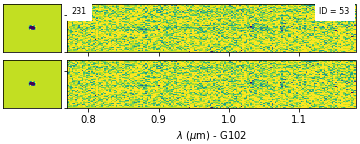

In [33]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

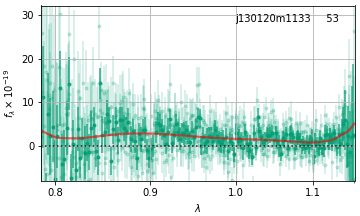

In [34]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 53


(53, 1, 15.592270851135254)

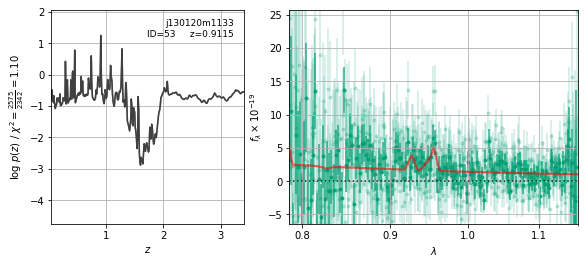

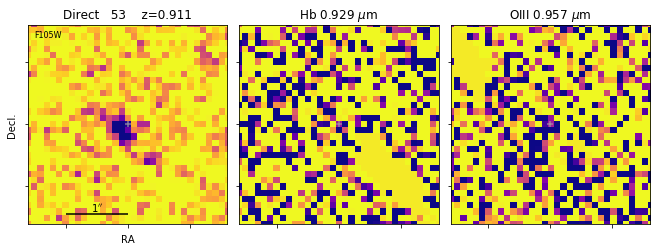

In [35]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [36]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j130120m1133_00053.line.png
j130120m1133_00053.beams.fits
j130120m1133_00053.stack.fits
j130120m1133_00053.log_par
j130120m1133_00053.1D.png
j130120m1133_00053.1D.fits
j130120m1133_00053.stack.png
j130120m1133_00053.full.fits
j130120m1133_00053.full.png


In [37]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j130120m1133_00053.beams.fits


Filename: j130120m1133_00053.beams.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  REF           1 ImageHDU       244   (64, 64)   float32   
  2  SEG           1 ImageHDU       235   (64, 64)   int32   
  3  SCI           2 ImageHDU       243   (271, 64)   float32   
  4  ERR           2 ImageHDU       234   (271, 64)   float32   
  5  DQ            2 ImageHDU       234   (271, 64)   int16   
  6  CONTAM        2 ImageHDU       234   (271, 64)   float32   
  7  REF           1 ImageHDU       244   (64, 64)   float32   
  8  SEG           1 ImageHDU       235   (64, 64)   int32   
  9  SCI           2 ImageHDU       243   (271, 64)   float32   
 10  ERR           2 ImageHDU       234   (271, 64)   float32   
 11  DQ            2 ImageHDU       234   (271, 64)   int16   
 12  CONTAM        2 ImageHDU       234   (271, 64)   float32   
 13  REF           1 ImageHDU       244   (64

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [38]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 447 4
j130120m1133_00447.beams.fits


True

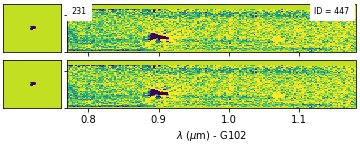

In [39]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

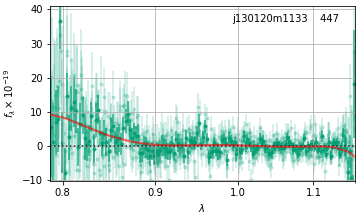

In [40]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 447


(447, 1, 12.523651838302612)

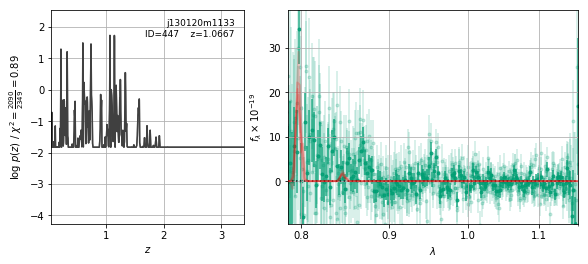

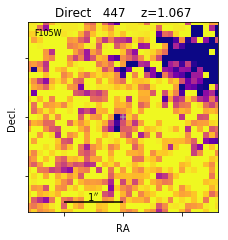

In [41]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).